In [1]:
import glob
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import astroquery
import astropy 

# Astropy packages we'll need
import subprocess
from astropy import units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.visualization import wcsaxes
from astropy.wcs import WCS



# Drizzle related packages we'll need
import drizzlepac
from drizzlepac import tweakreg
from stsci.tools import teal
from stwcs import updatewcs

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import wcsaxes

from matplotlib.patches import Polygon
import matplotlib.cm as cm


teal.unlearn('tweakreg')
teal.unlearn('astrodrizzle')

# ----------------------------------------------------------------------------------------------------------
# 
def get_footprints(im_name):
    """Calculates positions of the corners of the science extensions of some image 'im_name' in sky space"""
    footprints = []
    hdu = fits.open(im_name)
    
    flt_flag = 'flt.fits' in im_name or 'flc.fits' in im_name
    
    # Loop ensures that each science extension in a file is accounted for.  This is important for 
    # multichip imagers like WFC3/UVIS and ACS/WFC
    for ext in hdu:
        if 'SCI' in ext.name:
            hdr = ext.header
            wcs = WCS(hdr, hdu)
            footprint = wcs.calc_footprint(hdr, undistort=flt_flag)
            footprints.append(footprint)
    
    hdu.close()
    return footprints

# ----------------------------------------------------------------------------------------------------------
def bounds(footprint_list):
    """Calculate RA/Dec bounding box properties from multiple RA/Dec points"""
    
    # flatten list of extensions into numpy array of all corner positions
    merged = [ext for image in footprint_list for ext in image]
    merged = np.vstack(merged)
    ras, decs = merged.T
    
    # Compute width/height
    delta_ra = (max(ras)-min(ras))
    delta_dec = (max(decs)-min(decs))

    # Compute midpoints
    ra_midpt = (max(ras)+min(ras))/2.
    dec_midpt = (max(decs)+min(decs))/2.
    

    return ra_midpt, dec_midpt, delta_ra, delta_dec
# ----------------------------------------------------------------------------------------------------------

            
images = glob.glob('jdir*flc.fits')
footprint_list = list(map(get_footprints, images))

# # If that's slow, here's a version that runs it in parallel:
# from multiprocessing import Pool
# p = Pool(8)
# footprint_list = list(p.map(get_footprints, images))
# p.close()
# p.join()


ra_midpt, dec_midpt, delta_ra, delta_dec = bounds(footprint_list)

coord = SkyCoord(ra=ra_midpt, dec=dec_midpt, unit=u.deg)
print(coord)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
<SkyCoord (ICRS): (ra, dec) in deg
    (210.01879382, 15.22003052)>


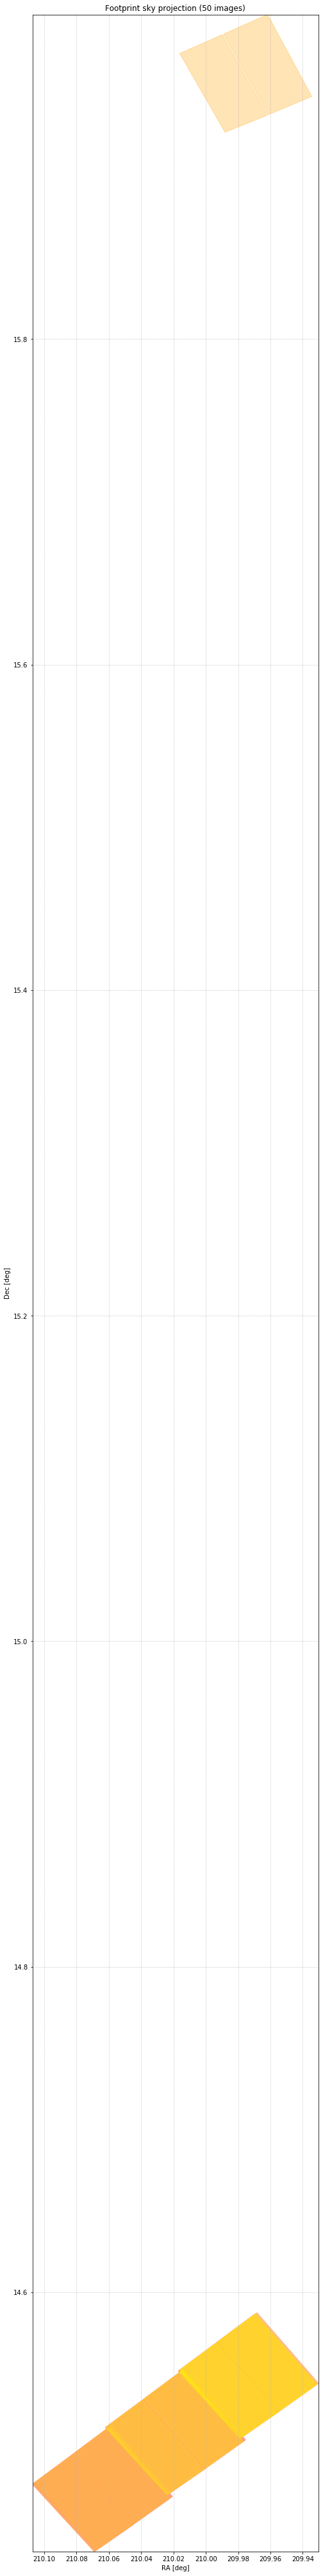

In [2]:
def plot_footprints(footprint_list, axes_obj=None, fill=True):
    """Plots the footprints of the images on sky space on axes specified by axes_obj """
    
    if axes_obj != None: 
        ax = axes_obj
    
    else: # If no axes passed in, initialize them now
        merged = [ext for image in footprint_list for ext in image] # flatten list of RA/Dec
        merged = np.vstack(merged)
        ras, decs = merged.T
        
        # Calculate aspect ratio
        delta_ra = (max(ras)-min(ras))*np.cos(math.radians(min(np.abs(decs))))
        delta_dec = max(decs)-min(decs)
        aspect_ratio = delta_dec/delta_ra
    
        # Initialize axes
        fig = plt.figure(figsize=[8,8*aspect_ratio])
        ax = fig.add_subplot(111)
        ax.set_xlim([max(ras),min(ras)])
        ax.set_ylim([min(decs),max(decs)])
       
        # Labels
        ax.set_xlabel('RA [deg]')
        ax.set_ylabel('Dec [deg]')
        ax.set_title('Footprint sky projection ({} images)'.format(len(footprint_list)))
        
        ax.grid(ls = ':')
    
        
    colors = cm.spring(np.linspace(0, 1, len(footprint_list)))
    alpha = 1./float(len(footprint_list)+1.)+.2
    
    if not fill:
        alpha =.8

    for i, image in enumerate(footprint_list): # Loop over images
        for ext in image: # Loop over extensions in images
            if isinstance(ax, wcsaxes.WCSAxes): # Check axes type
                rect = Polygon(ext, alpha=alpha, closed=True, fill=fill, 
                               color=colors[i], transform=ax.get_transform('icrs'))
            else:
                rect = Polygon(ext, alpha=alpha, closed=True, fill=fill, color=colors[i])

            ax.add_patch(rect)
    
    return ax

# ----------------------------------------------------------------------------------------------------------

plot_footprints(footprint_list)
plt.savefig('footprint_full.jpeg')

       file         date-obs  filter1 ...    dec_targ    postarg1 postarg2
------------------ ---------- ------- ... -------------- -------- --------
jdir01ceq_flc.fits 2019-06-10   F606W ... 14.54785555556      0.0      0.0
jdir01chq_flc.fits 2019-06-10   F606W ... 14.54785555556      0.0      0.0
jdir01cjq_flc.fits 2019-06-10 CLEAR1L ... 14.54785555556      0.0      0.0
jdir01coq_flc.fits 2019-06-10 CLEAR1L ... 14.54785555556      0.0      0.0
jdir02zoq_flc.fits 2019-06-21   F606W ... 14.54785555556    0.247    2.984
jdir02zrq_flc.fits 2019-06-21   F606W ... 14.54785555556    0.247    2.984
jdir02ztq_flc.fits 2019-06-21 CLEAR1L ... 14.54785555556    0.247    2.984
jdir02zyq_flc.fits 2019-06-21 CLEAR1L ... 14.54785555556    0.247    2.984
jdir03bbq_flc.fits 2019-06-29   F606W ... 14.54785555556    0.222    0.018
jdir03beq_flc.fits 2019-06-29   F606W ... 14.54785555556    0.222    0.018
jdir03bhq_flc.fits 2019-06-29 CLEAR1L ... 14.54785555556    0.222    0.018
jdir03bmq_flc.fits 2019-0

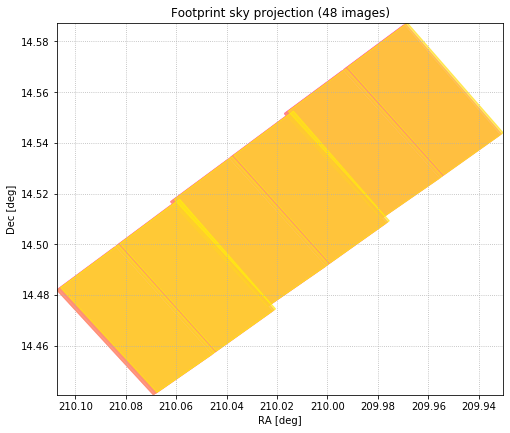

In [9]:
#getting postargs, filter info
from ccdproc import ImageFileCollection
from IPython.display import Image
collec = ImageFileCollection('./', glob_include="jdir*flc.fits", ext=0,
                             keywords=["date-obs","filter1", "filter2","ra_targ", "dec_targ",
                                       "postarg1", "postarg2"])

table = collec.summary
table.pprint(max_lines=-1) #print full table


#footprint_list = list(map(get_footprints, verticle))
#plot_footprints(footprint_list)

#horizontal passes, care about these
horizontal = ('jdir01ceq_flc.fits','jdir05fxq_flc.fits','jdir09qzq_flc.fits','jdir01chq_flc.fits',
              'jdir05g0q_flc.fits','jdir09r2q_flc.fits','jdir01cjq_flc.fits', 'jdir05g2q_flc.fits',
              'jdir09r4q_flc.fits','jdir01coq_flc.fits','jdir05g7q_flc.fits','jdir09r9q_flc.fits',
              'jdir02zoq_flc.fits','jdir06gbq_flc.fits','jdir10veq_flc.fits','jdir02zrq_flc.fits',
              'jdir06geq_flc.fits','jdir10vhq_flc.fits','jdir02ztq_flc.fits','jdir06ggq_flc.fits',
              'jdir10w4q_flc.fits','jdir02zyq_flc.fits','jdir06glq_flc.fits','jdir10w9q_flc.fits',
              'jdir03bbq_flc.fits','jdir07piq_flc.fits','jdir11yaq_flc.fits','jdir03beq_flc.fits',
              'jdir07plq_flc.fits','jdir11ydq_flc.fits','jdir03bhq_flc.fits','jdir07pnq_flc.fits',
              'jdir11z3q_flc.fits','jdir03bmq_flc.fits','jdir07psq_flc.fits','jdir11z8q_flc.fits',
              'jdir04ciq_flc.fits','jdir08toq_flc.fits','jdir12zcq_flc.fits','jdir04clq_flc.fits',
              'jdir08trq_flc.fits','jdir12zfq_flc.fits','jdir04cnq_flc.fits','jdir08ttq_flc.fits',
              'jdir12zhq_flc.fits','jdir04csq_flc.fits','jdir08tyq_flc.fits','jdir12zmq_flc.fits')
footprint_list = list(map(get_footprints, horizontal))
#plot_footprints(footprint_list)

#getting each pass in each filter
pointing_1_606 = ('jdir09qzq_flc.fits', 'jdir09r2q_flc.fits','jdir10veq_flc.fits','jdir10vhq_flc.fits',
                 'jdir11yaq_flc.fits','jdir11ydq_flc.fits','jdir12zcq_flc.fits','jdir12zfq_flc.fits')

pointing_1_606_1 = ('jdir09qzq_flc.fits', 'jdir09r2q_flc.fits',
                 'jdir11yaq_flc.fits','jdir11ydq_flc.fits','jdir12zcq_flc.fits','jdir12zfq_flc.fits')

#trying commenting out the ~problematic~ image, seeing if it helps
pointing_1_814_all = ('jdir09r4q_flc.fits',
                  'jdir09r9q_flc.fits',
                  'jdir10w4q_flc.fits', 
                  'jdir10w9q_flc.fits',
                  'jdir11z3q_flc.fits',
                  'jdir11z8q_flc.fits',
                  'jdir12zhq_flc.fits',
                  'jdir12zmq_flc.fits')
pointing_1_814_1 = ('jdir09r4q_flc.fits','jdir09r9q_flc.fits','jdir11z3q_flc.fits', 'jdir11z8q_flc.fits',
                  'jdir12zhq_flc.fits','jdir12zmq_flc.fits')
the_10s = ('jdir10w4q_flc.fits','jdir10w9q_flc.fits')

pointing_3_606 = ('jdir05fxq_flc.fits','jdir05g0q_flc.fits','jdir06gbq_flc.fits','jdir06geq_flc.fits',
                 'jdir08toq_flc.fits','jdir08trq_flc.fits')
pointing_3_606_bad = ('jdir07piq_flc.fits','jdir07plq_flc.fits')

pointing_3_606_all = ('jdir05fxq_flc.fits','jdir05g0q_flc.fits','jdir06gbq_flc.fits','jdir06geq_flc.fits',
                 'jdir08toq_flc.fits','jdir08trq_flc.fits','jdir07piq_flc.fits','jdir07plq_flc.fits')

pointing_3_814 = ('jdir05g2q_flc.fits','jdir05g7q_flc.fits','jdir06ggq_flc.fits', 'jdir06glq_flc.fits',
                 'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits')
pointing_3_814_bad = ('jdir07pnq_flc.fits','jdir07psq_flc.fits')

pointing_3_814_all = ('jdir05g2q_flc.fits','jdir05g7q_flc.fits','jdir06ggq_flc.fits', 'jdir06glq_flc.fits',
                      'jdir07pnq_flc.fits','jdir07psq_flc.fits',
                      'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits')


pointing_5_606 = ('jdir01ceq_flc.fits', 'jdir01chq_flc.fits','jdir04clq_flc.fits','jdir04ciq_flc.fits')
pointing_5_606_bad = ('jdir02zoq_flc.fits','jdir02zrq_flc.fits','jdir03bbq_flc.fits','jdir03beq_flc.fits')

pointing_5_606_all = ('jdir01ceq_flc.fits', 'jdir01chq_flc.fits','jdir03bbq_flc.fits','jdir04clq_flc.fits',
                      'jdir04ciq_flc.fits','jdir02zoq_flc.fits','jdir02zrq_flc.fits','jdir03beq_flc.fits')

pointing_5_814_1 = ('jdir03bhq_flc.fits','jdir03bmq_flc.fits')

pointing_5_814_2 = ('jdir01cjq_flc.fits','jdir01coq_flc.fits','jdir02zyq_flc.fits','jdir02ztq_flc.fits',
                   'jdir04cnq_flc.fits','jdir04csq_flc.fits')




                 
#bmq and csq done seperately, no grouped list for them

pointing_5_814_all = ('jdir01cjq_flc.fits','jdir01coq_flc.fits','jdir02zyq_flc.fits','jdir02ztq_flc.fits',
                      'jdir03bmq_flc.fits','jdir03bhq_flc.fits','jdir04cnq_flc.fits','jdir04csq_flc.fits')

pointing_1_all = ('jdir09qzq_flc.fits','jdir09r2q_flc.fits', 'jdir09r4q_flc.fits','jdir09r9q_flc.fits',
                  'jdir10veq_flc.fits','jdir10vhq_flc.fits','jdir10w4q_flc.fits', 'jdir10w9q_flc.fits',
                 'jdir11yaq_flc.fits','jdir11ydq_flc.fits', 'jdir11z3q_flc.fits','jdir11z8q_flc.fits',
                  'jdir12zcq_flc.fits','jdir12zfq_flc.fits', 'jdir12zhq_flc.fits','jdir12zmq_flc.fits')

pointing_3_all = ('jdir05fxq_flc.fits','jdir05g0q_flc.fits','jdir06gbq_flc.fits','jdir06geq_flc.fits',
                 'jdir07piq_flc.fits','jdir07plq_flc.fits','jdir08toq_flc.fits','jdir08trq_flc.fits',
                   'jdir05g2q_flc.fits','jdir05g7q_flc.fits','jdir06ggq_flc.fits','jdir06glq_flc.fits',
                 'jdir07pnq_flc.fits','jdir07psq_flc.fits','jdir08ttq_flc.fits','jdir08tyq_flc.fits')
                  
pointing_5_all = ('jdir01ceq_flc.fits','jdir01chq_flc.fits','jdir02zoq_flc.fits','jdir02zrq_flc.fits',
                 'jdir03bbq_flc.fits','jdir03beq_flc.fits','jdir04clq_flc.fits','jdir04ciq_flc.fits',
                  'jdir01cjq_flc.fits','jdir01coq_flc.fits','jdir02ztq_flc.fits','jdir02zyq_flc.fits',
                  'jdir03bhq_flc.fits','jdir03bmq_flc.fits','jdir04cnq_flc.fits','jdir04csq_flc.fits')
                  
#for future reference, instead of taking a million years to figure out which image is where, there is 
#"targname" in the keywords/header that can use to figure out which one it is (i.e. bootes-3 = pointing_1)         
               
footprint_list = list(map(get_footprints, horizontal))
plot_footprints(footprint_list)
plt.savefig('footprint.jpeg')

In [97]:
#redrizzle using 606, 0 postargs as ref image

In [5]:
#updating WCS - need to do this so that everything is recalibrated the right way
from stwcs import updatewcs
import os
import shutil
import stwcs
import subprocess
input_images = sorted(glob.glob('jdir*flc.fits')) 

os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.abspath(os.path.join('.', 'reference_files'))
subprocess.check_output('crds bestrefs --files jdir*flc.fits --sync-references=1 --update-bestrefs', 
                        shell=True, stderr=subprocess.DEVNULL)
os.environ['jref'] = os.path.abspath(os.path.join('.', 'reference_files', 'references', 'hst', 'acs')) + os.path.sep


#updatewcs.updatewcs(list(pointing_1_all), use_db=False)

Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 6 for chip 2 : F814W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 6 for chip 2 : F814W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
-

['jdir09qzq_flc.fits',
 'jdir09r2q_flc.fits',
 'jdir09r4q_flc.fits',
 'jdir09r9q_flc.fits',
 'jdir10veq_flc.fits',
 'jdir10vhq_flc.fits',
 'jdir10w4q_flc.fits',
 'jdir10w9q_flc.fits',
 'jdir11yaq_flc.fits',
 'jdir11ydq_flc.fits',
 'jdir11z3q_flc.fits',
 'jdir11z8q_flc.fits',
 'jdir12zcq_flc.fits',
 'jdir12zfq_flc.fits',
 'jdir12zhq_flc.fits',
 'jdir12zmq_flc.fits']

# Running TweakReg on each of the pointing passes - each pass had 8 files, four files per filter, and we run tweak reag on the 8 files. We want each pass to have the same shift file, since they are the same region. 

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 13:32:53.420 (22/10/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 13:32:53.420 (22/10/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	False
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir09r4q_flc.fits', 'jdir09r9q_flc.fits', 'jdir10w4q_flc.fits', 'jdir10w9q_flc.fits', 'jdir11z3q_flc.fits', 'jdir11z8q_flc.fits', 'jdir12zhq_flc.fits', 'jdir12zmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir09r4q_flc.fits


    jdir09r4q_flc.fits


INFO:drizzlepac.tweakreg:    jdir09r9q_flc.fits


    jdir09r9q_flc.fits


INFO:drizzlepac.tweakreg:    jdir10w4q_flc.fits


    jdir10w4q_flc.fits


INFO:drizzlepac.tweakreg:    jdir10w9q_flc.fits


    jdir10w9q_flc.fits


INFO:drizzlepac.tweakreg:    jdir11z3q_flc.fits


    jdir11z3q_flc.fits


INFO:drizzlepac.tweakreg:    jdir11z8q_flc.fits


    jdir11z8q_flc.fits


INFO:drizzlepac.tweakreg:    jdir12zhq_flc.fits


    jdir12zhq_flc.fits


INFO:drizzlepac.tweakreg:    jdir12zmq_flc.fits


    jdir12zmq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	False
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir09r4q_flc.fits', 'jdir09r9q_flc.fits', 'jdir10w4q_flc.fits', 'jdir10w9q_flc.fits', 'jdir11z3q_flc.fits', 'jdir11z8q_flc.fits', 'jdir12zhq_flc.fits', 'jdir12zmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlep

===  Source finding for image 'jdir09r4q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 1) started at: 13:32:54.064 (22/10/2019)


  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 1) started at: 13:32:54.064 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.084555
INFO:drizzlepac.catalogs:###Source finding finished at: 13:32:55.483 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1390 objects.


     Found 1390 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 2) started at: 13:32:55.601 (22/10/2019)


  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 2) started at: 13:32:55.601 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.117480
INFO:drizzlepac.catalogs:###Source finding finished at: 13:32:56.716 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1465 objects.


     Found 1465 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09r4q_flc.fits': 2855


===  FINAL number of objects in image 'jdir09r4q_flc.fits': 2855


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir09r9q_flc.fits':


===  Source finding for image 'jdir09r9q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r9q_flc.fits', EXT=('SCI', 1) started at: 13:32:57.220 (22/10/2019)


  #  Source finding for 'jdir09r9q_flc.fits', EXT=('SCI', 1) started at: 13:32:57.220 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.536918
INFO:drizzlepac.catalogs:###Source finding finished at: 13:32:58.303 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 2787 objects.


     Found 2787 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r9q_flc.fits', EXT=('SCI', 2) started at: 13:32:58.424 (22/10/2019)


  #  Source finding for 'jdir09r9q_flc.fits', EXT=('SCI', 2) started at: 13:32:58.424 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.646012
INFO:drizzlepac.catalogs:###Source finding finished at: 13:32:59.662 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 2874 objects.


     Found 2874 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09r9q_flc.fits': 5661


===  FINAL number of objects in image 'jdir09r9q_flc.fits': 5661


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir10w4q_flc.fits':


===  Source finding for image 'jdir10w4q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10w4q_flc.fits', EXT=('SCI', 1) started at: 13:33:00.100 (22/10/2019)


  #  Source finding for 'jdir10w4q_flc.fits', EXT=('SCI', 1) started at: 13:33:00.100 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.777293
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:01.50 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 2349 objects.


     Found 2349 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10w4q_flc.fits', EXT=('SCI', 2) started at: 13:33:01.630 (22/10/2019)


  #  Source finding for 'jdir10w4q_flc.fits', EXT=('SCI', 2) started at: 13:33:01.630 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.844852
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:02.856 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 2526 objects.


     Found 2526 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir10w4q_flc.fits': 4875


===  FINAL number of objects in image 'jdir10w4q_flc.fits': 4875


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir10w9q_flc.fits':


===  Source finding for image 'jdir10w9q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10w9q_flc.fits', EXT=('SCI', 1) started at: 13:33:03.478 (22/10/2019)


  #  Source finding for 'jdir10w9q_flc.fits', EXT=('SCI', 1) started at: 13:33:03.478 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.275783
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:04.617 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1446 objects.


     Found 1446 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10w9q_flc.fits', EXT=('SCI', 2) started at: 13:33:04.749 (22/10/2019)


  #  Source finding for 'jdir10w9q_flc.fits', EXT=('SCI', 2) started at: 13:33:04.749 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.325347
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:06.072 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1478 objects.


     Found 1478 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir10w9q_flc.fits': 2924


===  FINAL number of objects in image 'jdir10w9q_flc.fits': 2924


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir11z3q_flc.fits':


===  Source finding for image 'jdir11z3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11z3q_flc.fits', EXT=('SCI', 1) started at: 13:33:06.600 (22/10/2019)


  #  Source finding for 'jdir11z3q_flc.fits', EXT=('SCI', 1) started at: 13:33:06.600 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.173887
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:07.706 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1148 objects.


     Found 1148 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11z3q_flc.fits', EXT=('SCI', 2) started at: 13:33:07.816 (22/10/2019)


  #  Source finding for 'jdir11z3q_flc.fits', EXT=('SCI', 2) started at: 13:33:07.816 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.181701
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:09.146 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1233 objects.


     Found 1233 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir11z3q_flc.fits': 2381


===  FINAL number of objects in image 'jdir11z3q_flc.fits': 2381


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir11z8q_flc.fits':


===  Source finding for image 'jdir11z8q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11z8q_flc.fits', EXT=('SCI', 1) started at: 13:33:09.532 (22/10/2019)


  #  Source finding for 'jdir11z8q_flc.fits', EXT=('SCI', 1) started at: 13:33:09.532 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.335865
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:10.603 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1390 objects.


     Found 1390 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11z8q_flc.fits', EXT=('SCI', 2) started at: 13:33:10.710 (22/10/2019)


  #  Source finding for 'jdir11z8q_flc.fits', EXT=('SCI', 2) started at: 13:33:10.710 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.368981
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:12.104 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1444 objects.


     Found 1444 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir11z8q_flc.fits': 2834


===  FINAL number of objects in image 'jdir11z8q_flc.fits': 2834


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir12zhq_flc.fits':


===  Source finding for image 'jdir12zhq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zhq_flc.fits', EXT=('SCI', 1) started at: 13:33:12.576 (22/10/2019)


  #  Source finding for 'jdir12zhq_flc.fits', EXT=('SCI', 1) started at: 13:33:12.576 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.967133
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:13.660 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1263 objects.


     Found 1263 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zhq_flc.fits', EXT=('SCI', 2) started at: 13:33:13.788 (22/10/2019)


  #  Source finding for 'jdir12zhq_flc.fits', EXT=('SCI', 2) started at: 13:33:13.788 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.064612
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:14.898 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1283 objects.


     Found 1283 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir12zhq_flc.fits': 2546


===  FINAL number of objects in image 'jdir12zhq_flc.fits': 2546


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir12zmq_flc.fits':


===  Source finding for image 'jdir12zmq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zmq_flc.fits', EXT=('SCI', 1) started at: 13:33:15.307 (22/10/2019)


  #  Source finding for 'jdir12zmq_flc.fits', EXT=('SCI', 1) started at: 13:33:15.307 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.284059
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:16.517 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1317 objects.


     Found 1317 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zmq_flc.fits', EXT=('SCI', 2) started at: 13:33:16.71 (22/10/2019)


  #  Source finding for 'jdir12zmq_flc.fits', EXT=('SCI', 2) started at: 13:33:16.71 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.328031
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:18.254 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1418 objects.


     Found 1418 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir12zmq_flc.fits': 2735


===  FINAL number of objects in image 'jdir12zmq_flc.fits': 2735


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	False
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir09r4q_flc.fits', 'jdir09r9q_flc.fits', 'jdir10w4q_flc.fits', 'jdir10w9q_flc.fits', 'jdir11z3q_flc.fits', 'jdir11z8q_flc.fits', 'jdir12zhq_flc.fits', 'jdir12zmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:

===  Source finding for image 'jdir09r4q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 1) started at: 13:33:18.852 (22/10/2019)


  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 1) started at: 13:33:18.852 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.084555
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:19.710 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 8337 objects.


     Found 8337 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 2) started at: 13:33:19.887 (22/10/2019)


  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 2) started at: 13:33:19.887 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.117480
INFO:drizzlepac.catalogs:###Source finding finished at: 13:33:20.735 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 9002 objects.


     Found 9002 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09r4q_flc.fits': 17339


===  FINAL number of objects in image 'jdir09r4q_flc.fits': 17339


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir09r4q_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir09r4q_flc.fits'


derived from 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	1e-05
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	5
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir09r9q_flc.fits


Performing fit for: jdir09r9q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir09r9q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir09r9q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.14855875831485577 -1.1108647450110851


Found initial X and Y shifts of  -0.14855875831485577 -1.1108647450110851


INFO:drizzlepac.tweakutils:    with significance of  688.2709592782677 and  65.0  matches


    with significance of  688.2709592782677 and  65.0  matches


INFO:drizzlepac.imgclasses:Found 187 matches for jdir09r9q_flc.fits...


Found 187 matches for jdir09r9q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir09r9q_flc.fits : 


Computed  general  fit for  jdir09r9q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0029  YSH: -0.0013    PROPER ROT: 359.9999936    


XSH: 0.0029  YSH: -0.0013    PROPER ROT: 359.9999936    


INFO:drizzlepac.imgclasses:<ROT>: 179.9999936  SKEW: -359.9999444    ROT_X: 359.9999658  ROT_Y: 2.147054991e-05


<ROT>: 179.9999936  SKEW: -359.9999444    ROT_X: 359.9999658  ROT_Y: 2.147054991e-05


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999714189  SCALE_X: 0.9999700514  SCALE_Y: 0.9999727864


<SCALE>: 0.9999714189  SCALE_X: 0.9999700514  SCALE_Y: 0.9999727864


INFO:drizzlepac.imgclasses:XRMS: 0.012    YRMS: 0.0065


XRMS: 0.012    YRMS: 0.0065


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.8e-07 (deg)   RMS_DEC: 7.2e-08 (deg)


RMS_RA: 1.8e-07 (deg)   RMS_DEC: 7.2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  51  objects.


Final solution based on  51  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir09r9q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir09r9q_flc_catalog_fit.match


wrote XY data to:  jdir09r9q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  51


Total # points:  51


INFO:drizzlepac.tweakutils:# of points after clipping:  51


# of points after clipping:  51


INFO:drizzlepac.tweakutils:Total # points:  51


Total # points:  51


INFO:drizzlepac.tweakutils:# of points after clipping:  51


# of points after clipping:  51


INFO:drizzlepac.imgclasses:Adding 5474 new sources to the reference catalog for a total of 22813 sources.


Adding 5474 new sources to the reference catalog for a total of 22813 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir09r9q_flc.fits...


....Updating header for jdir09r9q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir09r9q_flc.fits['SCI',1]


Processing jdir09r9q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir09r9q_flc.fits[1]


Updating header for jdir09r9q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.032566795857726e-06 1.119521137293095e-05


CD_11  CD_12: 9.032566795857726e-06 1.119521137293095e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0491240930391404e-05 -8.362702357091966e-06


CD_21  CD_22: 1.0491240930391404e-05 -8.362702357091966e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05266828729583 14.486238215019283


CRVAL    : 210.05266828729583 14.486238215019283


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049836527144340136


Plate Scale : 0.049836527144340136


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75933528783136


ORIENTAT : 126.75933528783136


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir09r9q_flc.fits['SCI',2]


Processing jdir09r9q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir09r9q_flc.fits[4]


Updating header for jdir09r9q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.066296579956844e-06 1.0882180318298823e-05


CD_11  CD_12: 9.066296579956844e-06 1.0882180318298823e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0246986488185534e-05 -8.002203847350553e-06


CD_21  CD_22: 1.0246986488185534e-05 -8.002203847350553e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07660047698323 14.469001794335146


CRVAL    : 210.07660047698323 14.469001794335146


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492539037333401


Plate Scale : 0.0492539037333401


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32887865773753


ORIENTAT : 126.32887865773753


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir09r4q_flc.fits


Performing fit for: jdir09r4q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir09r4q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir09r4q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.imgclasses:NO fit performed for reference image: jdir09r4q_flc.fits

INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir11z3q_flc.fits


Performing fit for: jdir11z3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir11z3q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir11z3q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.105726872246695 -1.9383259911894264


Found initial X and Y shifts of  -1.105726872246695 -1.9383259911894264


INFO:drizzlepac.tweakutils:    with significance of  302.31109804305896 and  56.0  matches


    with significance of  302.31109804305896 and  56.0  matches


INFO:drizzlepac.imgclasses:Found 89 matches for jdir11z3q_flc.fits...


Found 89 matches for jdir11z3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir11z3q_flc.fits : 


Computed  general  fit for  jdir11z3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2958  YSH: -1.7794    PROPER ROT: 0.004660919215    


XSH: -0.2958  YSH: -1.7794    PROPER ROT: 0.004660919215    


INFO:drizzlepac.imgclasses:<ROT>: 0.004660919215  SKEW: 0.0008082290323    ROT_X: 0.004256804699  ROT_Y: 0.005065033731


<ROT>: 0.004660919215  SKEW: 0.0008082290323    ROT_X: 0.004256804699  ROT_Y: 0.005065033731


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999921437  SCALE_X: 0.9999838933  SCALE_Y: 1.000000394


<SCALE>: 0.9999921437  SCALE_X: 0.9999838933  SCALE_Y: 1.000000394


INFO:drizzlepac.imgclasses:XRMS: 0.05    YRMS: 0.045


XRMS: 0.05    YRMS: 0.045


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9.5e-07 (deg)   RMS_DEC: 1.4e-07 (deg)


RMS_RA: 9.5e-07 (deg)   RMS_DEC: 1.4e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  34  objects.


Final solution based on  34  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir11z3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir11z3q_flc_catalog_fit.match


wrote XY data to:  jdir11z3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  34


Total # points:  34


INFO:drizzlepac.tweakutils:# of points after clipping:  34


# of points after clipping:  34


INFO:drizzlepac.tweakutils:Total # points:  34


Total # points:  34


INFO:drizzlepac.tweakutils:# of points after clipping:  34


# of points after clipping:  34


INFO:drizzlepac.imgclasses:Adding 2292 new sources to the reference catalog for a total of 25105 sources.


Adding 2292 new sources to the reference catalog for a total of 25105 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir11z3q_flc.fits


Initializing new WCSCORR table for  jdir11z3q_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir11z3q_flc.fits...


....Updating header for jdir11z3q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11z3q_flc.fits['SCI',1]


Processing jdir11z3q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11z3q_flc.fits[1]


Updating header for jdir11z3q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.033295198712054e-06 1.1194238192838652e-05


CD_11  CD_12: 9.033295198712054e-06 1.1194238192838652e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0490436905447091e-05 -8.363502737418106e-06


CD_21  CD_22: 1.0490436905447091e-05 -8.363502737418106e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05264872421523 14.486179342699234


CRVAL    : 210.05264872421523 14.486179342699234


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983675501543776


Plate Scale : 0.04983675501543776


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.76435257098593


ORIENTAT : 126.76435257098593


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11z3q_flc.fits['SCI',2]


Processing jdir11z3q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11z3q_flc.fits[4]


Updating header for jdir11z3q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.067005448125998e-06 1.0881245445182175e-05


CD_11  CD_12: 9.067005448125998e-06 1.0881245445182175e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0246181045224963e-05 -8.002982523430947e-06


CD_21  CD_22: 1.0246181045224963e-05 -8.002982523430947e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07657883367438 14.468941265028231


CRVAL    : 210.07657883367438 14.468941265028231


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254134605993156


Plate Scale : 0.049254134605993156


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.33388892519098


ORIENTAT : 126.33388892519098


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir11z8q_flc.fits


Performing fit for: jdir11z8q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir11z8q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir11z8q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.1571428571428584 -1.9942857142857129


Found initial X and Y shifts of  -1.1571428571428584 -1.9942857142857129


INFO:drizzlepac.tweakutils:    with significance of  1635.8416323574377 and  133.0  matches


    with significance of  1635.8416323574377 and  133.0  matches


INFO:drizzlepac.imgclasses:Found 171 matches for jdir11z8q_flc.fits...


Found 171 matches for jdir11z8q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir11z8q_flc.fits : 


Computed  general  fit for  jdir11z8q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2980  YSH: -1.7759    PROPER ROT: 0.004670807827    


XSH: -0.2980  YSH: -1.7759    PROPER ROT: 0.004670807827    


INFO:drizzlepac.imgclasses:<ROT>: 0.004670807827  SKEW: -0.0006267707258    ROT_X: 0.00498419319  ROT_Y: 0.004357422464


<ROT>: 0.004670807827  SKEW: -0.0006267707258    ROT_X: 0.00498419319  ROT_Y: 0.004357422464


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999734378  SCALE_X: 0.9999805967  SCALE_Y: 0.9999662791


<SCALE>: 0.9999734378  SCALE_X: 0.9999805967  SCALE_Y: 0.9999662791


INFO:drizzlepac.imgclasses:XRMS: 0.009    YRMS: 0.014


XRMS: 0.009    YRMS: 0.014


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.4e-07 (deg)   RMS_DEC: 2.9e-08 (deg)


RMS_RA: 2.4e-07 (deg)   RMS_DEC: 2.9e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  54  objects.


Final solution based on  54  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir11z8q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir11z8q_flc_catalog_fit.match


wrote XY data to:  jdir11z8q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  54


Total # points:  54


INFO:drizzlepac.tweakutils:# of points after clipping:  54


# of points after clipping:  54


INFO:drizzlepac.tweakutils:Total # points:  54


Total # points:  54


INFO:drizzlepac.tweakutils:# of points after clipping:  54


# of points after clipping:  54


INFO:drizzlepac.imgclasses:Adding 2663 new sources to the reference catalog for a total of 27770 sources.


Adding 2663 new sources to the reference catalog for a total of 27770 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir11z8q_flc.fits


Initializing new WCSCORR table for  jdir11z8q_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir11z8q_flc.fits...


....Updating header for jdir11z8q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11z8q_flc.fits['SCI',1]


Processing jdir11z8q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11z8q_flc.fits[1]


Updating header for jdir11z8q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.033167466279379e-06 1.119434256328115e-05


CD_11  CD_12: 9.033167466279379e-06 1.119434256328115e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0489999934228748e-05 -8.363386898749185e-06


CD_21  CD_22: 1.0489999934228748e-05 -8.363386898749185e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05264870108894 14.486179397484554


CRVAL    : 210.05264870108894 14.486179397484554


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983505945961556


Plate Scale : 0.04983505945961556


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.76371592778541


ORIENTAT : 126.76371592778541


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11z8q_flc.fits['SCI',2]


Processing jdir11z8q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11z8q_flc.fits[4]


Updating header for jdir11z8q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.066880711255819e-06 1.0881345291777367e-05


CD_11  CD_12: 9.066880711255819e-06 1.0881345291777367e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0245751115437879e-05 -8.00287390127895e-06


CD_21  CD_22: 1.0245751115437879e-05 -8.00287390127895e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07657903267852 14.468941557255933


CRVAL    : 210.07657903267852 14.468941557255933


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925245887219663


Plate Scale : 0.04925245887219663


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.33326681429433


ORIENTAT : 126.33326681429433


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir10w4q_flc.fits


Performing fit for: jdir10w4q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir10w4q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir10w4q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.02536997885835 8.13107822410148


Found initial X and Y shifts of  4.02536997885835 8.13107822410148


INFO:drizzlepac.tweakutils:    with significance of  518.9668858139491 and  41.0  matches


    with significance of  518.9668858139491 and  41.0  matches


INFO:drizzlepac.imgclasses:Found 113 matches for jdir10w4q_flc.fits...


Found 113 matches for jdir10w4q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir10w4q_flc.fits : 


Computed  general  fit for  jdir10w4q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.9149  YSH: 8.6477    PROPER ROT: 0.004978999729    


XSH: 4.9149  YSH: 8.6477    PROPER ROT: 0.004978999729    


INFO:drizzlepac.imgclasses:<ROT>: 0.004978999729  SKEW: -0.001565371756    ROT_X: 0.005761685607  ROT_Y: 0.004196313851


<ROT>: 0.004978999729  SKEW: -0.001565371756    ROT_X: 0.005761685607  ROT_Y: 0.004196313851


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999801854  SCALE_X: 1.000006839  SCALE_Y: 0.9999535329


<SCALE>: 0.9999801854  SCALE_X: 1.000006839  SCALE_Y: 0.9999535329


INFO:drizzlepac.imgclasses:XRMS: 0.053    YRMS: 0.052


XRMS: 0.053    YRMS: 0.052


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-06 (deg)   RMS_DEC: 1.3e-07 (deg)


RMS_RA: 1.1e-06 (deg)   RMS_DEC: 1.3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  34  objects.


Final solution based on  34  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir10w4q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir10w4q_flc_catalog_fit.match


wrote XY data to:  jdir10w4q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  34


Total # points:  34


INFO:drizzlepac.tweakutils:# of points after clipping:  34


# of points after clipping:  34


INFO:drizzlepac.tweakutils:Total # points:  34


Total # points:  34


INFO:drizzlepac.tweakutils:# of points after clipping:  34


# of points after clipping:  34


INFO:drizzlepac.imgclasses:Adding 4762 new sources to the reference catalog for a total of 32535 sources.


Adding 4762 new sources to the reference catalog for a total of 32535 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir10w4q_flc.fits


Initializing new WCSCORR table for  jdir10w4q_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir10w4q_flc.fits...


....Updating header for jdir10w4q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10w4q_flc.fits['SCI',1]


Processing jdir10w4q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10w4q_flc.fits[1]


Updating header for jdir10w4q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.033356495452663e-06 1.1194916920360524e-05


CD_11  CD_12: 9.033356495452663e-06 1.1194916920360524e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0489991664805274e-05 -8.363725619635525e-06


CD_21  CD_22: 1.0489991664805274e-05 -8.363725619635525e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0517973495094 14.486699104496779


CRVAL    : 210.0517973495094 14.486699104496779


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983676225051039


Plate Scale : 0.04983676225051039


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.7634190416325


ORIENTAT : 126.7634190416325


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10w4q_flc.fits['SCI',2]


Processing jdir10w4q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10w4q_flc.fits[4]


Updating header for jdir10w4q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.067074897626685e-06 1.0881901542898708e-05


CD_11  CD_12: 9.067074897626685e-06 1.0881901542898708e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0245738457810195e-05 -8.003201398561702e-06


CD_21  CD_22: 1.0245738457810195e-05 -8.003201398561702e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07572896374404 14.469460564070578


CRVAL    : 210.07572896374404 14.469460564070578


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925414158173888


Plate Scale : 0.04925414158173888


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.33298796458256


ORIENTAT : 126.33298796458256


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir10w9q_flc.fits


Performing fit for: jdir10w9q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir10w9q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir10w9q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.063457330415755 8.11597374179431


Found initial X and Y shifts of  4.063457330415755 8.11597374179431


INFO:drizzlepac.tweakutils:    with significance of  702.1064197524007 and  64.0  matches


    with significance of  702.1064197524007 and  64.0  matches


INFO:drizzlepac.imgclasses:Found 188 matches for jdir10w9q_flc.fits...


Found 188 matches for jdir10w9q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir10w9q_flc.fits : 


Computed  general  fit for  jdir10w9q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.9140  YSH: 8.6454    PROPER ROT: 0.004869119101    


XSH: 4.9140  YSH: 8.6454    PROPER ROT: 0.004869119101    


INFO:drizzlepac.imgclasses:<ROT>: 0.004869119101  SKEW: 0.001852015058    ROT_X: 0.003943111572  ROT_Y: 0.00579512663


<ROT>: 0.004869119101  SKEW: 0.001852015058    ROT_X: 0.003943111572  ROT_Y: 0.00579512663


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999859676  SCALE_X: 0.9999607181  SCALE_Y: 1.000011218


<SCALE>: 0.9999859676  SCALE_X: 0.9999607181  SCALE_Y: 1.000011218


INFO:drizzlepac.imgclasses:XRMS: 0.015    YRMS: 0.03


XRMS: 0.015    YRMS: 0.03


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.7e-07 (deg)   RMS_DEC: 1e-07 (deg)


RMS_RA: 4.7e-07 (deg)   RMS_DEC: 1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  53  objects.


Final solution based on  53  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir10w9q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir10w9q_flc_catalog_fit.match


wrote XY data to:  jdir10w9q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  53


Total # points:  53


INFO:drizzlepac.tweakutils:# of points after clipping:  53


# of points after clipping:  53


INFO:drizzlepac.tweakutils:Total # points:  53


Total # points:  53


INFO:drizzlepac.tweakutils:# of points after clipping:  53


# of points after clipping:  53


INFO:drizzlepac.imgclasses:Adding 2736 new sources to the reference catalog for a total of 35274 sources.


Adding 2736 new sources to the reference catalog for a total of 35274 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir10w9q_flc.fits


Initializing new WCSCORR table for  jdir10w9q_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir10w9q_flc.fits...


....Updating header for jdir10w9q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10w9q_flc.fits['SCI',1]


Processing jdir10w9q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10w9q_flc.fits[1]


Updating header for jdir10w9q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.033083689189198e-06 1.11936677634383e-05


CD_11  CD_12: 9.033083689189198e-06 1.11936677634383e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0490413735923142e-05 -8.363207029072142e-06


CD_21  CD_22: 1.0490413735923142e-05 -8.363207029072142e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.051797440603 14.48669904930314


CRVAL    : 210.051797440603 14.48669904930314


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983506898718134


Plate Scale : 0.04983506898718134


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.76478116866383


ORIENTAT : 126.76478116866383


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10w9q_flc.fits['SCI',2]


Processing jdir10w9q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10w9q_flc.fits[4]


Updating header for jdir10w9q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.066789070485858e-06 1.0880692815994106e-05


CD_11  CD_12: 9.066789070485858e-06 1.0880692815994106e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.024616209358108e-05 -8.0026970255115e-06


CD_21  CD_22: 1.024616209358108e-05 -8.0026970255115e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0757263878283 14.469461582565183


CRVAL    : 210.0757263878283 14.469461582565183


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925246811364073


Plate Scale : 0.04925246811364073


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.3343022506331


ORIENTAT : 126.3343022506331


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir12zhq_flc.fits


Performing fit for: jdir12zhq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir12zhq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir12zhq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.9433427762039663 0.8243626062322953


Found initial X and Y shifts of  -0.9433427762039663 0.8243626062322953


INFO:drizzlepac.tweakutils:    with significance of  648.7889933520272 and  61.0  matches


    with significance of  648.7889933520272 and  61.0  matches


INFO:drizzlepac.imgclasses:Found 128 matches for jdir12zhq_flc.fits...


Found 128 matches for jdir12zhq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir12zhq_flc.fits : 


Computed  general  fit for  jdir12zhq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.3314  YSH: 1.0807    PROPER ROT: 359.9969545    


XSH: -0.3314  YSH: 1.0807    PROPER ROT: 359.9969545    


INFO:drizzlepac.imgclasses:<ROT>: 359.9969545  SKEW: 0.00108491383    ROT_X: 359.9964121  ROT_Y: 359.997497


<ROT>: 359.9969545  SKEW: 0.00108491383    ROT_X: 359.9964121  ROT_Y: 359.997497


INFO:drizzlepac.imgclasses:<SCALE>: 1.000002354  SCALE_X: 1.000008742  SCALE_Y: 0.9999959667


<SCALE>: 1.000002354  SCALE_X: 1.000008742  SCALE_Y: 0.9999959667


INFO:drizzlepac.imgclasses:XRMS: 0.048    YRMS: 0.047


XRMS: 0.048    YRMS: 0.047


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9.6e-07 (deg)   RMS_DEC: 1.1e-07 (deg)


RMS_RA: 9.6e-07 (deg)   RMS_DEC: 1.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  38  objects.


Final solution based on  38  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir12zhq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir12zhq_flc_catalog_fit.match


wrote XY data to:  jdir12zhq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  38


Total # points:  38


INFO:drizzlepac.tweakutils:# of points after clipping:  38


# of points after clipping:  38


INFO:drizzlepac.tweakutils:Total # points:  38


Total # points:  38


INFO:drizzlepac.tweakutils:# of points after clipping:  38


# of points after clipping:  38


INFO:drizzlepac.imgclasses:Adding 2418 new sources to the reference catalog for a total of 37693 sources.


Adding 2418 new sources to the reference catalog for a total of 37693 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir12zhq_flc.fits


Initializing new WCSCORR table for  jdir12zhq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir12zhq_flc.fits...


....Updating header for jdir12zhq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zhq_flc.fits['SCI',1]


Processing jdir12zhq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zhq_flc.fits[1]


Updating header for jdir12zhq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.03156827653129e-06 1.1195439276498284e-05


CD_11  CD_12: 9.03156827653129e-06 1.1195439276498284e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.049146741102986e-05 -8.361992475525086e-06


CD_21  CD_22: 1.049146741102986e-05 -8.361992475525086e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0511989308201 14.487127588940972


CRVAL    : 210.0511989308201 14.487127588940972


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0498367542814717


Plate Scale : 0.0498367542814717


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75644410341854


ORIENTAT : 126.75644410341854


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zhq_flc.fits['SCI',2]


Processing jdir12zhq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zhq_flc.fits[4]


Updating header for jdir12zhq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.06531655863171e-06 1.0882392940371478e-05


CD_11  CD_12: 9.06531655863171e-06 1.0882392940371478e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0247218358600243e-05 -8.001516075591546e-06


CD_21  CD_22: 1.0247218358600243e-05 -8.001516075591546e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0751316983012 14.469892636257702


CRVAL    : 210.0751316983012 14.469892636257702


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925413388551025


Plate Scale : 0.04925413388551025


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32599402050839


ORIENTAT : 126.32599402050839


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir12zmq_flc.fits


Performing fit for: jdir12zmq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir12zmq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir12zmq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.102161100196465 1.0569744597249517


Found initial X and Y shifts of  -1.102161100196465 1.0569744597249517


INFO:drizzlepac.tweakutils:    with significance of  944.8039719722527 and  124.0  matches


    with significance of  944.8039719722527 and  124.0  matches


INFO:drizzlepac.imgclasses:Found 224 matches for jdir12zmq_flc.fits...


Found 224 matches for jdir12zmq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir12zmq_flc.fits : 


Computed  general  fit for  jdir12zmq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.3337  YSH: 1.0809    PROPER ROT: 359.996856    


XSH: -0.3337  YSH: 1.0809    PROPER ROT: 359.996856    


INFO:drizzlepac.imgclasses:<ROT>: 359.996856  SKEW: -0.0007347719598    ROT_X: 359.9972234  ROT_Y: 359.9964886


<ROT>: 359.996856  SKEW: -0.0007347719598    ROT_X: 359.9972234  ROT_Y: 359.9964886


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999603879  SCALE_X: 0.9999549999  SCALE_Y: 0.999965776


<SCALE>: 0.9999603879  SCALE_X: 0.9999549999  SCALE_Y: 0.999965776


INFO:drizzlepac.imgclasses:XRMS: 0.012    YRMS: 0.019


XRMS: 0.012    YRMS: 0.019


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.2e-07 (deg)   RMS_DEC: 4e-08 (deg)


RMS_RA: 3.2e-07 (deg)   RMS_DEC: 4e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  67  objects.


Final solution based on  67  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir12zmq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir12zmq_flc_catalog_fit.match


wrote XY data to:  jdir12zmq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  67


Total # points:  67


INFO:drizzlepac.tweakutils:# of points after clipping:  67


# of points after clipping:  67


INFO:drizzlepac.tweakutils:Total # points:  67


Total # points:  67


INFO:drizzlepac.tweakutils:# of points after clipping:  67


# of points after clipping:  67


INFO:drizzlepac.imgclasses:Adding 2511 new sources to the reference catalog for a total of 40224 sources.


Adding 2511 new sources to the reference catalog for a total of 40224 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir12zmq_flc.fits


Initializing new WCSCORR table for  jdir12zmq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir12zmq_flc.fits...


....Updating header for jdir12zmq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zmq_flc.fits['SCI',1]


Processing jdir12zmq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zmq_flc.fits[1]


Updating header for jdir12zmq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.031895464533165e-06 1.1195564900699306e-05


CD_11  CD_12: 9.031895464533165e-06 1.1195564900699306e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0491562703543881e-05 -8.361764150871555e-06


CD_21  CD_22: 1.0491562703543881e-05 -8.361764150871555e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0511988627929 14.487127605814537


CRVAL    : 210.0511988627929 14.487127605814537


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049835057743659525


Plate Scale : 0.049835057743659525


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75538578988831


ORIENTAT : 126.75538578988831


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zmq_flc.fits['SCI',2]


Processing jdir12zmq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zmq_flc.fits[4]


Updating header for jdir12zmq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.065641306462047e-06 1.0882516735039486e-05


CD_11  CD_12: 9.065641306462047e-06 1.0882516735039486e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0247315368410687e-05 -8.001294848328094e-06


CD_21  CD_22: 1.0247315368410687e-05 -8.001294848328094e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0751318998445 14.46989312529103


CRVAL    : 210.0751318998445 14.46989312529103


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925245718120356


Plate Scale : 0.04925245718120356


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.3249269211705


ORIENTAT : 126.3249269211705


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_wcs


WCSNAME  :  pointing_1_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_1_814_shifts_new.txt


Writing out shiftfile : pointing_1_814_shifts_new.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


'#100, 10, 1\ntweakreg.TweakReg(list(pointing_1_814_all), #input_images, # Pass input images\n                  updatehdr=True, # update header with new WCS solution\n                  refimage = \'jdir10w9q_flc.fits\', #\'jdir09r4q_flc.fits\', \n                  imagefindcfg={\'threshold\':70,\'conv_width\':cw, \'searchrad\':5},\n                  refimagefindcfg={\'threshold\':250,\'conv_width\':cw, \'searchrad\':5, \'use_sharp_round\':False},\n                  expand_refcat=True,\n                 # xoffset = table["postarg1"],\n                 # yoffset = table["postarg2"],\n                  enforce_user_order=False,\n                  minobj= 25,\n                  separation=0.1, # Allow for very small shifts\n                  clean=False, # Get rid of intermediate files\n                  interactive=False,\n                  see2dplot=True,\n                  sigma = 1.,\n                  ylimit = 0.2,\n                  labelsize=8,\n                  #tolerance = 1.2,\n

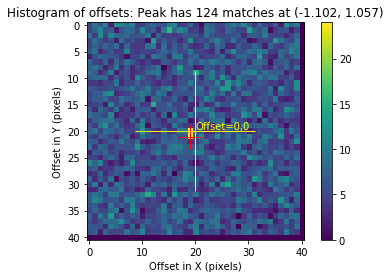

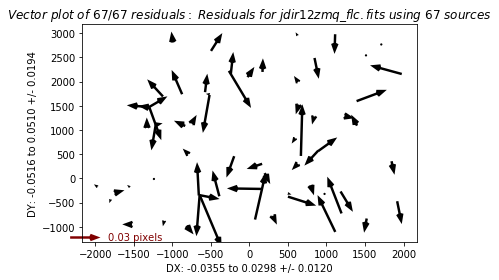

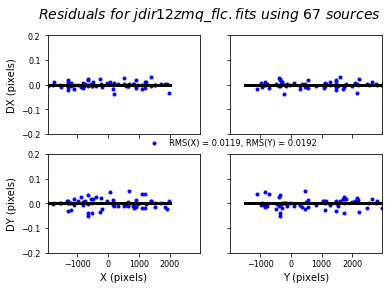

In [29]:
#aligned all pointing_1_814, fidgeted w jdir10 in separate notebook

#50, 30, 1 is p close
cw = 3.5
tweakreg.TweakReg(list(pointing_1_814_all), #input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  #refimage = 'pointing_1_814_drc_sci.fits',
                  refimage='jdir09r4q_flc.fits',
                  imagefindcfg={'threshold':120,'conv_width':cw, 'searchrad':3, 'use_sharp_round':False}, #60
                  refimagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':3, 'use_sharp_round':False}, #20
                  expand_refcat=True,
                 # xoffset = table["postarg1"],
                 # yoffset = table["postarg2"],
                  enforce_user_order=False,
                  minobj= 25,
                  separation=0.00001, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1,
                  ylimit = 0.2,
                  labelsize=8,
                  #tolerance = 1.2,
                  nclip = 5,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_1_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_1_814_shifts_new.txt', 
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit





'''tweakreg.TweakReg(list(pointing_1_814_all), #input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  refimage = 'jdir10w9q_flc.fits', #'jdir09r4q_flc.fits', 
                  imagefindcfg={'threshold':90,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False},
                  refimagefindcfg={'threshold':150,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False},
                  expand_refcat=True,
                 # xoffset = table["postarg1"],
                 # yoffset = table["postarg2"],
                  enforce_user_order=False,
                  minobj= 25,
                  separation=0.1, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
                  #tolerance = 1.2,
                  nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_1_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_1_814_shifts.txt', 
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit
'''

'''#100, 10, 1
tweakreg.TweakReg(list(pointing_1_814_all), #input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  refimage = 'jdir10w9q_flc.fits', #'jdir09r4q_flc.fits', 
                  imagefindcfg={'threshold':70,'conv_width':cw, 'searchrad':5},
                  refimagefindcfg={'threshold':250,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False},
                  expand_refcat=True,
                 # xoffset = table["postarg1"],
                 # yoffset = table["postarg2"],
                  enforce_user_order=False,
                  minobj= 25,
                  separation=0.1, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
                  #tolerance = 1.2,
                  nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_1_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_1_814_shifts.txt', 
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit'''


INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 13:43:56.502 (22/10/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 13:43:56.502 (22/10/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir10w4q_flc.fits', 'jdir10w9q_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir10w4q_flc.fits


    jdir10w4q_flc.fits


INFO:drizzlepac.tweakreg:    jdir10w9q_flc.fits


    jdir10w9q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir10w4q_flc.fits', 'jdir10w9q_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.t

===  Source finding for image 'jdir10w4q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10w4q_flc.fits', EXT=('SCI', 1) started at: 13:43:56.835 (22/10/2019)


  #  Source finding for 'jdir10w4q_flc.fits', EXT=('SCI', 1) started at: 13:43:56.835 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.777293
INFO:drizzlepac.catalogs:###Source finding finished at: 13:43:58.567 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 2349 objects.


     Found 2349 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10w4q_flc.fits', EXT=('SCI', 2) started at: 13:43:58.717 (22/10/2019)


  #  Source finding for 'jdir10w4q_flc.fits', EXT=('SCI', 2) started at: 13:43:58.717 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.844852
INFO:drizzlepac.catalogs:###Source finding finished at: 13:44:00.024 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 2526 objects.


     Found 2526 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir10w4q_flc.fits': 4875


===  FINAL number of objects in image 'jdir10w4q_flc.fits': 4875


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir10w9q_flc.fits':


===  Source finding for image 'jdir10w9q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10w9q_flc.fits', EXT=('SCI', 1) started at: 13:44:00.406 (22/10/2019)


  #  Source finding for 'jdir10w9q_flc.fits', EXT=('SCI', 1) started at: 13:44:00.406 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.275783
INFO:drizzlepac.catalogs:###Source finding finished at: 13:44:01.449 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1446 objects.


     Found 1446 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10w9q_flc.fits', EXT=('SCI', 2) started at: 13:44:01.550 (22/10/2019)


  #  Source finding for 'jdir10w9q_flc.fits', EXT=('SCI', 2) started at: 13:44:01.550 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.325347
INFO:drizzlepac.catalogs:###Source finding finished at: 13:44:02.904 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 1478 objects.


     Found 1478 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir10w9q_flc.fits': 2924


===  FINAL number of objects in image 'jdir10w9q_flc.fits': 2924


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir10w4q_flc.fits', 'jdir10w9q_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sh

===  Source finding for image 'jdir09r4q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 1) started at: 13:44:03.55 (22/10/2019)


  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 1) started at: 13:44:03.55 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.084555
INFO:drizzlepac.catalogs:###Source finding finished at: 13:44:04.59 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 8337 objects.


     Found 8337 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 2) started at: 13:44:04.773 (22/10/2019)


  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 2) started at: 13:44:04.773 (22/10/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.117480
INFO:drizzlepac.catalogs:###Source finding finished at: 13:44:05.769 (22/10/2019)
INFO:drizzlepac.catalogs:     Found 9002 objects.


     Found 9002 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09r4q_flc.fits': 17339


===  FINAL number of objects in image 'jdir09r4q_flc.fits': 17339


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir09r4q_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir09r4q_flc.fits'


derived from 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	10
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.0
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	o

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir10w4q_flc.fits


Performing fit for: jdir10w4q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir10w4q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir10w4q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.07645259938837867 -0.0030581039755332995


Found initial X and Y shifts of  -0.07645259938837867 -0.0030581039755332995


INFO:drizzlepac.tweakutils:    with significance of  453.77798705805634 and  29.0  matches


    with significance of  453.77798705805634 and  29.0  matches


INFO:drizzlepac.imgclasses:Found 92 matches for jdir10w4q_flc.fits...


Found 92 matches for jdir10w4q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir10w4q_flc.fits : 


Computed  general  fit for  jdir10w4q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0139  YSH: 0.0045    PROPER ROT: 0.001284010608    


XSH: 0.0139  YSH: 0.0045    PROPER ROT: 0.001284010608    


INFO:drizzlepac.imgclasses:<ROT>: 0.001284010608  SKEW: 0.001857531724    ROT_X: 0.0003552447462  ROT_Y: 0.00221277647


<ROT>: 0.001284010608  SKEW: 0.001857531724    ROT_X: 0.0003552447462  ROT_Y: 0.00221277647


INFO:drizzlepac.imgclasses:<SCALE>: 1.000014044  SCALE_X: 0.999999833  SCALE_Y: 1.000028256


<SCALE>: 1.000014044  SCALE_X: 0.999999833  SCALE_Y: 1.000028256


INFO:drizzlepac.imgclasses:XRMS: 0.04    YRMS: 0.037


XRMS: 0.04    YRMS: 0.037


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.7e-07 (deg)   RMS_DEC: 1.1e-07 (deg)


RMS_RA: 7.7e-07 (deg)   RMS_DEC: 1.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  30  objects.


Final solution based on  30  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir10w4q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir10w4q_flc_catalog_fit.match


wrote XY data to:  jdir10w4q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  30


Total # points:  30


INFO:drizzlepac.tweakutils:# of points after clipping:  30


# of points after clipping:  30


INFO:drizzlepac.tweakutils:Total # points:  30


Total # points:  30


INFO:drizzlepac.tweakutils:# of points after clipping:  30


# of points after clipping:  30


INFO:drizzlepac.imgclasses:Adding 4783 new sources to the reference catalog for a total of 22122 sources.


Adding 4783 new sources to the reference catalog for a total of 22122 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir10w4q_flc.fits...


....Updating header for jdir10w4q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10w4q_flc.fits['SCI',1]


Processing jdir10w4q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir10w4q_flc.fits[1]


Updating header for jdir10w4q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.033405211007509e-06 1.1194273628851524e-05


CD_11  CD_12: 9.033405211007509e-06 1.1194273628851524e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0489934347483776e-05 -8.363898509210701e-06


CD_21  CD_22: 1.0489934347483776e-05 -8.363898509210701e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05179721512607 14.486699006277147


CRVAL    : 210.05179721512607 14.486699006277147


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049836465092670264


Plate Scale : 0.049836465092670264


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.76556560477397


ORIENTAT : 126.76556560477397


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_2_wcs


WCSNAME  :  pointing_1_814_2_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10w4q_flc.fits['SCI',2]


Processing jdir10w4q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10w4q_flc.fits[4]


Updating header for jdir10w4q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.067114455265854e-06 1.0881280446783434e-05


CD_11  CD_12: 9.067114455265854e-06 1.0881280446783434e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.024567963899008e-05 -8.003368723951543e-06


CD_21  CD_22: 1.024567963899008e-05 -8.003368723951543e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07572745666533 14.469460108478811


CRVAL    : 210.07572745666533 14.469460108478811


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925386856415897


Plate Scale : 0.04925386856415897


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.33512062502659


ORIENTAT : 126.33512062502659


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_2_wcs


WCSNAME  :  pointing_1_814_2_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_2_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir10w9q_flc.fits


Performing fit for: jdir10w9q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir10w9q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir10w9q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.882022471910112 -0.3342696629213471


Found initial X and Y shifts of  -0.882022471910112 -0.3342696629213471


INFO:drizzlepac.tweakutils:    with significance of  713.2972732318553 and  77.0  matches


    with significance of  713.2972732318553 and  77.0  matches


INFO:drizzlepac.imgclasses:Found 193 matches for jdir10w9q_flc.fits...


Found 193 matches for jdir10w9q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir10w9q_flc.fits : 


Computed  general  fit for  jdir10w9q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0185  YSH: 0.0107    PROPER ROT: 0.001330190686    


XSH: 0.0185  YSH: 0.0107    PROPER ROT: 0.001330190686    


INFO:drizzlepac.imgclasses:<ROT>: 180.0013302  SKEW: 359.9946751    ROT_X: 0.003992654741  ROT_Y: 359.9986677


<ROT>: 180.0013302  SKEW: 359.9946751    ROT_X: 0.003992654741  ROT_Y: 359.9986677


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999450532  SCALE_X: 1.000014718  SCALE_Y: 0.999875398


<SCALE>: 0.9999450532  SCALE_X: 1.000014718  SCALE_Y: 0.999875398


INFO:drizzlepac.imgclasses:XRMS: 0.015    YRMS: 0.029


XRMS: 0.015    YRMS: 0.029


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.6e-07 (deg)   RMS_DEC: 8.7e-08 (deg)


RMS_RA: 4.6e-07 (deg)   RMS_DEC: 8.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  50  objects.


Final solution based on  50  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir10w9q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir10w9q_flc_catalog_fit.match


wrote XY data to:  jdir10w9q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  50


Total # points:  50


INFO:drizzlepac.tweakutils:# of points after clipping:  50


# of points after clipping:  50


INFO:drizzlepac.tweakutils:Total # points:  50


Total # points:  50


INFO:drizzlepac.tweakutils:# of points after clipping:  50


# of points after clipping:  50


INFO:drizzlepac.imgclasses:Adding 2731 new sources to the reference catalog for a total of 24853 sources.


Adding 2731 new sources to the reference catalog for a total of 24853 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir10w9q_flc.fits...


....Updating header for jdir10w9q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10w9q_flc.fits['SCI',1]


Processing jdir10w9q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10w9q_flc.fits[1]


Updating header for jdir10w9q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.033751756635202e-06 1.1195248796122432e-05


CD_11  CD_12: 9.033751756635202e-06 1.1195248796122432e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0489623384853988e-05 -8.36407970893696e-06


CD_21  CD_22: 1.0489623384853988e-05 -8.36407970893696e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0517970230588 14.486699029893508


CRVAL    : 210.0517970230588 14.486699029893508


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049836975645359174


Plate Scale : 0.049836975645359174


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.76376767905974


ORIENTAT : 126.76376767905974


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_2_wcs


WCSNAME  :  pointing_1_814_2_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10w9q_flc.fits['SCI',2]


Processing jdir10w9q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10w9q_flc.fits[4]


Updating header for jdir10w9q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.067469532606136e-06 1.0882225023834098e-05


CD_11  CD_12: 9.067469532606136e-06 1.0882225023834098e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.024537008751618e-05 -8.003546332243645e-06


CD_21  CD_22: 1.024537008751618e-05 -8.003546332243645e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0757293471527 14.46945975608228


CRVAL    : 210.0757293471527 14.46945975608228


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492543287639592


Plate Scale : 0.0492543287639592


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.33335365975883


ORIENTAT : 126.33335365975883


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_814_2_wcs


WCSNAME  :  pointing_1_814_2_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_814_2_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_1_814_2_shifts.txt


Writing out shiftfile : pointing_1_814_2_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


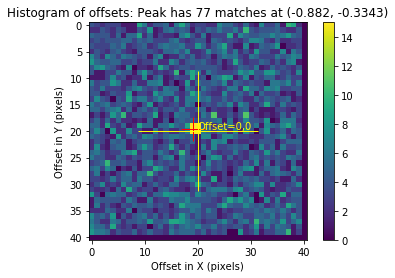

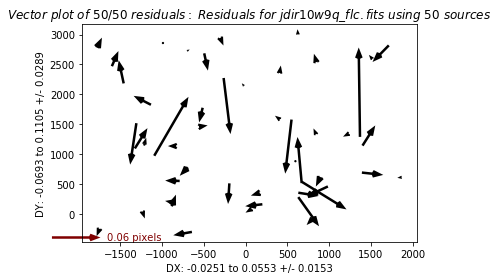

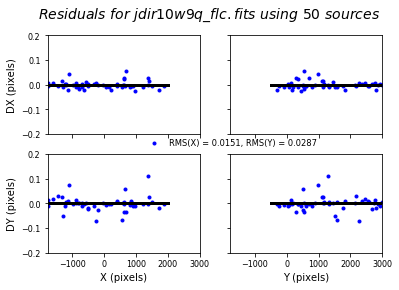

In [33]:
'''#50, 250, 1.1
tweakreg.TweakReg(list(the_10s), #input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  refimage='jdir09r4q_flc.fits', 
                  imagefindcfg={'threshold':120,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, #50
                  refimagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, #20
                  expand_refcat=True,
                 # xoffset = table["postarg1"],
                 # yoffset = table["postarg2"],
                  enforce_user_order=True,
                  minobj= 25,
                  separation=0, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
                  #tolerance = 1.2,
                  nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_1_814_2_wcs', # Give our WCS a new name
                  outshifts = 'pointing_1_814_2_shifts.txt', 
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 11:08:44.011 (03/11/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 11:08:44.011 (03/11/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 


3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 


INFO:drizzlepac.util:numpy Version -> 1.17.2 


numpy Version -> 1.17.2 


INFO:drizzlepac.util:astropy Version -> 3.2.2 


astropy Version -> 3.2.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.3 


stwcs Version -> 1.5.3 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir09qzq_flc.fits', 'jdir09r2q_flc.fits', 'jdir10veq_flc.fits', 'jdir10vhq_flc.fits', 'jdir11yaq_flc.fits', 'jdir11ydq_flc.fits', 'jdir12zcq_flc.fits', 'jdir12zfq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir09r2q_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir09qzq_flc.fits


    jdir09qzq_flc.fits


INFO:drizzlepac.tweakreg:    jdir09r2q_flc.fits


    jdir09r2q_flc.fits


INFO:drizzlepac.tweakreg:    jdir10veq_flc.fits


    jdir10veq_flc.fits


INFO:drizzlepac.tweakreg:    jdir10vhq_flc.fits


    jdir10vhq_flc.fits


INFO:drizzlepac.tweakreg:    jdir11yaq_flc.fits


    jdir11yaq_flc.fits


INFO:drizzlepac.tweakreg:    jdir11ydq_flc.fits


    jdir11ydq_flc.fits


INFO:drizzlepac.tweakreg:    jdir12zcq_flc.fits


    jdir12zcq_flc.fits


INFO:drizzlepac.tweakreg:    jdir12zfq_flc.fits


    jdir12zfq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir09qzq_flc.fits', 'jdir09r2q_flc.fits', 'jdir10veq_flc.fits', 'jdir10vhq_flc.fits', 'jdir11yaq_flc.fits', 'jdir11ydq_flc.fits', 'jdir12zcq_flc.fits', 'jdir12zfq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir09r2q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepa

===  Source finding for image 'jdir09qzq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09qzq_flc.fits', EXT=('SCI', 1) started at: 11:08:44.328 (03/11/2019)


  #  Source finding for 'jdir09qzq_flc.fits', EXT=('SCI', 1) started at: 11:08:44.328 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.889071
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:45.731 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 753 objects.


     Found 753 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09qzq_flc.fits', EXT=('SCI', 2) started at: 11:08:45.940 (03/11/2019)


  #  Source finding for 'jdir09qzq_flc.fits', EXT=('SCI', 2) started at: 11:08:45.940 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.915077
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:47.335 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 798 objects.


     Found 798 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09qzq_flc.fits': 1551


===  FINAL number of objects in image 'jdir09qzq_flc.fits': 1551


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir09r2q_flc.fits':


===  Source finding for image 'jdir09r2q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 1) started at: 11:08:47.700 (03/11/2019)


  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 1) started at: 11:08:47.700 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.264527
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:48.765 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 1479 objects.


     Found 1479 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 2) started at: 11:08:48.867 (03/11/2019)


  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 2) started at: 11:08:48.867 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.246938
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:49.94 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 1522 objects.


     Found 1522 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09r2q_flc.fits': 3001


===  FINAL number of objects in image 'jdir09r2q_flc.fits': 3001


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir10veq_flc.fits':


===  Source finding for image 'jdir10veq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10veq_flc.fits', EXT=('SCI', 1) started at: 11:08:50.325 (03/11/2019)


  #  Source finding for 'jdir10veq_flc.fits', EXT=('SCI', 1) started at: 11:08:50.325 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.449551
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:51.368 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 1090 objects.


     Found 1090 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10veq_flc.fits', EXT=('SCI', 2) started at: 11:08:51.456 (03/11/2019)


  #  Source finding for 'jdir10veq_flc.fits', EXT=('SCI', 2) started at: 11:08:51.456 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.535394
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:52.540 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 1154 objects.


     Found 1154 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir10veq_flc.fits': 2244


===  FINAL number of objects in image 'jdir10veq_flc.fits': 2244


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir10vhq_flc.fits':


===  Source finding for image 'jdir10vhq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10vhq_flc.fits', EXT=('SCI', 1) started at: 11:08:52.955 (03/11/2019)


  #  Source finding for 'jdir10vhq_flc.fits', EXT=('SCI', 1) started at: 11:08:52.955 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.811634
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:54.035 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 778 objects.


     Found 778 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10vhq_flc.fits', EXT=('SCI', 2) started at: 11:08:54.127 (03/11/2019)


  #  Source finding for 'jdir10vhq_flc.fits', EXT=('SCI', 2) started at: 11:08:54.127 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.840108
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:55.289 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 793 objects.


     Found 793 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir10vhq_flc.fits': 1571


===  FINAL number of objects in image 'jdir10vhq_flc.fits': 1571


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir11yaq_flc.fits':


===  Source finding for image 'jdir11yaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11yaq_flc.fits', EXT=('SCI', 1) started at: 11:08:55.5 (03/11/2019)


  #  Source finding for 'jdir11yaq_flc.fits', EXT=('SCI', 1) started at: 11:08:55.5 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.697304
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:56.827 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 643 objects.


     Found 643 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11yaq_flc.fits', EXT=('SCI', 2) started at: 11:08:56.924 (03/11/2019)


  #  Source finding for 'jdir11yaq_flc.fits', EXT=('SCI', 2) started at: 11:08:56.924 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.587412
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:57.985 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 746 objects.


     Found 746 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir11yaq_flc.fits': 1389


===  FINAL number of objects in image 'jdir11yaq_flc.fits': 1389


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir11ydq_flc.fits':


===  Source finding for image 'jdir11ydq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11ydq_flc.fits', EXT=('SCI', 1) started at: 11:08:58.361 (03/11/2019)


  #  Source finding for 'jdir11ydq_flc.fits', EXT=('SCI', 1) started at: 11:08:58.361 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.797102
INFO:drizzlepac.catalogs:###Source finding finished at: 11:08:59.603 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 837 objects.


     Found 837 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11ydq_flc.fits', EXT=('SCI', 2) started at: 11:08:59.723 (03/11/2019)


  #  Source finding for 'jdir11ydq_flc.fits', EXT=('SCI', 2) started at: 11:08:59.723 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.838094
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:00.773 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 915 objects.


     Found 915 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir11ydq_flc.fits': 1752


===  FINAL number of objects in image 'jdir11ydq_flc.fits': 1752


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir12zcq_flc.fits':


===  Source finding for image 'jdir12zcq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zcq_flc.fits', EXT=('SCI', 1) started at: 11:09:01.183 (03/11/2019)


  #  Source finding for 'jdir12zcq_flc.fits', EXT=('SCI', 1) started at: 11:09:01.183 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.100019
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:02.240 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 594 objects.


     Found 594 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zcq_flc.fits', EXT=('SCI', 2) started at: 11:09:02.32 (03/11/2019)


  #  Source finding for 'jdir12zcq_flc.fits', EXT=('SCI', 2) started at: 11:09:02.32 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.118779
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:03.387 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 630 objects.


     Found 630 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir12zcq_flc.fits': 1224


===  FINAL number of objects in image 'jdir12zcq_flc.fits': 1224


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir12zfq_flc.fits':


===  Source finding for image 'jdir12zfq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zfq_flc.fits', EXT=('SCI', 1) started at: 11:09:03.705 (03/11/2019)


  #  Source finding for 'jdir12zfq_flc.fits', EXT=('SCI', 1) started at: 11:09:03.705 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.888390
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:04.763 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 676 objects.


     Found 676 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zfq_flc.fits', EXT=('SCI', 2) started at: 11:09:04.850 (03/11/2019)


  #  Source finding for 'jdir12zfq_flc.fits', EXT=('SCI', 2) started at: 11:09:04.850 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.825931
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:05.879 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 773 objects.


     Found 773 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir12zfq_flc.fits': 1449


===  FINAL number of objects in image 'jdir12zfq_flc.fits': 1449


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir09qzq_flc.fits', 'jdir09r2q_flc.fits', 'jdir10veq_flc.fits', 'jdir10vhq_flc.fits', 'jdir11yaq_flc.fits', 'jdir11ydq_flc.fits', 'jdir12zcq_flc.fits', 'jdir12zfq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir09r2q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	

===  Source finding for image 'jdir09r2q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 1) started at: 11:09:06.302 (03/11/2019)


  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 1) started at: 11:09:06.302 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.264527
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:07.279 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 12251 objects.


     Found 12251 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 2) started at: 11:09:07.463 (03/11/2019)


  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 2) started at: 11:09:07.463 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.246938
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:08.541 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 13040 objects.


     Found 13040 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09r2q_flc.fits': 25291


===  FINAL number of objects in image 'jdir09r2q_flc.fits': 25291


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir09r2q_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir09r2q_flc.fits'


derived from 'jdir09r2q_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.1
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	10
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.0
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir09qzq_flc.fits


Performing fit for: jdir09qzq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir09qzq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


Matching sources from 'jdir09qzq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.8981481481481488 -0.15277777777777857


Found initial X and Y shifts of  -0.8981481481481488 -0.15277777777777857


INFO:drizzlepac.tweakutils:    with significance of  548.474746861882 and  43.0  matches


    with significance of  548.474746861882 and  43.0  matches


INFO:drizzlepac.imgclasses:Found 122 matches for jdir09qzq_flc.fits...


Found 122 matches for jdir09qzq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir09qzq_flc.fits : 


Computed  general  fit for  jdir09qzq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0022  YSH: -0.0024    PROPER ROT: 359.9998552    


XSH: -0.0022  YSH: -0.0024    PROPER ROT: 359.9998552    


INFO:drizzlepac.imgclasses:<ROT>: 359.9998552  SKEW: -4.660068026e-05    ROT_X: 359.9998785  ROT_Y: 359.9998319


<ROT>: 359.9998552  SKEW: -4.660068026e-05    ROT_X: 359.9998785  ROT_Y: 359.9998319


INFO:drizzlepac.imgclasses:<SCALE>: 1.000024994  SCALE_X: 1.000020344  SCALE_Y: 1.000029644


<SCALE>: 1.000024994  SCALE_X: 1.000020344  SCALE_Y: 1.000029644


INFO:drizzlepac.imgclasses:XRMS: 0.015    YRMS: 0.008


XRMS: 0.015    YRMS: 0.008


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.2e-07 (deg)   RMS_DEC: 8.7e-08 (deg)


RMS_RA: 2.2e-07 (deg)   RMS_DEC: 8.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  33  objects.


Final solution based on  33  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir09qzq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir09qzq_flc_catalog_fit.match


wrote XY data to:  jdir09qzq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  33


Total # points:  33


INFO:drizzlepac.tweakutils:# of points after clipping:  33


# of points after clipping:  33


INFO:drizzlepac.tweakutils:Total # points:  33


Total # points:  33


INFO:drizzlepac.tweakutils:# of points after clipping:  33


# of points after clipping:  33


INFO:drizzlepac.imgclasses:Adding 1429 new sources to the reference catalog for a total of 26720 sources.


Adding 1429 new sources to the reference catalog for a total of 26720 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir09qzq_flc.fits...


....Updating header for jdir09qzq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir09qzq_flc.fits['SCI',1]


Processing jdir09qzq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir09qzq_flc.fits[1]


Updating header for jdir09qzq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.028004120037874e-06 1.1198717007202467e-05


CD_11  CD_12: 9.028004120037874e-06 1.1198717007202467e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494713815554542e-05 -8.357945538210569e-06


CD_21  CD_22: 1.0494713815554542e-05 -8.357945538210569e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0526683575726 14.48623827530838


CRVAL    : 210.0526683575726 14.48623827530838


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983779303606422


Plate Scale : 0.04983779303606422


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73510732537217


ORIENTAT : 126.73510732537217


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir09qzq_flc.fits['SCI',2]


Processing jdir09qzq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir09qzq_flc.fits[4]


Updating header for jdir09qzq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.061906266195577e-06 1.0885666029480098e-05


CD_11  CD_12: 9.061906266195577e-06 1.0885666029480098e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250522787405514e-05 -7.997516226716112e-06


CD_21  CD_22: 1.0250522787405514e-05 -7.997516226716112e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07660760240222 14.469012065631436


CRVAL    : 210.07660760240222 14.469012065631436


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049255443159190816


Plate Scale : 0.049255443159190816


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30410074047126


ORIENTAT : 126.30410074047126


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir09r2q_flc.fits


Performing fit for: jdir09r2q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir09r2q_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


Matching sources from 'jdir09r2q_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


INFO:drizzlepac.imgclasses:NO fit performed for reference image: jdir09r2q_flc.fits

INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir10veq_flc.fits


Performing fit for: jdir10veq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir10veq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


Matching sources from 'jdir10veq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  5.1659574468085125 7.01276595744681


Found initial X and Y shifts of  5.1659574468085125 7.01276595744681


INFO:drizzlepac.tweakutils:    with significance of  312.9217154497272 and  60.0  matches


    with significance of  312.9217154497272 and  60.0  matches


INFO:drizzlepac.imgclasses:Found 83 matches for jdir10veq_flc.fits...


Found 83 matches for jdir10veq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir10veq_flc.fits : 


Computed  general  fit for  jdir10veq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 5.3370  YSH: 7.7402    PROPER ROT: 0.0001963279956    


XSH: 5.3370  YSH: 7.7402    PROPER ROT: 0.0001963279956    


INFO:drizzlepac.imgclasses:<ROT>: 180.0001963  SKEW: -359.9990571    ROT_X: 359.9997249  ROT_Y: 0.0006677929149


<ROT>: 180.0001963  SKEW: -359.9990571    ROT_X: 359.9997249  ROT_Y: 0.0006677929149


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999996975  SCALE_X: 0.9999958427  SCALE_Y: 1.000003553


<SCALE>: 0.9999996975  SCALE_X: 0.9999958427  SCALE_Y: 1.000003553


INFO:drizzlepac.imgclasses:XRMS: 0.021    YRMS: 0.028


XRMS: 0.021    YRMS: 0.028


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5e-07 (deg)   RMS_DEC: 2e-08 (deg)


RMS_RA: 5e-07 (deg)   RMS_DEC: 2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  27  objects.


Final solution based on  27  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir10veq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir10veq_flc_catalog_fit.match


wrote XY data to:  jdir10veq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  27


Total # points:  27


INFO:drizzlepac.tweakutils:# of points after clipping:  27


# of points after clipping:  27


INFO:drizzlepac.tweakutils:Total # points:  27


Total # points:  27


INFO:drizzlepac.tweakutils:# of points after clipping:  27


# of points after clipping:  27


INFO:drizzlepac.imgclasses:Adding 2161 new sources to the reference catalog for a total of 28881 sources.


Adding 2161 new sources to the reference catalog for a total of 28881 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir10veq_flc.fits


Initializing new WCSCORR table for  jdir10veq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir10veq_flc.fits...


....Updating header for jdir10veq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10veq_flc.fits['SCI',1]


Processing jdir10veq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10veq_flc.fits[1]


Updating header for jdir10veq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.027970171424483e-06 1.1198665196826575e-05


CD_11  CD_12: 9.027970171424483e-06 1.1198665196826575e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494744619660148e-05 -8.358095876964613e-06


CD_21  CD_22: 1.0494744619660148e-05 -8.358095876964613e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05180369996913 14.486686501290352


CRVAL    : 210.05180369996913 14.486686501290352


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983660192636547


Plate Scale : 0.04983660192636547


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73572839199052


ORIENTAT : 126.73572839199052


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10veq_flc.fits['SCI',2]


Processing jdir10veq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10veq_flc.fits[4]


Updating header for jdir10veq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.061874746024347e-06 1.0885615593178654e-05


CD_11  CD_12: 9.061874746024347e-06 1.0885615593178654e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250550098375279e-05 -7.997660968640473e-06


CD_21  CD_22: 1.0250550098375279e-05 -7.997660968640473e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07574288227792 14.46945998124329


CRVAL    : 210.07574288227792 14.46945998124329


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925427138839069


Plate Scale : 0.04925427138839069


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30472218036262


ORIENTAT : 126.30472218036262


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir10vhq_flc.fits


Performing fit for: jdir10vhq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir10vhq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


Matching sources from 'jdir10vhq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  5.067415730337078 7.228464419475657


Found initial X and Y shifts of  5.067415730337078 7.228464419475657


INFO:drizzlepac.tweakutils:    with significance of  798.4359711335657 and  85.0  matches


    with significance of  798.4359711335657 and  85.0  matches


INFO:drizzlepac.imgclasses:Found 138 matches for jdir10vhq_flc.fits...


Found 138 matches for jdir10vhq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir10vhq_flc.fits : 


Computed  general  fit for  jdir10vhq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 5.2437  YSH: 7.9483    PROPER ROT: 0.003111723494    


XSH: 5.2437  YSH: 7.9483    PROPER ROT: 0.003111723494    


INFO:drizzlepac.imgclasses:<ROT>: 0.003111723494  SKEW: -0.003240229053    ROT_X: 0.004731838021  ROT_Y: 0.001491608968


<ROT>: 0.003111723494  SKEW: -0.003240229053    ROT_X: 0.004731838021  ROT_Y: 0.001491608968


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999620365  SCALE_X: 0.9999933255  SCALE_Y: 0.9999307501


<SCALE>: 0.9999620365  SCALE_X: 0.9999933255  SCALE_Y: 0.9999307501


INFO:drizzlepac.imgclasses:XRMS: 0.028    YRMS: 0.073


XRMS: 0.028    YRMS: 0.073


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-06 (deg)   RMS_DEC: 3.4e-07 (deg)


RMS_RA: 1.1e-06 (deg)   RMS_DEC: 3.4e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  24  objects.


Final solution based on  24  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir10vhq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir10vhq_flc_catalog_fit.match


wrote XY data to:  jdir10vhq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  24


Total # points:  24


INFO:drizzlepac.tweakutils:# of points after clipping:  24


# of points after clipping:  24


INFO:drizzlepac.tweakutils:Total # points:  24


Total # points:  24


INFO:drizzlepac.tweakutils:# of points after clipping:  24


# of points after clipping:  24


INFO:drizzlepac.imgclasses:Adding 1433 new sources to the reference catalog for a total of 30315 sources.


Adding 1433 new sources to the reference catalog for a total of 30315 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir10vhq_flc.fits


Initializing new WCSCORR table for  jdir10vhq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir10vhq_flc.fits...


....Updating header for jdir10vhq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10vhq_flc.fits['SCI',1]


Processing jdir10vhq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10vhq_flc.fits[1]


Updating header for jdir10vhq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.028651942170326e-06 1.1198995770661489e-05


CD_11  CD_12: 9.028651942170326e-06 1.1198995770661489e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0493639141607763e-05 -8.358643477873584e-06


CD_21  CD_22: 1.0493639141607763e-05 -8.358643477873584e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05180213675484 14.48668940912236


CRVAL    : 210.05180213675484 14.48668940912236


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983494857381947


Plate Scale : 0.04983494857381947


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73671701350288


ORIENTAT : 126.73671701350288


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10vhq_flc.fits['SCI',2]


Processing jdir10vhq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10vhq_flc.fits[4]


Updating header for jdir10vhq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.062552162647574e-06 1.088593994144705e-05


CD_11  CD_12: 9.062552162647574e-06 1.088593994144705e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0249451311823269e-05 -7.99819836710834e-06


CD_21  CD_22: 1.0249451311823269e-05 -7.99819836710834e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07574202771593 14.469461752611595


CRVAL    : 210.07574202771593 14.469461752611595


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925263735493225


Plate Scale : 0.04925263735493225


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.3057445486227


ORIENTAT : 126.3057445486227


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir11yaq_flc.fits


Performing fit for: jdir11yaq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir11yaq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


Matching sources from 'jdir11yaq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.0320855614973254 -2.048128342245988


Found initial X and Y shifts of  -1.0320855614973254 -2.048128342245988


INFO:drizzlepac.tweakutils:    with significance of  500.6431991980175 and  38.0  matches


    with significance of  500.6431991980175 and  38.0  matches


INFO:drizzlepac.imgclasses:Found 81 matches for jdir11yaq_flc.fits...


Found 81 matches for jdir11yaq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir11yaq_flc.fits : 


Computed  general  fit for  jdir11yaq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2159  YSH: -1.9637    PROPER ROT: 0.004259881332    


XSH: -0.2159  YSH: -1.9637    PROPER ROT: 0.004259881332    


INFO:drizzlepac.imgclasses:<ROT>: 0.004259881332  SKEW: 0.002938001771    ROT_X: 0.002790880446  ROT_Y: 0.005728882217


<ROT>: 0.004259881332  SKEW: 0.002938001771    ROT_X: 0.002790880446  ROT_Y: 0.005728882217


INFO:drizzlepac.imgclasses:<SCALE>: 1.000023766  SCALE_X: 1.000014047  SCALE_Y: 1.000033486


<SCALE>: 1.000023766  SCALE_X: 1.000014047  SCALE_Y: 1.000033486


INFO:drizzlepac.imgclasses:XRMS: 0.033    YRMS: 0.031


XRMS: 0.033    YRMS: 0.031


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.5e-07 (deg)   RMS_DEC: 8.7e-08 (deg)


RMS_RA: 6.5e-07 (deg)   RMS_DEC: 8.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  27  objects.


Final solution based on  27  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir11yaq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir11yaq_flc_catalog_fit.match


wrote XY data to:  jdir11yaq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  27


Total # points:  27


INFO:drizzlepac.tweakutils:# of points after clipping:  27


# of points after clipping:  27


INFO:drizzlepac.tweakutils:Total # points:  27


Total # points:  27


INFO:drizzlepac.tweakutils:# of points after clipping:  27


# of points after clipping:  27


INFO:drizzlepac.imgclasses:Adding 1308 new sources to the reference catalog for a total of 31624 sources.


Adding 1308 new sources to the reference catalog for a total of 31624 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir11yaq_flc.fits


Initializing new WCSCORR table for  jdir11yaq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir11yaq_flc.fits...


....Updating header for jdir11yaq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11yaq_flc.fits['SCI',1]


Processing jdir11yaq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11yaq_flc.fits[1]


Updating header for jdir11yaq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.02839497931663e-06 1.1197547302478692e-05


CD_11  CD_12: 9.02839497931663e-06 1.1197547302478692e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494024845735805e-05 -8.35886057687711e-06


CD_21  CD_22: 1.0494024845735805e-05 -8.35886057687711e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0526500739723 14.486176872221774


CRVAL    : 210.0526500739723 14.486176872221774


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983659452000191


Plate Scale : 0.04983659452000191


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.74098287997151


ORIENTAT : 126.74098287997151


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11yaq_flc.fits['SCI',2]


Processing jdir11yaq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11yaq_flc.fits[4]


Updating header for jdir11yaq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.062279251600234e-06 1.0884538733267823e-05


CD_11  CD_12: 9.062279251600234e-06 1.0884538733267823e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0249829444323214e-05 -7.998404816534654e-06


CD_21  CD_22: 1.0249829444323214e-05 -7.998404816534654e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07658681742714 14.468948769182036


CRVAL    : 210.07658681742714 14.468948769182036


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254264180098914


Plate Scale : 0.049254264180098914


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30996949024411


ORIENTAT : 126.30996949024411


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir11ydq_flc.fits


Performing fit for: jdir11ydq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir11ydq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


Matching sources from 'jdir11ydq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.8989547038327537 -2.2299651567944245


Found initial X and Y shifts of  -0.8989547038327537 -2.2299651567944245


INFO:drizzlepac.tweakutils:    with significance of  662.3509643685892 and  67.0  matches


    with significance of  662.3509643685892 and  67.0  matches


INFO:drizzlepac.imgclasses:Found 142 matches for jdir11ydq_flc.fits...


Found 142 matches for jdir11ydq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir11ydq_flc.fits : 


Computed  general  fit for  jdir11ydq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2187  YSH: -1.9614    PROPER ROT: 0.004559706945    


XSH: -0.2187  YSH: -1.9614    PROPER ROT: 0.004559706945    


INFO:drizzlepac.imgclasses:<ROT>: 0.004559706945  SKEW: -0.00342380382    ROT_X: 0.006271608856  ROT_Y: 0.002847805035


<ROT>: 0.004559706945  SKEW: -0.00342380382    ROT_X: 0.006271608856  ROT_Y: 0.002847805035


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999607594  SCALE_X: 0.999956905  SCALE_Y: 0.9999646157


<SCALE>: 0.9999607594  SCALE_X: 0.999956905  SCALE_Y: 0.9999646157


INFO:drizzlepac.imgclasses:XRMS: 0.014    YRMS: 0.032


XRMS: 0.014    YRMS: 0.032


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.9e-07 (deg)   RMS_DEC: 1.3e-07 (deg)


RMS_RA: 4.9e-07 (deg)   RMS_DEC: 1.3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  42  objects.


Final solution based on  42  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir11ydq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir11ydq_flc_catalog_fit.match


wrote XY data to:  jdir11ydq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.imgclasses:Adding 1610 new sources to the reference catalog for a total of 33235 sources.


Adding 1610 new sources to the reference catalog for a total of 33235 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir11ydq_flc.fits


Initializing new WCSCORR table for  jdir11ydq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir11ydq_flc.fits...


....Updating header for jdir11ydq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11ydq_flc.fits['SCI',1]


Processing jdir11ydq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11ydq_flc.fits[1]


Updating header for jdir11ydq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.0292811399222e-06 1.1198410274408023e-05


CD_11  CD_12: 9.0292811399222e-06 1.1198410274408023e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0493760037517554e-05 -8.358638956111994e-06


CD_21  CD_22: 1.0493760037517554e-05 -8.358638956111994e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05265003989703 14.486176920370804


CRVAL    : 210.05265003989703 14.486176920370804


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983493900661989


Plate Scale : 0.04983493900661989


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73813807353534


ORIENTAT : 126.73813807353534


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11ydq_flc.fits['SCI',2]


Processing jdir11ydq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11ydq_flc.fits[4]


Updating header for jdir11ydq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.06316560978051e-06 1.0885378992788783e-05


CD_11  CD_12: 9.06316560978051e-06 1.0885378992788783e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0249570711765684e-05 -7.998192886932198e-06


CD_21  CD_22: 1.0249570711765684e-05 -7.998192886932198e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07658862895565 14.468949273906446


CRVAL    : 210.07658862895565 14.468949273906446


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925262801104948


Plate Scale : 0.04925262801104948


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30713461668728


ORIENTAT : 126.30713461668728


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir12zcq_flc.fits


Performing fit for: jdir12zcq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir12zcq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


Matching sources from 'jdir12zcq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.7459459459459445 0.1243243243243235


Found initial X and Y shifts of  -0.7459459459459445 0.1243243243243235


INFO:drizzlepac.tweakutils:    with significance of  669.4031456667734 and  48.0  matches


    with significance of  669.4031456667734 and  48.0  matches


INFO:drizzlepac.imgclasses:Found 75 matches for jdir12zcq_flc.fits...


Found 75 matches for jdir12zcq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir12zcq_flc.fits : 


Computed  general  fit for  jdir12zcq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1658  YSH: 0.9405    PROPER ROT: 359.9970436    


XSH: -0.1658  YSH: 0.9405    PROPER ROT: 359.9970436    


INFO:drizzlepac.imgclasses:<ROT>: 359.9970436  SKEW: 0.0004487170957    ROT_X: 359.9968192  ROT_Y: 359.9972679


<ROT>: 359.9970436  SKEW: 0.0004487170957    ROT_X: 359.9968192  ROT_Y: 359.9972679


INFO:drizzlepac.imgclasses:<SCALE>: 1.00000033  SCALE_X: 1.000005139  SCALE_Y: 0.9999955208


<SCALE>: 1.00000033  SCALE_X: 1.000005139  SCALE_Y: 0.9999955208


INFO:drizzlepac.imgclasses:XRMS: 0.024    YRMS: 0.033


XRMS: 0.024    YRMS: 0.033


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.9e-07 (deg)   RMS_DEC: 2.9e-08 (deg)


RMS_RA: 5.9e-07 (deg)   RMS_DEC: 2.9e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  25  objects.


Final solution based on  25  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir12zcq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir12zcq_flc_catalog_fit.match


wrote XY data to:  jdir12zcq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  25


Total # points:  25


INFO:drizzlepac.tweakutils:# of points after clipping:  25


# of points after clipping:  25


INFO:drizzlepac.tweakutils:Total # points:  25


Total # points:  25


INFO:drizzlepac.tweakutils:# of points after clipping:  25


# of points after clipping:  25


INFO:drizzlepac.imgclasses:Adding 1149 new sources to the reference catalog for a total of 34386 sources.


Adding 1149 new sources to the reference catalog for a total of 34386 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir12zcq_flc.fits


Initializing new WCSCORR table for  jdir12zcq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir12zcq_flc.fits...


....Updating header for jdir12zcq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zcq_flc.fits['SCI',1]


Processing jdir12zcq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zcq_flc.fits[1]


Updating header for jdir12zcq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.027327750345645e-06 1.1199274242704443e-05


CD_11  CD_12: 9.027327750345645e-06 1.1199274242704443e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.049512942803022e-05 -8.35747224354659e-06


CD_21  CD_22: 1.049512942803022e-05 -8.35747224354659e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05119898896345 14.48712457236645


CRVAL    : 210.05119898896345 14.48712457236645


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983659368963783


Plate Scale : 0.04983659368963783


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73218555512452


ORIENTAT : 126.73218555512452


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zcq_flc.fits['SCI',2]


Processing jdir12zcq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zcq_flc.fits[4]


Updating header for jdir12zcq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.06124866210379e-06 1.0886199145298698e-05


CD_11  CD_12: 9.06124866210379e-06 1.0886199145298698e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.025093821306343e-05 -7.997055711376843e-06


CD_21  CD_22: 1.025093821306343e-05 -7.997055711376843e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0751395154779 14.46989934249326


CRVAL    : 210.0751395154779 14.46989934249326


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492542634359782


Plate Scale : 0.0492542634359782


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30118771422057


ORIENTAT : 126.30118771422057


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir12zfq_flc.fits


Performing fit for: jdir12zfq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir12zfq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


Matching sources from 'jdir12zfq_flc.fits' with sources from reference image 'jdir09r2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.0150943396226424 0.14339622641509564


Found initial X and Y shifts of  -1.0150943396226424 0.14339622641509564


INFO:drizzlepac.tweakutils:    with significance of  961.9480235438918 and  98.0  matches


    with significance of  961.9480235438918 and  98.0  matches


INFO:drizzlepac.imgclasses:Found 142 matches for jdir12zfq_flc.fits...


Found 142 matches for jdir12zfq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir12zfq_flc.fits : 


Computed  general  fit for  jdir12zfq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1789  YSH: 0.9497    PROPER ROT: 359.9972857    


XSH: -0.1789  YSH: 0.9497    PROPER ROT: 359.9972857    


INFO:drizzlepac.imgclasses:<ROT>: 359.9972857  SKEW: -0.0009082320824    ROT_X: 359.9977398  ROT_Y: 359.9968316


<ROT>: 359.9972857  SKEW: -0.0009082320824    ROT_X: 359.9977398  ROT_Y: 359.9968316


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999797461  SCALE_X: 0.9999789785  SCALE_Y: 0.9999805138


<SCALE>: 0.9999797461  SCALE_X: 0.9999789785  SCALE_Y: 0.9999805138


INFO:drizzlepac.imgclasses:XRMS: 0.015    YRMS: 0.028


XRMS: 0.015    YRMS: 0.028


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.5e-07 (deg)   RMS_DEC: 7.7e-08 (deg)


RMS_RA: 4.5e-07 (deg)   RMS_DEC: 7.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  45  objects.


Final solution based on  45  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir12zfq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir12zfq_flc_catalog_fit.match


wrote XY data to:  jdir12zfq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  45


Total # points:  45


INFO:drizzlepac.tweakutils:# of points after clipping:  45


# of points after clipping:  45


INFO:drizzlepac.tweakutils:Total # points:  45


Total # points:  45


INFO:drizzlepac.tweakutils:# of points after clipping:  45


# of points after clipping:  45


INFO:drizzlepac.imgclasses:Adding 1307 new sources to the reference catalog for a total of 35694 sources.


Adding 1307 new sources to the reference catalog for a total of 35694 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir12zfq_flc.fits


Initializing new WCSCORR table for  jdir12zfq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir12zfq_flc.fits...


....Updating header for jdir12zfq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zfq_flc.fits['SCI',1]


Processing jdir12zfq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zfq_flc.fits[1]


Updating header for jdir12zfq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.027435050285932e-06 1.1199147740273175e-05


CD_11  CD_12: 9.027435050285932e-06 1.1199147740273175e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494920561508435e-05 -8.357238017540837e-06


CD_21  CD_22: 1.0494920561508435e-05 -8.357238017540837e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05119895938623 14.487124795315621


CRVAL    : 210.05119895938623 14.487124795315621


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983493718915776


Plate Scale : 0.04983493718915776


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73172608004134


ORIENTAT : 126.73172608004134


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zfq_flc.fits['SCI',2]


Processing jdir12zfq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zfq_flc.fits[4]


Updating header for jdir12zfq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.061352932472623e-06 1.0886077752514532e-05


CD_11  CD_12: 9.061352932472623e-06 1.0886077752514532e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250735052988535e-05 -7.996831004108666e-06


CD_21  CD_22: 1.0250735052988535e-05 -7.996831004108666e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07513921644903 14.469900048513948


CRVAL    : 210.07513921644903 14.469900048513948


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049252626291362345


Plate Scale : 0.049252626291362345


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30072440207616


ORIENTAT : 126.30072440207616


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_wcs


WCSNAME  :  pointing_1_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_1_606_shifts.txt


Writing out shiftfile : pointing_1_606_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


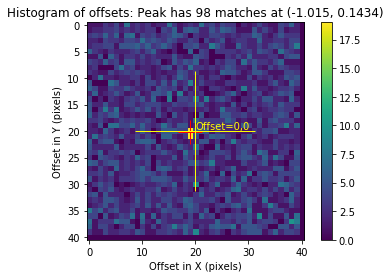

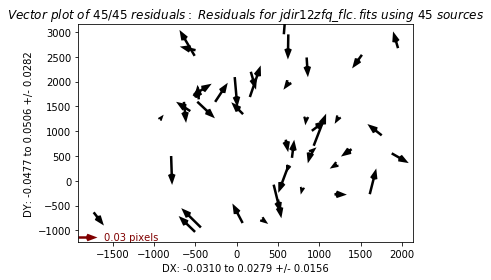

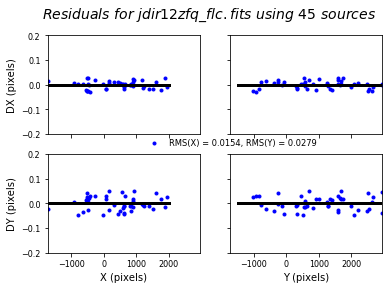

In [4]:

cw = 3.5


#150, 1 p good
tweakreg.TweakReg(list(pointing_1_606), #input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  refimage = 'jdir09r2q_flc.fits', 
                  imagefindcfg={'threshold':150,'conv_width':cw, 'searchrad':5},
                  refimagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5},
                  expand_refcat=True,
                 # xoffset = table["postarg1"],
                 # yoffset = table["postarg2"],
                  enforce_user_order=True,
                  minobj= 25,
                  separation=0.1, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
                  #tolerance = 1.2,
                  nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_1_606_wcs', # Give our WCS a new name
                  outshifts = 'pointing_1_606_shifts.txt', 
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 12:02:07.372 (03/11/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 12:02:07.372 (03/11/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 


3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 


INFO:drizzlepac.util:numpy Version -> 1.17.2 


numpy Version -> 1.17.2 


INFO:drizzlepac.util:astropy Version -> 3.2.2 


astropy Version -> 3.2.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.3 


stwcs Version -> 1.5.3 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir09qzq_flc.fits', 'jdir09r2q_flc.fits', 'jdir10veq_flc.fits', 'jdir10vhq_flc.fits', 'jdir11yaq_flc.fits', 'jdir11ydq_flc.fits', 'jdir12zcq_flc.fits', 'jdir12zfq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir09qzq_flc.fits


    jdir09qzq_flc.fits


INFO:drizzlepac.tweakreg:    jdir09r2q_flc.fits


    jdir09r2q_flc.fits


INFO:drizzlepac.tweakreg:    jdir10veq_flc.fits


    jdir10veq_flc.fits


INFO:drizzlepac.tweakreg:    jdir10vhq_flc.fits


    jdir10vhq_flc.fits


INFO:drizzlepac.tweakreg:    jdir11yaq_flc.fits


    jdir11yaq_flc.fits


INFO:drizzlepac.tweakreg:    jdir11ydq_flc.fits


    jdir11ydq_flc.fits


INFO:drizzlepac.tweakreg:    jdir12zcq_flc.fits


    jdir12zcq_flc.fits


INFO:drizzlepac.tweakreg:    jdir12zfq_flc.fits


    jdir12zfq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir09qzq_flc.fits', 'jdir09r2q_flc.fits', 'jdir10veq_flc.fits', 'jdir10vhq_flc.fits', 'jdir11yaq_flc.fits', 'jdir11ydq_flc.fits', 'jdir12zcq_flc.fits', 'jdir12zfq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepa

===  Source finding for image 'jdir09qzq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09qzq_flc.fits', EXT=('SCI', 1) started at: 12:02:07.767 (03/11/2019)


  #  Source finding for 'jdir09qzq_flc.fits', EXT=('SCI', 1) started at: 12:02:07.767 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.889071
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:09.472 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 753 objects.


     Found 753 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09qzq_flc.fits', EXT=('SCI', 2) started at: 12:02:09.743 (03/11/2019)


  #  Source finding for 'jdir09qzq_flc.fits', EXT=('SCI', 2) started at: 12:02:09.743 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.915077
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:11.177 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 798 objects.


     Found 798 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09qzq_flc.fits': 1551


===  FINAL number of objects in image 'jdir09qzq_flc.fits': 1551


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir09r2q_flc.fits':


===  Source finding for image 'jdir09r2q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 1) started at: 12:02:11.665 (03/11/2019)


  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 1) started at: 12:02:11.665 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.264527
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:12.768 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 1479 objects.


     Found 1479 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 2) started at: 12:02:12.889 (03/11/2019)


  #  Source finding for 'jdir09r2q_flc.fits', EXT=('SCI', 2) started at: 12:02:12.889 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.246938
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:14.017 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 1522 objects.


     Found 1522 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09r2q_flc.fits': 3001


===  FINAL number of objects in image 'jdir09r2q_flc.fits': 3001


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir10veq_flc.fits':


===  Source finding for image 'jdir10veq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10veq_flc.fits', EXT=('SCI', 1) started at: 12:02:14.409 (03/11/2019)


  #  Source finding for 'jdir10veq_flc.fits', EXT=('SCI', 1) started at: 12:02:14.409 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.449551
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:15.61 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 1090 objects.


     Found 1090 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10veq_flc.fits', EXT=('SCI', 2) started at: 12:02:15.758 (03/11/2019)


  #  Source finding for 'jdir10veq_flc.fits', EXT=('SCI', 2) started at: 12:02:15.758 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.535394
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:16.990 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 1154 objects.


     Found 1154 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir10veq_flc.fits': 2244


===  FINAL number of objects in image 'jdir10veq_flc.fits': 2244


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir10vhq_flc.fits':


===  Source finding for image 'jdir10vhq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10vhq_flc.fits', EXT=('SCI', 1) started at: 12:02:17.375 (03/11/2019)


  #  Source finding for 'jdir10vhq_flc.fits', EXT=('SCI', 1) started at: 12:02:17.375 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.811634
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:18.454 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 778 objects.


     Found 778 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir10vhq_flc.fits', EXT=('SCI', 2) started at: 12:02:18.574 (03/11/2019)


  #  Source finding for 'jdir10vhq_flc.fits', EXT=('SCI', 2) started at: 12:02:18.574 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.840108
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:19.702 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 793 objects.


     Found 793 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir10vhq_flc.fits': 1571


===  FINAL number of objects in image 'jdir10vhq_flc.fits': 1571


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir11yaq_flc.fits':


===  Source finding for image 'jdir11yaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11yaq_flc.fits', EXT=('SCI', 1) started at: 12:02:20.003 (03/11/2019)


  #  Source finding for 'jdir11yaq_flc.fits', EXT=('SCI', 1) started at: 12:02:20.003 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.697304
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:21.050 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 643 objects.


     Found 643 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11yaq_flc.fits', EXT=('SCI', 2) started at: 12:02:21.145 (03/11/2019)


  #  Source finding for 'jdir11yaq_flc.fits', EXT=('SCI', 2) started at: 12:02:21.145 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.587412
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:22.200 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 746 objects.


     Found 746 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir11yaq_flc.fits': 1389


===  FINAL number of objects in image 'jdir11yaq_flc.fits': 1389


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir11ydq_flc.fits':


===  Source finding for image 'jdir11ydq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11ydq_flc.fits', EXT=('SCI', 1) started at: 12:02:22.531 (03/11/2019)


  #  Source finding for 'jdir11ydq_flc.fits', EXT=('SCI', 1) started at: 12:02:22.531 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.797102
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:23.674 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 837 objects.


     Found 837 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir11ydq_flc.fits', EXT=('SCI', 2) started at: 12:02:23.779 (03/11/2019)


  #  Source finding for 'jdir11ydq_flc.fits', EXT=('SCI', 2) started at: 12:02:23.779 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.838094
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:24.936 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 915 objects.


     Found 915 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir11ydq_flc.fits': 1752


===  FINAL number of objects in image 'jdir11ydq_flc.fits': 1752


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir12zcq_flc.fits':


===  Source finding for image 'jdir12zcq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zcq_flc.fits', EXT=('SCI', 1) started at: 12:02:25.38 (03/11/2019)


  #  Source finding for 'jdir12zcq_flc.fits', EXT=('SCI', 1) started at: 12:02:25.38 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.100019
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:26.554 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 594 objects.


     Found 594 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zcq_flc.fits', EXT=('SCI', 2) started at: 12:02:26.689 (03/11/2019)


  #  Source finding for 'jdir12zcq_flc.fits', EXT=('SCI', 2) started at: 12:02:26.689 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.118779
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:27.828 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 630 objects.


     Found 630 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir12zcq_flc.fits': 1224


===  FINAL number of objects in image 'jdir12zcq_flc.fits': 1224


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir12zfq_flc.fits':


===  Source finding for image 'jdir12zfq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zfq_flc.fits', EXT=('SCI', 1) started at: 12:02:28.177 (03/11/2019)


  #  Source finding for 'jdir12zfq_flc.fits', EXT=('SCI', 1) started at: 12:02:28.177 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.888390
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:29.239 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 676 objects.


     Found 676 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir12zfq_flc.fits', EXT=('SCI', 2) started at: 12:02:29.338 (03/11/2019)


  #  Source finding for 'jdir12zfq_flc.fits', EXT=('SCI', 2) started at: 12:02:29.338 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.825931
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:30.40 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 773 objects.


     Found 773 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir12zfq_flc.fits': 1449


===  FINAL number of objects in image 'jdir12zfq_flc.fits': 1449


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir09qzq_flc.fits', 'jdir09r2q_flc.fits', 'jdir10veq_flc.fits', 'jdir10vhq_flc.fits', 'jdir11yaq_flc.fits', 'jdir11ydq_flc.fits', 'jdir12zcq_flc.fits', 'jdir12zfq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir09r4q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	

===  Source finding for image 'jdir09r4q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 1) started at: 12:02:30.781 (03/11/2019)


  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 1) started at: 12:02:30.781 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.084555
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:31.699 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 8337 objects.


     Found 8337 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 2) started at: 12:02:31.866 (03/11/2019)


  #  Source finding for 'jdir09r4q_flc.fits', EXT=('SCI', 2) started at: 12:02:31.866 (03/11/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.117480
INFO:drizzlepac.catalogs:###Source finding finished at: 12:02:32.717 (03/11/2019)
INFO:drizzlepac.catalogs:     Found 9002 objects.


     Found 9002 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir09r4q_flc.fits': 17339


===  FINAL number of objects in image 'jdir09r4q_flc.fits': 17339


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir09r4q_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir09r4q_flc.fits'


derived from 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.0
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.0
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir09qzq_flc.fits


Performing fit for: jdir09qzq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir09qzq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir09qzq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.2717391304347814 -0.17391304347826164


Found initial X and Y shifts of  -0.2717391304347814 -0.17391304347826164


INFO:drizzlepac.tweakutils:    with significance of  509.05482035492236 and  33.0  matches


    with significance of  509.05482035492236 and  33.0  matches


INFO:drizzlepac.imgclasses:Found 114 matches for jdir09qzq_flc.fits...


Found 114 matches for jdir09qzq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir09qzq_flc.fits : 


Computed  general  fit for  jdir09qzq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.4114  YSH: 0.0966    PROPER ROT: 0.02310689823    


XSH: -0.4114  YSH: 0.0966    PROPER ROT: 0.02310689823    


INFO:drizzlepac.imgclasses:<ROT>: 0.02310689823  SKEW: 0.003534340777    ROT_X: 0.02133972784  ROT_Y: 0.02487406862


<ROT>: 0.02310689823  SKEW: 0.003534340777    ROT_X: 0.02133972784  ROT_Y: 0.02487406862


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999331332  SCALE_X: 0.9999305542  SCALE_Y: 0.999935714


<SCALE>: 0.9999331332  SCALE_X: 0.9999305542  SCALE_Y: 0.999935714


INFO:drizzlepac.imgclasses:XRMS: 0.044    YRMS: 0.031


XRMS: 0.044    YRMS: 0.031


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.5e-07 (deg)   RMS_DEC: 2e-07 (deg)


RMS_RA: 7.5e-07 (deg)   RMS_DEC: 2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  22  objects.


Final solution based on  22  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir09qzq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir09qzq_flc_catalog_fit.match


wrote XY data to:  jdir09qzq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  22


Total # points:  22


INFO:drizzlepac.tweakutils:# of points after clipping:  22


# of points after clipping:  22


INFO:drizzlepac.tweakutils:Total # points:  22


Total # points:  22


INFO:drizzlepac.tweakutils:# of points after clipping:  22


# of points after clipping:  22


INFO:drizzlepac.imgclasses:Adding 1437 new sources to the reference catalog for a total of 18776 sources.


Adding 1437 new sources to the reference catalog for a total of 18776 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir09qzq_flc.fits...


....Updating header for jdir09qzq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir09qzq_flc.fits['SCI',1]


Processing jdir09qzq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir09qzq_flc.fits[1]


Updating header for jdir09qzq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.032521739324068e-06 1.1195782752996603e-05


CD_11  CD_12: 9.032521739324068e-06 1.1195782752996603e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.049206049118416e-05 -8.363320903841588e-06


CD_21  CD_22: 1.049206049118416e-05 -8.363320903841588e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0526708593649 14.486243618476298


CRVAL    : 210.0526708593649 14.486243618476298


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049836779981708455


Plate Scale : 0.049836779981708455


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75996507485989


ORIENTAT : 126.75996507485989


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir09qzq_flc.fits['SCI',2]


Processing jdir09qzq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir09qzq_flc.fits[4]


Updating header for jdir09qzq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.066327357639429e-06 1.0882864600301755e-05


CD_11  CD_12: 9.066327357639429e-06 1.0882864600301755e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0247832169586455e-05 -8.00272861451581e-06


CD_21  CD_22: 1.0247832169586455e-05 -8.00272861451581e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07660386196974 14.469006290387545


CRVAL    : 210.07660386196974 14.469006290387545


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254442025040555


Plate Scale : 0.049254442025040555


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32895240040322


ORIENTAT : 126.32895240040322


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir09r2q_flc.fits


Performing fit for: jdir09r2q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir09r2q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir09r2q_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.06666666666666643 -0.21515151515151487


Found initial X and Y shifts of  -0.06666666666666643 -0.21515151515151487


INFO:drizzlepac.tweakutils:    with significance of  604.7326080779234 and  47.0  matches


    with significance of  604.7326080779234 and  47.0  matches


INFO:drizzlepac.imgclasses:Found 161 matches for jdir09r2q_flc.fits...


Found 161 matches for jdir09r2q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir09r2q_flc.fits : 


Computed  general  fit for  jdir09r2q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2907  YSH: 0.0834    PROPER ROT: 0.02279451082    


XSH: -0.2907  YSH: 0.0834    PROPER ROT: 0.02279451082    


INFO:drizzlepac.imgclasses:<ROT>: 0.02279451082  SKEW: 0.002297887443    ROT_X: 0.0216455671  ROT_Y: 0.02394345454


<ROT>: 0.02279451082  SKEW: 0.002297887443    ROT_X: 0.0216455671  ROT_Y: 0.02394345454


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999436577  SCALE_X: 0.9999012321  SCALE_Y: 0.9999860859


<SCALE>: 0.9999436577  SCALE_X: 0.9999012321  SCALE_Y: 0.9999860859


INFO:drizzlepac.imgclasses:XRMS: 0.056    YRMS: 0.045


XRMS: 0.056    YRMS: 0.045


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1e-06 (deg)   RMS_DEC: 2.1e-07 (deg)


RMS_RA: 1e-06 (deg)   RMS_DEC: 2.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  31  objects.


Final solution based on  31  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir09r2q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir09r2q_flc_catalog_fit.match


wrote XY data to:  jdir09r2q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  31


Total # points:  31


INFO:drizzlepac.tweakutils:# of points after clipping:  31


# of points after clipping:  31


INFO:drizzlepac.tweakutils:Total # points:  31


Total # points:  31


INFO:drizzlepac.tweakutils:# of points after clipping:  31


# of points after clipping:  31


INFO:drizzlepac.imgclasses:Adding 2840 new sources to the reference catalog for a total of 21616 sources.


Adding 2840 new sources to the reference catalog for a total of 21616 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir09r2q_flc.fits...


....Updating header for jdir09r2q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir09r2q_flc.fits['SCI',1]


Processing jdir09r2q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir09r2q_flc.fits[1]


Updating header for jdir09r2q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.032780215662572e-06 1.119538388263993e-05


CD_11  CD_12: 9.032780215662572e-06 1.119538388263993e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0492248065347906e-05 -8.362743457185113e-06


CD_21  CD_22: 1.0492248065347906e-05 -8.362743457185113e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05266985481109 14.48624218546148


CRVAL    : 210.05266985481109 14.48624218546148


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983640849181374


Plate Scale : 0.04983640849181374


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75904699736716


ORIENTAT : 126.75904699736716


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir09r2q_flc.fits['SCI',2]


Processing jdir09r2q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir09r2q_flc.fits[4]


Updating header for jdir09r2q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.066577309260255e-06 1.088248125870763e-05


CD_11  CD_12: 9.066577309260255e-06 1.088248125870763e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0248024941047929e-05 -8.002169298187268e-06


CD_21  CD_22: 1.0248024941047929e-05 -8.002169298187268e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07660200732485 14.469006051445568


CRVAL    : 210.07660200732485 14.469006051445568


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254074793208334


Plate Scale : 0.049254074793208334


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32800438211224


ORIENTAT : 126.32800438211224


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir10veq_flc.fits


Performing fit for: jdir10veq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir10veq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir10veq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  0.014634146341464316 -0.23414634146341484


Found initial X and Y shifts of  0.014634146341464316 -0.23414634146341484


INFO:drizzlepac.tweakutils:    with significance of  405.63313474123385 and  21.0  matches


    with significance of  405.63313474123385 and  21.0  matches


INFO:drizzlepac.imgclasses:Found 85 matches for jdir10veq_flc.fits...


Found 85 matches for jdir10veq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir10veq_flc.fits : 


Computed  general  fit for  jdir10veq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.3790  YSH: 0.0872    PROPER ROT: 0.02388314391    


XSH: -0.3790  YSH: 0.0872    PROPER ROT: 0.02388314391    


INFO:drizzlepac.imgclasses:<ROT>: 0.02388314391  SKEW: 0.0006054330095    ROT_X: 0.0235804274  ROT_Y: 0.02418586041


<ROT>: 0.02388314391  SKEW: 0.0006054330095    ROT_X: 0.0235804274  ROT_Y: 0.02418586041


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999333691  SCALE_X: 0.9999263896  SCALE_Y: 0.9999403487


<SCALE>: 0.9999333691  SCALE_X: 0.9999263896  SCALE_Y: 0.9999403487


INFO:drizzlepac.imgclasses:XRMS: 0.034    YRMS: 0.035


XRMS: 0.034    YRMS: 0.035


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7e-07 (deg)   RMS_DEC: 6.6e-08 (deg)


RMS_RA: 7e-07 (deg)   RMS_DEC: 6.6e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  33  objects.


Final solution based on  33  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir10veq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir10veq_flc_catalog_fit.match


wrote XY data to:  jdir10veq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  33


Total # points:  33


INFO:drizzlepac.tweakutils:# of points after clipping:  33


# of points after clipping:  33


INFO:drizzlepac.tweakutils:Total # points:  33


Total # points:  33


INFO:drizzlepac.tweakutils:# of points after clipping:  33


# of points after clipping:  33


INFO:drizzlepac.imgclasses:Adding 2159 new sources to the reference catalog for a total of 23779 sources.


Adding 2159 new sources to the reference catalog for a total of 23779 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir10veq_flc.fits...


....Updating header for jdir10veq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10veq_flc.fits['SCI',1]


Processing jdir10veq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10veq_flc.fits[1]


Updating header for jdir10veq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.032946300406876e-06 1.1195804119865424e-05


CD_11  CD_12: 9.032946300406876e-06 1.1195804119865424e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0491800662367003e-05 -8.363311802337667e-06


CD_21  CD_22: 1.0491800662367003e-05 -8.363311802337667e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05180614456555 14.486691797790645


CRVAL    : 210.05180614456555 14.486691797790645


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983678434873431


Plate Scale : 0.04983678434873431


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.7598827515368


ORIENTAT : 126.7598827515368


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10veq_flc.fits['SCI',2]


Processing jdir10veq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10veq_flc.fits[4]


Updating header for jdir10veq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.066749462612152e-06 1.0882888295800225e-05


CD_11  CD_12: 9.066749462612152e-06 1.0882888295800225e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.02475745783729e-05 -8.002721497050736e-06


CD_21  CD_22: 1.02475745783729e-05 -8.002721497050736e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07573924291577 14.46945448751604


CRVAL    : 210.07573924291577 14.46945448751604


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925444053043133


Plate Scale : 0.04925444053043133


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32886853965208


ORIENTAT : 126.32886853965208


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir10vhq_flc.fits


Performing fit for: jdir10vhq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir10vhq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir10vhq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.3275862068965516 -0.2155172413793096


Found initial X and Y shifts of  -0.3275862068965516 -0.2155172413793096


INFO:drizzlepac.tweakutils:    with significance of  547.5320121671664 and  38.0  matches


    with significance of  547.5320121671664 and  38.0  matches


INFO:drizzlepac.imgclasses:Found 143 matches for jdir10vhq_flc.fits...


Found 143 matches for jdir10vhq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir10vhq_flc.fits : 


Computed  general  fit for  jdir10vhq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.4209  YSH: 0.0560    PROPER ROT: 0.02158060615    


XSH: -0.4209  YSH: 0.0560    PROPER ROT: 0.02158060615    


INFO:drizzlepac.imgclasses:<ROT>: 0.02158060615  SKEW: 0.008404579541    ROT_X: 0.01737831638  ROT_Y: 0.02578289592


<ROT>: 0.02158060615  SKEW: 0.008404579541    ROT_X: 0.01737831638  ROT_Y: 0.02578289592


INFO:drizzlepac.imgclasses:<SCALE>: 1.00000763  SCALE_X: 0.999982172  SCALE_Y: 1.000033099


<SCALE>: 1.00000763  SCALE_X: 0.999982172  SCALE_Y: 1.000033099


INFO:drizzlepac.imgclasses:XRMS: 0.04    YRMS: 0.052


XRMS: 0.04    YRMS: 0.052


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9.4e-07 (deg)   RMS_DEC: 2.8e-08 (deg)


RMS_RA: 9.4e-07 (deg)   RMS_DEC: 2.8e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  32  objects.


Final solution based on  32  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir10vhq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir10vhq_flc_catalog_fit.match


wrote XY data to:  jdir10vhq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  32


Total # points:  32


INFO:drizzlepac.tweakutils:# of points after clipping:  32


# of points after clipping:  32


INFO:drizzlepac.tweakutils:Total # points:  32


Total # points:  32


INFO:drizzlepac.tweakutils:# of points after clipping:  32


# of points after clipping:  32


INFO:drizzlepac.imgclasses:Adding 1428 new sources to the reference catalog for a total of 25207 sources.


Adding 1428 new sources to the reference catalog for a total of 25207 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir10vhq_flc.fits...


....Updating header for jdir10vhq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10vhq_flc.fits['SCI',1]


Processing jdir10vhq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10vhq_flc.fits[1]


Updating header for jdir10vhq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.031940427767946e-06 1.1194817976185958e-05


CD_11  CD_12: 9.031940427767946e-06 1.1194817976185958e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0491052859210014e-05 -8.363333630350012e-06


CD_21  CD_22: 1.0491052859210014e-05 -8.363333630350012e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0518054614493 14.486694838775147


CRVAL    : 210.0518054614493 14.486694838775147


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983536813870018


Plate Scale : 0.04983536813870018


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.76237427365776


ORIENTAT : 126.76237427365776


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir10vhq_flc.fits['SCI',2]


Processing jdir10vhq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir10vhq_flc.fits[4]


Updating header for jdir10vhq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.065743230835727e-06 1.0881928116862572e-05


CD_11  CD_12: 9.065743230835727e-06 1.0881928116862572e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0246836127133228e-05 -8.002748007032598e-06


CD_21  CD_22: 1.0246836127133228e-05 -8.002748007032598e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0757364510568 14.469457480314826


CRVAL    : 210.0757364510568 14.469457480314826


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049253092354369366


Plate Scale : 0.049253092354369366


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.33137192116116


ORIENTAT : 126.33137192116116


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir11yaq_flc.fits


Performing fit for: jdir11yaq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir11yaq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir11yaq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.3389830508474567 -0.05084745762711762


Found initial X and Y shifts of  -0.3389830508474567 -0.05084745762711762


INFO:drizzlepac.tweakutils:    with significance of  431.49044021855224 and  26.0  matches


    with significance of  431.49044021855224 and  26.0  matches


INFO:drizzlepac.imgclasses:Found 84 matches for jdir11yaq_flc.fits...


Found 84 matches for jdir11yaq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir11yaq_flc.fits : 


Computed  general  fit for  jdir11yaq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.3523  YSH: 0.0998    PROPER ROT: 0.02329968791    


XSH: -0.3523  YSH: 0.0998    PROPER ROT: 0.02329968791    


INFO:drizzlepac.imgclasses:<ROT>: 0.02329968791  SKEW: -0.0004467468243    ROT_X: 0.02352306133  ROT_Y: 0.0230763145


<ROT>: 0.02329968791  SKEW: -0.0004467468243    ROT_X: 0.02352306133  ROT_Y: 0.0230763145


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999251959  SCALE_X: 0.9999272042  SCALE_Y: 0.9999231876


<SCALE>: 0.9999251959  SCALE_X: 0.9999272042  SCALE_Y: 0.9999231876


INFO:drizzlepac.imgclasses:XRMS: 0.037    YRMS: 0.044


XRMS: 0.037    YRMS: 0.044


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8.2e-07 (deg)   RMS_DEC: 2e-08 (deg)


RMS_RA: 8.2e-07 (deg)   RMS_DEC: 2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  31  objects.


Final solution based on  31  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir11yaq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir11yaq_flc_catalog_fit.match


wrote XY data to:  jdir11yaq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  31


Total # points:  31


INFO:drizzlepac.tweakutils:# of points after clipping:  31


# of points after clipping:  31


INFO:drizzlepac.tweakutils:Total # points:  31


Total # points:  31


INFO:drizzlepac.tweakutils:# of points after clipping:  31


# of points after clipping:  31


INFO:drizzlepac.imgclasses:Adding 1305 new sources to the reference catalog for a total of 26512 sources.


Adding 1305 new sources to the reference catalog for a total of 26512 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir11yaq_flc.fits...


....Updating header for jdir11yaq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11yaq_flc.fits['SCI',1]


Processing jdir11yaq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11yaq_flc.fits[1]


Updating header for jdir11yaq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.033363631272232e-06 1.1195041575194537e-05


CD_11  CD_12: 9.033363631272232e-06 1.1195041575194537e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0491082421413395e-05 -8.364016724030308e-06


CD_21  CD_22: 1.0491082421413395e-05 -8.364016724030308e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05265196748402 14.486181617065645


CRVAL    : 210.05265196748402 14.486181617065645


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983581738886741


Plate Scale : 0.04983581738886741


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.76406930797842


ORIENTAT : 126.76406930797842


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11yaq_flc.fits['SCI',2]


Processing jdir11yaq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11yaq_flc.fits[4]


Updating header for jdir11yaq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.067151301117697e-06 1.0882154665284505e-05


CD_11  CD_12: 9.067151301117697e-06 1.0882154665284505e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0246856194701636e-05 -8.00340765661526e-06


CD_21  CD_22: 1.0246856194701636e-05 -8.00340765661526e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07658338523848 14.468942847262923


CRVAL    : 210.07658338523848 14.468942847262923


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925346139082163


Plate Scale : 0.04925346139082163


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.33305663307303


ORIENTAT : 126.33305663307303


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir11ydq_flc.fits


Performing fit for: jdir11ydq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir11ydq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir11ydq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.3551020408163268 -0.13877551020408063


Found initial X and Y shifts of  -0.3551020408163268 -0.13877551020408063


INFO:drizzlepac.tweakutils:    with significance of  553.4751749001659 and  43.0  matches


    with significance of  553.4751749001659 and  43.0  matches


INFO:drizzlepac.imgclasses:Found 135 matches for jdir11ydq_flc.fits...


Found 135 matches for jdir11ydq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir11ydq_flc.fits : 


Computed  general  fit for  jdir11ydq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.3717  YSH: 0.1468    PROPER ROT: 0.02296473545    


XSH: -0.3717  YSH: 0.1468    PROPER ROT: 0.02296473545    


INFO:drizzlepac.imgclasses:<ROT>: 0.02296473545  SKEW: 0.009550040953    ROT_X: 0.01818971498  ROT_Y: 0.02773975593


<ROT>: 0.02296473545  SKEW: 0.009550040953    ROT_X: 0.01818971498  ROT_Y: 0.02773975593


INFO:drizzlepac.imgclasses:<SCALE>: 1.000035283  SCALE_X: 1.000051446  SCALE_Y: 1.000019135


<SCALE>: 1.000035283  SCALE_X: 1.000051446  SCALE_Y: 1.000019135


INFO:drizzlepac.imgclasses:XRMS: 0.049    YRMS: 0.04


XRMS: 0.049    YRMS: 0.04


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8.9e-07 (deg)   RMS_DEC: 1.8e-07 (deg)


RMS_RA: 8.9e-07 (deg)   RMS_DEC: 1.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  41  objects.


Final solution based on  41  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir11ydq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir11ydq_flc_catalog_fit.match


wrote XY data to:  jdir11ydq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  41


Total # points:  41


INFO:drizzlepac.tweakutils:# of points after clipping:  41


# of points after clipping:  41


INFO:drizzlepac.tweakutils:Total # points:  41


Total # points:  41


INFO:drizzlepac.tweakutils:# of points after clipping:  41


# of points after clipping:  41


INFO:drizzlepac.imgclasses:Adding 1617 new sources to the reference catalog for a total of 28132 sources.


Adding 1617 new sources to the reference catalog for a total of 28132 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir11ydq_flc.fits...


....Updating header for jdir11ydq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11ydq_flc.fits['SCI',1]


Processing jdir11ydq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11ydq_flc.fits[1]


Updating header for jdir11ydq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.032114191920547e-06 1.1194066351023862e-05


CD_11  CD_12: 9.032114191920547e-06 1.1194066351023862e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.049029054556623e-05 -8.363856316411805e-06


CD_21  CD_22: 1.049029054556623e-05 -8.363856316411805e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05265164558128 14.48618230209367


CRVAL    : 210.05265164558128 14.48618230209367


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049837175406204436


Plate Scale : 0.049837175406204436


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.76593571446116


ORIENTAT : 126.76593571446116


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir11ydq_flc.fits['SCI',2]


Processing jdir11ydq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir11ydq_flc.fits[4]


Updating header for jdir11ydq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.065904733324632e-06 1.0881203229775141e-05


CD_11  CD_12: 9.065904733324632e-06 1.0881203229775141e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0246076651744447e-05 -8.003258426534198e-06


CD_21  CD_22: 1.0246076651744447e-05 -8.003258426534198e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0765809765856 14.46894386046824


CRVAL    : 210.0765809765856 14.46894386046824


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925487723636674


Plate Scale : 0.04925487723636674


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.3349378039966


ORIENTAT : 126.3349378039966


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir12zcq_flc.fits


Performing fit for: jdir12zcq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir12zcq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir12zcq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.8465909090909101 0.022727272727273373


Found initial X and Y shifts of  -0.8465909090909101 0.022727272727273373


INFO:drizzlepac.tweakutils:    with significance of  437.27140966942454 and  25.0  matches


    with significance of  437.27140966942454 and  25.0  matches


INFO:drizzlepac.imgclasses:Found 70 matches for jdir12zcq_flc.fits...


Found 70 matches for jdir12zcq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir12zcq_flc.fits : 


Computed  general  fit for  jdir12zcq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.4327  YSH: 0.0607    PROPER ROT: 0.02062089755    


XSH: -0.4327  YSH: 0.0607    PROPER ROT: 0.02062089755    


INFO:drizzlepac.imgclasses:<ROT>: 0.02062089755  SKEW: -0.0008853597882    ROT_X: 0.02106357745  ROT_Y: 0.02017821766


<ROT>: 0.02062089755  SKEW: -0.0008853597882    ROT_X: 0.02106357745  ROT_Y: 0.02017821766


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999670747  SCALE_X: 0.9999952632  SCALE_Y: 0.999938887


<SCALE>: 0.9999670747  SCALE_X: 0.9999952632  SCALE_Y: 0.999938887


INFO:drizzlepac.imgclasses:XRMS: 0.073    YRMS: 0.029


XRMS: 0.073    YRMS: 0.029


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9.9e-07 (deg)   RMS_DEC: 5.3e-07 (deg)


RMS_RA: 9.9e-07 (deg)   RMS_DEC: 5.3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  25  objects.


Final solution based on  25  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir12zcq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir12zcq_flc_catalog_fit.match


wrote XY data to:  jdir12zcq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  25


Total # points:  25


INFO:drizzlepac.tweakutils:# of points after clipping:  25


# of points after clipping:  25


INFO:drizzlepac.tweakutils:Total # points:  25


Total # points:  25


INFO:drizzlepac.tweakutils:# of points after clipping:  25


# of points after clipping:  25


INFO:drizzlepac.imgclasses:Adding 1154 new sources to the reference catalog for a total of 29289 sources.


Adding 1154 new sources to the reference catalog for a total of 29289 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir12zcq_flc.fits...


....Updating header for jdir12zcq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zcq_flc.fits['SCI',1]


Processing jdir12zcq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zcq_flc.fits[1]


Updating header for jdir12zcq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.031250694485797e-06 1.1197001571954777e-05


CD_11  CD_12: 9.031250694485797e-06 1.1197001571954777e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0491849802438185e-05 -8.36195633481496e-06


CD_21  CD_22: 1.0491849802438185e-05 -8.36195633481496e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05120233932163 14.487130416928187


CRVAL    : 210.05120233932163 14.487130416928187


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049836326397332535


Plate Scale : 0.049836326397332535


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75249235700633


ORIENTAT : 126.75249235700633


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zcq_flc.fits['SCI',2]


Processing jdir12zcq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zcq_flc.fits[4]


Updating header for jdir12zcq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.065091330499389e-06 1.0884032464898628e-05


CD_11  CD_12: 9.065091330499389e-06 1.0884032464898628e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.024764097227445e-05 -8.001411823792238e-06


CD_21  CD_22: 1.024764097227445e-05 -8.001411823792238e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0751380330351 14.469895907499975


CRVAL    : 210.0751380330351 14.469895907499975


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925399457786232


Plate Scale : 0.04925399457786232


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.3215184476394


ORIENTAT : 126.3215184476394


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir12zfq_flc.fits


Performing fit for: jdir12zfq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir12zfq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


Matching sources from 'jdir12zfq_flc.fits' with sources from reference image 'jdir09r4q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.15677966101694807 -0.28389830508474745


Found initial X and Y shifts of  -0.15677966101694807 -0.28389830508474745


INFO:drizzlepac.tweakutils:    with significance of  566.3572488574092 and  43.0  matches


    with significance of  566.3572488574092 and  43.0  matches


INFO:drizzlepac.imgclasses:Found 142 matches for jdir12zfq_flc.fits...


Found 142 matches for jdir12zfq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir12zfq_flc.fits : 


Computed  general  fit for  jdir12zfq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.4201  YSH: 0.0790    PROPER ROT: 0.02090081492    


XSH: -0.4201  YSH: 0.0790    PROPER ROT: 0.02090081492    


INFO:drizzlepac.imgclasses:<ROT>: 0.02090081492  SKEW: 0.001756782846    ROT_X: 0.02002242349  ROT_Y: 0.02177920634


<ROT>: 0.02090081492  SKEW: 0.001756782846    ROT_X: 0.02002242349  ROT_Y: 0.02177920634


INFO:drizzlepac.imgclasses:<SCALE>: 1.000004471  SCALE_X: 0.9999925274  SCALE_Y: 1.000016415


<SCALE>: 1.000004471  SCALE_X: 0.9999925274  SCALE_Y: 1.000016415


INFO:drizzlepac.imgclasses:XRMS: 0.021    YRMS: 0.037


XRMS: 0.021    YRMS: 0.037


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.1e-07 (deg)   RMS_DEC: 9.6e-08 (deg)


RMS_RA: 6.1e-07 (deg)   RMS_DEC: 9.6e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  42  objects.


Final solution based on  42  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir12zfq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir12zfq_flc_catalog_fit.match


wrote XY data to:  jdir12zfq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.imgclasses:Adding 1307 new sources to the reference catalog for a total of 30598 sources.


Adding 1307 new sources to the reference catalog for a total of 30598 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir12zfq_flc.fits...


....Updating header for jdir12zfq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zfq_flc.fits['SCI',1]


Processing jdir12zfq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zfq_flc.fits[1]


Updating header for jdir12zfq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.031153881072442e-06 1.1195781487182452e-05


CD_11  CD_12: 9.031153881072442e-06 1.1195781487182452e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0491839831262881e-05 -8.36133661962557e-06


CD_21  CD_22: 1.0491839831262881e-05 -8.36133661962557e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.05120213171074 14.487130612421891


CRVAL    : 210.05120213171074 14.487130612421891


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983600824390171


Plate Scale : 0.04983600824390171


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75344985058706


ORIENTAT : 126.75344985058706


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir12zfq_flc.fits['SCI',2]


Processing jdir12zfq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir12zfq_flc.fits[4]


Updating header for jdir12zfq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.064979601528945e-06 1.0882853162789695e-05


CD_11  CD_12: 9.064979601528945e-06 1.0882853162789695e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0247639373392853e-05 -8.000812990977263e-06


CD_21  CD_22: 1.0247639373392853e-05 -8.000812990977263e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.07513522136148 14.469897383716335


CRVAL    : 210.07513522136148 14.469897383716335


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049253695209299335


Plate Scale : 0.049253695209299335


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32243483219607


ORIENTAT : 126.32243483219607


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_1_606_814_wcs


WCSNAME  :  pointing_1_606_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_1_606_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_1_606_1_shifts.txt


Writing out shiftfile : pointing_1_606_1_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


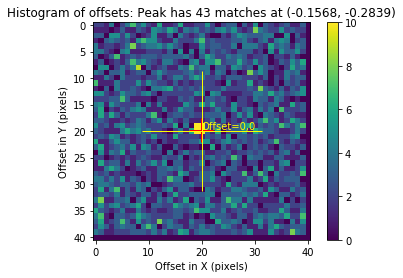

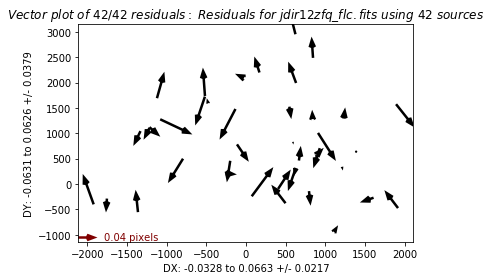

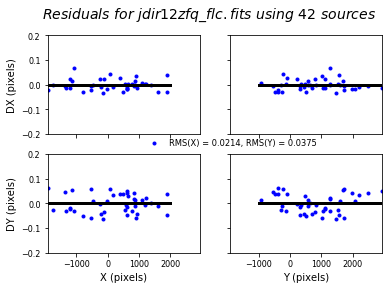

In [9]:
#aligning 606 to 814
cw = 3.5
#90, 200, 1
#150 100 1
tweakreg.TweakReg(list(pointing_1_606), #input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  refimage = 'jdir09r4q_flc.fits', 
                  imagefindcfg={'threshold':150,'conv_width':cw, 'searchrad':3},
                  refimagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':3, 'use_sharp_round':False},
                  expand_refcat=True,
                 # xoffset = table["postarg1"],
                 # yoffset = table["postarg2"],
                  enforce_user_order=True,
                  minobj= 25,
                  separation=0.0, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
                  #tolerance = 1.2,
                 # nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_1_606_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_1_606_1_shifts.txt', 
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit

# pointing 3 alignment below

In [308]:
#NOTE - now we're aligning 606, 814 separately (using respective filter 0 postargs) then drizzling separately
#Vera wants me to try to align them all together post hdr getting updated, will do for grins n gigs

#big daddy you should just delete these jdirs, i think you fucked em up
cw = 3.5

#15o, 1.6
tweakreg.TweakReg(list(pointing_3_606), #input_images, # Pass input images
                  updatehdr=False, # update header with new WCS solution
                  refimage='jdir05fxq_flc.fits',
                  imagefindcfg={'threshold':80,'conv_width':cw, 'searchrad':5},
                 # refimagefindcfg={'threshold':25,'conv_width':cw, 'searchrad':5,'use_sharp_round':True},
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=.5, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.2,
                  ylimit = 0.2,
                  labelsize=8,
               #   nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_3_606_wcs', # Give our WCS a new name
                  outshifts = 'pointing_3_606_shifts.txt', 
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit

#60,1.4
tweakreg.TweakReg(list(pointing_3_606_bad), #input_images, # Pass input images
                  updatehdr=False, # update header with new WCS solution
                  imagefindcfg={'threshold':170,'conv_width':cw, 'searchrad':5},
                  refimage= 'jdir05fxq_flc.fits',
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=.5, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.8,
                  ylimit = 0.2,
                  labelsize=8,
              #    nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_3_606_wcs', # Give our WCS a new name
                  outshifts = 'pointing_3_606_2_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')


INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 17:59:45.439 (23/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 17:59:45.439 (23/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir05fxq_flc.fits', 'jdir05g0q_flc.fits', 'jdir06gbq_flc.fits', 'jdir06geq_flc.fits', 'jdir08toq_flc.fits', 'jdir08trq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir05fxq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir05fxq_flc.fits


    jdir05fxq_flc.fits


INFO:drizzlepac.tweakreg:    jdir05g0q_flc.fits


    jdir05g0q_flc.fits


INFO:drizzlepac.tweakreg:    jdir06gbq_flc.fits


    jdir06gbq_flc.fits


INFO:drizzlepac.tweakreg:    jdir06geq_flc.fits


    jdir06geq_flc.fits


INFO:drizzlepac.tweakreg:    jdir08toq_flc.fits


    jdir08toq_flc.fits


INFO:drizzlepac.tweakreg:    jdir08trq_flc.fits


    jdir08trq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir05fxq_flc.fits', 'jdir05g0q_flc.fits', 'jdir06gbq_flc.fits', 'jdir06geq_flc.fits', 'jdir08toq_flc.fits', 'jdir08trq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05fxq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:driz

===  Source finding for image 'jdir05fxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 1) started at: 17:59:45.774 (23/08/2019)


  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 1) started at: 17:59:45.774 (23/08/2019)


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


ERROR:stsci.tools.logutil.exc:An unhandled exception ocurred:
Traceback (most recent call last):
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/stsci/imagestats/__init__.py", line 216, in _computeStats
    _npix,_mean,_stddev,_min,_max = computeMean(self.image,_clipmin,_clipmax)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/util.py", line 218, in wrapper
    func(*args, **kwargs)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/tweakreg.py", line 308, in run
    **catfile_kwargs)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/imgclasses.py", line 220, in __init__
    catalog.buildCatalogs(exclusions=None, mask=mask)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/catalogs.py", line 339, in buildCatalogs
    self.generateXY(**kwargs)
  File "/ana

SystemError: An error processing the array object information occured in                                     the computeMean module of imagestats.

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:39:10.602 (16/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:39:10.602 (16/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir05g2q_flc.fits', 'jdir05g7q_flc.fits', 'jdir06ggq_flc.fits', 'jdir06glq_flc.fits', 'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir05g2q_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir05g2q_flc.fits


    jdir05g2q_flc.fits


INFO:drizzlepac.tweakreg:    jdir05g7q_flc.fits


    jdir05g7q_flc.fits


INFO:drizzlepac.tweakreg:    jdir06ggq_flc.fits


    jdir06ggq_flc.fits


INFO:drizzlepac.tweakreg:    jdir06glq_flc.fits


    jdir06glq_flc.fits


INFO:drizzlepac.tweakreg:    jdir08tyq_flc.fits


    jdir08tyq_flc.fits


INFO:drizzlepac.tweakreg:    jdir08ttq_flc.fits


    jdir08ttq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir05g2q_flc.fits', 'jdir05g7q_flc.fits', 'jdir06ggq_flc.fits', 'jdir06glq_flc.fits', 'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05g2q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:driz

===  Source finding for image 'jdir05g2q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 1) started at: 15:39:10.955 (16/08/2019)


  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 1) started at: 15:39:10.955 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.789946
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:12.5 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 668 objects.


     Found 668 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 2) started at: 15:39:12.663 (16/08/2019)


  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 2) started at: 15:39:12.663 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.860204
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:13.986 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 685 objects.


     Found 685 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir05g2q_flc.fits': 1353


===  FINAL number of objects in image 'jdir05g2q_flc.fits': 1353


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir05g7q_flc.fits':


===  Source finding for image 'jdir05g7q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g7q_flc.fits', EXT=('SCI', 1) started at: 15:39:14.530 (16/08/2019)


  #  Source finding for 'jdir05g7q_flc.fits', EXT=('SCI', 1) started at: 15:39:14.530 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.144815
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:15.79 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 1008 objects.


     Found 1008 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g7q_flc.fits', EXT=('SCI', 2) started at: 15:39:15.99 (16/08/2019)


  #  Source finding for 'jdir05g7q_flc.fits', EXT=('SCI', 2) started at: 15:39:15.99 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.143074
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:17.268 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 1027 objects.


     Found 1027 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir05g7q_flc.fits': 2035


===  FINAL number of objects in image 'jdir05g7q_flc.fits': 2035


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir06ggq_flc.fits':


===  Source finding for image 'jdir06ggq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir06ggq_flc.fits', EXT=('SCI', 1) started at: 15:39:17.687 (16/08/2019)


  #  Source finding for 'jdir06ggq_flc.fits', EXT=('SCI', 1) started at: 15:39:17.687 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.702248
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:19.107 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 599 objects.


     Found 599 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir06ggq_flc.fits', EXT=('SCI', 2) started at: 15:39:19.267 (16/08/2019)


  #  Source finding for 'jdir06ggq_flc.fits', EXT=('SCI', 2) started at: 15:39:19.267 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.781357
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:20.345 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 674 objects.


     Found 674 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir06ggq_flc.fits': 1273


===  FINAL number of objects in image 'jdir06ggq_flc.fits': 1273


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir06glq_flc.fits':


===  Source finding for image 'jdir06glq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir06glq_flc.fits', EXT=('SCI', 1) started at: 15:39:20.801 (16/08/2019)


  #  Source finding for 'jdir06glq_flc.fits', EXT=('SCI', 1) started at: 15:39:20.801 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.116882
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:21.920 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 833 objects.


     Found 833 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir06glq_flc.fits', EXT=('SCI', 2) started at: 15:39:22.068 (16/08/2019)


  #  Source finding for 'jdir06glq_flc.fits', EXT=('SCI', 2) started at: 15:39:22.068 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.079604
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:23.283 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 877 objects.


     Found 877 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir06glq_flc.fits': 1710


===  FINAL number of objects in image 'jdir06glq_flc.fits': 1710


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir08tyq_flc.fits':


===  Source finding for image 'jdir08tyq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir08tyq_flc.fits', EXT=('SCI', 1) started at: 15:39:23.849 (16/08/2019)


  #  Source finding for 'jdir08tyq_flc.fits', EXT=('SCI', 1) started at: 15:39:23.849 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.320529
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:25.105 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 703 objects.


     Found 703 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir08tyq_flc.fits', EXT=('SCI', 2) started at: 15:39:25.246 (16/08/2019)


  #  Source finding for 'jdir08tyq_flc.fits', EXT=('SCI', 2) started at: 15:39:25.246 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.318910
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:26.366 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 756 objects.


     Found 756 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir08tyq_flc.fits': 1459


===  FINAL number of objects in image 'jdir08tyq_flc.fits': 1459


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir08ttq_flc.fits':


===  Source finding for image 'jdir08ttq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir08ttq_flc.fits', EXT=('SCI', 1) started at: 15:39:26.849 (16/08/2019)


  #  Source finding for 'jdir08ttq_flc.fits', EXT=('SCI', 1) started at: 15:39:26.849 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.966892
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:28.07 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 721 objects.


     Found 721 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir08ttq_flc.fits', EXT=('SCI', 2) started at: 15:39:28.263 (16/08/2019)


  #  Source finding for 'jdir08ttq_flc.fits', EXT=('SCI', 2) started at: 15:39:28.263 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.009530
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:29.368 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 757 objects.


     Found 757 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir08ttq_flc.fits': 1478


===  FINAL number of objects in image 'jdir08ttq_flc.fits': 1478


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir05g2q_flc.fits', 'jdir05g7q_flc.fits', 'jdir06ggq_flc.fits', 'jdir06glq_flc.fits', 'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05g2q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	run

===  Source finding for image 'jdir05g2q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 1) started at: 15:39:29.736 (16/08/2019)


  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 1) started at: 15:39:29.736 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.789946
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:32.236 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 37374 objects.


     Found 37374 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 2) started at: 15:39:32.62 (16/08/2019)


  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 2) started at: 15:39:32.62 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.860204
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:35.092 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 39349 objects.


     Found 39349 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir05g2q_flc.fits': 76723


===  FINAL number of objects in image 'jdir05g2q_flc.fits': 76723


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir05g2q_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir05g2q_flc.fits'


derived from 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	8
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.3
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	ou

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir05g2q_flc.fits


Performing fit for: jdir05g2q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir05g2q_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


Matching sources from 'jdir05g2q_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


INFO:drizzlepac.imgclasses:NO fit performed for reference image: jdir05g2q_flc.fits

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir05g7q_flc.fits


Performing fit for: jdir05g7q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir05g7q_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


Matching sources from 'jdir05g7q_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.172597864768683 -0.8790035587188605


Found initial X and Y shifts of  -0.172597864768683 -0.8790035587188605


INFO:drizzlepac.tweakutils:    with significance of  597.0802746439812 and  47.0  matches


    with significance of  597.0802746439812 and  47.0  matches


INFO:drizzlepac.imgclasses:Found 135 matches for jdir05g7q_flc.fits...


Found 135 matches for jdir05g7q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir05g7q_flc.fits : 


Computed  general  fit for  jdir05g7q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0035  YSH: 0.0009    PROPER ROT: 359.999528    


XSH: 0.0035  YSH: 0.0009    PROPER ROT: 359.999528    


INFO:drizzlepac.imgclasses:<ROT>: 359.999528  SKEW: 0.0005531808201    ROT_X: 359.9992514  ROT_Y: 359.9998046


<ROT>: 359.999528  SKEW: 0.0005531808201    ROT_X: 359.9992514  ROT_Y: 359.9998046


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999960872  SCALE_X: 0.9999940061  SCALE_Y: 0.9999981683


<SCALE>: 0.9999960872  SCALE_X: 0.9999940061  SCALE_Y: 0.9999981683


INFO:drizzlepac.imgclasses:XRMS: 0.06    YRMS: 0.084


XRMS: 0.06    YRMS: 0.084


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.5e-06 (deg)   RMS_DEC: 8.7e-08 (deg)


RMS_RA: 1.5e-06 (deg)   RMS_DEC: 8.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  70  objects.


Final solution based on  70  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir05g7q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir05g7q_flc_catalog_fit.match


wrote XY data to:  jdir05g7q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  70


Total # points:  70


INFO:drizzlepac.tweakutils:# of points after clipping:  70


# of points after clipping:  70


INFO:drizzlepac.tweakutils:Total # points:  70


Total # points:  70


INFO:drizzlepac.tweakutils:# of points after clipping:  70


# of points after clipping:  70


INFO:drizzlepac.imgclasses:Adding 1900 new sources to the reference catalog for a total of 78623 sources.


Adding 1900 new sources to the reference catalog for a total of 78623 sources.


INFO:drizzlepac.updatehdr:....Updating header for jdir05g7q_flc.fits...
INFO:drizzlepac.updatehdr:Processing jdir05g7q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for jdir05g7q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing jdir05g7q_flc.fits['SCI',2]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir05g7q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir06ggq_flc.fits


Performing fit for: jdir06ggq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir06ggq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


Matching sources from 'jdir06ggq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  0.025839793281654977 -0.04651162790697683


Found initial X and Y shifts of  0.025839793281654977 -0.04651162790697683


INFO:drizzlepac.tweakutils:    with significance of  479.72648457219873 and  31.0  matches


    with significance of  479.72648457219873 and  31.0  matches


INFO:drizzlepac.imgclasses:Found 76 matches for jdir06ggq_flc.fits...


Found 76 matches for jdir06ggq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir06ggq_flc.fits : 


Computed  general  fit for  jdir06ggq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0027  YSH: 0.0060    PROPER ROT: 0.0004922138048    


XSH: 0.0027  YSH: 0.0060    PROPER ROT: 0.0004922138048    


INFO:drizzlepac.imgclasses:<ROT>: 0.0004922138048  SKEW: -0.0005797336198    ROT_X: 0.0007820806147  ROT_Y: 0.0002023469949


<ROT>: 0.0004922138048  SKEW: -0.0005797336198    ROT_X: 0.0007820806147  ROT_Y: 0.0002023469949


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999956991  SCALE_X: 0.999992312  SCALE_Y: 0.9999990863


<SCALE>: 0.9999956991  SCALE_X: 0.999992312  SCALE_Y: 0.9999990863


INFO:drizzlepac.imgclasses:XRMS: 0.054    YRMS: 0.062


XRMS: 0.054    YRMS: 0.062


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 4.1e-08 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 4.1e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  32  objects.


Final solution based on  32  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir06ggq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir06ggq_flc_catalog_fit.match


wrote XY data to:  jdir06ggq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  32


Total # points:  32


INFO:drizzlepac.tweakutils:# of points after clipping:  32


# of points after clipping:  32


INFO:drizzlepac.tweakutils:Total # points:  32


Total # points:  32


INFO:drizzlepac.tweakutils:# of points after clipping:  32


# of points after clipping:  32


INFO:drizzlepac.imgclasses:Adding 1197 new sources to the reference catalog for a total of 79820 sources.


Adding 1197 new sources to the reference catalog for a total of 79820 sources.


INFO:drizzlepac.updatehdr:....Updating header for jdir06ggq_flc.fits...
INFO:drizzlepac.updatehdr:Processing jdir06ggq_flc.fits['SCI',1]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir06ggq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing jdir06ggq_flc.fits['SCI',2]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir06glq_flc.fits


Performing fit for: jdir06glq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir06glq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


Matching sources from 'jdir06glq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.16608996539792287 -0.0588235294117645


Found initial X and Y shifts of  -0.16608996539792287 -0.0588235294117645


INFO:drizzlepac.tweakutils:    with significance of  711.821820401707 and  72.0  matches


    with significance of  711.821820401707 and  72.0  matches


INFO:drizzlepac.imgclasses:Found 133 matches for jdir06glq_flc.fits...


Found 133 matches for jdir06glq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir06glq_flc.fits : 


Computed  general  fit for  jdir06glq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0076  YSH: 0.0286    PROPER ROT: 0.0004300804531    


XSH: -0.0076  YSH: 0.0286    PROPER ROT: 0.0004300804531    


INFO:drizzlepac.imgclasses:<ROT>: 180.0004301  SKEW: -359.9961706    ROT_X: 359.9985154  ROT_Y: 0.00234478898


<ROT>: 180.0004301  SKEW: -359.9961706    ROT_X: 359.9985154  ROT_Y: 0.00234478898


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999831454  SCALE_X: 0.9998896551  SCALE_Y: 1.000076647


<SCALE>: 0.9999831454  SCALE_X: 0.9998896551  SCALE_Y: 1.000076647


INFO:drizzlepac.imgclasses:XRMS: 0.046    YRMS: 0.053


XRMS: 0.046    YRMS: 0.053


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1e-06 (deg)   RMS_DEC: 3.9e-08 (deg)


RMS_RA: 1e-06 (deg)   RMS_DEC: 3.9e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  64  objects.


Final solution based on  64  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir06glq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir06glq_flc_catalog_fit.match


wrote XY data to:  jdir06glq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  64


Total # points:  64


INFO:drizzlepac.tweakutils:# of points after clipping:  64


# of points after clipping:  64


INFO:drizzlepac.tweakutils:Total # points:  64


Total # points:  64


INFO:drizzlepac.tweakutils:# of points after clipping:  64


# of points after clipping:  64


INFO:drizzlepac.imgclasses:Adding 1577 new sources to the reference catalog for a total of 81397 sources.


Adding 1577 new sources to the reference catalog for a total of 81397 sources.


INFO:drizzlepac.updatehdr:....Updating header for jdir06glq_flc.fits...
INFO:drizzlepac.updatehdr:Processing jdir06glq_flc.fits['SCI',1]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir06glq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing jdir06glq_flc.fits['SCI',2]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir08tyq_flc.fits


Performing fit for: jdir08tyq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir08tyq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


Matching sources from 'jdir08tyq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.16335540838852225 -0.8366445916114778


Found initial X and Y shifts of  -0.16335540838852225 -0.8366445916114778


INFO:drizzlepac.tweakutils:    with significance of  595.8919919373359 and  45.0  matches


    with significance of  595.8919919373359 and  45.0  matches


INFO:drizzlepac.imgclasses:Found 87 matches for jdir08tyq_flc.fits...


Found 87 matches for jdir08tyq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir08tyq_flc.fits : 


Computed  general  fit for  jdir08tyq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0149  YSH: -0.0138    PROPER ROT: 0.0008093144647    


XSH: -0.0149  YSH: -0.0138    PROPER ROT: 0.0008093144647    


INFO:drizzlepac.imgclasses:<ROT>: 0.0008093144647  SKEW: 0.000387025316    ROT_X: 0.0006158018067  ROT_Y: 0.001002827123


<ROT>: 0.0008093144647  SKEW: 0.000387025316    ROT_X: 0.0006158018067  ROT_Y: 0.001002827123


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999984672  SCALE_X: 0.9999804758  SCALE_Y: 1.000016459


<SCALE>: 0.9999984672  SCALE_X: 0.9999804758  SCALE_Y: 1.000016459


INFO:drizzlepac.imgclasses:XRMS: 0.074    YRMS: 0.083


XRMS: 0.074    YRMS: 0.083


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.6e-06 (deg)   RMS_DEC: 7.6e-08 (deg)


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 7.6e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  41  objects.


Final solution based on  41  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir08tyq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir08tyq_flc_catalog_fit.match


wrote XY data to:  jdir08tyq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  41


Total # points:  41


INFO:drizzlepac.tweakutils:# of points after clipping:  41


# of points after clipping:  41


INFO:drizzlepac.tweakutils:Total # points:  41


Total # points:  41


INFO:drizzlepac.tweakutils:# of points after clipping:  41


# of points after clipping:  41


INFO:drizzlepac.imgclasses:Adding 1372 new sources to the reference catalog for a total of 82769 sources.


Adding 1372 new sources to the reference catalog for a total of 82769 sources.


INFO:drizzlepac.updatehdr:....Updating header for jdir08tyq_flc.fits...
INFO:drizzlepac.updatehdr:Processing jdir08tyq_flc.fits['SCI',1]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir08tyq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing jdir08tyq_flc.fits['SCI',2]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir08ttq_flc.fits


Performing fit for: jdir08ttq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir08ttq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


Matching sources from 'jdir08ttq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.7578558225508303 -0.8706099815157131


Found initial X and Y shifts of  -0.7578558225508303 -0.8706099815157131


INFO:drizzlepac.tweakutils:    with significance of  709.3048539212024 and  63.0  matches


    with significance of  709.3048539212024 and  63.0  matches


INFO:drizzlepac.imgclasses:Found 119 matches for jdir08ttq_flc.fits...


Found 119 matches for jdir08ttq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir08ttq_flc.fits : 


Computed  general  fit for  jdir08ttq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0458  YSH: 0.0027    PROPER ROT: 0.001144658647    


XSH: -0.0458  YSH: 0.0027    PROPER ROT: 0.001144658647    


INFO:drizzlepac.imgclasses:<ROT>: 0.001144658647  SKEW: -0.001486151724    ROT_X: 0.001887734509  ROT_Y: 0.0004015827856


<ROT>: 0.001144658647  SKEW: -0.001486151724    ROT_X: 0.001887734509  ROT_Y: 0.0004015827856


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999789184  SCALE_X: 0.9999630944  SCALE_Y: 0.9999947429


<SCALE>: 0.9999789184  SCALE_X: 0.9999630944  SCALE_Y: 0.9999947429


INFO:drizzlepac.imgclasses:XRMS: 0.071    YRMS: 0.046


XRMS: 0.071    YRMS: 0.046


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 3.7e-07 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 3.7e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  64  objects.


Final solution based on  64  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir08ttq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir08ttq_flc_catalog_fit.match


wrote XY data to:  jdir08ttq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  64


Total # points:  64


INFO:drizzlepac.tweakutils:# of points after clipping:  64


# of points after clipping:  64


INFO:drizzlepac.tweakutils:Total # points:  64


Total # points:  64


INFO:drizzlepac.tweakutils:# of points after clipping:  64


# of points after clipping:  64


INFO:drizzlepac.imgclasses:Adding 1359 new sources to the reference catalog for a total of 84128 sources.


Adding 1359 new sources to the reference catalog for a total of 84128 sources.


INFO:drizzlepac.updatehdr:....Updating header for jdir08ttq_flc.fits...
INFO:drizzlepac.updatehdr:Processing jdir08ttq_flc.fits['SCI',1]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir08ttq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing jdir08ttq_flc.fits['SCI',2]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "

Writing out shiftfile : pointing_3_814_1_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:39:46.182 (16/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:39:46.182 (16/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	['jdir07pnq_flc.fits', 'jdir07psq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir05g2q_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir07pnq_flc.fits


    jdir07pnq_flc.fits


INFO:drizzlepac.tweakreg:    jdir07psq_flc.fits


    jdir07psq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir07pnq_flc.fits', 'jdir07psq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05g2q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.

===  Source finding for image 'jdir07pnq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir07pnq_flc.fits', EXT=('SCI', 1) started at: 15:39:46.495 (16/08/2019)


  #  Source finding for 'jdir07pnq_flc.fits', EXT=('SCI', 1) started at: 15:39:46.495 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.039319
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:47.754 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 1763 objects.


     Found 1763 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir07pnq_flc.fits', EXT=('SCI', 2) started at: 15:39:47.875 (16/08/2019)


  #  Source finding for 'jdir07pnq_flc.fits', EXT=('SCI', 2) started at: 15:39:47.875 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.925762
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:49.060 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 1959 objects.


     Found 1959 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir07pnq_flc.fits': 3722


===  FINAL number of objects in image 'jdir07pnq_flc.fits': 3722


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir07psq_flc.fits':


===  Source finding for image 'jdir07psq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir07psq_flc.fits', EXT=('SCI', 1) started at: 15:39:49.468 (16/08/2019)


  #  Source finding for 'jdir07psq_flc.fits', EXT=('SCI', 1) started at: 15:39:49.468 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.246260
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:50.811 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 1753 objects.


     Found 1753 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir07psq_flc.fits', EXT=('SCI', 2) started at: 15:39:50.913 (16/08/2019)


  #  Source finding for 'jdir07psq_flc.fits', EXT=('SCI', 2) started at: 15:39:50.913 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.292299
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:52.062 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 1671 objects.


     Found 1671 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir07psq_flc.fits': 3424


===  FINAL number of objects in image 'jdir07psq_flc.fits': 3424


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir07pnq_flc.fits', 'jdir07psq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05g2q_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	s

===  Source finding for image 'jdir05g2q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 1) started at: 15:39:52.528 (16/08/2019)


  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 1) started at: 15:39:52.528 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.789946
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:54.885 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 37374 objects.


     Found 37374 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 2) started at: 15:39:55.325 (16/08/2019)


  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 2) started at: 15:39:55.325 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.860204
INFO:drizzlepac.catalogs:###Source finding finished at: 15:39:57.852 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 39349 objects.


     Found 39349 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir05g2q_flc.fits': 76723


===  FINAL number of objects in image 'jdir05g2q_flc.fits': 76723


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir05g2q_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir05g2q_flc.fits'


derived from 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.0
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir07pnq_flc.fits


Performing fit for: jdir07pnq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir07pnq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


Matching sources from 'jdir07pnq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.9652265542676517 0.8451001053740796


Found initial X and Y shifts of  -0.9652265542676517 0.8451001053740796


INFO:drizzlepac.tweakutils:    with significance of  579.9579463307621 and  48.0  matches


    with significance of  579.9579463307621 and  48.0  matches


INFO:drizzlepac.imgclasses:Found 222 matches for jdir07pnq_flc.fits...


Found 222 matches for jdir07pnq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir07pnq_flc.fits : 


Computed  general  fit for  jdir07pnq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0479  YSH: 1.0130    PROPER ROT: 359.9773831    


XSH: 0.0479  YSH: 1.0130    PROPER ROT: 359.9773831    


INFO:drizzlepac.imgclasses:<ROT>: 359.9773831  SKEW: -0.0002312550905    ROT_X: 359.9774987  ROT_Y: 359.9772674


<ROT>: 359.9773831  SKEW: -0.0002312550905    ROT_X: 359.9774987  ROT_Y: 359.9772674


INFO:drizzlepac.imgclasses:<SCALE>: 1.000002309  SCALE_X: 0.9999818011  SCALE_Y: 1.000022818


<SCALE>: 1.000002309  SCALE_X: 0.9999818011  SCALE_Y: 1.000022818


INFO:drizzlepac.imgclasses:XRMS: 0.074    YRMS: 0.061


XRMS: 0.074    YRMS: 0.061


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 2.7e-07 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 2.7e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  63  objects.


Final solution based on  63  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir07pnq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir07pnq_flc_catalog_fit.match


wrote XY data to:  jdir07pnq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  63


Total # points:  63


INFO:drizzlepac.tweakutils:# of points after clipping:  63


# of points after clipping:  63


INFO:drizzlepac.tweakutils:Total # points:  63


Total # points:  63


INFO:drizzlepac.tweakutils:# of points after clipping:  63


# of points after clipping:  63


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir07pnq_flc.fits


Initializing new WCSCORR table for  jdir07pnq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir07pnq_flc.fits...


....Updating header for jdir07pnq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir07pnq_flc.fits['SCI',1]


Processing jdir07pnq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir07pnq_flc.fits[1]


Updating header for jdir07pnq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.02840990070484e-06 1.1198067616505678e-05


CD_11  CD_12: 9.02840990070484e-06 1.1198067616505678e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494699259473863e-05 -8.357878296781146e-06


CD_21  CD_22: 1.0494699259473863e-05 -8.357878296781146e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00748944212015 14.520952687103932


CRVAL    : 210.00748944212015 14.520952687103932


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049836781763900904


Plate Scale : 0.049836781763900904


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73647900437771


ORIENTAT : 126.73647900437771


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir07pnq_flc.fits['SCI',2]


Processing jdir07pnq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir07pnq_flc.fits[4]


Updating header for jdir07pnq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.062235954335205e-06 1.0884906836949646e-05


CD_11  CD_12: 9.062235954335205e-06 1.0884906836949646e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250461181964993e-05 -7.997520623993344e-06


CD_21  CD_22: 1.0250461181964993e-05 -7.997520623993344e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.03143145718258 14.503726246470528


CRVAL    : 210.03143145718258 14.503726246470528


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925416077080178


Plate Scale : 0.04925416077080178


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30602249017834


ORIENTAT : 126.30602249017834


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir07psq_flc.fits


Performing fit for: jdir07psq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir07psq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


Matching sources from 'jdir07psq_flc.fits' with sources from reference image 'jdir05g2q_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.9126637554585137 0.9104803493449793


Found initial X and Y shifts of  -0.9126637554585137 0.9104803493449793


INFO:drizzlepac.tweakutils:    with significance of  584.9122722230942 and  51.0  matches


    with significance of  584.9122722230942 and  51.0  matches


INFO:drizzlepac.imgclasses:Found 223 matches for jdir07psq_flc.fits...


Found 223 matches for jdir07psq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir07psq_flc.fits : 


Computed  general  fit for  jdir07psq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0316  YSH: 1.0770    PROPER ROT: 359.9765545    


XSH: 0.0316  YSH: 1.0770    PROPER ROT: 359.9765545    


INFO:drizzlepac.imgclasses:<ROT>: 359.9765545  SKEW: 0.001398068305    ROT_X: 359.9758555  ROT_Y: 359.9772535


<ROT>: 359.9765545  SKEW: 0.001398068305    ROT_X: 359.9758555  ROT_Y: 359.9772535


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999960443  SCALE_X: 0.9999729373  SCALE_Y: 1.000019152


<SCALE>: 0.9999960443  SCALE_X: 0.9999729373  SCALE_Y: 1.000019152


INFO:drizzlepac.imgclasses:XRMS: 0.068    YRMS: 0.077


XRMS: 0.068    YRMS: 0.077


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.5e-06 (deg)   RMS_DEC: 5.8e-08 (deg)


RMS_RA: 1.5e-06 (deg)   RMS_DEC: 5.8e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  73  objects.


Final solution based on  73  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir07psq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir07psq_flc_catalog_fit.match


wrote XY data to:  jdir07psq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  73


Total # points:  73


INFO:drizzlepac.tweakutils:# of points after clipping:  73


# of points after clipping:  73


INFO:drizzlepac.tweakutils:Total # points:  73


Total # points:  73


INFO:drizzlepac.tweakutils:# of points after clipping:  73


# of points after clipping:  73


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir07psq_flc.fits


Initializing new WCSCORR table for  jdir07psq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir07psq_flc.fits...


....Updating header for jdir07psq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir07psq_flc.fits['SCI',1]


Processing jdir07psq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir07psq_flc.fits[1]


Updating header for jdir07psq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.027874081654863e-06 1.1197721041494864e-05


CD_11  CD_12: 9.027874081654863e-06 1.1197721041494864e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494687974869556e-05 -8.357611012451297e-06


CD_21  CD_22: 1.0494687974869556e-05 -8.357611012451297e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0074888821407 14.520953411861784


CRVAL    : 210.0074888821407 14.520953411861784


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983509370599751


Plate Scale : 0.04983509370599751


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.7364507045649


ORIENTAT : 126.7364507045649


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir07psq_flc.fits['SCI',2]


Processing jdir07psq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir07psq_flc.fits[4]


Updating header for jdir07psq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.06170238371317e-06 1.0884568047959129e-05


CD_11  CD_12: 9.06170238371317e-06 1.0884568047959129e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250453613736198e-05 -7.997262449332186e-06


CD_21  CD_22: 1.0250453613736198e-05 -7.997262449332186e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.03143015513166 14.503727523542972


CRVAL    : 210.03143015513166 14.503727523542972


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925249244727796


Plate Scale : 0.04925249244727796


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30599085328379


ORIENTAT : 126.30599085328379


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_3_814_2_shifts.txt


Writing out shiftfile : pointing_3_814_2_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


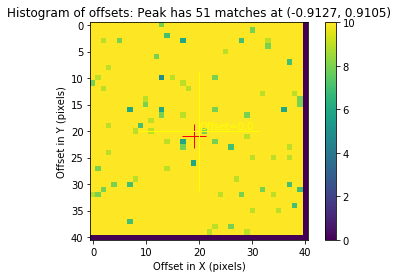

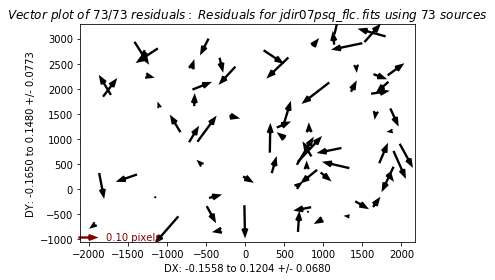

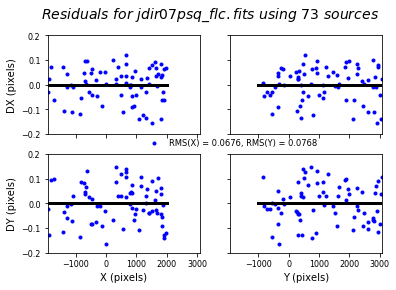

In [214]:
cw = 3.5
#160, ~1.5 for imagefind, refimage 130
#trying out higher sigma, like 2.5 then gonna see what i can do

#70, 1 is good
tweakreg.TweakReg(list(pointing_3_814), #input_images, # Pass input images
                  refimage = 'jdir05g2q_flc.fits',
                  updatehdr=False, # update header with new WCS solution
                  imagefindcfg={'threshold':170,'conv_width':cw, 'searchrad':5},
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=8, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.3,
                  ylimit = 0.2,
                  labelsize=8,
              #    nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_3_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_3_814_1_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')
#60, 1.2 is good

#100, 1.2
tweakreg.TweakReg(list(pointing_3_814_bad), #input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5},
                  refimage= 'jdir05g2q_flc.fits',
                  #expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=.5, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
          #        nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_3_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_3_814_2_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')


Aligning 814 to 606

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:56:33.544 (16/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:56:33.544 (16/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir05g2q_flc.fits', 'jdir05g7q_flc.fits', 'jdir06ggq_flc.fits', 'jdir06glq_flc.fits', 'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir05fxq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir05g2q_flc.fits


    jdir05g2q_flc.fits


INFO:drizzlepac.tweakreg:    jdir05g7q_flc.fits


    jdir05g7q_flc.fits


INFO:drizzlepac.tweakreg:    jdir06ggq_flc.fits


    jdir06ggq_flc.fits


INFO:drizzlepac.tweakreg:    jdir06glq_flc.fits


    jdir06glq_flc.fits


INFO:drizzlepac.tweakreg:    jdir08tyq_flc.fits


    jdir08tyq_flc.fits


INFO:drizzlepac.tweakreg:    jdir08ttq_flc.fits


    jdir08ttq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir05g2q_flc.fits', 'jdir05g7q_flc.fits', 'jdir06ggq_flc.fits', 'jdir06glq_flc.fits', 'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05fxq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:driz

===  Source finding for image 'jdir05g2q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 1) started at: 15:56:33.948 (16/08/2019)


  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 1) started at: 15:56:33.948 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.789946
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:35.519 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 277 objects.


     Found 277 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 2) started at: 15:56:35.690 (16/08/2019)


  #  Source finding for 'jdir05g2q_flc.fits', EXT=('SCI', 2) started at: 15:56:35.690 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.860204
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:36.947 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 299 objects.


     Found 299 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir05g2q_flc.fits': 576


===  FINAL number of objects in image 'jdir05g2q_flc.fits': 576


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir05g7q_flc.fits':


===  Source finding for image 'jdir05g7q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g7q_flc.fits', EXT=('SCI', 1) started at: 15:56:37.52 (16/08/2019)


  #  Source finding for 'jdir05g7q_flc.fits', EXT=('SCI', 1) started at: 15:56:37.52 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.144815
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:38.918 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 418 objects.


     Found 418 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05g7q_flc.fits', EXT=('SCI', 2) started at: 15:56:39.038 (16/08/2019)


  #  Source finding for 'jdir05g7q_flc.fits', EXT=('SCI', 2) started at: 15:56:39.038 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.143074
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:40.100 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 429 objects.


     Found 429 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir05g7q_flc.fits': 847


===  FINAL number of objects in image 'jdir05g7q_flc.fits': 847


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir06ggq_flc.fits':


===  Source finding for image 'jdir06ggq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir06ggq_flc.fits', EXT=('SCI', 1) started at: 15:56:40.537 (16/08/2019)


  #  Source finding for 'jdir06ggq_flc.fits', EXT=('SCI', 1) started at: 15:56:40.537 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.702248
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:41.894 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 271 objects.


     Found 271 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir06ggq_flc.fits', EXT=('SCI', 2) started at: 15:56:41.994 (16/08/2019)


  #  Source finding for 'jdir06ggq_flc.fits', EXT=('SCI', 2) started at: 15:56:41.994 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.781357
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:43.198 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 271 objects.


     Found 271 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir06ggq_flc.fits': 542


===  FINAL number of objects in image 'jdir06ggq_flc.fits': 542


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir06glq_flc.fits':


===  Source finding for image 'jdir06glq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir06glq_flc.fits', EXT=('SCI', 1) started at: 15:56:43.54 (16/08/2019)


  #  Source finding for 'jdir06glq_flc.fits', EXT=('SCI', 1) started at: 15:56:43.54 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.116882
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:44.841 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 375 objects.


     Found 375 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir06glq_flc.fits', EXT=('SCI', 2) started at: 15:56:45.004 (16/08/2019)


  #  Source finding for 'jdir06glq_flc.fits', EXT=('SCI', 2) started at: 15:56:45.004 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.079604
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:46.195 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 372 objects.


     Found 372 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir06glq_flc.fits': 747


===  FINAL number of objects in image 'jdir06glq_flc.fits': 747


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir08tyq_flc.fits':


===  Source finding for image 'jdir08tyq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir08tyq_flc.fits', EXT=('SCI', 1) started at: 15:56:46.557 (16/08/2019)


  #  Source finding for 'jdir08tyq_flc.fits', EXT=('SCI', 1) started at: 15:56:46.557 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.320529
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:47.833 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 312 objects.


     Found 312 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir08tyq_flc.fits', EXT=('SCI', 2) started at: 15:56:47.966 (16/08/2019)


  #  Source finding for 'jdir08tyq_flc.fits', EXT=('SCI', 2) started at: 15:56:47.966 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.318910
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:49.241 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 319 objects.


     Found 319 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir08tyq_flc.fits': 631


===  FINAL number of objects in image 'jdir08tyq_flc.fits': 631


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir08ttq_flc.fits':


===  Source finding for image 'jdir08ttq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir08ttq_flc.fits', EXT=('SCI', 1) started at: 15:56:49.582 (16/08/2019)


  #  Source finding for 'jdir08ttq_flc.fits', EXT=('SCI', 1) started at: 15:56:49.582 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.966892
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:50.755 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 300 objects.


     Found 300 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir08ttq_flc.fits', EXT=('SCI', 2) started at: 15:56:50.887 (16/08/2019)


  #  Source finding for 'jdir08ttq_flc.fits', EXT=('SCI', 2) started at: 15:56:50.887 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.009530
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:52.179 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 325 objects.


     Found 325 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir08ttq_flc.fits': 625


===  FINAL number of objects in image 'jdir08ttq_flc.fits': 625


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir05g2q_flc.fits', 'jdir05g7q_flc.fits', 'jdir06ggq_flc.fits', 'jdir06glq_flc.fits', 'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05fxq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	run

===  Source finding for image 'jdir05fxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 1) started at: 15:56:52.650 (16/08/2019)


  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 1) started at: 15:56:52.650 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.314536
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:55.30 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 34263 objects.


     Found 34263 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 2) started at: 15:56:55.715 (16/08/2019)


  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 2) started at: 15:56:55.715 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.315799
INFO:drizzlepac.catalogs:###Source finding finished at: 15:56:58.365 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 35798 objects.


     Found 35798 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir05fxq_flc.fits': 70061


===  FINAL number of objects in image 'jdir05fxq_flc.fits': 70061


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir05fxq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir05fxq_flc.fits'


derived from 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.0
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir05g2q_flc.fits


Performing fit for: jdir05g2q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir05g2q_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


Matching sources from 'jdir05g2q_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.34920634920634797 -0.0052910052910064564


Found initial X and Y shifts of  -0.34920634920634797 -0.0052910052910064564


INFO:drizzlepac.tweakutils:    with significance of  477.30520143734964 and  34.0  matches


    with significance of  477.30520143734964 and  34.0  matches


INFO:drizzlepac.imgclasses:Found 89 matches for jdir05g2q_flc.fits...


Found 89 matches for jdir05g2q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir05g2q_flc.fits : 


Computed  general  fit for  jdir05g2q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2303  YSH: 0.0166    PROPER ROT: 359.997665    


XSH: 0.2303  YSH: 0.0166    PROPER ROT: 359.997665    


INFO:drizzlepac.imgclasses:<ROT>: 179.997665  SKEW: 359.9949931    ROT_X: 0.0001684318241  ROT_Y: 359.9951615


<ROT>: 179.997665  SKEW: 359.9949931    ROT_X: 0.0001684318241  ROT_Y: 359.9951615


INFO:drizzlepac.imgclasses:<SCALE>: 1.00001635  SCALE_X: 1.000031488  SCALE_Y: 1.000001215


<SCALE>: 1.00001635  SCALE_X: 1.000031488  SCALE_Y: 1.000001215


INFO:drizzlepac.imgclasses:XRMS: 0.069    YRMS: 0.049


XRMS: 0.069    YRMS: 0.049


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 3.1e-07 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 3.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  22  objects.


Final solution based on  22  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir05g2q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir05g2q_flc_catalog_fit.match


wrote XY data to:  jdir05g2q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  22


Total # points:  22


INFO:drizzlepac.tweakutils:# of points after clipping:  22


# of points after clipping:  22


INFO:drizzlepac.tweakutils:Total # points:  22


Total # points:  22


INFO:drizzlepac.tweakutils:# of points after clipping:  22


# of points after clipping:  22


INFO:drizzlepac.imgclasses:Adding 487 new sources to the reference catalog for a total of 70548 sources.


Adding 487 new sources to the reference catalog for a total of 70548 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir05g2q_flc.fits...


....Updating header for jdir05g2q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir05g2q_flc.fits['SCI',1]


Processing jdir05g2q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir05g2q_flc.fits[1]


Updating header for jdir05g2q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.028415822674629e-06 1.1198377916950292e-05


CD_11  CD_12: 9.028415822674629e-06 1.1198377916950292e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494379259458597e-05 -8.356900929182422e-06


CD_21  CD_22: 1.0494379259458597e-05 -8.356900929182422e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00754050494098 14.520987941248125


CRVAL    : 210.00754050494098 14.520987941248125


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049838271638442774


Plate Scale : 0.049838271638442774


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73250619911047


ORIENTAT : 126.73250619911047


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir05g2q_flc.fits['SCI',2]


Processing jdir05g2q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir05g2q_flc.fits[4]


Updating header for jdir05g2q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.062245669169682e-06 1.0885206783057869e-05


CD_11  CD_12: 9.062245669169682e-06 1.0885206783057869e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250158162571919e-05 -7.996578865752696e-06


CD_21  CD_22: 1.0250158162571919e-05 -7.996578865752696e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.03148318640316 14.503763518790239


CRVAL    : 210.03148318640316 14.503763518790239


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925563013319815


Plate Scale : 0.04925563013319815


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30204973403596


ORIENTAT : 126.30204973403596


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir05g7q_flc.fits


Performing fit for: jdir05g7q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir05g7q_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


Matching sources from 'jdir05g7q_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.1532567049808442 0.08429118773946342


Found initial X and Y shifts of  -0.1532567049808442 0.08429118773946342


INFO:drizzlepac.tweakutils:    with significance of  583.09518948453 and  52.0  matches


    with significance of  583.09518948453 and  52.0  matches


INFO:drizzlepac.imgclasses:Found 125 matches for jdir05g7q_flc.fits...


Found 125 matches for jdir05g7q_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir05g7q_flc.fits : 


Computed  general  fit for  jdir05g7q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.1926  YSH: 0.0725    PROPER ROT: 359.9951408    


XSH: 0.1926  YSH: 0.0725    PROPER ROT: 359.9951408    


INFO:drizzlepac.imgclasses:<ROT>: 359.9951408  SKEW: 0.0004031050627    ROT_X: 359.9949393  ROT_Y: 359.9953424


<ROT>: 359.9951408  SKEW: 0.0004031050627    ROT_X: 359.9949393  ROT_Y: 359.9953424


INFO:drizzlepac.imgclasses:<SCALE>: 1.00002274  SCALE_X: 1.000096045  SCALE_Y: 0.9999494403


<SCALE>: 1.00002274  SCALE_X: 1.000096045  SCALE_Y: 0.9999494403


INFO:drizzlepac.imgclasses:XRMS: 0.035    YRMS: 0.042


XRMS: 0.035    YRMS: 0.042


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.9e-07 (deg)   RMS_DEC: 8.1e-09 (deg)


RMS_RA: 7.9e-07 (deg)   RMS_DEC: 8.1e-09 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  25  objects.


Final solution based on  25  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir05g7q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir05g7q_flc_catalog_fit.match


wrote XY data to:  jdir05g7q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  25


Total # points:  25


INFO:drizzlepac.tweakutils:# of points after clipping:  25


# of points after clipping:  25


INFO:drizzlepac.tweakutils:Total # points:  25


Total # points:  25


INFO:drizzlepac.tweakutils:# of points after clipping:  25


# of points after clipping:  25


INFO:drizzlepac.imgclasses:Adding 722 new sources to the reference catalog for a total of 71273 sources.


Adding 722 new sources to the reference catalog for a total of 71273 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir05g7q_flc.fits...


....Updating header for jdir05g7q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir05g7q_flc.fits['SCI',1]


Processing jdir05g7q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir05g7q_flc.fits[1]


Updating header for jdir05g7q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.026805838150848e-06 1.1198598116510801e-05


CD_11  CD_12: 9.026805838150848e-06 1.1198598116510801e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494252699164623e-05 -8.35747720803576e-06


CD_21  CD_22: 1.0494252699164623e-05 -8.35747720803576e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00754059630233 14.52098953472966


CRVAL    : 210.00754059630233 14.52098953472966


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049837498487328734


Plate Scale : 0.049837498487328734


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73385994422452


ORIENTAT : 126.73385994422452


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir05g7q_flc.fits['SCI',2]


Processing jdir05g7q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir05g7q_flc.fits[4]


Updating header for jdir05g7q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.060659077292086e-06 1.088540742130312e-05


CD_11  CD_12: 9.060659077292086e-06 1.088540742130312e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250025750233295e-05 -7.997136627680976e-06


CD_21  CD_22: 1.0250025750233295e-05 -7.997136627680976e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.03148374054456 14.503763920821465


CRVAL    : 210.03148374054456 14.503763920821465


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925485940528671


Plate Scale : 0.04925485940528671


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30345258969099


ORIENTAT : 126.30345258969099


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir06ggq_flc.fits


Performing fit for: jdir06ggq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir06ggq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


Matching sources from 'jdir06ggq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  0.07878787878787818 -0.02424242424242351


Found initial X and Y shifts of  0.07878787878787818 -0.02424242424242351


INFO:drizzlepac.tweakutils:    with significance of  452.4578212386211 and  31.0  matches


    with significance of  452.4578212386211 and  31.0  matches


INFO:drizzlepac.imgclasses:Found 59 matches for jdir06ggq_flc.fits...


Found 59 matches for jdir06ggq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir06ggq_flc.fits : 


Computed  general  fit for  jdir06ggq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2565  YSH: 0.0719    PROPER ROT: 359.997519    


XSH: 0.2565  YSH: 0.0719    PROPER ROT: 359.997519    


INFO:drizzlepac.imgclasses:<ROT>: 359.997519  SKEW: -0.001624212142    ROT_X: 359.9983311  ROT_Y: 359.9967069


<ROT>: 359.997519  SKEW: -0.001624212142    ROT_X: 359.9983311  ROT_Y: 359.9967069


INFO:drizzlepac.imgclasses:<SCALE>: 1.000033744  SCALE_X: 1.000060166  SCALE_Y: 1.000007323


<SCALE>: 1.000033744  SCALE_X: 1.000060166  SCALE_Y: 1.000007323


INFO:drizzlepac.imgclasses:XRMS: 0.031    YRMS: 0.042


XRMS: 0.031    YRMS: 0.042


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.5e-07 (deg)   RMS_DEC: 3.9e-08 (deg)


RMS_RA: 7.5e-07 (deg)   RMS_DEC: 3.9e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  20  objects.


Final solution based on  20  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir06ggq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir06ggq_flc_catalog_fit.match


wrote XY data to:  jdir06ggq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  20


Total # points:  20


INFO:drizzlepac.tweakutils:# of points after clipping:  20


# of points after clipping:  20


INFO:drizzlepac.tweakutils:Total # points:  20


Total # points:  20


INFO:drizzlepac.tweakutils:# of points after clipping:  20


# of points after clipping:  20


INFO:drizzlepac.imgclasses:Adding 483 new sources to the reference catalog for a total of 71758 sources.


Adding 483 new sources to the reference catalog for a total of 71758 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir06ggq_flc.fits...


....Updating header for jdir06ggq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir06ggq_flc.fits['SCI',1]


Processing jdir06ggq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir06ggq_flc.fits[1]


Updating header for jdir06ggq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.025883647455323e-06 1.1199339603554739e-05


CD_11  CD_12: 9.025883647455323e-06 1.1199339603554739e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0496187859125499e-05 -8.355000195379757e-06


CD_21  CD_22: 1.0496187859125499e-05 -8.355000195379757e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00676144217564 14.521405855631716


CRVAL    : 210.00676144217564 14.521405855631716


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983877975533541


Plate Scale : 0.04983877975533541


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72390114904698


ORIENTAT : 126.72390114904698


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir06ggq_flc.fits['SCI',2]


Processing jdir06ggq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir06ggq_flc.fits[4]


Updating header for jdir06ggq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.059758614615471e-06 1.0886117060495883e-05


CD_11  CD_12: 9.059758614615471e-06 1.0886117060495883e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0251968967585434e-05 -7.994729298167616e-06


CD_21  CD_22: 1.0251968967585434e-05 -7.994729298167616e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0307062105004 14.504185368480888


CRVAL    : 210.0307062105004 14.504185368480888


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925612118768751


Plate Scale : 0.04925612118768751


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.29344035034443


ORIENTAT : 126.29344035034443


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir06glq_flc.fits


Performing fit for: jdir06glq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir06glq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


Matching sources from 'jdir06glq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.004000000000001336 0.019999999999999574


Found initial X and Y shifts of  -0.004000000000001336 0.019999999999999574


INFO:drizzlepac.tweakutils:    with significance of  971.7142437098323 and  76.0  matches


    with significance of  971.7142437098323 and  76.0  matches


INFO:drizzlepac.imgclasses:Found 107 matches for jdir06glq_flc.fits...


Found 107 matches for jdir06glq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir06glq_flc.fits : 


Computed  general  fit for  jdir06glq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2280  YSH: 0.0801    PROPER ROT: 359.9984456    


XSH: 0.2280  YSH: 0.0801    PROPER ROT: 359.9984456    


INFO:drizzlepac.imgclasses:<ROT>: 179.9984456  SKEW: -359.9941038    ROT_X: 359.9954976  ROT_Y: 0.001393741464


<ROT>: 179.9984456  SKEW: -359.9941038    ROT_X: 359.9954976  ROT_Y: 0.001393741464


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999610041  SCALE_X: 0.9998596807  SCALE_Y: 1.000062343


<SCALE>: 0.9999610041  SCALE_X: 0.9998596807  SCALE_Y: 1.000062343


INFO:drizzlepac.imgclasses:XRMS: 0.034    YRMS: 0.025


XRMS: 0.034    YRMS: 0.025


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.8e-07 (deg)   RMS_DEC: 1.4e-07 (deg)


RMS_RA: 5.8e-07 (deg)   RMS_DEC: 1.4e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  31  objects.


Final solution based on  31  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir06glq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir06glq_flc_catalog_fit.match


wrote XY data to:  jdir06glq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  31


Total # points:  31


INFO:drizzlepac.tweakutils:# of points after clipping:  31


# of points after clipping:  31


INFO:drizzlepac.tweakutils:Total # points:  31


Total # points:  31


INFO:drizzlepac.tweakutils:# of points after clipping:  31


# of points after clipping:  31


INFO:drizzlepac.imgclasses:Adding 640 new sources to the reference catalog for a total of 72398 sources.


Adding 640 new sources to the reference catalog for a total of 72398 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir06glq_flc.fits...


....Updating header for jdir06glq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir06glq_flc.fits['SCI',1]


Processing jdir06glq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir06glq_flc.fits[1]


Updating header for jdir06glq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.026245734246599e-06 1.1199122118764313e-05


CD_11  CD_12: 9.026245734246599e-06 1.1199122118764313e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0497325877985827e-05 -8.355681435476748e-06


CD_21  CD_22: 1.0497325877985827e-05 -8.355681435476748e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00676153400272 14.521406465826075


CRVAL    : 210.00676153400272 14.521406465826075


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983294857421821


Plate Scale : 0.04983294857421821


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72667343579124


ORIENTAT : 126.72667343579124


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir06glq_flc.fits['SCI',2]


Processing jdir06glq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir06glq_flc.fits[4]


Updating header for jdir06glq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.060113374122402e-06 1.0885909604398941e-05


CD_11  CD_12: 9.060113374122402e-06 1.0885909604398941e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0253083524960951e-05 -7.99537897892997e-06


CD_21  CD_22: 1.0253083524960951e-05 -7.99537897892997e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0307058396374 14.504184575881485


CRVAL    : 210.0307058396374 14.504184575881485


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925039928801199


Plate Scale : 0.04925039928801199


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.29618257011448


ORIENTAT : 126.29618257011448


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir08tyq_flc.fits


Performing fit for: jdir08tyq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir08tyq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


Matching sources from 'jdir08tyq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.010471204188480243 0.06282722513088856


Found initial X and Y shifts of  -0.010471204188480243 0.06282722513088856


INFO:drizzlepac.tweakutils:    with significance of  437.04919631547205 and  29.0  matches


    with significance of  437.04919631547205 and  29.0  matches


INFO:drizzlepac.imgclasses:Found 66 matches for jdir08tyq_flc.fits...


Found 66 matches for jdir08tyq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir08tyq_flc.fits : 


Computed  general  fit for  jdir08tyq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2261  YSH: 0.0384    PROPER ROT: 359.9992854    


XSH: 0.2261  YSH: 0.0384    PROPER ROT: 359.9992854    


INFO:drizzlepac.imgclasses:<ROT>: 359.9992854  SKEW: 0.0001186950804    ROT_X: 359.9992261  ROT_Y: 359.9993448


<ROT>: 359.9992854  SKEW: 0.0001186950804    ROT_X: 359.9992261  ROT_Y: 359.9993448


INFO:drizzlepac.imgclasses:<SCALE>: 1.00002407  SCALE_X: 1.00004155  SCALE_Y: 1.00000659


<SCALE>: 1.00002407  SCALE_X: 1.00004155  SCALE_Y: 1.00000659


INFO:drizzlepac.imgclasses:XRMS: 0.032    YRMS: 0.043


XRMS: 0.032    YRMS: 0.043


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.7e-07 (deg)   RMS_DEC: 3.1e-08 (deg)


RMS_RA: 7.7e-07 (deg)   RMS_DEC: 3.1e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  19  objects.


Final solution based on  19  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir08tyq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir08tyq_flc_catalog_fit.match


wrote XY data to:  jdir08tyq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  19


Total # points:  19


INFO:drizzlepac.tweakutils:# of points after clipping:  19


# of points after clipping:  19


INFO:drizzlepac.tweakutils:Total # points:  19


Total # points:  19


INFO:drizzlepac.tweakutils:# of points after clipping:  19


# of points after clipping:  19


INFO:drizzlepac.imgclasses:Adding 565 new sources to the reference catalog for a total of 72964 sources.


Adding 565 new sources to the reference catalog for a total of 72964 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir08tyq_flc.fits...


....Updating header for jdir08tyq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir08tyq_flc.fits['SCI',1]


Processing jdir08tyq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir08tyq_flc.fits[1]


Updating header for jdir08tyq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.027333477307051e-06 1.11975160864313e-05


CD_11  CD_12: 9.027333477307051e-06 1.11975160864313e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0493980596004772e-05 -8.357285874889602e-06


CD_21  CD_22: 1.0493980596004772e-05 -8.357285874889602e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00607445402142 14.521877192912468


CRVAL    : 210.00607445402142 14.521877192912468


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983527653452559


Plate Scale : 0.04983527653452559


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73588492835772


ORIENTAT : 126.73588492835772


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir08tyq_flc.fits['SCI',2]


Processing jdir08tyq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir08tyq_flc.fits[4]


Updating header for jdir08tyq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.061165947477941e-06 1.0884365993813579e-05


CD_11  CD_12: 9.061165947477941e-06 1.0884365993813579e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0249759471872732e-05 -7.996953613232507e-06


CD_21  CD_22: 1.0249759471872732e-05 -7.996953613232507e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.03001538706084 14.504651973365354


CRVAL    : 210.03001538706084 14.504651973365354


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925266556871336


Plate Scale : 0.04925266556871336


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30544257764211


ORIENTAT : 126.30544257764211


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir08ttq_flc.fits


Performing fit for: jdir08ttq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir08ttq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


Matching sources from 'jdir08ttq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.19512195121951237 0.05365853658536679


Found initial X and Y shifts of  -0.19512195121951237 0.05365853658536679


INFO:drizzlepac.tweakutils:    with significance of  707.4888299078964 and  64.0  matches


    with significance of  707.4888299078964 and  64.0  matches


INFO:drizzlepac.imgclasses:Found 100 matches for jdir08ttq_flc.fits...


Found 100 matches for jdir08ttq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir08ttq_flc.fits : 


Computed  general  fit for  jdir08ttq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2098  YSH: 0.0763    PROPER ROT: 359.9993763    


XSH: 0.2098  YSH: 0.0763    PROPER ROT: 359.9993763    


INFO:drizzlepac.imgclasses:<ROT>: 359.9993763  SKEW: -0.001243655943    ROT_X: 359.9999981  ROT_Y: 359.9987545


<ROT>: 359.9993763  SKEW: -0.001243655943    ROT_X: 359.9999981  ROT_Y: 359.9987545


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999766137  SCALE_X: 0.9999551627  SCALE_Y: 0.9999980654


<SCALE>: 0.9999766137  SCALE_X: 0.9999551627  SCALE_Y: 0.9999980654


INFO:drizzlepac.imgclasses:XRMS: 0.027    YRMS: 0.019


XRMS: 0.027    YRMS: 0.019


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.6e-07 (deg)   RMS_DEC: 1.3e-07 (deg)


RMS_RA: 4.6e-07 (deg)   RMS_DEC: 1.3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  26  objects.


Final solution based on  26  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir08ttq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir08ttq_flc_catalog_fit.match


wrote XY data to:  jdir08ttq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  26


Total # points:  26


INFO:drizzlepac.tweakutils:# of points after clipping:  26


# of points after clipping:  26


INFO:drizzlepac.tweakutils:Total # points:  26


Total # points:  26


INFO:drizzlepac.tweakutils:# of points after clipping:  26


# of points after clipping:  26


INFO:drizzlepac.imgclasses:Adding 525 new sources to the reference catalog for a total of 73490 sources.


Adding 525 new sources to the reference catalog for a total of 73490 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir08ttq_flc.fits...


....Updating header for jdir08ttq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir08ttq_flc.fits['SCI',1]


Processing jdir08ttq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir08ttq_flc.fits[1]


Updating header for jdir08ttq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.027841104131319e-06 1.1197915320116486e-05


CD_11  CD_12: 9.027841104131319e-06 1.1197915320116486e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494555209601841e-05 -8.357096545405783e-06


CD_21  CD_22: 1.0494555209601841e-05 -8.357096545405783e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00607392466355 14.521876560608572


CRVAL    : 210.00607392466355 14.521876560608572


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983369959210667


Plate Scale : 0.04983369959210667


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73428356706327


ORIENTAT : 126.73428356706327


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir08ttq_flc.fits['SCI',2]


Processing jdir08ttq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir08ttq_flc.fits[4]


Updating header for jdir08ttq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.061672437397292e-06 1.0884755486440076e-05


CD_11  CD_12: 9.061672437397292e-06 1.0884755486440076e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250329216318759e-05 -7.996766469719015e-06


CD_21  CD_22: 1.0250329216318759e-05 -7.996766469719015e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.03001571214708 14.504651734740131


CRVAL    : 210.03001571214708 14.504651734740131


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925111182704113


Plate Scale : 0.04925111182704113


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30382452748752


ORIENTAT : 126.30382452748752


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_3_814_606_shifts.txt


Writing out shiftfile : pointing_3_814_606_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:57:20.695 (16/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:57:20.695 (16/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir07pnq_flc.fits', 'jdir07psq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir05fxq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir07pnq_flc.fits


    jdir07pnq_flc.fits


INFO:drizzlepac.tweakreg:    jdir07psq_flc.fits


    jdir07psq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir07pnq_flc.fits', 'jdir07psq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05fxq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.t

===  Source finding for image 'jdir07pnq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir07pnq_flc.fits', EXT=('SCI', 1) started at: 15:57:21.229 (16/08/2019)


  #  Source finding for 'jdir07pnq_flc.fits', EXT=('SCI', 1) started at: 15:57:21.229 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.039319
INFO:drizzlepac.catalogs:###Source finding finished at: 15:57:22.7 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 506 objects.


     Found 506 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir07pnq_flc.fits', EXT=('SCI', 2) started at: 15:57:22.978 (16/08/2019)


  #  Source finding for 'jdir07pnq_flc.fits', EXT=('SCI', 2) started at: 15:57:22.978 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.925762
INFO:drizzlepac.catalogs:###Source finding finished at: 15:57:24.540 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 573 objects.


     Found 573 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir07pnq_flc.fits': 1079


===  FINAL number of objects in image 'jdir07pnq_flc.fits': 1079


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir07psq_flc.fits':


===  Source finding for image 'jdir07psq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir07psq_flc.fits', EXT=('SCI', 1) started at: 15:57:24.988 (16/08/2019)


  #  Source finding for 'jdir07psq_flc.fits', EXT=('SCI', 1) started at: 15:57:24.988 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.246260
INFO:drizzlepac.catalogs:###Source finding finished at: 15:57:27.754 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 516 objects.


     Found 516 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir07psq_flc.fits', EXT=('SCI', 2) started at: 15:57:28.051 (16/08/2019)


  #  Source finding for 'jdir07psq_flc.fits', EXT=('SCI', 2) started at: 15:57:28.051 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.292299
INFO:drizzlepac.catalogs:###Source finding finished at: 15:57:30.175 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 507 objects.


     Found 507 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir07psq_flc.fits': 1023


===  FINAL number of objects in image 'jdir07psq_flc.fits': 1023


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir07pnq_flc.fits', 'jdir07psq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir05fxq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sh

===  Source finding for image 'jdir05fxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 1) started at: 15:57:31.131 (16/08/2019)


  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 1) started at: 15:57:31.131 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.314536
INFO:drizzlepac.catalogs:###Source finding finished at: 15:57:36.10 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 34263 objects.


     Found 34263 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 2) started at: 15:57:36.58 (16/08/2019)


  #  Source finding for 'jdir05fxq_flc.fits', EXT=('SCI', 2) started at: 15:57:36.58 (16/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.315799
INFO:drizzlepac.catalogs:###Source finding finished at: 15:57:39.938 (16/08/2019)
INFO:drizzlepac.catalogs:     Found 35798 objects.


     Found 35798 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir05fxq_flc.fits': 70061


===  FINAL number of objects in image 'jdir05fxq_flc.fits': 70061


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir05fxq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir05fxq_flc.fits'


derived from 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.0
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir07pnq_flc.fits


Performing fit for: jdir07pnq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir07pnq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


Matching sources from 'jdir07pnq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.16442953020134254 0.19798657718120793


Found initial X and Y shifts of  -0.16442953020134254 0.19798657718120793


INFO:drizzlepac.tweakutils:    with significance of  476.1867765424048 and  33.0  matches


    with significance of  476.1867765424048 and  33.0  matches


INFO:drizzlepac.imgclasses:Found 78 matches for jdir07pnq_flc.fits...


Found 78 matches for jdir07pnq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir07pnq_flc.fits : 


Computed  general  fit for  jdir07pnq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2726  YSH: 0.0167    PROPER ROT: 359.9966044    


XSH: 0.2726  YSH: 0.0167    PROPER ROT: 359.9966044    


INFO:drizzlepac.imgclasses:<ROT>: 359.9966044  SKEW: -0.0001789282994    ROT_X: 359.9966938  ROT_Y: 359.9965149


<ROT>: 359.9966044  SKEW: -0.0001789282994    ROT_X: 359.9966938  ROT_Y: 359.9965149


INFO:drizzlepac.imgclasses:<SCALE>: 1.000042552  SCALE_X: 1.000059574  SCALE_Y: 1.00002553


<SCALE>: 1.000042552  SCALE_X: 1.000059574  SCALE_Y: 1.00002553


INFO:drizzlepac.imgclasses:XRMS: 0.056    YRMS: 0.06


XRMS: 0.056    YRMS: 0.06


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 8e-08 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 8e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  27  objects.


Final solution based on  27  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir07pnq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir07pnq_flc_catalog_fit.match


wrote XY data to:  jdir07pnq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  27


Total # points:  27


INFO:drizzlepac.tweakutils:# of points after clipping:  27


# of points after clipping:  27


INFO:drizzlepac.tweakutils:Total # points:  27


Total # points:  27


INFO:drizzlepac.tweakutils:# of points after clipping:  27


# of points after clipping:  27


INFO:drizzlepac.imgclasses:Adding 1001 new sources to the reference catalog for a total of 71062 sources.


Adding 1001 new sources to the reference catalog for a total of 71062 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir07pnq_flc.fits...


....Updating header for jdir07pnq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir07pnq_flc.fits['SCI',1]


Processing jdir07pnq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir07pnq_flc.fits[1]


Updating header for jdir07pnq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.027278096300494e-06 1.1198279695626928e-05


CD_11  CD_12: 9.027278096300494e-06 1.1198279695626928e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494587286390651e-05 -8.356999348612107e-06


CD_21  CD_22: 1.0494587286390651e-05 -8.356999348612107e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00748683370352 14.520949895222461


CRVAL    : 210.00748683370352 14.520949895222461


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983769292964968


Plate Scale : 0.04983769292964968


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73307051504992


ORIENTAT : 126.73307051504992


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir07pnq_flc.fits['SCI',2]


Processing jdir07pnq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir07pnq_flc.fits[4]


Updating header for jdir07pnq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.061121322326373e-06 1.088510337062669e-05


CD_11  CD_12: 9.061121322326373e-06 1.088510337062669e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.02503622981867e-05 -7.996672347333786e-06


CD_21  CD_22: 1.02503622981867e-05 -7.996672347333786e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.03142929624278 14.503725270327463


CRVAL    : 210.03142929624278 14.503725270327463


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049255061985118025


Plate Scale : 0.049255061985118025


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30262903148697


ORIENTAT : 126.30262903148697


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir07psq_flc.fits


Performing fit for: jdir07psq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir07psq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


Matching sources from 'jdir07psq_flc.fits' with sources from reference image 'jdir05fxq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.07886435331230146 -0.690851735015773


Found initial X and Y shifts of  -0.07886435331230146 -0.690851735015773


INFO:drizzlepac.tweakutils:    with significance of  665.3491477202725 and  65.0  matches


    with significance of  665.3491477202725 and  65.0  matches


INFO:drizzlepac.imgclasses:Found 137 matches for jdir07psq_flc.fits...


Found 137 matches for jdir07psq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir07psq_flc.fits : 


Computed  general  fit for  jdir07psq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2840  YSH: -0.0395    PROPER ROT: 359.9974125    


XSH: 0.2840  YSH: -0.0395    PROPER ROT: 359.9974125    


INFO:drizzlepac.imgclasses:<ROT>: 359.9974125  SKEW: -0.001588881562    ROT_X: 359.9982069  ROT_Y: 359.996618


<ROT>: 359.9974125  SKEW: -0.001588881562    ROT_X: 359.9982069  ROT_Y: 359.996618


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999329358  SCALE_X: 0.9999182518  SCALE_Y: 0.9999476205


<SCALE>: 0.9999329358  SCALE_X: 0.9999182518  SCALE_Y: 0.9999476205


INFO:drizzlepac.imgclasses:XRMS: 0.021    YRMS: 0.025


XRMS: 0.021    YRMS: 0.025


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.6e-07 (deg)   RMS_DEC: 1.3e-08 (deg)


RMS_RA: 4.6e-07 (deg)   RMS_DEC: 1.3e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  46  objects.


Final solution based on  46  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir07psq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir07psq_flc_catalog_fit.match


wrote XY data to:  jdir07psq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  46


Total # points:  46


INFO:drizzlepac.tweakutils:# of points after clipping:  46


# of points after clipping:  46


INFO:drizzlepac.tweakutils:Total # points:  46


Total # points:  46


INFO:drizzlepac.tweakutils:# of points after clipping:  46


# of points after clipping:  46


INFO:drizzlepac.imgclasses:Adding 886 new sources to the reference catalog for a total of 71950 sources.


Adding 886 new sources to the reference catalog for a total of 71950 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir07psq_flc.fits...


....Updating header for jdir07psq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir07psq_flc.fits['SCI',1]


Processing jdir07psq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir07psq_flc.fits[1]


Updating header for jdir07psq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.028281377022694e-06 1.1198823110007274e-05


CD_11  CD_12: 9.028281377022694e-06 1.1198823110007274e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0495845087899286e-05 -8.35738471765017e-06


CD_21  CD_22: 1.0495845087899286e-05 -8.35738471765017e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.00748674650112 14.520949963160563


CRVAL    : 210.00748674650112 14.520949963160563


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983640416571304


Plate Scale : 0.04983640416571304


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73300424177653


ORIENTAT : 126.73300424177653


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir07psq_flc.fits['SCI',2]


Processing jdir07psq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir07psq_flc.fits[4]


Updating header for jdir07psq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.062119235730485e-06 1.0885635736910365e-05


CD_11  CD_12: 9.062119235730485e-06 1.0885635736910365e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0251598872545586e-05 -7.99703543176192e-06


CD_21  CD_22: 1.0251598872545586e-05 -7.99703543176192e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.03143037328007 14.50372454724431


CRVAL    : 210.03143037328007 14.50372454724431


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049253769317112936


Plate Scale : 0.049253769317112936


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30253326247976


ORIENTAT : 126.30253326247976


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_3_814_wcs


WCSNAME  :  pointing_3_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_3_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_3_814_606_1_shifts.txt


Writing out shiftfile : pointing_3_814_606_1_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


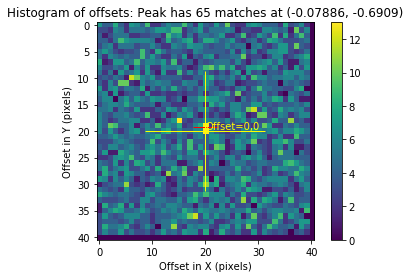

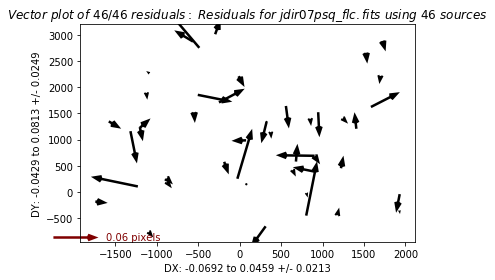

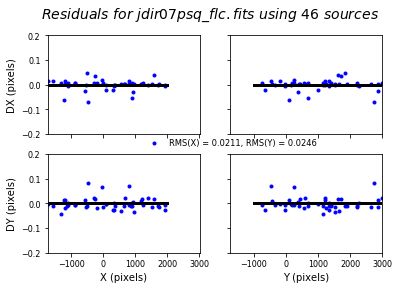

In [218]:
#aligning between filters:

#130, .9
#300, 1
tweakreg.TweakReg(list(pointing_3_814), #input_images - all 814 !
                  refimage = 'jdir05fxq_flc.fits', #a 606 filter
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':250,'conv_width':cw, 'searchrad':5},
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=0.5, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
                 # nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_3_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_3_814_606_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')

tweakreg.TweakReg(list(pointing_3_814_bad), #input_images - all 814 !
                  refimage = 'jdir05fxq_flc.fits', #a 606 filter
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':200,'conv_width':cw, 'searchrad':5},
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=0.5, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
                 # nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_3_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_3_814_606_1_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')


# pointing 5 alignment below

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 14:14:31.182 (22/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 14:14:31.182 (22/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir01ceq_flc.fits', 'jdir01chq_flc.fits', 'jdir04clq_flc.fits', 'jdir04ciq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir01ceq_flc.fits


    jdir01ceq_flc.fits


INFO:drizzlepac.tweakreg:    jdir01chq_flc.fits


    jdir01chq_flc.fits


INFO:drizzlepac.tweakreg:    jdir04clq_flc.fits


    jdir04clq_flc.fits


INFO:drizzlepac.tweakreg:    jdir04ciq_flc.fits


    jdir04ciq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir01ceq_flc.fits', 'jdir01chq_flc.fits', 'jdir04clq_flc.fits', 'jdir04ciq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlep

===  Source finding for image 'jdir01ceq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 14:14:31.541 (22/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 14:14:31.541 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.303110
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:32.781 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 838 objects.


     Found 838 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 14:14:32.895 (22/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 14:14:32.895 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.222228
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:34.033 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 962 objects.


     Found 962 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01ceq_flc.fits': 1800


===  FINAL number of objects in image 'jdir01ceq_flc.fits': 1800


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir01chq_flc.fits':


===  Source finding for image 'jdir01chq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01chq_flc.fits', EXT=('SCI', 1) started at: 14:14:34.4 (22/08/2019)


  #  Source finding for 'jdir01chq_flc.fits', EXT=('SCI', 1) started at: 14:14:34.4 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.031310
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:35.535 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 672 objects.


     Found 672 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01chq_flc.fits', EXT=('SCI', 2) started at: 14:14:35.644 (22/08/2019)


  #  Source finding for 'jdir01chq_flc.fits', EXT=('SCI', 2) started at: 14:14:35.644 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.151984
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:36.748 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 635 objects.


     Found 635 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01chq_flc.fits': 1307


===  FINAL number of objects in image 'jdir01chq_flc.fits': 1307


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir04clq_flc.fits':


===  Source finding for image 'jdir04clq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04clq_flc.fits', EXT=('SCI', 1) started at: 14:14:37.021 (22/08/2019)


  #  Source finding for 'jdir04clq_flc.fits', EXT=('SCI', 1) started at: 14:14:37.021 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.574120
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:38.167 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 467 objects.


     Found 467 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04clq_flc.fits', EXT=('SCI', 2) started at: 14:14:38.32 (22/08/2019)


  #  Source finding for 'jdir04clq_flc.fits', EXT=('SCI', 2) started at: 14:14:38.32 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.610513
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:39.396 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 540 objects.


     Found 540 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir04clq_flc.fits': 1007


===  FINAL number of objects in image 'jdir04clq_flc.fits': 1007


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir04ciq_flc.fits':


===  Source finding for image 'jdir04ciq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04ciq_flc.fits', EXT=('SCI', 1) started at: 14:14:39.893 (22/08/2019)


  #  Source finding for 'jdir04ciq_flc.fits', EXT=('SCI', 1) started at: 14:14:39.893 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.322698
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:41.157 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 317 objects.


     Found 317 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04ciq_flc.fits', EXT=('SCI', 2) started at: 14:14:41.274 (22/08/2019)


  #  Source finding for 'jdir04ciq_flc.fits', EXT=('SCI', 2) started at: 14:14:41.274 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.439434
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:42.345 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 318 objects.


     Found 318 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir04ciq_flc.fits': 635


===  FINAL number of objects in image 'jdir04ciq_flc.fits': 635


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir01ceq_flc.fits', 'jdir01chq_flc.fits', 'jdir04clq_flc.fits', 'jdir04ciq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg

===  Source finding for image 'jdir01ceq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 14:14:42.741 (22/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 14:14:42.741 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.303110
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:47.770 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 62660 objects.


     Found 62660 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 14:14:48.281 (22/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 14:14:48.281 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.222228
INFO:drizzlepac.catalogs:###Source finding finished at: 14:14:53.798 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 63988 objects.


     Found 63988 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01ceq_flc.fits': 126648


===  FINAL number of objects in image 'jdir01ceq_flc.fits': 126648


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir01ceq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir01ceq_flc.fits'


derived from 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.05
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.2
INFO:drizzlepac.tweakreg:	ylimit :	0.3
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir01ceq_flc.fits


Performing fit for: jdir01ceq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir01ceq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir01ceq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.imgclasses:NO fit performed for reference image: jdir01ceq_flc.fits

INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir01chq_flc.fits


Performing fit for: jdir01chq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir01chq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir01chq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.7924528301886795 -0.8328840970350413


Found initial X and Y shifts of  -0.7924528301886795 -0.8328840970350413


INFO:drizzlepac.tweakutils:    with significance of  888.8342393746686 and  102.0  matches


    with significance of  888.8342393746686 and  102.0  matches


INFO:drizzlepac.imgclasses:Found 335 matches for jdir01chq_flc.fits...


Found 335 matches for jdir01chq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir01chq_flc.fits : 


Computed  general  fit for  jdir01chq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0006  YSH: -0.0027    PROPER ROT: 5.959359921e-07    


XSH: -0.0006  YSH: -0.0027    PROPER ROT: 5.959359921e-07    


INFO:drizzlepac.imgclasses:<ROT>: 180.0000006  SKEW: -359.9999161    ROT_X: 359.9999587  ROT_Y: 4.252352333e-05


<ROT>: 180.0000006  SKEW: -359.9999161    ROT_X: 359.9999587  ROT_Y: 4.252352333e-05


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999736243  SCALE_X: 0.9999715872  SCALE_Y: 0.9999756614


<SCALE>: 0.9999736243  SCALE_X: 0.9999715872  SCALE_Y: 0.9999756614


INFO:drizzlepac.imgclasses:XRMS: 0.011    YRMS: 0.018


XRMS: 0.011    YRMS: 0.018


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3e-07 (deg)   RMS_DEC: 3.2e-08 (deg)


RMS_RA: 3e-07 (deg)   RMS_DEC: 3.2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  187  objects.


Final solution based on  187  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir01chq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir01chq_flc_catalog_fit.match


wrote XY data to:  jdir01chq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  187


Total # points:  187


INFO:drizzlepac.tweakutils:# of points after clipping:  187


# of points after clipping:  187


INFO:drizzlepac.tweakutils:Total # points:  187


Total # points:  187


INFO:drizzlepac.tweakutils:# of points after clipping:  187


# of points after clipping:  187


INFO:drizzlepac.imgclasses:Adding 972 new sources to the reference catalog for a total of 127620 sources.


Adding 972 new sources to the reference catalog for a total of 127620 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir01chq_flc.fits...


....Updating header for jdir01chq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir01chq_flc.fits['SCI',1]


Processing jdir01chq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir01chq_flc.fits[1]


Updating header for jdir01chq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.028121029916758e-06 1.1198871542636499e-05


CD_11  CD_12: 9.028121029916758e-06 1.1198871542636499e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494805810838454e-05 -8.358120480360091e-06


CD_21  CD_22: 1.0494805810838454e-05 -8.358120480360091e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96240374245917 14.555743792308135


CRVAL    : 209.96240374245917 14.555743792308135


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049835891855365765


Plate Scale : 0.049835891855365765


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73530319081357


ORIENTAT : 126.73530319081357


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir01chq_flc.fits['SCI',2]


Processing jdir01chq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir01chq_flc.fits[4]


Updating header for jdir01chq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.062029955817892e-06 1.0885811902648846e-05


CD_11  CD_12: 9.062029955817892e-06 1.0885811902648846e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250606155311251e-05 -7.99769020774728e-06


CD_21  CD_22: 1.0250606155311251e-05 -7.99769020774728e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98635083121877 14.538517215482592


CRVAL    : 209.98635083121877 14.538517215482592


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492535658264519


Plate Scale : 0.0492535658264519


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30432911734735


ORIENTAT : 126.30432911734735


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir04clq_flc.fits


Performing fit for: jdir04clq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir04clq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir04clq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  3.761124121779858 1.0796252927400474


Found initial X and Y shifts of  3.761124121779858 1.0796252927400474


INFO:drizzlepac.tweakutils:    with significance of  264.9075310367752 and  43.0  matches


    with significance of  264.9075310367752 and  43.0  matches


INFO:drizzlepac.imgclasses:Found 95 matches for jdir04clq_flc.fits...


Found 95 matches for jdir04clq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir04clq_flc.fits : 


Computed  general  fit for  jdir04clq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.5452  YSH: 1.4660    PROPER ROT: 359.9879544    


XSH: 4.5452  YSH: 1.4660    PROPER ROT: 359.9879544    


INFO:drizzlepac.imgclasses:<ROT>: 359.9879544  SKEW: 0.001267412287    ROT_X: 359.9873207  ROT_Y: 359.9885881


<ROT>: 359.9879544  SKEW: 0.001267412287    ROT_X: 359.9873207  ROT_Y: 359.9885881


INFO:drizzlepac.imgclasses:<SCALE>: 0.999981271  SCALE_X: 1.000002709  SCALE_Y: 0.9999598342


<SCALE>: 0.999981271  SCALE_X: 1.000002709  SCALE_Y: 0.9999598342


INFO:drizzlepac.imgclasses:XRMS: 0.064    YRMS: 0.074


XRMS: 0.064    YRMS: 0.074


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.4e-06 (deg)   RMS_DEC: 4.7e-08 (deg)


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 4.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  41  objects.


Final solution based on  41  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir04clq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir04clq_flc_catalog_fit.match


wrote XY data to:  jdir04clq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  41


Total # points:  41


INFO:drizzlepac.tweakutils:# of points after clipping:  41


# of points after clipping:  41


INFO:drizzlepac.tweakutils:Total # points:  41


Total # points:  41


INFO:drizzlepac.tweakutils:# of points after clipping:  41


# of points after clipping:  41


INFO:drizzlepac.imgclasses:Adding 912 new sources to the reference catalog for a total of 128557 sources.


Adding 912 new sources to the reference catalog for a total of 128557 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir04clq_flc.fits


Initializing new WCSCORR table for  jdir04clq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir04clq_flc.fits...


....Updating header for jdir04clq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04clq_flc.fits['SCI',1]


Processing jdir04clq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04clq_flc.fits[1]


Updating header for jdir04clq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.025346793462305e-06 1.1200559347591002e-05


CD_11  CD_12: 9.025346793462305e-06 1.1200559347591002e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0496304860779414e-05 -8.35583786748902e-06


CD_21  CD_22: 1.0496304860779414e-05 -8.35583786748902e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96088543276778 14.556583661569885


CRVAL    : 209.96088543276778 14.556583661569885


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983505041387125


Plate Scale : 0.04983505041387125


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.7236635793597


ORIENTAT : 126.7236635793597


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04clq_flc.fits['SCI',2]


Processing jdir04clq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04clq_flc.fits[4]


Updating header for jdir04clq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.059315022092882e-06 1.0887421822687891e-05


CD_11  CD_12: 9.059315022092882e-06 1.0887421822687891e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0252115754955979e-05 -7.995473996669067e-06


CD_21  CD_22: 1.0252115754955979e-05 -7.995473996669067e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.9848362036133 14.539361807660235


CRVAL    : 209.9848362036133 14.539361807660235


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492527373893142


Plate Scale : 0.0492527373893142


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.29271039691191


ORIENTAT : 126.29271039691191


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir04ciq_flc.fits


Performing fit for: jdir04ciq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir04ciq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir04ciq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  3.9694189602446492 1.1590214067278275


Found initial X and Y shifts of  3.9694189602446492 1.1590214067278275


INFO:drizzlepac.tweakutils:    with significance of  1068.8856680808155 and  85.0  matches


    with significance of  1068.8856680808155 and  85.0  matches


INFO:drizzlepac.imgclasses:Found 127 matches for jdir04ciq_flc.fits...


Found 127 matches for jdir04ciq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir04ciq_flc.fits : 


Computed  general  fit for  jdir04ciq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.5799  YSH: 1.4567    PROPER ROT: 359.9875936    


XSH: 4.5799  YSH: 1.4567    PROPER ROT: 359.9875936    


INFO:drizzlepac.imgclasses:<ROT>: 359.9875936  SKEW: -0.00191321883    ROT_X: 359.9885502  ROT_Y: 359.986637


<ROT>: 359.9875936  SKEW: -0.00191321883    ROT_X: 359.9885502  ROT_Y: 359.986637


INFO:drizzlepac.imgclasses:<SCALE>: 1.000042465  SCALE_X: 1.000014118  SCALE_Y: 1.000070813


<SCALE>: 1.000042465  SCALE_X: 1.000014118  SCALE_Y: 1.000070813


INFO:drizzlepac.imgclasses:XRMS: 0.04    YRMS: 0.041


XRMS: 0.04    YRMS: 0.041


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8.2e-07 (deg)   RMS_DEC: 7.2e-08 (deg)


RMS_RA: 8.2e-07 (deg)   RMS_DEC: 7.2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  55  objects.


Final solution based on  55  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir04ciq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir04ciq_flc_catalog_fit.match


wrote XY data to:  jdir04ciq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  55


Total # points:  55


INFO:drizzlepac.tweakutils:# of points after clipping:  55


# of points after clipping:  55


INFO:drizzlepac.tweakutils:Total # points:  55


Total # points:  55


INFO:drizzlepac.tweakutils:# of points after clipping:  55


# of points after clipping:  55


INFO:drizzlepac.imgclasses:Adding 508 new sources to the reference catalog for a total of 129070 sources.


Adding 508 new sources to the reference catalog for a total of 129070 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir04ciq_flc.fits


Initializing new WCSCORR table for  jdir04ciq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir04ciq_flc.fits...


....Updating header for jdir04ciq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04ciq_flc.fits['SCI',1]


Processing jdir04ciq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04ciq_flc.fits[1]


Updating header for jdir04ciq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.025752293678262e-06 1.1200032619477504e-05


CD_11  CD_12: 9.025752293678262e-06 1.1200032619477504e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0496384358089e-05 -8.354783979943384e-06


CD_21  CD_22: 1.0496384358089e-05 -8.354783979943384e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.9608853277714 14.556583061114056


CRVAL    : 209.9608853277714 14.556583061114056


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049836710347401864


Plate Scale : 0.049836710347401864


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72149130557428


ORIENTAT : 126.72149130557428


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04ciq_flc.fits['SCI',2]


Processing jdir04ciq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04ciq_flc.fits[4]


Updating header for jdir04ciq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.059708366535684e-06 1.0886916151939411e-05


CD_11  CD_12: 9.059708366535684e-06 1.0886916151939411e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0252208150615438e-05 -7.994455090091429e-06


CD_21  CD_22: 1.0252208150615438e-05 -7.994455090091429e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98483497625037 14.539363385444638


CRVAL    : 209.98483497625037 14.539363385444638


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254377926839225


Plate Scale : 0.049254377926839225


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.2904963862421


ORIENTAT : 126.2904963862421


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_5_606_shifts.txt


Writing out shiftfile : pointing_5_606_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 14:15:11.94 (22/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 14:15:11.94 (22/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir02zoq_flc.fits', 'jdir02zrq_flc.fits', 'jdir03bbq_flc.fits', 'jdir03beq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir02zoq_flc.fits


    jdir02zoq_flc.fits


INFO:drizzlepac.tweakreg:    jdir02zrq_flc.fits


    jdir02zrq_flc.fits


INFO:drizzlepac.tweakreg:    jdir03bbq_flc.fits


    jdir03bbq_flc.fits


INFO:drizzlepac.tweakreg:    jdir03beq_flc.fits


    jdir03beq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir02zoq_flc.fits', 'jdir02zrq_flc.fits', 'jdir03bbq_flc.fits', 'jdir03beq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlep

===  Source finding for image 'jdir02zoq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02zoq_flc.fits', EXT=('SCI', 1) started at: 14:15:12.404 (22/08/2019)


  #  Source finding for 'jdir02zoq_flc.fits', EXT=('SCI', 1) started at: 14:15:12.404 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.853527
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:13.59 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 539 objects.


     Found 539 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02zoq_flc.fits', EXT=('SCI', 2) started at: 14:15:13.74 (22/08/2019)


  #  Source finding for 'jdir02zoq_flc.fits', EXT=('SCI', 2) started at: 14:15:13.74 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.825502
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:15.020 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 609 objects.


     Found 609 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir02zoq_flc.fits': 1148


===  FINAL number of objects in image 'jdir02zoq_flc.fits': 1148


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir02zrq_flc.fits':


===  Source finding for image 'jdir02zrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02zrq_flc.fits', EXT=('SCI', 1) started at: 14:15:15.357 (22/08/2019)


  #  Source finding for 'jdir02zrq_flc.fits', EXT=('SCI', 1) started at: 14:15:15.357 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.508029
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:16.462 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 651 objects.


     Found 651 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02zrq_flc.fits', EXT=('SCI', 2) started at: 14:15:16.561 (22/08/2019)


  #  Source finding for 'jdir02zrq_flc.fits', EXT=('SCI', 2) started at: 14:15:16.561 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.441129
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:17.618 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 706 objects.


     Found 706 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir02zrq_flc.fits': 1357


===  FINAL number of objects in image 'jdir02zrq_flc.fits': 1357


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir03bbq_flc.fits':


===  Source finding for image 'jdir03bbq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bbq_flc.fits', EXT=('SCI', 1) started at: 14:15:17.965 (22/08/2019)


  #  Source finding for 'jdir03bbq_flc.fits', EXT=('SCI', 1) started at: 14:15:17.965 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.602768
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:19.163 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 365 objects.


     Found 365 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bbq_flc.fits', EXT=('SCI', 2) started at: 14:15:19.337 (22/08/2019)


  #  Source finding for 'jdir03bbq_flc.fits', EXT=('SCI', 2) started at: 14:15:19.337 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.563029
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:20.577 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 447 objects.


     Found 447 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir03bbq_flc.fits': 812


===  FINAL number of objects in image 'jdir03bbq_flc.fits': 812


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir03beq_flc.fits':


===  Source finding for image 'jdir03beq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03beq_flc.fits', EXT=('SCI', 1) started at: 14:15:21.018 (22/08/2019)


  #  Source finding for 'jdir03beq_flc.fits', EXT=('SCI', 1) started at: 14:15:21.018 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.628364
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:22.221 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 751 objects.


     Found 751 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03beq_flc.fits', EXT=('SCI', 2) started at: 14:15:22.336 (22/08/2019)


  #  Source finding for 'jdir03beq_flc.fits', EXT=('SCI', 2) started at: 14:15:22.336 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.707399
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:23.794 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 813 objects.


     Found 813 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir03beq_flc.fits': 1564


===  FINAL number of objects in image 'jdir03beq_flc.fits': 1564


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir02zoq_flc.fits', 'jdir02zrq_flc.fits', 'jdir03bbq_flc.fits', 'jdir03beq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg

===  Source finding for image 'jdir01ceq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 14:15:24.208 (22/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 14:15:24.208 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.303110
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:30.222 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 62660 objects.


     Found 62660 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 14:15:30.857 (22/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 14:15:30.857 (22/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.222228
INFO:drizzlepac.catalogs:###Source finding finished at: 14:15:36.006 (22/08/2019)
INFO:drizzlepac.catalogs:     Found 63988 objects.


     Found 63988 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01ceq_flc.fits': 126648


===  FINAL number of objects in image 'jdir01ceq_flc.fits': 126648


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir01ceq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir01ceq_flc.fits'


derived from 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.05
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.0
INFO:drizzlepac.tweakreg:	ylimit :	0.3
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir02zoq_flc.fits


Performing fit for: jdir02zoq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir02zoq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir02zoq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.910588235294117 1.0611764705882365


Found initial X and Y shifts of  4.910588235294117 1.0611764705882365


INFO:drizzlepac.tweakutils:    with significance of  395.81814005929544 and  24.0  matches


    with significance of  395.81814005929544 and  24.0  matches


INFO:drizzlepac.imgclasses:Found 92 matches for jdir02zoq_flc.fits...


Found 92 matches for jdir02zoq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir02zoq_flc.fits : 


Computed  general  fit for  jdir02zoq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 5.1009  YSH: 2.0326    PROPER ROT: 359.9884654    


XSH: 5.1009  YSH: 2.0326    PROPER ROT: 359.9884654    


INFO:drizzlepac.imgclasses:<ROT>: 359.9884654  SKEW: 0.001953034812    ROT_X: 359.9874889  ROT_Y: 359.9894419


<ROT>: 359.9884654  SKEW: 0.001953034812    ROT_X: 359.9874889  ROT_Y: 359.9894419


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999654288  SCALE_X: 0.9999353424  SCALE_Y: 0.9999955167


<SCALE>: 0.9999654288  SCALE_X: 0.9999353424  SCALE_Y: 0.9999955167


INFO:drizzlepac.imgclasses:XRMS: 0.057    YRMS: 0.069


XRMS: 0.057    YRMS: 0.069


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 1.9e-08 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 1.9e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  29  objects.


Final solution based on  29  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir02zoq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir02zoq_flc_catalog_fit.match


wrote XY data to:  jdir02zoq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  29


Total # points:  29


INFO:drizzlepac.tweakutils:# of points after clipping:  29


# of points after clipping:  29


INFO:drizzlepac.tweakutils:Total # points:  29


Total # points:  29


INFO:drizzlepac.tweakutils:# of points after clipping:  29


# of points after clipping:  29


INFO:drizzlepac.imgclasses:Adding 1056 new sources to the reference catalog for a total of 127704 sources.


Adding 1056 new sources to the reference catalog for a total of 127704 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir02zoq_flc.fits...


....Updating header for jdir02zoq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02zoq_flc.fits['SCI',1]


Processing jdir02zoq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir02zoq_flc.fits[1]


Updating header for jdir02zoq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.026300681652983e-06 1.1200472205824485e-05


CD_11  CD_12: 9.026300681652983e-06 1.1200472205824485e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.049739822604804e-05 -8.35598832759384e-06


CD_21  CD_22: 1.049739822604804e-05 -8.35598832759384e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96160458220507 14.55614449383163


CRVAL    : 209.96160458220507 14.55614449383163


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049836938392939976


Plate Scale : 0.049836938392939976


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72437169872292


ORIENTAT : 126.72437169872292


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02zoq_flc.fits['SCI',2]


Processing jdir02zoq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02zoq_flc.fits[4]


Updating header for jdir02zoq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.060255049117942e-06 1.0887344814678183e-05


CD_11  CD_12: 9.060255049117942e-06 1.0887344814678183e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0253193446871311e-05 -7.995611245495019e-06


CD_21  CD_22: 1.0253193446871311e-05 -7.995611245495019e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98555512374432 14.538922333754957


CRVAL    : 209.98555512374432 14.538922333754957


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925460187910557


Plate Scale : 0.04925460187910557


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.29337296210902


ORIENTAT : 126.29337296210902


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir02zrq_flc.fits


Performing fit for: jdir02zrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir02zrq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir02zrq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.20659062103929 1.1825095057034218


Found initial X and Y shifts of  4.20659062103929 1.1825095057034218


INFO:drizzlepac.tweakutils:    with significance of  873.7962328267628 and  100.0  matches


    with significance of  873.7962328267628 and  100.0  matches


INFO:drizzlepac.imgclasses:Found 356 matches for jdir02zrq_flc.fits...


Found 356 matches for jdir02zrq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir02zrq_flc.fits : 


Computed  general  fit for  jdir02zrq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 5.0996  YSH: 2.0326    PROPER ROT: 359.9885086    


XSH: 5.0996  YSH: 2.0326    PROPER ROT: 359.9885086    


INFO:drizzlepac.imgclasses:<ROT>: 359.9885086  SKEW: -0.002013685623    ROT_X: 359.9895155  ROT_Y: 359.9875018


<ROT>: 359.9885086  SKEW: -0.002013685623    ROT_X: 359.9895155  ROT_Y: 359.9875018


INFO:drizzlepac.imgclasses:<SCALE>: 1.000000133  SCALE_X: 1.000030605  SCALE_Y: 0.9999696632


<SCALE>: 1.000000133  SCALE_X: 1.000030605  SCALE_Y: 0.9999696632


INFO:drizzlepac.imgclasses:XRMS: 0.0068    YRMS: 0.0086


XRMS: 0.0068    YRMS: 0.0086


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.6e-07 (deg)   RMS_DEC: 9.7e-10 (deg)


RMS_RA: 1.6e-07 (deg)   RMS_DEC: 9.7e-10 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  174  objects.


Final solution based on  174  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir02zrq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir02zrq_flc_catalog_fit.match


wrote XY data to:  jdir02zrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  174


Total # points:  174


INFO:drizzlepac.tweakutils:# of points after clipping:  174


# of points after clipping:  174


INFO:drizzlepac.tweakutils:Total # points:  174


Total # points:  174


INFO:drizzlepac.tweakutils:# of points after clipping:  174


# of points after clipping:  174


INFO:drizzlepac.imgclasses:Adding 1001 new sources to the reference catalog for a total of 128707 sources.


Adding 1001 new sources to the reference catalog for a total of 128707 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir02zrq_flc.fits...


....Updating header for jdir02zrq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02zrq_flc.fits['SCI',1]


Processing jdir02zrq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02zrq_flc.fits[1]


Updating header for jdir02zrq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.025562187302532e-06 1.1200652211633726e-05


CD_11  CD_12: 9.025562187302532e-06 1.1200652211633726e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0495713639918368e-05 -8.355617843552782e-06


CD_21  CD_22: 1.0495713639918368e-05 -8.355617843552782e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96160457663092 14.556144553194143


CRVAL    : 209.96160457663092 14.556144553194143


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983524715254719


Plate Scale : 0.04983524715254719


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72271281070304


ORIENTAT : 126.72271281070304


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02zrq_flc.fits['SCI',2]


Processing jdir02zrq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02zrq_flc.fits[4]


Updating header for jdir02zrq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.059528173890087e-06 1.08875132003714e-05


CD_11  CD_12: 9.059528173890087e-06 1.08875132003714e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0251535155029099e-05 -7.995265951360302e-06


CD_21  CD_22: 1.0251535155029099e-05 -7.995265951360302e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98555549913658 14.538923151288472


CRVAL    : 209.98555549913658 14.538923151288472


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492529304005813


Plate Scale : 0.0492529304005813


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.2917697119144


ORIENTAT : 126.2917697119144


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir03bbq_flc.fits


Performing fit for: jdir03bbq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir03bbq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir03bbq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  2.229050279329609 -0.11452513966480637


Found initial X and Y shifts of  2.229050279329609 -0.11452513966480637


INFO:drizzlepac.tweakutils:    with significance of  428.8029850642367 and  24.0  matches


    with significance of  428.8029850642367 and  24.0  matches


INFO:drizzlepac.imgclasses:Found 88 matches for jdir03bbq_flc.fits...


Found 88 matches for jdir03bbq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir03bbq_flc.fits : 


Computed  general  fit for  jdir03bbq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 3.0782  YSH: 0.8585    PROPER ROT: 359.9932234    


XSH: 3.0782  YSH: 0.8585    PROPER ROT: 359.9932234    


INFO:drizzlepac.imgclasses:<ROT>: 359.9932234  SKEW: -0.0008365164899    ROT_X: 359.9936416  ROT_Y: 359.9928051


<ROT>: 359.9932234  SKEW: -0.0008365164899    ROT_X: 359.9936416  ROT_Y: 359.9928051


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999970536  SCALE_X: 0.9999991837  SCALE_Y: 0.9999949235


<SCALE>: 0.9999970536  SCALE_X: 0.9999991837  SCALE_Y: 0.9999949235


INFO:drizzlepac.imgclasses:XRMS: 0.062    YRMS: 0.062


XRMS: 0.062    YRMS: 0.062


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 1.2e-07 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 1.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  31  objects.


Final solution based on  31  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir03bbq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir03bbq_flc_catalog_fit.match


wrote XY data to:  jdir03bbq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  31


Total # points:  31


INFO:drizzlepac.tweakutils:# of points after clipping:  31


# of points after clipping:  31


INFO:drizzlepac.tweakutils:Total # points:  31


Total # points:  31


INFO:drizzlepac.tweakutils:# of points after clipping:  31


# of points after clipping:  31


INFO:drizzlepac.imgclasses:Adding 724 new sources to the reference catalog for a total of 129439 sources.


Adding 724 new sources to the reference catalog for a total of 129439 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir03bbq_flc.fits


Initializing new WCSCORR table for  jdir03bbq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir03bbq_flc.fits...


....Updating header for jdir03bbq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bbq_flc.fits['SCI',1]


Processing jdir03bbq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bbq_flc.fits[1]


Updating header for jdir03bbq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.02688632538594e-06 1.1199913402736045e-05


CD_11  CD_12: 9.02688632538594e-06 1.1199913402736045e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0495673763498908e-05 -8.35669881937055e-06


CD_21  CD_22: 1.0495673763498908e-05 -8.35669881937055e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96232431882044 14.555671484222417


CRVAL    : 209.96232431882044 14.555671484222417


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983671337091588


Plate Scale : 0.04983671337091588


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72807669511725


ORIENTAT : 126.72807669511725


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bbq_flc.fits['SCI',2]


Processing jdir03bbq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bbq_flc.fits[4]


Updating header for jdir03bbq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.060826244259824e-06 1.0886809276189323e-05


CD_11  CD_12: 9.060826244259824e-06 1.0886809276189323e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0251481302478537e-05 -7.996310249462056e-06


CD_21  CD_22: 1.0251481302478537e-05 -7.996310249462056e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98627361859187 14.538447848760198


CRVAL    : 209.98627361859187 14.538447848760198


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254380808622225


Plate Scale : 0.049254380808622225


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.297107269283


ORIENTAT : 126.297107269283


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir03beq_flc.fits


Performing fit for: jdir03beq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir03beq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir03beq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  2.1018237082066875 0.02583586626139933


Found initial X and Y shifts of  2.1018237082066875 0.02583586626139933


INFO:drizzlepac.tweakutils:    with significance of  609.7458486943556 and  55.0  matches


    with significance of  609.7458486943556 and  55.0  matches


INFO:drizzlepac.imgclasses:Found 186 matches for jdir03beq_flc.fits...


Found 186 matches for jdir03beq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir03beq_flc.fits : 


Computed  general  fit for  jdir03beq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 3.0472  YSH: 0.8589    PROPER ROT: 359.9933912    


XSH: 3.0472  YSH: 0.8589    PROPER ROT: 359.9933912    


INFO:drizzlepac.imgclasses:<ROT>: 359.9933912  SKEW: 0.0009426219876    ROT_X: 359.9929199  ROT_Y: 359.9938625


<ROT>: 359.9933912  SKEW: 0.0009426219876    ROT_X: 359.9929199  ROT_Y: 359.9938625


INFO:drizzlepac.imgclasses:<SCALE>: 0.999975532  SCALE_X: 0.9999751213  SCALE_Y: 0.9999759428


<SCALE>: 0.999975532  SCALE_X: 0.9999751213  SCALE_Y: 0.9999759428


INFO:drizzlepac.imgclasses:XRMS: 0.05    YRMS: 0.051


XRMS: 0.05    YRMS: 0.051


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1e-06 (deg)   RMS_DEC: 8.7e-08 (deg)


RMS_RA: 1e-06 (deg)   RMS_DEC: 8.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  76  objects.


Final solution based on  76  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir03beq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir03beq_flc_catalog_fit.match


wrote XY data to:  jdir03beq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  76


Total # points:  76


INFO:drizzlepac.tweakutils:# of points after clipping:  76


# of points after clipping:  76


INFO:drizzlepac.tweakutils:Total # points:  76


Total # points:  76


INFO:drizzlepac.tweakutils:# of points after clipping:  76


# of points after clipping:  76


INFO:drizzlepac.imgclasses:Adding 1378 new sources to the reference catalog for a total of 130821 sources.


Adding 1378 new sources to the reference catalog for a total of 130821 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir03beq_flc.fits


Initializing new WCSCORR table for  jdir03beq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir03beq_flc.fits...


....Updating header for jdir03beq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03beq_flc.fits['SCI',1]


Processing jdir03beq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03beq_flc.fits[1]


Updating header for jdir03beq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.026660821926926e-06 1.1199586884042538e-05


CD_11  CD_12: 9.026660821926926e-06 1.1199586884042538e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0495681602654736e-05 -8.356772623252295e-06


CD_21  CD_22: 1.0495681602654736e-05 -8.356772623252295e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96232459156218 14.555671809498845


CRVAL    : 209.96232459156218 14.555671809498845


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983505236393844


Plate Scale : 0.04983505236393844


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72911986319527


ORIENTAT : 126.72911986319527


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03beq_flc.fits['SCI',2]


Processing jdir03beq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03beq_flc.fits[4]


Updating header for jdir03beq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.060599317797114e-06 1.0886492140157667e-05


CD_11  CD_12: 9.060599317797114e-06 1.0886492140157667e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0251488094572969e-05 -7.996381462857859e-06


CD_21  CD_22: 1.0251488094572969e-05 -7.996381462857859e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98627319327414 14.538448021599542


CRVAL    : 209.98627319327414 14.538448021599542


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492527392101969


Plate Scale : 0.0492527392101969


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.29814704413123


ORIENTAT : 126.29814704413123


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_606_wcs


WCSNAME  :  pointing_5_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_5_606_1_shifts.txt


Writing out shiftfile : pointing_5_606_1_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


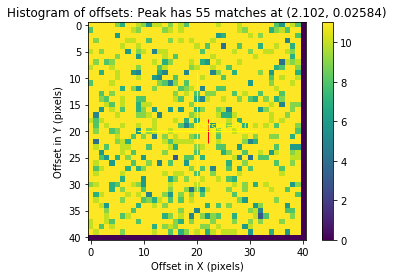

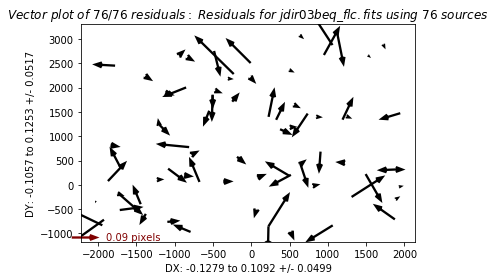

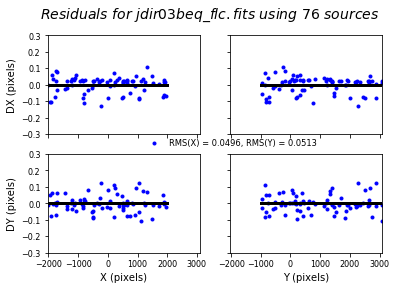

In [7]:
cw = 3.5
#230, 1.2 
tweakreg.TweakReg(list(pointing_5_606), #input_images, # Pass input images
                  refimage = 'jdir01ceq_flc.fits',
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':200,'conv_width':cw, 'searchrad':5},
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=.05, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.2,
                  ylimit = 0.3,
                  labelsize=8,
               #   nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_5_606_wcs', # Give our WCS a new name
                  outshifts = 'pointing_5_606_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')

#200, 1 is all under .1
tweakreg.TweakReg(list(pointing_5_606_bad), #input_images, # Pass input images
                  refimage = 'jdir01ceq_flc.fits',
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':190,'conv_width':cw, 'searchrad':5},
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=.05, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.3,
                  labelsize=8,
                 # nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_5_606_wcs', # Give our WCS a new name
                  outshifts = 'pointing_5_606_1_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 09:10:12.166 (23/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 09:10:12.166 (23/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir01cjq_flc.fits', 'jdir01coq_flc.fits', 'jdir02zyq_flc.fits', 'jdir02ztq_flc.fits', 'jdir03bmq_flc.fits', 'jdir03bhq_flc.fits', 'jdir04cnq_flc.fits', 'jdir04csq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir01cjq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir01cjq_flc.fits


    jdir01cjq_flc.fits


INFO:drizzlepac.tweakreg:    jdir01coq_flc.fits


    jdir01coq_flc.fits


INFO:drizzlepac.tweakreg:    jdir02zyq_flc.fits


    jdir02zyq_flc.fits


INFO:drizzlepac.tweakreg:    jdir02ztq_flc.fits


    jdir02ztq_flc.fits


INFO:drizzlepac.tweakreg:    jdir03bmq_flc.fits


    jdir03bmq_flc.fits


INFO:drizzlepac.tweakreg:    jdir03bhq_flc.fits


    jdir03bhq_flc.fits


INFO:drizzlepac.tweakreg:    jdir04cnq_flc.fits


    jdir04cnq_flc.fits


INFO:drizzlepac.tweakreg:    jdir04csq_flc.fits


    jdir04csq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir01cjq_flc.fits', 'jdir01coq_flc.fits', 'jdir02zyq_flc.fits', 'jdir02ztq_flc.fits', 'jdir03bmq_flc.fits', 'jdir03bhq_flc.fits', 'jdir04cnq_flc.fits', 'jdir04csq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01cjq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepa

===  Source finding for image 'jdir01cjq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 1) started at: 09:10:12.583 (23/08/2019)


  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 1) started at: 09:10:12.583 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.877475
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:14.023 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 3681 objects.


     Found 3681 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 2) started at: 09:10:14.230 (23/08/2019)


  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 2) started at: 09:10:14.230 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.716096
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:15.444 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 3968 objects.


     Found 3968 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01cjq_flc.fits': 7649


===  FINAL number of objects in image 'jdir01cjq_flc.fits': 7649


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir01coq_flc.fits':


===  Source finding for image 'jdir01coq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01coq_flc.fits', EXT=('SCI', 1) started at: 09:10:15.924 (23/08/2019)


  #  Source finding for 'jdir01coq_flc.fits', EXT=('SCI', 1) started at: 09:10:15.924 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.656259
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:17.105 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2641 objects.


     Found 2641 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01coq_flc.fits', EXT=('SCI', 2) started at: 09:10:17.216 (23/08/2019)


  #  Source finding for 'jdir01coq_flc.fits', EXT=('SCI', 2) started at: 09:10:17.216 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.598059
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:18.315 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2735 objects.


     Found 2735 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01coq_flc.fits': 5376


===  FINAL number of objects in image 'jdir01coq_flc.fits': 5376


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir02zyq_flc.fits':


===  Source finding for image 'jdir02zyq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02zyq_flc.fits', EXT=('SCI', 1) started at: 09:10:18.690 (23/08/2019)


  #  Source finding for 'jdir02zyq_flc.fits', EXT=('SCI', 1) started at: 09:10:18.690 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.861730
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:19.894 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2388 objects.


     Found 2388 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02zyq_flc.fits', EXT=('SCI', 2) started at: 09:10:20.028 (23/08/2019)


  #  Source finding for 'jdir02zyq_flc.fits', EXT=('SCI', 2) started at: 09:10:20.028 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.860226
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:21.109 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2519 objects.


     Found 2519 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir02zyq_flc.fits': 4907


===  FINAL number of objects in image 'jdir02zyq_flc.fits': 4907


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir02ztq_flc.fits':


===  Source finding for image 'jdir02ztq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02ztq_flc.fits', EXT=('SCI', 1) started at: 09:10:21.440 (23/08/2019)


  #  Source finding for 'jdir02ztq_flc.fits', EXT=('SCI', 1) started at: 09:10:21.440 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.121102
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:22.506 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2305 objects.


     Found 2305 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02ztq_flc.fits', EXT=('SCI', 2) started at: 09:10:22.613 (23/08/2019)


  #  Source finding for 'jdir02ztq_flc.fits', EXT=('SCI', 2) started at: 09:10:22.613 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.015579
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:23.750 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2446 objects.


     Found 2446 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir02ztq_flc.fits': 4751


===  FINAL number of objects in image 'jdir02ztq_flc.fits': 4751


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir03bmq_flc.fits':


===  Source finding for image 'jdir03bmq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 1) started at: 09:10:24.084 (23/08/2019)


  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 1) started at: 09:10:24.084 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.138226
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:25.142 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2451 objects.


     Found 2451 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 2) started at: 09:10:25.247 (23/08/2019)


  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 2) started at: 09:10:25.247 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.039661
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:26.318 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2510 objects.


     Found 2510 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir03bmq_flc.fits': 4961


===  FINAL number of objects in image 'jdir03bmq_flc.fits': 4961


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir03bhq_flc.fits':


===  Source finding for image 'jdir03bhq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 1) started at: 09:10:26.673 (23/08/2019)


  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 1) started at: 09:10:26.673 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.559079
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:27.708 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1523 objects.


     Found 1523 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 2) started at: 09:10:27.799 (23/08/2019)


  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 2) started at: 09:10:27.799 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.668103
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:28.824 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1700 objects.


     Found 1700 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir03bhq_flc.fits': 3223


===  FINAL number of objects in image 'jdir03bhq_flc.fits': 3223


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir04cnq_flc.fits':


===  Source finding for image 'jdir04cnq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04cnq_flc.fits', EXT=('SCI', 1) started at: 09:10:29.098 (23/08/2019)


  #  Source finding for 'jdir04cnq_flc.fits', EXT=('SCI', 1) started at: 09:10:29.098 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.626578
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:30.127 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1491 objects.


     Found 1491 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04cnq_flc.fits', EXT=('SCI', 2) started at: 09:10:30.218 (23/08/2019)


  #  Source finding for 'jdir04cnq_flc.fits', EXT=('SCI', 2) started at: 09:10:30.218 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.641146
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:31.238 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1513 objects.


     Found 1513 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir04cnq_flc.fits': 3004


===  FINAL number of objects in image 'jdir04cnq_flc.fits': 3004


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir04csq_flc.fits':


===  Source finding for image 'jdir04csq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04csq_flc.fits', EXT=('SCI', 1) started at: 09:10:31.520 (23/08/2019)


  #  Source finding for 'jdir04csq_flc.fits', EXT=('SCI', 1) started at: 09:10:31.520 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.057237
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:32.578 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1902 objects.


     Found 1902 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04csq_flc.fits', EXT=('SCI', 2) started at: 09:10:32.682 (23/08/2019)


  #  Source finding for 'jdir04csq_flc.fits', EXT=('SCI', 2) started at: 09:10:32.682 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.014957
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:33.719 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1998 objects.


     Found 1998 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir04csq_flc.fits': 3900


===  FINAL number of objects in image 'jdir04csq_flc.fits': 3900


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir01cjq_flc.fits', 'jdir01coq_flc.fits', 'jdir02zyq_flc.fits', 'jdir02ztq_flc.fits', 'jdir03bmq_flc.fits', 'jdir03bhq_flc.fits', 'jdir04cnq_flc.fits', 'jdir04csq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01cjq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	

===  Source finding for image 'jdir01cjq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 1) started at: 09:10:34.226 (23/08/2019)


  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 1) started at: 09:10:34.226 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.877475
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:35.094 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 9750 objects.


     Found 9750 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 2) started at: 09:10:35.245 (23/08/2019)


  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 2) started at: 09:10:35.245 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.716096
INFO:drizzlepac.catalogs:###Source finding finished at: 09:10:36.268 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 10394 objects.


     Found 10394 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01cjq_flc.fits': 20144


===  FINAL number of objects in image 'jdir01cjq_flc.fits': 20144


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir01cjq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir01cjq_flc.fits'


derived from 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.1
INFO:drizzlepac.tweakreg:	ylimit :	0.3
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	ou

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir01cjq_flc.fits


Performing fit for: jdir01cjq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir01cjq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir01cjq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.imgclasses:NO fit performed for reference image: jdir01cjq_flc.fits

INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir01coq_flc.fits


Performing fit for: jdir01coq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir01coq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir01coq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.6215538847117799 -0.8237259816207185


Found initial X and Y shifts of  -0.6215538847117799 -0.8237259816207185


INFO:drizzlepac.tweakutils:    with significance of  1570.6965215602695 and  362.0  matches


    with significance of  1570.6965215602695 and  362.0  matches


INFO:drizzlepac.imgclasses:Found 934 matches for jdir01coq_flc.fits...


Found 934 matches for jdir01coq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir01coq_flc.fits : 


Computed  general  fit for  jdir01coq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0006  YSH: -0.0007    PROPER ROT: 1.243734035e-05    


XSH: -0.0006  YSH: -0.0007    PROPER ROT: 1.243734035e-05    


INFO:drizzlepac.imgclasses:<ROT>: 1.243734035e-05  SKEW: -3.156061455e-06    ROT_X: 1.401537108e-05  ROT_Y: 1.085930963e-05


<ROT>: 1.243734035e-05  SKEW: -3.156061455e-06    ROT_X: 1.401537108e-05  ROT_Y: 1.085930963e-05


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999717046  SCALE_X: 0.9999705201  SCALE_Y: 0.9999728891


<SCALE>: 0.9999717046  SCALE_X: 0.9999705201  SCALE_Y: 0.9999728891


INFO:drizzlepac.imgclasses:XRMS: 0.0067    YRMS: 0.0066


XRMS: 0.0067    YRMS: 0.0066


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-07 (deg)   RMS_DEC: 1.4e-08 (deg)


RMS_RA: 1.3e-07 (deg)   RMS_DEC: 1.4e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  478  objects.


Final solution based on  478  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir01coq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir01coq_flc_catalog_fit.match


wrote XY data to:  jdir01coq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  478


Total # points:  478


INFO:drizzlepac.tweakutils:# of points after clipping:  478


# of points after clipping:  478


INFO:drizzlepac.tweakutils:Total # points:  478


Total # points:  478


INFO:drizzlepac.tweakutils:# of points after clipping:  478


# of points after clipping:  478


INFO:drizzlepac.imgclasses:Adding 4442 new sources to the reference catalog for a total of 24586 sources.


Adding 4442 new sources to the reference catalog for a total of 24586 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir01coq_flc.fits...


....Updating header for jdir01coq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir01coq_flc.fits['SCI',1]


Processing jdir01coq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir01coq_flc.fits[1]


Updating header for jdir01coq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.032482861016034e-06 1.1195105980881743e-05


CD_11  CD_12: 9.032482861016034e-06 1.1195105980881743e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.049111453817049e-05 -8.362612612448953e-06


CD_21  CD_22: 1.049111453817049e-05 -8.362612612448953e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96240372016 14.555743809061793


CRVAL    : 209.96240372016 14.555743809061793


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983600699546115


Plate Scale : 0.04983600699546115


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75929909449268


ORIENTAT : 126.75929909449268


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir01coq_flc.fits['SCI',2]


Processing jdir01coq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir01coq_flc.fits[4]


Updating header for jdir01coq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.066218513517469e-06 1.0882073660728843e-05


CD_11  CD_12: 9.066218513517469e-06 1.0882073660728843e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0246857795219485e-05 -8.002123673809296e-06


CD_21  CD_22: 1.0246857795219485e-05 -8.002123673809296e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98634319586327 14.53850756726224


CRVAL    : 209.98634319586327 14.53850756726224


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492533913824239


Plate Scale : 0.0492533913824239


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32887270150016


ORIENTAT : 126.32887270150016


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir02zyq_flc.fits


Performing fit for: jdir02zyq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir02zyq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir02zyq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.043083900226758 2.013605442176871


Found initial X and Y shifts of  4.043083900226758 2.013605442176871


INFO:drizzlepac.tweakutils:    with significance of  506.0865234629048 and  36.0  matches


    with significance of  506.0865234629048 and  36.0  matches


INFO:drizzlepac.imgclasses:Found 127 matches for jdir02zyq_flc.fits...


Found 127 matches for jdir02zyq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir02zyq_flc.fits : 


Computed  general  fit for  jdir02zyq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 5.0528  YSH: 2.2393    PROPER ROT: 359.9882671    


XSH: 5.0528  YSH: 2.2393    PROPER ROT: 359.9882671    


INFO:drizzlepac.imgclasses:<ROT>: 359.9882671  SKEW: 0.0007496291408    ROT_X: 359.9878923  ROT_Y: 359.9886419


<ROT>: 359.9882671  SKEW: 0.0007496291408    ROT_X: 359.9878923  ROT_Y: 359.9886419


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999775118  SCALE_X: 0.9999767955  SCALE_Y: 0.9999782282


<SCALE>: 0.9999775118  SCALE_X: 0.9999767955  SCALE_Y: 0.9999782282


INFO:drizzlepac.imgclasses:XRMS: 0.067    YRMS: 0.075


XRMS: 0.067    YRMS: 0.075


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.4e-06 (deg)   RMS_DEC: 6.8e-08 (deg)


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 6.8e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  50  objects.


Final solution based on  50  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir02zyq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir02zyq_flc_catalog_fit.match


wrote XY data to:  jdir02zyq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  50


Total # points:  50


INFO:drizzlepac.tweakutils:# of points after clipping:  50


# of points after clipping:  50


INFO:drizzlepac.tweakutils:Total # points:  50


Total # points:  50


INFO:drizzlepac.tweakutils:# of points after clipping:  50


# of points after clipping:  50


INFO:drizzlepac.imgclasses:Adding 4780 new sources to the reference catalog for a total of 29367 sources.


Adding 4780 new sources to the reference catalog for a total of 29367 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir02zyq_flc.fits...


....Updating header for jdir02zyq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02zyq_flc.fits['SCI',1]


Processing jdir02zyq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02zyq_flc.fits[1]


Updating header for jdir02zyq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.030060706102913e-06 1.1196591797761343e-05


CD_11  CD_12: 9.030060706102913e-06 1.1196591797761343e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0492843017956246e-05 -8.360200743960395e-06


CD_21  CD_22: 1.0492843017956246e-05 -8.360200743960395e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96160270409925 14.5561468413747


CRVAL    : 209.96160270409925 14.5561468413747


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983536680303179


Plate Scale : 0.04983536680303179


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.74773007626732


ORIENTAT : 126.74773007626732


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02zyq_flc.fits['SCI',2]


Processing jdir02zyq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02zyq_flc.fits[4]


Updating header for jdir02zyq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.063847927135455e-06 1.088349115317681e-05


CD_11  CD_12: 9.063847927135455e-06 1.088349115317681e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0248595803305527e-05 -7.999780931900339e-06


CD_21  CD_22: 1.0248595803305527e-05 -7.999780931900339e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98554538502077 14.53891559068071


CRVAL    : 209.98554538502077 14.53891559068071


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925276047612584


Plate Scale : 0.04925276047612584


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.31730463767992


ORIENTAT : 126.31730463767992


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir02ztq_flc.fits


Performing fit for: jdir02ztq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir02ztq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir02ztq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.26131386861314 1.862773722627736


Found initial X and Y shifts of  4.26131386861314 1.862773722627736


INFO:drizzlepac.tweakutils:    with significance of  1892.3726603695916 and  540.0  matches


    with significance of  1892.3726603695916 and  540.0  matches


INFO:drizzlepac.imgclasses:Found 998 matches for jdir02ztq_flc.fits...


Found 998 matches for jdir02ztq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir02ztq_flc.fits : 


Computed  general  fit for  jdir02ztq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 5.0548  YSH: 2.2416    PROPER ROT: 359.9882753    


XSH: 5.0548  YSH: 2.2416    PROPER ROT: 359.9882753    


INFO:drizzlepac.imgclasses:<ROT>: 359.9882753  SKEW: -0.0007510135612    ROT_X: 359.9886508  ROT_Y: 359.9878998


<ROT>: 359.9882753  SKEW: -0.0007510135612    ROT_X: 359.9886508  ROT_Y: 359.9878998


INFO:drizzlepac.imgclasses:<SCALE>: 1.000057169  SCALE_X: 1.000057954  SCALE_Y: 1.000056384


<SCALE>: 1.000057169  SCALE_X: 1.000057954  SCALE_Y: 1.000056384


INFO:drizzlepac.imgclasses:XRMS: 0.0072    YRMS: 0.0081


XRMS: 0.0072    YRMS: 0.0081


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.5e-07 (deg)   RMS_DEC: 7e-09 (deg)


RMS_RA: 1.5e-07 (deg)   RMS_DEC: 7e-09 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  528  objects.


Final solution based on  528  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir02ztq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir02ztq_flc_catalog_fit.match


wrote XY data to:  jdir02ztq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  528


Total # points:  528


INFO:drizzlepac.tweakutils:# of points after clipping:  528


# of points after clipping:  528


INFO:drizzlepac.tweakutils:Total # points:  528


Total # points:  528


INFO:drizzlepac.tweakutils:# of points after clipping:  528


# of points after clipping:  528


INFO:drizzlepac.imgclasses:Adding 3753 new sources to the reference catalog for a total of 33120 sources.


Adding 3753 new sources to the reference catalog for a total of 33120 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir02ztq_flc.fits...


....Updating header for jdir02ztq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02ztq_flc.fits['SCI',1]


Processing jdir02ztq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02ztq_flc.fits[1]


Updating header for jdir02ztq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.029788454421938e-06 1.1196224318762966e-05


CD_11  CD_12: 9.029788454421938e-06 1.1196224318762966e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0492244286187725e-05 -8.359703259265759e-06


CD_21  CD_22: 1.0492244286187725e-05 -8.359703259265759e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96160272857594 14.556146830133684


CRVAL    : 209.96160272857594 14.556146830133684


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983709900112518


Plate Scale : 0.04983709900112518


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.74699705535238


ORIENTAT : 126.74699705535238


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02ztq_flc.fits['SCI',2]


Processing jdir02ztq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02ztq_flc.fits[4]


Updating header for jdir02ztq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.063574159683494e-06 1.0883134205780328e-05


CD_11  CD_12: 9.063574159683494e-06 1.0883134205780328e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0248011318585511e-05 -7.999304661638895e-06


CD_21  CD_22: 1.0248011318585511e-05 -7.999304661638895e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98554462396095 14.538916604971892


CRVAL    : 209.98554462396095 14.538916604971892


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254472423749925


Plate Scale : 0.049254472423749925


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.3165735252343


ORIENTAT : 126.3165735252343


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir03bmq_flc.fits


Performing fit for: jdir03bmq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir03bmq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir03bmq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -4.975395430579965 -0.9244288224956065


Found initial X and Y shifts of  -4.975395430579965 -0.9244288224956065


INFO:drizzlepac.tweakutils:    with significance of  304.998360651332 and  57.0  matches


    with significance of  304.998360651332 and  57.0  matches


INFO:drizzlepac.imgclasses:Found 126 matches for jdir03bmq_flc.fits...


Found 126 matches for jdir03bmq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir03bmq_flc.fits : 


Computed  general  fit for  jdir03bmq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -4.4518  YSH: -0.1607    PROPER ROT: 0.0004195840938    


XSH: -4.4518  YSH: -0.1607    PROPER ROT: 0.0004195840938    


INFO:drizzlepac.imgclasses:<ROT>: 180.0004196  SKEW: 359.9979834    ROT_X: 0.001427876717  ROT_Y: 359.9994113


<ROT>: 180.0004196  SKEW: 359.9979834    ROT_X: 0.001427876717  ROT_Y: 359.9994113


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999678996  SCALE_X: 0.999970292  SCALE_Y: 0.9999655079


<SCALE>: 0.9999678996  SCALE_X: 0.999970292  SCALE_Y: 0.9999655079


INFO:drizzlepac.imgclasses:XRMS: 0.06    YRMS: 0.088


XRMS: 0.06    YRMS: 0.088


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.5e-06 (deg)   RMS_DEC: 1.2e-07 (deg)


RMS_RA: 1.5e-06 (deg)   RMS_DEC: 1.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  47  objects.


Final solution based on  47  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir03bmq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir03bmq_flc_catalog_fit.match


wrote XY data to:  jdir03bmq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  47


Total # points:  47


INFO:drizzlepac.tweakutils:# of points after clipping:  47


# of points after clipping:  47


INFO:drizzlepac.tweakutils:Total # points:  47


Total # points:  47


INFO:drizzlepac.tweakutils:# of points after clipping:  47


# of points after clipping:  47


INFO:drizzlepac.imgclasses:Adding 4835 new sources to the reference catalog for a total of 37956 sources.


Adding 4835 new sources to the reference catalog for a total of 37956 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir03bmq_flc.fits


Initializing new WCSCORR table for  jdir03bmq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir03bmq_flc.fits...


....Updating header for jdir03bmq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bmq_flc.fits['SCI',1]


Processing jdir03bmq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bmq_flc.fits[1]


Updating header for jdir03bmq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.032623747706847e-06 1.119511152144751e-05


CD_11  CD_12: 9.032623747706847e-06 1.119511152144751e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0490711137296454e-05 -8.36244324368647e-06


CD_21  CD_22: 1.0490711137296454e-05 -8.36244324368647e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.9624036215619 14.555743886769722


CRVAL    : 209.9624036215619 14.555743886769722


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049835172804829665


Plate Scale : 0.049835172804829665


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75872912630138


ORIENTAT : 126.75872912630138


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bmq_flc.fits['SCI',2]


Processing jdir03bmq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bmq_flc.fits[4]


Updating header for jdir03bmq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.066359081708064e-06 1.0882079980921163e-05


CD_11  CD_12: 9.066359081708064e-06 1.0882079980921163e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0246461128976356e-05 -8.001962879490542e-06


CD_21  CD_22: 1.0246461128976356e-05 -8.001962879490542e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98634310971104 14.53850799327602


CRVAL    : 209.98634310971104 14.53850799327602


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925256993510343


Plate Scale : 0.04925256993510343


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32830733458408


ORIENTAT : 126.32830733458408


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir03bhq_flc.fits


Performing fit for: jdir03bhq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir03bhq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir03bhq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -4.92756183745583 -0.978798586572438


Found initial X and Y shifts of  -4.92756183745583 -0.978798586572438


INFO:drizzlepac.tweakutils:    with significance of  1454.472982610147 and  178.0  matches


    with significance of  1454.472982610147 and  178.0  matches


INFO:drizzlepac.imgclasses:Found 246 matches for jdir03bhq_flc.fits...


Found 246 matches for jdir03bhq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir03bhq_flc.fits : 


Computed  general  fit for  jdir03bhq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -4.4070  YSH: -0.1758    PROPER ROT: 0.0001809068061    


XSH: -4.4070  YSH: -0.1758    PROPER ROT: 0.0001809068061    


INFO:drizzlepac.imgclasses:<ROT>: 180.0001809  SKEW: -359.999287    ROT_X: 359.9998244  ROT_Y: 0.0005374164816


<ROT>: 180.0001809  SKEW: -359.999287    ROT_X: 359.9998244  ROT_Y: 0.0005374164816


INFO:drizzlepac.imgclasses:<SCALE>: 1.000047522  SCALE_X: 1.000045645  SCALE_Y: 1.000049399


<SCALE>: 1.000047522  SCALE_X: 1.000045645  SCALE_Y: 1.000049399


INFO:drizzlepac.imgclasses:XRMS: 0.038    YRMS: 0.038


XRMS: 0.038    YRMS: 0.038


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.6e-07 (deg)   RMS_DEC: 7.9e-08 (deg)


RMS_RA: 7.6e-07 (deg)   RMS_DEC: 7.9e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  111  objects.


Final solution based on  111  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir03bhq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir03bhq_flc_catalog_fit.match


wrote XY data to:  jdir03bhq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  111


Total # points:  111


INFO:drizzlepac.tweakutils:# of points after clipping:  111


# of points after clipping:  111


INFO:drizzlepac.tweakutils:Total # points:  111


Total # points:  111


INFO:drizzlepac.tweakutils:# of points after clipping:  111


# of points after clipping:  111


INFO:drizzlepac.imgclasses:Adding 2977 new sources to the reference catalog for a total of 40934 sources.


Adding 2977 new sources to the reference catalog for a total of 40934 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir03bhq_flc.fits


Initializing new WCSCORR table for  jdir03bhq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir03bhq_flc.fits...


....Updating header for jdir03bhq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bhq_flc.fits['SCI',1]


Processing jdir03bhq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bhq_flc.fits[1]


Updating header for jdir03bhq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.031942307901608e-06 1.1194372615495743e-05


CD_11  CD_12: 9.031942307901608e-06 1.1194372615495743e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0490518013237302e-05 -8.36222699568247e-06


CD_21  CD_22: 1.0490518013237302e-05 -8.36222699568247e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96240341082958 14.555743287840883


CRVAL    : 209.96240341082958 14.555743287840883


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983687265038622


Plate Scale : 0.04983687265038622


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75983194057844


ORIENTAT : 126.75983194057844


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bhq_flc.fits['SCI',2]


Processing jdir03bhq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bhq_flc.fits[4]


Updating header for jdir03bhq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.065676444383542e-06 1.0881361147883545e-05


CD_11  CD_12: 9.065676444383542e-06 1.0881361147883545e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0246273468349253e-05 -8.001755211682662e-06


CD_21  CD_22: 1.0246273468349253e-05 -8.001755211682662e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98634131854863 14.538507840581156


CRVAL    : 209.98634131854863 14.538507840581156


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254249908452494


Plate Scale : 0.049254249908452494


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32940406547979


ORIENTAT : 126.32940406547979


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir04cnq_flc.fits


Performing fit for: jdir04cnq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir04cnq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir04cnq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.049411764705884 1.131764705882354


Found initial X and Y shifts of  4.049411764705884 1.131764705882354


INFO:drizzlepac.tweakutils:    with significance of  310.30307765151156 and  59.0  matches


    with significance of  310.30307765151156 and  59.0  matches


INFO:drizzlepac.imgclasses:Found 112 matches for jdir04cnq_flc.fits...


Found 112 matches for jdir04cnq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir04cnq_flc.fits : 


Computed  general  fit for  jdir04cnq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.5754  YSH: 1.4475    PROPER ROT: 359.9887776    


XSH: 4.5754  YSH: 1.4475    PROPER ROT: 359.9887776    


INFO:drizzlepac.imgclasses:<ROT>: 359.9887776  SKEW: 0.0008151338507    ROT_X: 359.98837  ROT_Y: 359.9891851


<ROT>: 359.9887776  SKEW: 0.0008151338507    ROT_X: 359.98837  ROT_Y: 359.9891851


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999837344  SCALE_X: 0.999972823  SCALE_Y: 0.999994646


<SCALE>: 0.9999837344  SCALE_X: 0.999972823  SCALE_Y: 0.999994646


INFO:drizzlepac.imgclasses:XRMS: 0.051    YRMS: 0.066


XRMS: 0.051    YRMS: 0.066


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 2e-08 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  42  objects.


Final solution based on  42  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir04cnq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir04cnq_flc_catalog_fit.match


wrote XY data to:  jdir04cnq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.tweakutils:Total # points:  42


Total # points:  42


INFO:drizzlepac.tweakutils:# of points after clipping:  42


# of points after clipping:  42


INFO:drizzlepac.imgclasses:Adding 2892 new sources to the reference catalog for a total of 43829 sources.


Adding 2892 new sources to the reference catalog for a total of 43829 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir04cnq_flc.fits


Initializing new WCSCORR table for  jdir04cnq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir04cnq_flc.fits...


....Updating header for jdir04cnq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04cnq_flc.fits['SCI',1]


Processing jdir04cnq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04cnq_flc.fits[1]


Updating header for jdir04cnq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.030440713162031e-06 1.1196690953352921e-05


CD_11  CD_12: 9.030440713162031e-06 1.1196690953352921e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.049313848889738e-05 -8.360399113823238e-06


CD_21  CD_22: 1.049313848889738e-05 -8.360399113823238e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96088540166318 14.556583143265065


CRVAL    : 209.96088540166318 14.556583143265065


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983686998610634


Plate Scale : 0.04983686998610634


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.74813856766778


ORIENTAT : 126.74813856766778


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04cnq_flc.fits['SCI',2]


Processing jdir04cnq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04cnq_flc.fits[4]


Updating header for jdir04cnq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.064225005554736e-06 1.0883589707365927e-05


CD_11  CD_12: 9.064225005554736e-06 1.0883589707365927e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0248884609834065e-05 -7.99997024702905e-06


CD_21  CD_22: 1.0248884609834065e-05 -7.99997024702905e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98482834320777 14.539351484041685


CRVAL    : 209.98482834320777 14.539351484041685


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925424724430585


Plate Scale : 0.04925424724430585


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.31770409128018


ORIENTAT : 126.31770409128018


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir04csq_flc.fits


Performing fit for: jdir04csq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir04csq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir04csq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  4.05020920502092 1.0013947001394712


Found initial X and Y shifts of  4.05020920502092 1.0013947001394712


INFO:drizzlepac.tweakutils:    with significance of  558.3117408760091 and  191.0  matches


    with significance of  558.3117408760091 and  191.0  matches


INFO:drizzlepac.imgclasses:Found 264 matches for jdir04csq_flc.fits...


Found 264 matches for jdir04csq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir04csq_flc.fits : 


Computed  general  fit for  jdir04csq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 4.5684  YSH: 1.4407    PROPER ROT: 359.9887096    


XSH: 4.5684  YSH: 1.4407    PROPER ROT: 359.9887096    


INFO:drizzlepac.imgclasses:<ROT>: 359.9887096  SKEW: -0.0006148123963    ROT_X: 359.989017  ROT_Y: 359.9884022


<ROT>: 359.9887096  SKEW: -0.0006148123963    ROT_X: 359.989017  ROT_Y: 359.9884022


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999834763  SCALE_X: 0.999994419  SCALE_Y: 0.9999725338


<SCALE>: 0.9999834763  SCALE_X: 0.999994419  SCALE_Y: 0.9999725338


INFO:drizzlepac.imgclasses:XRMS: 0.019    YRMS: 0.017


XRMS: 0.019    YRMS: 0.017


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.6e-07 (deg)   RMS_DEC: 6.4e-08 (deg)


RMS_RA: 3.6e-07 (deg)   RMS_DEC: 6.4e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  105  objects.


Final solution based on  105  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir04csq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir04csq_flc_catalog_fit.match


wrote XY data to:  jdir04csq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  105


Total # points:  105


INFO:drizzlepac.tweakutils:# of points after clipping:  105


# of points after clipping:  105


INFO:drizzlepac.tweakutils:Total # points:  105


Total # points:  105


INFO:drizzlepac.tweakutils:# of points after clipping:  105


# of points after clipping:  105


INFO:drizzlepac.imgclasses:Adding 3636 new sources to the reference catalog for a total of 47468 sources.


Adding 3636 new sources to the reference catalog for a total of 47468 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  jdir04csq_flc.fits


Initializing new WCSCORR table for  jdir04csq_flc.fits


  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir04csq_flc.fits...


....Updating header for jdir04csq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04csq_flc.fits['SCI',1]


Processing jdir04csq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04csq_flc.fits[1]


Updating header for jdir04csq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.03007696456662e-06 1.1196666608940633e-05


CD_11  CD_12: 9.03007696456662e-06 1.1196666608940633e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0492448809227803e-05 -8.360173197194879e-06


CD_21  CD_22: 1.0492448809227803e-05 -8.360173197194879e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.9608855005558 14.556583180821574


CRVAL    : 209.9608855005558 14.556583180821574


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983517098297171


Plate Scale : 0.04983517098297171


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.74745604492462


ORIENTAT : 126.74745604492462


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04csq_flc.fits['SCI',2]


Processing jdir04csq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04csq_flc.fits[4]


Updating header for jdir04csq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.06386552264156e-06 1.0883563478141695e-05


CD_11  CD_12: 9.06386552264156e-06 1.0883563478141695e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0248206672332025e-05 -7.999757173791277e-06


CD_21  CD_22: 1.0248206672332025e-05 -7.999757173791277e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98482838849847 14.53935198537907


CRVAL    : 209.98482838849847 14.53935198537907


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492525681035313


Plate Scale : 0.0492525681035313


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.31704173762212


ORIENTAT : 126.31704173762212


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_wcs


WCSNAME  :  pointing_5_814_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_5_814_shifts.txt


Writing out shiftfile : pointing_5_814_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


"tweakreg.TweakReg(list(pointing_5_814_all), #input_images, # Pass input images\n                  refimage = 'jdir01cjq_flc.fits',\n                  updatehdr=True, # update header with new WCS solution\n                  imagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, \n                 refimagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, \n                  expand_refcat=True,\n                  enforce_user_order=True,\n                 # minobj= 25,\n                  separation=0, # Allow for very small shifts\n                  clean=False, # Get rid of intermediate files\n                  interactive=False,\n                  see2dplot=True,\n                  sigma = 1,\n                  ylimit = 0.3,\n                  labelsize=8,\n                  shiftfile=True, # Save out shift file (so we can look at shifts later)\n                  wcsname='pointing_5_814_wcs', # Give our WCS a new name\n 

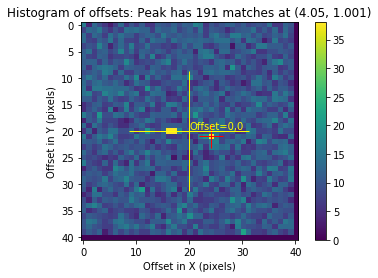

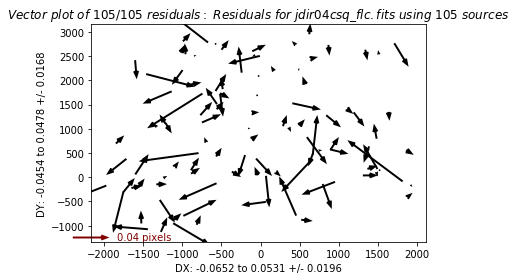

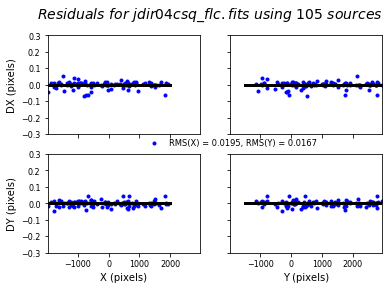

In [182]:
#100, 150, 1 is good
#150, 150, 1.5
tweakreg.TweakReg(list(pointing_5_814_all), #input_images, # Pass input images
                  refimage = 'jdir01cjq_flc.fits',
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, 
                 refimagefindcfg={'threshold':150,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, 
                  expand_refcat=True,
                  enforce_user_order=True,
                 # minobj= 25,
                  separation=0, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.1, #1.2
                  ylimit = 0.3,
                  labelsize=8,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_5_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_5_814_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')

'''tweakreg.TweakReg(list(pointing_5_814_all), #input_images, # Pass input images
                  refimage = 'jdir01cjq_flc.fits',
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, 
                 refimagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, 
                  expand_refcat=True,
                  enforce_user_order=True,
                 # minobj= 25,
                  separation=0, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1,
                  ylimit = 0.3,
                  labelsize=8,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_5_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_5_814_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')'''

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 09:11:41.587 (23/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 09:11:41.587 (23/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir03bhq_flc.fits', 'jdir03bmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir01cjq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir03bhq_flc.fits


    jdir03bhq_flc.fits


INFO:drizzlepac.tweakreg:    jdir03bmq_flc.fits


    jdir03bmq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir03bhq_flc.fits', 'jdir03bmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01cjq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.t

===  Source finding for image 'jdir03bhq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 1) started at: 09:11:41.923 (23/08/2019)


  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 1) started at: 09:11:41.923 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.559079
INFO:drizzlepac.catalogs:###Source finding finished at: 09:11:43.20 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1523 objects.


     Found 1523 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 2) started at: 09:11:43.331 (23/08/2019)


  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 2) started at: 09:11:43.331 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.668103
INFO:drizzlepac.catalogs:###Source finding finished at: 09:11:44.600 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1700 objects.


     Found 1700 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir03bhq_flc.fits': 3223


===  FINAL number of objects in image 'jdir03bhq_flc.fits': 3223


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir03bmq_flc.fits':


===  Source finding for image 'jdir03bmq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 1) started at: 09:11:44.970 (23/08/2019)


  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 1) started at: 09:11:44.970 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.138226
INFO:drizzlepac.catalogs:###Source finding finished at: 09:11:46.389 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2451 objects.


     Found 2451 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 2) started at: 09:11:46.511 (23/08/2019)


  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 2) started at: 09:11:46.511 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.039661
INFO:drizzlepac.catalogs:###Source finding finished at: 09:11:47.657 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2510 objects.


     Found 2510 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir03bmq_flc.fits': 4961


===  FINAL number of objects in image 'jdir03bmq_flc.fits': 4961


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir03bhq_flc.fits', 'jdir03bmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01cjq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sh

===  Source finding for image 'jdir01cjq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 1) started at: 09:11:48.201 (23/08/2019)


  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 1) started at: 09:11:48.201 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.877475
INFO:drizzlepac.catalogs:###Source finding finished at: 09:11:58.830 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 18589 objects.


     Found 18589 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 2) started at: 09:11:59.09 (23/08/2019)


  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 2) started at: 09:11:59.09 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.716096
INFO:drizzlepac.catalogs:###Source finding finished at: 09:12:09.569 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 18805 objects.


     Found 18805 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01cjq_flc.fits': 37394


===  FINAL number of objects in image 'jdir01cjq_flc.fits': 37394


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir01cjq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir01cjq_flc.fits'


derived from 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.5
INFO:drizzlepac.tweakreg:	ylimit :	0.3
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	ou

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir03bhq_flc.fits


Performing fit for: jdir03bhq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir03bhq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir03bhq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  7.0482233502538065 1.0786802030456855


Found initial X and Y shifts of  7.0482233502538065 1.0786802030456855


INFO:drizzlepac.tweakutils:    with significance of  503.8775361420386 and  38.0  matches


    with significance of  503.8775361420386 and  38.0  matches


INFO:drizzlepac.imgclasses:Found 108 matches for jdir03bhq_flc.fits...


Found 108 matches for jdir03bhq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir03bhq_flc.fits : 


Computed  general  fit for  jdir03bhq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 7.5192  YSH: 1.0947    PROPER ROT: 359.992367    


XSH: 7.5192  YSH: 1.0947    PROPER ROT: 359.992367    


INFO:drizzlepac.imgclasses:<ROT>: 359.992367  SKEW: -0.0017306627    ROT_X: 359.9932323  ROT_Y: 359.9915017


<ROT>: 359.992367  SKEW: -0.0017306627    ROT_X: 359.9932323  ROT_Y: 359.9915017


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999382644  SCALE_X: 0.9999294069  SCALE_Y: 0.9999471224


<SCALE>: 0.9999382644  SCALE_X: 0.9999294069  SCALE_Y: 0.9999471224


INFO:drizzlepac.imgclasses:XRMS: 0.076    YRMS: 0.078


XRMS: 0.076    YRMS: 0.078


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.6e-06 (deg)   RMS_DEC: 1.4e-07 (deg)


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 1.4e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  54  objects.


Final solution based on  54  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir03bhq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir03bhq_flc_catalog_fit.match


wrote XY data to:  jdir03bhq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  54


Total # points:  54


INFO:drizzlepac.tweakutils:# of points after clipping:  54


# of points after clipping:  54


INFO:drizzlepac.tweakutils:Total # points:  54


Total # points:  54


INFO:drizzlepac.tweakutils:# of points after clipping:  54


# of points after clipping:  54


INFO:drizzlepac.imgclasses:Adding 3115 new sources to the reference catalog for a total of 40509 sources.


Adding 3115 new sources to the reference catalog for a total of 40509 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir03bhq_flc.fits...


....Updating header for jdir03bhq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bhq_flc.fits['SCI',1]


Processing jdir03bhq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir03bhq_flc.fits[1]


Updating header for jdir03bhq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.031339174448054e-06 1.1196226738772153e-05


CD_11  CD_12: 9.031339174448054e-06 1.1196226738772153e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0492343053555942e-05 -8.361007562916747e-06


CD_21  CD_22: 1.0492343053555942e-05 -8.361007562916747e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.9623233309052 14.555671630544582


CRVAL    : 209.9623233309052 14.555671630544582


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983457908430144


Plate Scale : 0.04983457908430144


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.75127640313545


ORIENTAT : 126.75127640313545


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_1_wcs


WCSNAME  :  pointing_5_814_1_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bhq_flc.fits['SCI',2]


Processing jdir03bhq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bhq_flc.fits[4]


Updating header for jdir03bhq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.065105749243393e-06 1.0883147920765542e-05


CD_11  CD_12: 9.065105749243393e-06 1.0883147920765542e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0248091283384837e-05 -8.000563886133623e-06


CD_21  CD_22: 1.0248091283384837e-05 -8.000563886133623e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98626518653703 14.538438710671077


CRVAL    : 209.98626518653703 14.538438710671077


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925197475834297


Plate Scale : 0.04925197475834297


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32084290610449


ORIENTAT : 126.32084290610449


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_1_wcs


WCSNAME  :  pointing_5_814_1_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_1_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir03bmq_flc.fits


Performing fit for: jdir03bmq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir03bmq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


Matching sources from 'jdir03bmq_flc.fits' with sources from reference image 'jdir01cjq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  6.930537352555703 0.8283093053735264


Found initial X and Y shifts of  6.930537352555703 0.8283093053735264


INFO:drizzlepac.tweakutils:    with significance of  1069.1429238176231 and  152.0  matches


    with significance of  1069.1429238176231 and  152.0  matches


INFO:drizzlepac.imgclasses:Found 294 matches for jdir03bmq_flc.fits...


Found 294 matches for jdir03bmq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir03bmq_flc.fits : 


Computed  general  fit for  jdir03bmq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 7.5538  YSH: 1.1081    PROPER ROT: 359.9922022    


XSH: 7.5538  YSH: 1.1081    PROPER ROT: 359.9922022    


INFO:drizzlepac.imgclasses:<ROT>: 359.9922022  SKEW: 0.003696648973    ROT_X: 359.9903538  ROT_Y: 359.9940505


<ROT>: 359.9922022  SKEW: 0.003696648973    ROT_X: 359.9903538  ROT_Y: 359.9940505


INFO:drizzlepac.imgclasses:<SCALE>: 1.000084414  SCALE_X: 1.000088678  SCALE_Y: 1.000080152


<SCALE>: 1.000084414  SCALE_X: 1.000088678  SCALE_Y: 1.000080152


INFO:drizzlepac.imgclasses:XRMS: 0.065    YRMS: 0.061


XRMS: 0.065    YRMS: 0.061


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 1.7e-07 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 1.7e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  166  objects.


Final solution based on  166  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir03bmq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir03bmq_flc_catalog_fit.match


wrote XY data to:  jdir03bmq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  166


Total # points:  166


INFO:drizzlepac.tweakutils:# of points after clipping:  166


# of points after clipping:  166


INFO:drizzlepac.tweakutils:Total # points:  166


Total # points:  166


INFO:drizzlepac.tweakutils:# of points after clipping:  166


# of points after clipping:  166


INFO:drizzlepac.imgclasses:Adding 4667 new sources to the reference catalog for a total of 45177 sources.


Adding 4667 new sources to the reference catalog for a total of 45177 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir03bmq_flc.fits...


....Updating header for jdir03bmq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bmq_flc.fits['SCI',1]


Processing jdir03bmq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bmq_flc.fits[1]


Updating header for jdir03bmq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.030038832159801e-06 1.1195055085488836e-05


CD_11  CD_12: 9.030038832159801e-06 1.1195055085488836e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0491281447272931e-05 -8.360588066327269e-06


CD_21  CD_22: 1.0491281447272931e-05 -8.360588066327269e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96232314919772 14.555672018060879


CRVAL    : 209.96232314919772 14.555672018060879


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983670657921073


Plate Scale : 0.04983670657921073


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.7527728560329


ORIENTAT : 126.7527728560329


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_1_wcs


WCSNAME  :  pointing_5_814_1_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir03bmq_flc.fits['SCI',2]


Processing jdir03bmq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bmq_flc.fits[4]


Updating header for jdir03bmq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.063806310353655e-06 1.0882006398801328e-05


CD_11  CD_12: 9.063806310353655e-06 1.0882006398801328e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0247048885530466e-05 -8.00016631089936e-06


CD_21  CD_22: 1.0247048885530466e-05 -8.00016631089936e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.9862624978992 14.538439960638973


CRVAL    : 209.9862624978992 14.538439960638973


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925410918240716


Plate Scale : 0.04925410918240716


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.32235225798065


ORIENTAT : 126.32235225798065


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_1_wcs


WCSNAME  :  pointing_5_814_1_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_1_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_5_814_1_shifts.txt


Writing out shiftfile : pointing_5_814_1_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


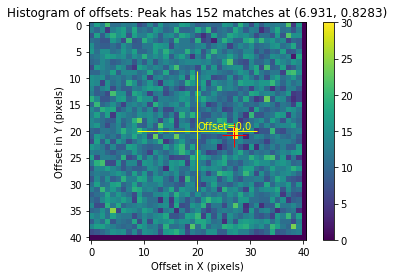

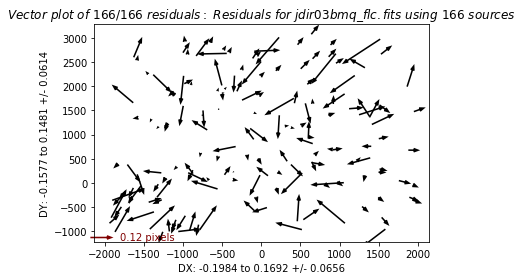

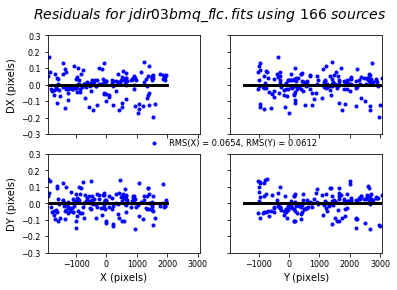

In [183]:
#for some reason teh above doesn't actually make 03's align?
tweakreg.TweakReg(list(pointing_5_814_1), #input_images, # Pass input images
                  refimage = 'jdir01cjq_flc.fits',
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, 
                  refimagefindcfg={'threshold':10,'conv_width':cw, 'searchrad':5, 'use_sharp_round':True}, 
                  expand_refcat=True,
                  enforce_user_order=True,
                 # minobj= 25,
                  separation=0, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.5,
                  ylimit = 0.3,
                  labelsize=8,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_5_814_1_wcs', # Give our WCS a new name
                  outshifts = 'pointing_5_814_1_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 11:14:56.891 (23/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 11:14:56.891 (23/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir01cjq_flc.fits', 'jdir01coq_flc.fits', 'jdir02zyq_flc.fits', 'jdir02ztq_flc.fits', 'jdir04cnq_flc.fits', 'jdir04csq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir01cjq_flc.fits


    jdir01cjq_flc.fits


INFO:drizzlepac.tweakreg:    jdir01coq_flc.fits


    jdir01coq_flc.fits


INFO:drizzlepac.tweakreg:    jdir02zyq_flc.fits


    jdir02zyq_flc.fits


INFO:drizzlepac.tweakreg:    jdir02ztq_flc.fits


    jdir02ztq_flc.fits


INFO:drizzlepac.tweakreg:    jdir04cnq_flc.fits


    jdir04cnq_flc.fits


INFO:drizzlepac.tweakreg:    jdir04csq_flc.fits


    jdir04csq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir01cjq_flc.fits', 'jdir01coq_flc.fits', 'jdir02zyq_flc.fits', 'jdir02ztq_flc.fits', 'jdir04cnq_flc.fits', 'jdir04csq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:driz

===  Source finding for image 'jdir01cjq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 1) started at: 11:14:57.381 (23/08/2019)


  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 1) started at: 11:14:57.381 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.877475
INFO:drizzlepac.catalogs:###Source finding finished at: 11:14:59.590 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2031 objects.


     Found 2031 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 2) started at: 11:14:59.783 (23/08/2019)


  #  Source finding for 'jdir01cjq_flc.fits', EXT=('SCI', 2) started at: 11:14:59.783 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.716096
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:01.082 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2213 objects.


     Found 2213 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01cjq_flc.fits': 4244


===  FINAL number of objects in image 'jdir01cjq_flc.fits': 4244


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir01coq_flc.fits':


===  Source finding for image 'jdir01coq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01coq_flc.fits', EXT=('SCI', 1) started at: 11:15:01.607 (23/08/2019)


  #  Source finding for 'jdir01coq_flc.fits', EXT=('SCI', 1) started at: 11:15:01.607 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.656259
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:02.881 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1463 objects.


     Found 1463 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01coq_flc.fits', EXT=('SCI', 2) started at: 11:15:03.010 (23/08/2019)


  #  Source finding for 'jdir01coq_flc.fits', EXT=('SCI', 2) started at: 11:15:03.010 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.598059
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:04.097 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1500 objects.


     Found 1500 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01coq_flc.fits': 2963


===  FINAL number of objects in image 'jdir01coq_flc.fits': 2963


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir02zyq_flc.fits':


===  Source finding for image 'jdir02zyq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02zyq_flc.fits', EXT=('SCI', 1) started at: 11:15:04.49 (23/08/2019)


  #  Source finding for 'jdir02zyq_flc.fits', EXT=('SCI', 1) started at: 11:15:04.49 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.861730
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:05.565 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1280 objects.


     Found 1280 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02zyq_flc.fits', EXT=('SCI', 2) started at: 11:15:05.824 (23/08/2019)


  #  Source finding for 'jdir02zyq_flc.fits', EXT=('SCI', 2) started at: 11:15:05.824 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.860226
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:06.922 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1368 objects.


     Found 1368 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir02zyq_flc.fits': 2648


===  FINAL number of objects in image 'jdir02zyq_flc.fits': 2648


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir02ztq_flc.fits':


===  Source finding for image 'jdir02ztq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02ztq_flc.fits', EXT=('SCI', 1) started at: 11:15:07.265 (23/08/2019)


  #  Source finding for 'jdir02ztq_flc.fits', EXT=('SCI', 1) started at: 11:15:07.265 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.121102
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:08.298 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1236 objects.


     Found 1236 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir02ztq_flc.fits', EXT=('SCI', 2) started at: 11:15:08.389 (23/08/2019)


  #  Source finding for 'jdir02ztq_flc.fits', EXT=('SCI', 2) started at: 11:15:08.389 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.015579
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:09.418 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1334 objects.


     Found 1334 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir02ztq_flc.fits': 2570


===  FINAL number of objects in image 'jdir02ztq_flc.fits': 2570


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir04cnq_flc.fits':


===  Source finding for image 'jdir04cnq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04cnq_flc.fits', EXT=('SCI', 1) started at: 11:15:09.739 (23/08/2019)


  #  Source finding for 'jdir04cnq_flc.fits', EXT=('SCI', 1) started at: 11:15:09.739 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.626578
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:10.767 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 795 objects.


     Found 795 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04cnq_flc.fits', EXT=('SCI', 2) started at: 11:15:10.864 (23/08/2019)


  #  Source finding for 'jdir04cnq_flc.fits', EXT=('SCI', 2) started at: 11:15:10.864 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.641146
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:11.888 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 851 objects.


     Found 851 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir04cnq_flc.fits': 1646


===  FINAL number of objects in image 'jdir04cnq_flc.fits': 1646


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir04csq_flc.fits':


===  Source finding for image 'jdir04csq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04csq_flc.fits', EXT=('SCI', 1) started at: 11:15:12.152 (23/08/2019)


  #  Source finding for 'jdir04csq_flc.fits', EXT=('SCI', 1) started at: 11:15:12.152 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.057237
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:13.184 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1012 objects.


     Found 1012 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir04csq_flc.fits', EXT=('SCI', 2) started at: 11:15:13.282 (23/08/2019)


  #  Source finding for 'jdir04csq_flc.fits', EXT=('SCI', 2) started at: 11:15:13.282 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.014957
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:14.294 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1077 objects.


     Found 1077 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir04csq_flc.fits': 2089


===  FINAL number of objects in image 'jdir04csq_flc.fits': 2089


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir01cjq_flc.fits', 'jdir01coq_flc.fits', 'jdir02zyq_flc.fits', 'jdir02ztq_flc.fits', 'jdir04cnq_flc.fits', 'jdir04csq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	run

===  Source finding for image 'jdir01ceq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 11:15:14.965 (23/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 11:15:14.965 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.303110
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:16.160 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 12657 objects.


     Found 12657 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 11:15:16.379 (23/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 11:15:16.379 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.222228
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:17.504 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 13492 objects.


     Found 13492 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01ceq_flc.fits': 26149


===  FINAL number of objects in image 'jdir01ceq_flc.fits': 26149


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir01ceq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir01ceq_flc.fits'


derived from 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.0
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	ou

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir01cjq_flc.fits


Performing fit for: jdir01cjq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir01cjq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir01cjq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.9667458432304024 -0.3456057007125892


Found initial X and Y shifts of  -0.9667458432304024 -0.3456057007125892


INFO:drizzlepac.tweakutils:    with significance of  1135.0604651479957 and  164.0  matches


    with significance of  1135.0604651479957 and  164.0  matches


INFO:drizzlepac.imgclasses:Found 533 matches for jdir01cjq_flc.fits...


Found 533 matches for jdir01cjq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir01cjq_flc.fits : 


Computed  general  fit for  jdir01cjq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0020  YSH: 0.0127    PROPER ROT: 359.9761872    


XSH: 0.0020  YSH: 0.0127    PROPER ROT: 359.9761872    


INFO:drizzlepac.imgclasses:<ROT>: 359.9761872  SKEW: -0.0005376146093    ROT_X: 359.976456  ROT_Y: 359.9759184


<ROT>: 359.9761872  SKEW: -0.0005376146093    ROT_X: 359.976456  ROT_Y: 359.9759184


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999988421  SCALE_X: 1.000003886  SCALE_Y: 0.9999937981


<SCALE>: 0.9999988421  SCALE_X: 1.000003886  SCALE_Y: 0.9999937981


INFO:drizzlepac.imgclasses:XRMS: 0.0096    YRMS: 0.0098


XRMS: 0.0096    YRMS: 0.0098


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2e-07 (deg)   RMS_DEC: 1.8e-08 (deg)


RMS_RA: 2e-07 (deg)   RMS_DEC: 1.8e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  243  objects.


Final solution based on  243  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir01cjq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir01cjq_flc_catalog_fit.match


wrote XY data to:  jdir01cjq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  243


Total # points:  243


INFO:drizzlepac.tweakutils:# of points after clipping:  243


# of points after clipping:  243


INFO:drizzlepac.tweakutils:Total # points:  243


Total # points:  243


INFO:drizzlepac.tweakutils:# of points after clipping:  243


# of points after clipping:  243


INFO:drizzlepac.imgclasses:Adding 3711 new sources to the reference catalog for a total of 29860 sources.


Adding 3711 new sources to the reference catalog for a total of 29860 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir01cjq_flc.fits...


....Updating header for jdir01cjq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir01cjq_flc.fits['SCI',1]


Processing jdir01cjq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for jdir01cjq_flc.fits[1]


Updating header for jdir01cjq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.028125298873786e-06 1.1198699031352923e-05


CD_11  CD_12: 9.028125298873786e-06 1.1198699031352923e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494769530844147e-05 -8.357971129149452e-06


CD_21  CD_22: 1.0494769530844147e-05 -8.357971129149452e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96240368756912 14.555743817325698


CRVAL    : 209.96240368756912 14.555743817325698


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983739584079727


Plate Scale : 0.04983739584079727


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73523550061685


ORIENTAT : 126.73523550061685


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir01cjq_flc.fits['SCI',2]


Processing jdir01cjq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir01cjq_flc.fits[4]


Updating header for jdir01cjq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.061964282505929e-06 1.0885512672817757e-05


CD_11  CD_12: 9.061964282505929e-06 1.0885512672817757e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250527642361752e-05 -7.997612996873769e-06


CD_21  CD_22: 1.0250527642361752e-05 -7.997612996873769e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98635081512202 14.538517181852054


CRVAL    : 209.98635081512202 14.538517181852054


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049254763991246966


Plate Scale : 0.049254763991246966


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30481667592112


ORIENTAT : 126.30481667592112


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir01coq_flc.fits


Performing fit for: jdir01coq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir01coq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir01coq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.8830874006810454 -0.2871736662883073


Found initial X and Y shifts of  -0.8830874006810454 -0.2871736662883073


INFO:drizzlepac.tweakutils:    with significance of  1259.9219459043127 and  203.0  matches


    with significance of  1259.9219459043127 and  203.0  matches


INFO:drizzlepac.imgclasses:Found 636 matches for jdir01coq_flc.fits...


Found 636 matches for jdir01coq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir01coq_flc.fits : 


Computed  general  fit for  jdir01coq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0017  YSH: 0.0147    PROPER ROT: 359.9761462    


XSH: 0.0017  YSH: 0.0147    PROPER ROT: 359.9761462    


INFO:drizzlepac.imgclasses:<ROT>: 359.9761462  SKEW: -0.0003905029173    ROT_X: 359.9763414  ROT_Y: 359.9759509


<ROT>: 359.9761462  SKEW: -0.0003905029173    ROT_X: 359.9763414  ROT_Y: 359.9759509


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999988811  SCALE_X: 1.000005405  SCALE_Y: 0.999992357


<SCALE>: 0.9999988811  SCALE_X: 1.000005405  SCALE_Y: 0.999992357


INFO:drizzlepac.imgclasses:XRMS: 0.01    YRMS: 0.01


XRMS: 0.01    YRMS: 0.01


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.1e-07 (deg)   RMS_DEC: 2.4e-08 (deg)


RMS_RA: 2.1e-07 (deg)   RMS_DEC: 2.4e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  286  objects.


Final solution based on  286  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir01coq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir01coq_flc_catalog_fit.match


wrote XY data to:  jdir01coq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  286


Total # points:  286


INFO:drizzlepac.tweakutils:# of points after clipping:  286


# of points after clipping:  286


INFO:drizzlepac.tweakutils:Total # points:  286


Total # points:  286


INFO:drizzlepac.tweakutils:# of points after clipping:  286


# of points after clipping:  286


INFO:drizzlepac.imgclasses:Adding 2327 new sources to the reference catalog for a total of 32187 sources.


Adding 2327 new sources to the reference catalog for a total of 32187 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir01coq_flc.fits...


....Updating header for jdir01coq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir01coq_flc.fits['SCI',1]


Processing jdir01coq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir01coq_flc.fits[1]


Updating header for jdir01coq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.028107246052463e-06 1.1198699066277368e-05


CD_11  CD_12: 9.028107246052463e-06 1.1198699066277368e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0494785410239163e-05 -8.357984724104802e-06


CD_21  CD_22: 1.0494785410239163e-05 -8.357984724104802e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96240367520605 14.5557438294025


CRVAL    : 209.96240367520605 14.5557438294025


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049837476183115896


Plate Scale : 0.049837476183115896


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.73528008743092


ORIENTAT : 126.73528008743092


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir01coq_flc.fits['SCI',2]


Processing jdir01coq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir01coq_flc.fits[4]


Updating header for jdir01coq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.061946497449132e-06 1.0885512556492663e-05


CD_11  CD_12: 9.061946497449132e-06 1.0885512556492663e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0250543116983948e-05 -7.997626039522946e-06


CD_21  CD_22: 1.0250543116983948e-05 -7.997626039522946e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98635080272257 14.538517165884219


CRVAL    : 209.98635080272257 14.538517165884219


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925484331536675


Plate Scale : 0.04925484331536675


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.30486155200724


ORIENTAT : 126.30486155200724


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir02zyq_flc.fits


Performing fit for: jdir02zyq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir02zyq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir02zyq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.1578947368421062 -0.8235294117647065


Found initial X and Y shifts of  -0.1578947368421062 -0.8235294117647065


INFO:drizzlepac.tweakutils:    with significance of  436.5280583911094 and  24.0  matches


    with significance of  436.5280583911094 and  24.0  matches


INFO:drizzlepac.imgclasses:Found 87 matches for jdir02zyq_flc.fits...


Found 87 matches for jdir02zyq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir02zyq_flc.fits : 


Computed  general  fit for  jdir02zyq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2330  YSH: -0.0138    PROPER ROT: 359.9778224    


XSH: 0.2330  YSH: -0.0138    PROPER ROT: 359.9778224    


INFO:drizzlepac.imgclasses:<ROT>: 359.9778224  SKEW: -0.001184013556    ROT_X: 359.9784144  ROT_Y: 359.9772304


<ROT>: 359.9778224  SKEW: -0.001184013556    ROT_X: 359.9784144  ROT_Y: 359.9772304


INFO:drizzlepac.imgclasses:<SCALE>: 1.00005263  SCALE_X: 1.000053845  SCALE_Y: 1.000051415


<SCALE>: 1.00005263  SCALE_X: 1.000053845  SCALE_Y: 1.000051415


INFO:drizzlepac.imgclasses:XRMS: 0.054    YRMS: 0.061


XRMS: 0.054    YRMS: 0.061


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 5.3e-08 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 5.3e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  25  objects.


Final solution based on  25  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir02zyq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir02zyq_flc_catalog_fit.match


wrote XY data to:  jdir02zyq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  25


Total # points:  25


INFO:drizzlepac.tweakutils:# of points after clipping:  25


# of points after clipping:  25


INFO:drizzlepac.tweakutils:Total # points:  25


Total # points:  25


INFO:drizzlepac.tweakutils:# of points after clipping:  25


# of points after clipping:  25


INFO:drizzlepac.imgclasses:Adding 2561 new sources to the reference catalog for a total of 34762 sources.


Adding 2561 new sources to the reference catalog for a total of 34762 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir02zyq_flc.fits...


....Updating header for jdir02zyq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02zyq_flc.fits['SCI',1]


Processing jdir02zyq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02zyq_flc.fits[1]


Updating header for jdir02zyq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.02562701868239e-06 1.1199345602066653e-05


CD_11  CD_12: 9.02562701868239e-06 1.1199345602066653e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0495685147643678e-05 -8.355329070761414e-06


CD_21  CD_22: 1.0495685147643678e-05 -8.355329070761414e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96160076215395 14.556143811564736


CRVAL    : 209.96160076215395 14.556143811564736


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983650361313097


Plate Scale : 0.04983650361313097


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72496735419533


ORIENTAT : 126.72496735419533


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02zyq_flc.fits['SCI',2]


Processing jdir02zyq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02zyq_flc.fits[4]


Updating header for jdir02zyq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.059507358220251e-06 1.088611887285603e-05


CD_11  CD_12: 9.059507358220251e-06 1.088611887285603e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0251466191229287e-05 -7.995053776232931e-06


CD_21  CD_22: 1.0251466191229287e-05 -7.995053776232931e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98554930270004 14.538922639495707


CRVAL    : 209.98554930270004 14.538922639495707


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925387533187318


Plate Scale : 0.04925387533187318


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.29454521598912


ORIENTAT : 126.29454521598912


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir02ztq_flc.fits


Performing fit for: jdir02ztq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir02ztq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir02ztq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.6779463243873991 -0.418903150525086


Found initial X and Y shifts of  -0.6779463243873991 -0.418903150525086


INFO:drizzlepac.tweakutils:    with significance of  1181.7395840219808 and  176.0  matches


    with significance of  1181.7395840219808 and  176.0  matches


INFO:drizzlepac.imgclasses:Found 603 matches for jdir02ztq_flc.fits...


Found 603 matches for jdir02ztq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir02ztq_flc.fits : 


Computed  general  fit for  jdir02ztq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2322  YSH: -0.0139    PROPER ROT: 359.9778467    


XSH: 0.2322  YSH: -0.0139    PROPER ROT: 359.9778467    


INFO:drizzlepac.imgclasses:<ROT>: 359.9778467  SKEW: 0.002690556643    ROT_X: 359.9765014  ROT_Y: 359.9791919


<ROT>: 359.9778467  SKEW: 0.002690556643    ROT_X: 359.9765014  ROT_Y: 359.9791919


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999024135  SCALE_X: 0.9998999643  SCALE_Y: 0.9999048637


<SCALE>: 0.9999024135  SCALE_X: 0.9998999643  SCALE_Y: 0.9999048637


INFO:drizzlepac.imgclasses:XRMS: 0.0055    YRMS: 0.0062


XRMS: 0.0055    YRMS: 0.0062


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-07 (deg)   RMS_DEC: 4.9e-09 (deg)


RMS_RA: 1.2e-07 (deg)   RMS_DEC: 4.9e-09 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  301  objects.


Final solution based on  301  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir02ztq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir02ztq_flc_catalog_fit.match


wrote XY data to:  jdir02ztq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  301


Total # points:  301


INFO:drizzlepac.tweakutils:# of points after clipping:  301


# of points after clipping:  301


INFO:drizzlepac.tweakutils:Total # points:  301


Total # points:  301


INFO:drizzlepac.tweakutils:# of points after clipping:  301


# of points after clipping:  301


INFO:drizzlepac.imgclasses:Adding 1967 new sources to the reference catalog for a total of 36740 sources.


Adding 1967 new sources to the reference catalog for a total of 36740 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir02ztq_flc.fits...


....Updating header for jdir02ztq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02ztq_flc.fits['SCI',1]


Processing jdir02ztq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02ztq_flc.fits[1]


Updating header for jdir02ztq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.026373729037978e-06 1.120030670180727e-05


CD_11  CD_12: 9.026373729037978e-06 1.120030670180727e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0496983240004132e-05 -8.356413016216448e-06


CD_21  CD_22: 1.0496983240004132e-05 -8.356413016216448e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.9616006741077 14.556143828961707


CRVAL    : 209.9616006741077 14.556143828961707


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983423055708615


Plate Scale : 0.04983423055708615


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72617314334708


ORIENTAT : 126.72617314334708


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir02ztq_flc.fits['SCI',2]


Processing jdir02ztq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir02ztq_flc.fits[4]


Updating header for jdir02ztq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.0602574182648e-06 1.088705280205644e-05


CD_11  CD_12: 9.0602574182648e-06 1.088705280205644e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0252733410793142e-05 -7.996091470417132e-06


CD_21  CD_22: 1.0252733410793142e-05 -7.996091470417132e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98555126953582 14.538920422493328


CRVAL    : 209.98555126953582 14.538920422493328


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925164625106436


Plate Scale : 0.04925164625106436


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.29574788170794


ORIENTAT : 126.29574788170794


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir04cnq_flc.fits


Performing fit for: jdir04cnq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir04cnq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir04cnq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.10769230769230731 -0.76923076923077


Found initial X and Y shifts of  -0.10769230769230731 -0.76923076923077


INFO:drizzlepac.tweakutils:    with significance of  433.4187230308402 and  24.0  matches


    with significance of  433.4187230308402 and  24.0  matches


INFO:drizzlepac.imgclasses:Found 88 matches for jdir04cnq_flc.fits...


Found 88 matches for jdir04cnq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir04cnq_flc.fits : 


Computed  general  fit for  jdir04cnq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2218  YSH: -0.0360    PROPER ROT: 359.977295    


XSH: 0.2218  YSH: -0.0360    PROPER ROT: 359.977295    


INFO:drizzlepac.imgclasses:<ROT>: 359.977295  SKEW: -0.002942076031    ROT_X: 359.978766  ROT_Y: 359.975824


<ROT>: 359.977295  SKEW: -0.002942076031    ROT_X: 359.978766  ROT_Y: 359.975824


INFO:drizzlepac.imgclasses:<SCALE>: 1.000021481  SCALE_X: 1.000005517  SCALE_Y: 1.000037447


<SCALE>: 1.000021481  SCALE_X: 1.000005517  SCALE_Y: 1.000037447


INFO:drizzlepac.imgclasses:XRMS: 0.047    YRMS: 0.038


XRMS: 0.047    YRMS: 0.038


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8.4e-07 (deg)   RMS_DEC: 1.8e-07 (deg)


RMS_RA: 8.4e-07 (deg)   RMS_DEC: 1.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  16  objects.


Final solution based on  16  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir04cnq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir04cnq_flc_catalog_fit.match


wrote XY data to:  jdir04cnq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  16


Total # points:  16


INFO:drizzlepac.tweakutils:# of points after clipping:  16


# of points after clipping:  16


INFO:drizzlepac.tweakutils:Total # points:  16


Total # points:  16


INFO:drizzlepac.tweakutils:# of points after clipping:  16


# of points after clipping:  16


INFO:drizzlepac.imgclasses:Adding 1558 new sources to the reference catalog for a total of 38321 sources.


Adding 1558 new sources to the reference catalog for a total of 38321 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir04cnq_flc.fits...


....Updating header for jdir04cnq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04cnq_flc.fits['SCI',1]


Processing jdir04cnq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04cnq_flc.fits[1]


Updating header for jdir04cnq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.026504505322682e-06 1.1199831547808266e-05


CD_11  CD_12: 9.026504505322682e-06 1.1199831547808266e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0496451249098032e-05 -8.355365086331242e-06


CD_21  CD_22: 1.0496451249098032e-05 -8.355365086331242e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.9608835962964 14.556579705604422


CRVAL    : 209.9608835962964 14.556579705604422


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983820221558485


Plate Scale : 0.04983820221558485


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72389420668037


ORIENTAT : 126.72389420668037


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04cnq_flc.fits['SCI',2]


Processing jdir04cnq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04cnq_flc.fits[4]


Updating header for jdir04cnq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.06038077716305e-06 1.0886594808516577e-05


CD_11  CD_12: 9.06038077716305e-06 1.0886594808516577e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0252221700388826e-05 -7.995082823462978e-06


CD_21  CD_22: 1.0252221700388826e-05 -7.995082823462978e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98483322541773 14.539358462443932


CRVAL    : 209.98483322541773 14.539358462443932


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925555345982135


Plate Scale : 0.04925555345982135


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.29344947453133


ORIENTAT : 126.29344947453133


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir04csq_flc.fits


Performing fit for: jdir04csq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir04csq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir04csq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.2198067632850247 -0.7101449275362306


Found initial X and Y shifts of  -0.2198067632850247 -0.7101449275362306


INFO:drizzlepac.tweakutils:    with significance of  654.1772633559591 and  49.0  matches


    with significance of  654.1772633559591 and  49.0  matches


INFO:drizzlepac.imgclasses:Found 185 matches for jdir04csq_flc.fits...


Found 185 matches for jdir04csq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir04csq_flc.fits : 


Computed  general  fit for  jdir04csq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2140  YSH: -0.0413    PROPER ROT: 359.9776716    


XSH: 0.2140  YSH: -0.0413    PROPER ROT: 359.9776716    


INFO:drizzlepac.imgclasses:<ROT>: 359.9776716  SKEW: 0.004812317787    ROT_X: 359.9752655  ROT_Y: 359.9800778


<ROT>: 359.9776716  SKEW: 0.004812317787    ROT_X: 359.9752655  ROT_Y: 359.9800778


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999503595  SCALE_X: 0.9999448646  SCALE_Y: 0.9999558579


<SCALE>: 0.9999503595  SCALE_X: 0.9999448646  SCALE_Y: 0.9999558579


INFO:drizzlepac.imgclasses:XRMS: 0.02    YRMS: 0.022


XRMS: 0.02    YRMS: 0.022


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.2e-07 (deg)   RMS_DEC: 2.5e-08 (deg)


RMS_RA: 4.2e-07 (deg)   RMS_DEC: 2.5e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  69  objects.


Final solution based on  69  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir04csq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir04csq_flc_catalog_fit.match


wrote XY data to:  jdir04csq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  69


Total # points:  69


INFO:drizzlepac.tweakutils:# of points after clipping:  69


# of points after clipping:  69


INFO:drizzlepac.tweakutils:Total # points:  69


Total # points:  69


INFO:drizzlepac.tweakutils:# of points after clipping:  69


# of points after clipping:  69


INFO:drizzlepac.imgclasses:Adding 1904 new sources to the reference catalog for a total of 40240 sources.


Adding 1904 new sources to the reference catalog for a total of 40240 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for jdir04csq_flc.fits...


....Updating header for jdir04csq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04csq_flc.fits['SCI',1]


Processing jdir04csq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04csq_flc.fits[1]


Updating header for jdir04csq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.026018985834975e-06 1.1200034998780161e-05


CD_11  CD_12: 9.026018985834975e-06 1.1200034998780161e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0496901023259485e-05 -8.356614352548342e-06


CD_21  CD_22: 1.0496901023259485e-05 -8.356614352548342e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.96088380217935 14.556579904161289


CRVAL    : 209.96088380217935 14.556579904161289


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983546613731483


Plate Scale : 0.04983546613731483


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.72750097005151


ORIENTAT : 126.72750097005151


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing jdir04csq_flc.fits['SCI',2]


Processing jdir04csq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir04csq_flc.fits[4]


Updating header for jdir04csq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 9.059904203186526e-06 1.0886787572293266e-05


CD_11  CD_12: 9.059904203186526e-06 1.0886787572293266e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0252649326554423e-05 -7.996286472731402e-06


CD_21  CD_22: 1.0252649326554423e-05 -7.996286472731402e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 209.98483386312003 14.539356081364456


CRVAL    : 209.98483386312003 14.539356081364456


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049252867945118066


Plate Scale : 0.049252867945118066


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 126.2970804834701


ORIENTAT : 126.2970804834701


INFO:drizzlepac.updatehdr:WCSNAME  :  pointing_5_814_606_wcs


WCSNAME  :  pointing_5_814_606_wcs


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "C"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "pointing_5_814_606_wcs"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : pointing_5_814_606_shifts.txt


Writing out shiftfile : pointing_5_814_606_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 11:15:33.883 (23/08/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 11:15:33.883 (23/08/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.4 (default, Aug  9 2019, 12:36:10) 


3.7.4 (default, Aug  9 2019, 12:36:10) 


INFO:drizzlepac.util:numpy Version -> 1.16.4 


numpy Version -> 1.16.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.5.1 


stwcs Version -> 1.5.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	['jdir03bhq_flc.fits', 'jdir03bmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    jdir03bhq_flc.fits


    jdir03bhq_flc.fits


INFO:drizzlepac.tweakreg:    jdir03bmq_flc.fits


    jdir03bmq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir03bhq_flc.fits', 'jdir03bmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	3.0
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.t

===  Source finding for image 'jdir03bhq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 1) started at: 11:15:34.206 (23/08/2019)


  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 1) started at: 11:15:34.206 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.559079
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:35.376 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1776 objects.


     Found 1776 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 2) started at: 11:15:35.492 (23/08/2019)


  #  Source finding for 'jdir03bhq_flc.fits', EXT=('SCI', 2) started at: 11:15:35.492 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.668103
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:36.605 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 1959 objects.


     Found 1959 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir03bhq_flc.fits': 3735


===  FINAL number of objects in image 'jdir03bhq_flc.fits': 3735


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'jdir03bmq_flc.fits':


===  Source finding for image 'jdir03bmq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 1) started at: 11:15:36.941 (23/08/2019)


  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 1) started at: 11:15:36.941 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.138226
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:38.071 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2794 objects.


     Found 2794 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 2) started at: 11:15:38.210 (23/08/2019)


  #  Source finding for 'jdir03bmq_flc.fits', EXT=('SCI', 2) started at: 11:15:38.210 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 13.039661
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:39.310 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 2931 objects.


     Found 2931 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir03bmq_flc.fits': 5725


===  FINAL number of objects in image 'jdir03bmq_flc.fits': 5725


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	['jdir03bhq_flc.fits', 'jdir03bmq_flc.fits']
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	jdir01ceq_flc.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	searchrad :	5
INFO:drizzlepac.tweakreg:	sh

===  Source finding for image 'jdir01ceq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 11:15:39.943 (23/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 1) started at: 11:15:39.943 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.303110
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:40.896 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 7539 objects.


     Found 7539 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 11:15:41.127 (23/08/2019)


  #  Source finding for 'jdir01ceq_flc.fits', EXT=('SCI', 2) started at: 11:15:41.127 (23/08/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.222228
INFO:drizzlepac.catalogs:###Source finding finished at: 11:15:42.035 (23/08/2019)
INFO:drizzlepac.catalogs:     Found 8061 objects.


     Found 8061 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'jdir01ceq_flc.fits': 15600


===  FINAL number of objects in image 'jdir01ceq_flc.fits': 15600


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "jdir01ceq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'jdir01ceq_flc.fits'


derived from 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.0
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	25
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	1.0
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir03bhq_flc.fits


Performing fit for: jdir03bhq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir03bhq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir03bhq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -7.863636363636363 -1.913636363636364


Found initial X and Y shifts of  -7.863636363636363 -1.913636363636364


INFO:drizzlepac.tweakutils:    with significance of  471.1178196587347 and  34.0  matches


    with significance of  471.1178196587347 and  34.0  matches


INFO:drizzlepac.imgclasses:Found 67 matches for jdir03bhq_flc.fits...


Found 67 matches for jdir03bhq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir03bhq_flc.fits : 


Computed  general  fit for  jdir03bhq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -7.8325  YSH: -1.0858    PROPER ROT: 0.006973231458    


XSH: -7.8325  YSH: -1.0858    PROPER ROT: 0.006973231458    


INFO:drizzlepac.imgclasses:<ROT>: 0.006973231458  SKEW: 0.001358904793    ROT_X: 0.006293779061  ROT_Y: 0.007652683855


<ROT>: 0.006973231458  SKEW: 0.001358904793    ROT_X: 0.006293779061  ROT_Y: 0.007652683855


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999647396  SCALE_X: 0.9999743014  SCALE_Y: 0.9999551782


<SCALE>: 0.9999647396  SCALE_X: 0.9999743014  SCALE_Y: 0.9999551782


INFO:drizzlepac.imgclasses:XRMS: 0.0099    YRMS: 0.014


XRMS: 0.0099    YRMS: 0.014


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.5e-07 (deg)   RMS_DEC: 1.7e-08 (deg)


RMS_RA: 2.5e-07 (deg)   RMS_DEC: 1.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  28  objects.


Final solution based on  28  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir03bhq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir03bhq_flc_catalog_fit.match


wrote XY data to:  jdir03bhq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  28


Total # points:  28


INFO:drizzlepac.tweakutils:# of points after clipping:  28


# of points after clipping:  28


INFO:drizzlepac.tweakutils:Total # points:  28


Total # points:  28


INFO:drizzlepac.tweakutils:# of points after clipping:  28


# of points after clipping:  28


INFO:drizzlepac.imgclasses:Adding 3668 new sources to the reference catalog for a total of 19268 sources.


Adding 3668 new sources to the reference catalog for a total of 19268 sources.


INFO:drizzlepac.updatehdr:....Updating header for jdir03bhq_flc.fits...
INFO:drizzlepac.updatehdr:Processing jdir03bhq_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for jdir03bhq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing jdir03bhq_flc.fits['SCI',2]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bhq_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: jdir03bmq_flc.fits


Performing fit for: jdir03bmq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'jdir03bmq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


Matching sources from 'jdir03bmq_flc.fits' with sources from reference image 'jdir01ceq_flc.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -8.054673721340388 -1.220458553791886


Found initial X and Y shifts of  -8.054673721340388 -1.220458553791886


INFO:drizzlepac.tweakutils:    with significance of  856.971411425142 and  112.0  matches


    with significance of  856.971411425142 and  112.0  matches


INFO:drizzlepac.imgclasses:Found 276 matches for jdir03bmq_flc.fits...


Found 276 matches for jdir03bmq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  jdir03bmq_flc.fits : 


Computed  general  fit for  jdir03bmq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -7.8344  YSH: -1.0861    PROPER ROT: 0.007240370744    


XSH: -7.8344  YSH: -1.0861    PROPER ROT: 0.007240370744    


INFO:drizzlepac.imgclasses:<ROT>: 0.007240370744  SKEW: -0.002536254313    ROT_X: 0.008508497901  ROT_Y: 0.005972243588


<ROT>: 0.007240370744  SKEW: -0.002536254313    ROT_X: 0.008508497901  ROT_Y: 0.005972243588


INFO:drizzlepac.imgclasses:<SCALE>: 1.000108223  SCALE_X: 1.000116526  SCALE_Y: 1.00009992


<SCALE>: 1.000108223  SCALE_X: 1.000116526  SCALE_Y: 1.00009992


INFO:drizzlepac.imgclasses:XRMS: 0.017    YRMS: 0.017


XRMS: 0.017    YRMS: 0.017


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.4e-07 (deg)   RMS_DEC: 4.2e-08 (deg)


RMS_RA: 3.4e-07 (deg)   RMS_DEC: 4.2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  81  objects.


Final solution based on  81  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: jdir03bmq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  jdir03bmq_flc_catalog_fit.match


wrote XY data to:  jdir03bmq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  81


Total # points:  81


INFO:drizzlepac.tweakutils:# of points after clipping:  81


# of points after clipping:  81


INFO:drizzlepac.tweakutils:Total # points:  81


Total # points:  81


INFO:drizzlepac.tweakutils:# of points after clipping:  81


# of points after clipping:  81


INFO:drizzlepac.imgclasses:Adding 5449 new sources to the reference catalog for a total of 24717 sources.


Adding 5449 new sources to the reference catalog for a total of 24717 sources.


INFO:drizzlepac.updatehdr:....Updating header for jdir03bmq_flc.fits...
INFO:drizzlepac.updatehdr:Processing jdir03bmq_flc.fits['SCI',1]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

INFO:drizzlepac.updatehdr:Updating header for jdir03bmq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing jdir03bmq_flc.fits['SCI',2]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "

Writing out shiftfile : pointing_5_814_606_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


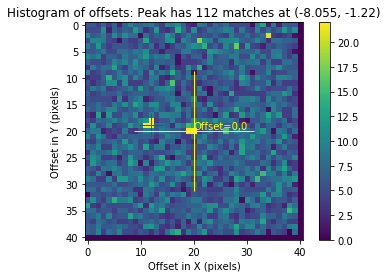

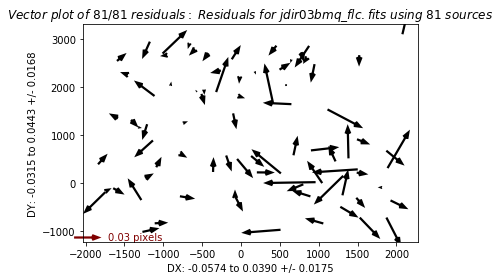

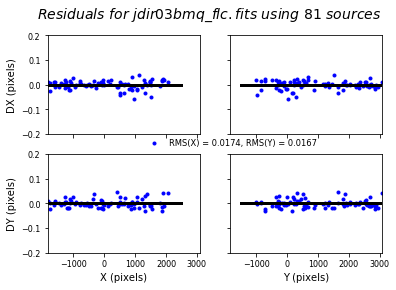

In [224]:
#aligning 814 to 606
#140, 100, 1
#50, 100, 1
tweakreg.TweakReg(list(pointing_5_814_2), #input_images - all 814 !
                  refimage = 'jdir01ceq_flc.fits', #a zero post arg606 filter
                  updatehdr=False, # update header with new WCS solution
                  imagefindcfg={'threshold':150,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, #160
                  refimagefindcfg={'threshold':100,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False},
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=0.0, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1,
                  ylimit = 0.2,
                  labelsize=8,
                 # nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_5_814_606_wcs', # Give our WCS a new name
                  outshifts = 'pointing_5_814_606_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')


#50, 150, 1.2. 70 150 1
#70, 10, 1
tweakreg.TweakReg(list(pointing_5_814_1), #input_images - all 814 !
                  refimage = 'jdir01ceq_flc.fits', #a zero post arg606 filter
                  updatehdr=False, # update header with new WCS solution
                  imagefindcfg={'threshold':90,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False}, #160
                  refimagefindcfg={'threshold':150,'conv_width':cw, 'searchrad':5, 'use_sharp_round':False},
                  expand_refcat=True,
                  enforce_user_order=True,
                  minobj= 25,
                  separation=0.0, # Allow for very small shifts
                  clean=False, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.2,
                  labelsize=8,
                 # nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_5_814_wcs', # Give our WCS a new name
                  outshifts = 'pointing_5_814_606_shifts.txt', 
                  reusename=True,
                  fitgeometry='general')

## Running AstroDrizzle to combine each filter per each visit, i.e. combining the 8 F606 images into one and then the 8 F814 images into one. First check that each image is updated with the shifts, if not they can't combine well. Note that the area around column 2499 is variably bad, sometimes it is and sometimes it isn't. If it is bad go in and flag it, if not, you're all set. Also note that pixfrac is arcsec per pixel, i.e. it will be a decimal less than 0.1. You should also check that the dimensions of the image are still 4k x 4k

In [10]:
#PLS note - dropped one (1) visit 10 image

from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle(list(pointing_1_606),
                         output='pointing_1_606_all',
                         final_refimage='pointing_1_814_all_1_drc_sci.fits',
                         build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq', 
                         final_wcs = True)
#a is .035, .8
#this is also p decent, keeping for now

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:03:42.282 (03/11/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 12:03:42.282 (03/11/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.17.2 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.2.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.3 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  12:03:42.314 (03/11/2019)


==== Processing Step  Initialization  started at  12:03:42.314 (03/11/2019)


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: pointing_1_606_all_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 112.2027355390082
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 112.2027355390082
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 101.6799299253097
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 101.6799299253097
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 120.6228929847316
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 120.6228929847316
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 109.6757432247232
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 109.6757432247232
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 122.9195233489651
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 122.9195233489651
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 109.8933424876359
INFO:drizzlepac.imageObje

Creating OUTPUT WCS from pointing_1_814_all_1_drc_sci.fits[0]


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 6.99198903595451e-06 8.63532740806905e-06


CD_11  CD_12: 6.99198903595451e-06 8.63532740806905e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.63532740806905e-06 -6.9919890359545e-06


CD_21  CD_22: 8.63532740806905e-06 -6.9919890359545e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0639439769387 14.47830803238678


CRVAL    : 210.0639439769387 14.47830803238678


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2641.0 2725.375


CRPIX    : 2641.0 2725.375


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 5283 5451


NAXIS    : 5283 5451


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03999999999999997


Plate Scale : 0.03999999999999997


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 128.9969494495037


ORIENTAT : 128.9969494495037


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1574 Mb.


*  Estimated memory usage:  up to 1574 Mb.


INFO:drizzlepac.processInput:*  Output image size:       5283 X 5451 pixels. 


*  Output image size:       5283 X 5451 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 329 Mb. 


*  Output image file:       ~ 329 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  12:03:47.014 (03/11/2019)


==== Processing Step  Initialization  finished at  12:03:47.014 (03/11/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['jdir09qzq_flc.fits', 'jdir09r2q_flc.fits', 'jdir10veq_flc.fits', 'jdir10vhq_flc.fits', 'jdir11yaq_flc.fits', 'jdir11ydq_flc.fits', 'jdir12zcq_flc.fits', 'jdir12zfq_flc.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	pointing_1_606_all
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
IN

==== Processing Step  Static Mask  started at  12:03:47.032 (03/11/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 112.139566;   rms = 15.580344;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 111.518069;   rms = 18.103989;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 101.385126;   rms = 16.428158;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 100.989844;   rms = 20.339855;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 119.818524;   rms = 16.677137;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 120.568535;   rms = 19.908957;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 108.981067;   rms = 15.614689;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  12:03:50.837 (03/11/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  12:03:50.842 (03/11/2019)


==== Processing Step  Subtract Sky  started at  12:03:50.842 (03/11/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	10
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2019-11-03 12:03:52.208871


***** skymatch started on 2019-11-03 12:03:52.208871


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir09qzq_flc.fits'


   **  Input image: 'jdir09qzq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir09qzq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir09qzq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir09qzq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir09qzq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir09r2q_flc.fits'


   **  Input image: 'jdir09r2q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir09r2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir09r2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir09r2q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir09r2q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir10veq_flc.fits'


   **  Input image: 'jdir10veq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir10veq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir10veq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir10veq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir10veq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir10vhq_flc.fits'


   **  Input image: 'jdir10vhq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir10vhq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir10vhq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir10vhq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir10vhq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir11yaq_flc.fits'


   **  Input image: 'jdir11yaq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir11yaq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir11yaq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir11yaq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir11yaq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir11ydq_flc.fits'


   **  Input image: 'jdir11ydq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir11ydq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir11ydq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir11ydq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir11ydq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir12zcq_flc.fits'


   **  Input image: 'jdir12zcq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir12zcq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir12zcq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir12zcq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir12zcq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir12zfq_flc.fits'


   **  Input image: 'jdir12zfq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir12zfq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir12zfq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir12zfq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir12zfq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 10


       nclip = 10


INFO:stsci.skypac.utils:       lsigma = 4


       lsigma = 4


INFO:stsci.skypac.utils:       usigma = 4


       usigma = 4


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir09qzq_flc.fits


   *   Image: jdir09qzq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir09r2q_flc.fits


   *   Image: jdir09r2q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir10veq_flc.fits


   *   Image: jdir10veq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir10vhq_flc.fits


   *   Image: jdir10vhq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir11yaq_flc.fits


   *   Image: jdir11yaq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir11ydq_flc.fits


   *   Image: jdir11ydq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir12zcq_flc.fits


   *   Image: jdir12zcq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir12zfq_flc.fits


   *   Image: jdir12zfq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir09qzq_flc.fits['SCI',1,2]' SKY = 3.4389 [brightness units]


   *   Image 'jdir09qzq_flc.fits['SCI',1,2]' SKY = 3.4389 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 10.523


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 10.523


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 10.523


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 10.523


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir09r2q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'jdir09r2q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir10veq_flc.fits['SCI',1,2]' SKY = 6.1905 [brightness units]


   *   Image 'jdir10veq_flc.fits['SCI',1,2]' SKY = 6.1905 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 18.9429


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 18.9429


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 18.9429


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 18.9429


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir10vhq_flc.fits['SCI',1,2]' SKY = 2.61309 [brightness units]


   *   Image 'jdir10vhq_flc.fits['SCI',1,2]' SKY = 2.61309 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.99607


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.99607


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.99607


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.99607


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir11yaq_flc.fits['SCI',1,2]' SKY = 6.94101 [brightness units]


   *   Image 'jdir11yaq_flc.fits['SCI',1,2]' SKY = 6.94101 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 21.2395


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 21.2395


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 21.2395


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 21.2395


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir11ydq_flc.fits['SCI',1,2]' SKY = 2.68422 [brightness units]


   *   Image 'jdir11ydq_flc.fits['SCI',1,2]' SKY = 2.68422 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 8.21372


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 8.21372


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 8.21372


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 8.21372


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir12zcq_flc.fits['SCI',1,2]' SKY = 9.31791 [brightness units]


   *   Image 'jdir12zcq_flc.fits['SCI',1,2]' SKY = 9.31791 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 28.5128


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 28.5128


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 28.5128


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 28.5128


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir12zfq_flc.fits['SCI',1,2]' SKY = 2.89079 [brightness units]


   *   Image 'jdir12zfq_flc.fits['SCI',1,2]' SKY = 2.89079 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 8.84583


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 8.84583


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 8.84583


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 8.84583


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 33.22864795725335 (brightness units)


   "Global" sky value: 33.22864795725335 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # jdir09qzq_flc.fits['SCI',1]:   112.20269418748869


    # jdir09qzq_flc.fits['SCI',1]:   112.20269418748869


INFO:stsci.skypac.utils:    # jdir09qzq_flc.fits['SCI',2]:   112.20269418748869


    # jdir09qzq_flc.fits['SCI',2]:   112.20269418748869


INFO:stsci.skypac.utils:    # jdir09r2q_flc.fits['SCI',1]:   101.67966274919527


    # jdir09r2q_flc.fits['SCI',1]:   101.67966274919527


INFO:stsci.skypac.utils:    # jdir09r2q_flc.fits['SCI',2]:   101.67966274919527


    # jdir09r2q_flc.fits['SCI',2]:   101.67966274919527


INFO:stsci.skypac.utils:    # jdir10veq_flc.fits['SCI',1]:   120.6225972239652


    # jdir10veq_flc.fits['SCI',1]:   120.6225972239652


INFO:stsci.skypac.utils:    # jdir10veq_flc.fits['SCI',2]:   120.6225972239652


    # jdir10veq_flc.fits['SCI',2]:   120.6225972239652


INFO:stsci.skypac.utils:    # jdir10vhq_flc.fits['SCI',1]:   109.67573007763797


    # jdir10vhq_flc.fits['SCI',1]:   109.67573007763797


INFO:stsci.skypac.utils:    # jdir10vhq_flc.fits['SCI',2]:   109.67573007763797


    # jdir10vhq_flc.fits['SCI',2]:   109.67573007763797


INFO:stsci.skypac.utils:    # jdir11yaq_flc.fits['SCI',1]:   122.91914195094955


    # jdir11yaq_flc.fits['SCI',1]:   122.91914195094955


INFO:stsci.skypac.utils:    # jdir11yaq_flc.fits['SCI',2]:   122.91914195094955


    # jdir11yaq_flc.fits['SCI',2]:   122.91914195094955


INFO:stsci.skypac.utils:    # jdir11ydq_flc.fits['SCI',1]:   109.89338286327515


    # jdir11ydq_flc.fits['SCI',1]:   109.89338286327515


INFO:stsci.skypac.utils:    # jdir11ydq_flc.fits['SCI',2]:   109.89338286327515


    # jdir11ydq_flc.fits['SCI',2]:   109.89338286327515


INFO:stsci.skypac.utils:    # jdir12zcq_flc.fits['SCI',1]:   130.1924591064453


    # jdir12zcq_flc.fits['SCI',1]:   130.1924591064453


INFO:stsci.skypac.utils:    # jdir12zcq_flc.fits['SCI',2]:   130.1924591064453


    # jdir12zcq_flc.fits['SCI',2]:   130.1924591064453


INFO:stsci.skypac.utils:    # jdir12zfq_flc.fits['SCI',1]:   110.52549100772485


    # jdir12zfq_flc.fits['SCI',1]:   110.52549100772485


INFO:stsci.skypac.utils:    # jdir12zfq_flc.fits['SCI',2]:   110.52549100772485


    # jdir12zfq_flc.fits['SCI',2]:   110.52549100772485


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-11-03 12:05:30.411252


***** skymatch ended on 2019-11-03 12:05:30.411252


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:01:38.202381


TOTAL RUN TIME: 0:01:38.202381


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  12:05:31.601 (03/11/2019)


==== Processing Step  Subtract Sky  finished at  12:05:31.601 (03/11/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  12:05:31.605 (03/11/2019)


==== Processing Step  Separate Drizzle  started at  12:05:31.605 (03/11/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.0639451266851  14.478309323987597  


CRVAL : 210.0639451266851  14.478309323987597  


INFO:astropy.wcs.wcs:CRPIX : 2113.0  2180.5  


CRPIX : 2113.0  2180.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.739986294560213e-06  1.0794159260396378e-05  


CD1_1 CD1_2  : 8.739986294560213e-06  1.0794159260396378e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.0794159260396378e-05  -8.739986294560213e-06  


CD2_1 CD2_2  : 1.0794159260396378e-05  -8.739986294560213e-06  


INFO:astropy.wcs.wcs:NAXIS : 4226  4361


NAXIS : 4226  4361


INFO:drizzlepac.adrizzle:Executing 4 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: jdir10veq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir09r2q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir10vhq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir09qzq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 120.622597 to jdir10veq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 112.202694 to jdir09qzq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 101.679663 to jdir09r2q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 109.675730 to jdir10vhq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir10veq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Writing out mask file: jdir09r2q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate tra

-Generating simple FITS output: jdir09r2q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09qzq_single_sci.fits


-Generating simple FITS output: jdir09qzq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10veq_single_sci.fits


-Generating simple FITS output: jdir10veq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10vhq_single_sci.fits


-Generating simple FITS output: jdir10vhq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09qzq_single_sci.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r2q_single_sci.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir10vhq_single_sci.fits


Writing out image to disk: jdir09r2q_single_sci.fits
Writing out image to disk: jdir09qzq_single_sci.fits
Writing out image to disk: jdir10vhq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10veq_single_sci.fits


Writing out image to disk: jdir10veq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10vhq_single_wht.fits


Writing out image to disk: jdir10vhq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r2q_single_wht.fits


Writing out image to disk: jdir09r2q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09qzq_single_wht.fits


Writing out image to disk: jdir09qzq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10veq_single_wht.fits


Writing out image to disk: jdir10veq_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: jdir11yaq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir11ydq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir12zcq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir12zfq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 122.919142 to jdir11yaq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 130.192459 to jdir12zcq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 109.893383 to jdir11ydq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 110.525491 to jdir12zfq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11yaq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11ydq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:Writing out mask file: jdir12zcq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using W

-Generating simple FITS output: jdir12zfq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11yaq_single_sci.fits


-Generating simple FITS output: jdir11yaq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11ydq_single_sci.fits


-Generating simple FITS output: jdir11ydq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zcq_single_sci.fits


-Generating simple FITS output: jdir12zcq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zfq_single_sci.fits


Writing out image to disk: jdir12zfq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11yaq_single_sci.fits


Writing out image to disk: jdir11yaq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11ydq_single_sci.fits


Writing out image to disk: jdir11ydq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zcq_single_sci.fits


Writing out image to disk: jdir12zcq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zfq_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir11yaq_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir11ydq_single_wht.fits


Writing out image to disk: jdir12zfq_single_wht.fits
Writing out image to disk: jdir11yaq_single_wht.fits
Writing out image to disk: jdir11ydq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zcq_single_wht.fits


Writing out image to disk: jdir12zcq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  12:05:46.870 (03/11/2019)


==== Processing Step  Separate Drizzle  finished at  12:05:46.870 (03/11/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  12:05:46.876 (03/11/2019)


==== Processing Step  Create Median  started at  12:05:46.876 (03/11/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'jdir09qzq_flc.fits' is 112.20269418748869


reference sky value for image 'jdir09qzq_flc.fits' is 112.20269418748869


INFO:drizzlepac.createMedian:reference sky value for image 'jdir09r2q_flc.fits' is 101.67966274919527


reference sky value for image 'jdir09r2q_flc.fits' is 101.67966274919527


INFO:drizzlepac.createMedian:reference sky value for image 'jdir10veq_flc.fits' is 120.6225972239652


reference sky value for image 'jdir10veq_flc.fits' is 120.6225972239652


INFO:drizzlepac.createMedian:reference sky value for image 'jdir10vhq_flc.fits' is 109.67573007763797


reference sky value for image 'jdir10vhq_flc.fits' is 109.67573007763797


INFO:drizzlepac.createMedian:reference sky value for image 'jdir11yaq_flc.fits' is 122.91914195094955


reference sky value for image 'jdir11yaq_flc.fits' is 122.91914195094955


INFO:drizzlepac.createMedian:reference sky value for image 'jdir11ydq_flc.fits' is 109.89338286327515


reference sky value for image 'jdir11ydq_flc.fits' is 109.89338286327515


INFO:drizzlepac.createMedian:reference sky value for image 'jdir12zcq_flc.fits' is 130.1924591064453


reference sky value for image 'jdir12zcq_flc.fits' is 130.1924591064453


INFO:drizzlepac.createMedian:reference sky value for image 'jdir12zfq_flc.fits' is 110.52549100772485


reference sky value for image 'jdir12zfq_flc.fits' is 110.52549100772485


INFO:drizzlepac.createMedian:Saving output median image to: 'pointing_1_606_all_med.fits'


Saving output median image to: 'pointing_1_606_all_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  12:06:06.671 (03/11/2019)


==== Processing Step  Create Median  finished at  12:06:06.671 (03/11/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  12:06:06.675 (03/11/2019)


==== Processing Step  Blot  started at  12:06:06.675 (03/11/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09qzq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir09qzq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 112.202694 to blotted image jdir09qzq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09qzq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09qzq_sci1_blt.fits


-Generating simple FITS output: jdir09qzq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09qzq_sci1_blt.fits


Writing out image to disk: jdir09qzq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09qzq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir09qzq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 112.202694 to blotted image jdir09qzq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09qzq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09qzq_sci2_blt.fits


-Generating simple FITS output: jdir09qzq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09qzq_sci2_blt.fits


Writing out image to disk: jdir09qzq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r2q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir09r2q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 101.679663 to blotted image jdir09r2q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r2q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r2q_sci1_blt.fits


-Generating simple FITS output: jdir09r2q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r2q_sci1_blt.fits


Writing out image to disk: jdir09r2q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r2q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir09r2q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 101.679663 to blotted image jdir09r2q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r2q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r2q_sci2_blt.fits


-Generating simple FITS output: jdir09r2q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r2q_sci2_blt.fits


Writing out image to disk: jdir09r2q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10veq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir10veq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 120.622597 to blotted image jdir10veq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10veq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10veq_sci1_blt.fits


-Generating simple FITS output: jdir10veq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10veq_sci1_blt.fits


Writing out image to disk: jdir10veq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10veq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir10veq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 120.622597 to blotted image jdir10veq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10veq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10veq_sci2_blt.fits


-Generating simple FITS output: jdir10veq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10veq_sci2_blt.fits


Writing out image to disk: jdir10veq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10vhq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir10vhq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 109.675730 to blotted image jdir10vhq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10vhq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10vhq_sci1_blt.fits


-Generating simple FITS output: jdir10vhq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10vhq_sci1_blt.fits


Writing out image to disk: jdir10vhq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10vhq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir10vhq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 109.675730 to blotted image jdir10vhq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10vhq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10vhq_sci2_blt.fits


-Generating simple FITS output: jdir10vhq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10vhq_sci2_blt.fits


Writing out image to disk: jdir10vhq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11yaq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir11yaq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 122.919142 to blotted image jdir11yaq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11yaq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11yaq_sci1_blt.fits


-Generating simple FITS output: jdir11yaq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11yaq_sci1_blt.fits


Writing out image to disk: jdir11yaq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11yaq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir11yaq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 122.919142 to blotted image jdir11yaq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11yaq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11yaq_sci2_blt.fits


-Generating simple FITS output: jdir11yaq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11yaq_sci2_blt.fits


Writing out image to disk: jdir11yaq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11ydq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir11ydq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 109.893383 to blotted image jdir11ydq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11ydq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11ydq_sci1_blt.fits


-Generating simple FITS output: jdir11ydq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11ydq_sci1_blt.fits


Writing out image to disk: jdir11ydq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11ydq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir11ydq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 109.893383 to blotted image jdir11ydq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11ydq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11ydq_sci2_blt.fits


-Generating simple FITS output: jdir11ydq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11ydq_sci2_blt.fits


Writing out image to disk: jdir11ydq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zcq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir12zcq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 130.192459 to blotted image jdir12zcq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zcq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zcq_sci1_blt.fits


-Generating simple FITS output: jdir12zcq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zcq_sci1_blt.fits


Writing out image to disk: jdir12zcq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zcq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir12zcq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 130.192459 to blotted image jdir12zcq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zcq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zcq_sci2_blt.fits


-Generating simple FITS output: jdir12zcq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zcq_sci2_blt.fits


Writing out image to disk: jdir12zcq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zfq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir12zfq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 110.525491 to blotted image jdir12zfq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zfq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zfq_sci1_blt.fits


-Generating simple FITS output: jdir12zfq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zfq_sci1_blt.fits


Writing out image to disk: jdir12zfq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zfq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir12zfq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 110.525491 to blotted image jdir12zfq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zfq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zfq_sci2_blt.fits


-Generating simple FITS output: jdir12zfq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zfq_sci2_blt.fits


Writing out image to disk: jdir12zfq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  12:06:35.471 (03/11/2019)


==== Processing Step  Blot  finished at  12:06:35.471 (03/11/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  12:06:35.474 (03/11/2019)


==== Processing Step  Driz_CR  started at  12:06:35.474 (03/11/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	True
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 4 parallel workers
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09qzq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir09qzq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09qzq_sci1_crmask.fits


Creating output :  jdir09qzq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r2q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir09r2q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r2q_sci1_crmask.fits


Creating output :  jdir09r2q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10vhq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir10vhq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10vhq_sci1_crmask.fits


Creating output :  jdir10vhq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10veq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir10veq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10veq_sci1_crmask.fits


Creating output :  jdir10veq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09qzq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir09qzq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09qzq_sci2_crmask.fits


Creating output :  jdir09qzq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir09qzq_crclean.fits


Removing old corr file: jdir09qzq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r2q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir09r2q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r2q_sci2_crmask.fits


Creating output :  jdir09r2q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir09r2q_crclean.fits


Removing old corr file: jdir09r2q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10vhq_sci2_crmask.fits
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10veq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir10vhq_sci2_crmask.fits
Removed old cosmic ray mask file: jdir10veq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10veq_sci2_crmask.fits
INFO:drizzlepac.drizCR:Creating output :  jdir10vhq_sci2_crmask.fits


Creating output :  jdir10veq_sci2_crmask.fits
Creating output :  jdir10vhq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir10veq_crclean.fits
INFO:drizzlepac.drizCR:Removing old corr file: jdir10vhq_crclean.fits


Removing old corr file: jdir10veq_crclean.fits
Removing old corr file: jdir10vhq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir09r2q_crclean.fits


Created CR corrected file:  jdir09r2q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir09qzq_crclean.fits


Created CR corrected file:  jdir09qzq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir10veq_crclean.fits


Created CR corrected file:  jdir10veq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir10vhq_crclean.fits


Created CR corrected file:  jdir10vhq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11yaq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir11yaq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11yaq_sci1_crmask.fits


Creating output :  jdir11yaq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11ydq_sci1_crmask.fits
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zcq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir12zcq_sci1_crmask.fits
Removed old cosmic ray mask file: jdir11ydq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zfq_sci1_crmask.fits
INFO:drizzlepac.drizCR:Creating output :  jdir12zcq_sci1_crmask.fits
INFO:drizzlepac.drizCR:Creating output :  jdir11ydq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir12zfq_sci1_crmask.fits
Creating output :  jdir12zcq_sci1_crmask.fits
Creating output :  jdir11ydq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir12zfq_sci1_crmask.fits


Creating output :  jdir12zfq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11yaq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir11yaq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11yaq_sci2_crmask.fits


Creating output :  jdir11yaq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir11yaq_crclean.fits


Removing old corr file: jdir11yaq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11ydq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir11ydq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zcq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir12zcq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11ydq_sci2_crmask.fits
INFO:drizzlepac.drizCR:Creating output :  jdir12zcq_sci2_crmask.fits


Creating output :  jdir11ydq_sci2_crmask.fits
Creating output :  jdir12zcq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zfq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir12zfq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir12zfq_sci2_crmask.fits


Creating output :  jdir12zfq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir11ydq_crclean.fits


Removing old corr file: jdir11ydq_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir12zcq_crclean.fits


Removing old corr file: jdir12zcq_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir12zfq_crclean.fits


Removing old corr file: jdir12zfq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir11yaq_crclean.fits


Created CR corrected file:  jdir11yaq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir12zcq_crclean.fits


Created CR corrected file:  jdir12zcq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir11ydq_crclean.fits


Created CR corrected file:  jdir11ydq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir12zfq_crclean.fits


Created CR corrected file:  jdir12zfq_crclean.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  12:06:52.180 (03/11/2019)


==== Processing Step  Driz_CR  finished at  12:06:52.180 (03/11/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  12:06:52.204 (03/11/2019)


==== Processing Step  Final Drizzle  started at  12:06:52.204 (03/11/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'expsq', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.8
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	expsq
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 f

WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 6.99198903595451e-06 8.63532740806905e-06


CD_11  CD_12: 6.99198903595451e-06 8.63532740806905e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.63532740806905e-06 -6.9919890359545e-06


CD_21  CD_22: 8.63532740806905e-06 -6.9919890359545e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0639439769387 14.47830803238678


CRVAL    : 210.0639439769387 14.47830803238678


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2641.0 2725.375


CRPIX    : 2641.0 2725.375


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 5283 5451


NAXIS    : 5283 5451


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03999999999999997


Plate Scale : 0.03999999999999997


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 128.9969494495037


ORIENTAT : 128.9969494495037


INFO:drizzlepac.adrizzle:-Drizzle input: jdir09qzq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 112.202694 to jdir09qzq_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: jdir09qzq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir09qzq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 112.202694 to jdir09qzq_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Writing out mask file: jdir09qzq_sci2_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdi

-Generating simple FITS output: pointing_1_606_all_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_606_all_drc_sci.fits


Writing out image to disk: pointing_1_606_all_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_606_all_drc_wht.fits


Writing out image to disk: pointing_1_606_all_drc_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_606_all_drc_ctx.fits


Writing out image to disk: pointing_1_606_all_drc_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  12:07:40.806 (03/11/2019)


==== Processing Step  Final Drizzle  finished at  12:07:40.806 (03/11/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 12:07:40.824 (03/11/2019).


AstroDrizzle Version 2.2.6 is finished processing at 12:07:40.824 (03/11/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          4.7002 sec.


         Initialization          4.7002 sec.


INFO:drizzlepac.util:            Static Mask          3.8052 sec.


            Static Mask          3.8052 sec.


INFO:drizzlepac.util:           Subtract Sky          100.7595 sec.


           Subtract Sky          100.7595 sec.


INFO:drizzlepac.util:       Separate Drizzle          15.2646 sec.


       Separate Drizzle          15.2646 sec.


INFO:drizzlepac.util:          Create Median          19.7957 sec.


          Create Median          19.7957 sec.


INFO:drizzlepac.util:                   Blot          28.7958 sec.


                   Blot          28.7958 sec.


INFO:drizzlepac.util:                Driz_CR          16.7065 sec.


                Driz_CR          16.7065 sec.


INFO:drizzlepac.util:          Final Drizzle          48.6019 sec.


          Final Drizzle          48.6019 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          238.4293 sec.


                  Total          238.4293 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


In [66]:
astrodrizzle.help()
#drizzlepac.drizCR.help(file=None)


astrodrizzle Version 3.0.2  updated on  2019-05-28 16:51:22 -0400

Parameters
----------
input : str or list of str (Default = ``'*flt.fits'``)
    The name or names of the input files to be processed, which can be
    provided in any of the following forms:

      * filename of a single image
      * filename of an association (``ASN``) table
      * wild-card specification for files in directory
      * comma-separated list of filenames
      * ``@file`` filelist containing list of desired input filenames.
        The file list needs to be provided as an ASCII text file containing
        a list of filenames for all input images with one filename on each line
        of the file. If inverse variance maps (``IVM`` maps) have also been
        created by the user and are to be used (by specifying ``'IVM'`` to the
        parameter ``final_wht_type``), then these are simply provided as a
        second column in the filelist, with each ``IVM`` filename listed on the
        same line a

In [53]:
#BIG NOTE - in the quantifying jdir10 notebooks, you'll see the actual pointing_1_814_all_new_1 drizzle - this is
#actually all of the pointing 1 814 data, including the fudged 10s








#drop jdir_10_bad, then do photometry again, then do epoch1, then write section on galaxy content of the field,
#send photometry to vera, uplopad drizzled images

#have E1. E2 identical except maybe flags, cosmic ray rejection, can change sky sigma
from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle(list(pointing_1_814_1),
                         output='pointing_1_814_new',
                        # final_refimage='pointing_1_606_drc_sci.fits',
                         build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq', 
                         final_wcs = True)
#a is .035, .8

#2499 is a (maybe) bad column




INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:57:16.640 (04/10/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 11:57:16.640 (04/10/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.7.4 (default, Aug  9 2019, 12:36:10) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.16.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  11:57:16.684 (04/10/2019)


==== Processing Step  Initialization  started at  11:57:16.684 (04/10/2019)


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: pointing_1_814_new_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 86.81512067217712
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 86.81512067217712
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 79.77946923047797
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 79.77946923047797
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 101.4350703161069
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 101.4350703161069
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.30611530514261
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.30611530514261
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.25182967573807
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.25182967573807
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.48330152519324
INFO:drizzlepac.imageObje

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.06408952764414  14.478280251014484  


CRVAL : 210.06408952764414  14.478280251014484  


INFO:astropy.wcs.wcs:CRPIX : 2641.625  2724.75  


CRPIX : 2641.625  2724.75  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.9919890378664885e-06  8.63532740652094e-06  


CD1_1 CD1_2  : 6.9919890378664885e-06  8.63532740652094e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.63532740652094e-06  -6.9919890378664885e-06  


CD2_1 CD2_2  : 8.63532740652094e-06  -6.9919890378664885e-06  


INFO:astropy.wcs.wcs:NAXIS : 5284  5450


NAXIS : 5284  5450


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1574 Mb.


*  Estimated memory usage:  up to 1574 Mb.


INFO:drizzlepac.processInput:*  Output image size:       5284 X 5450 pixels. 


*  Output image size:       5284 X 5450 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 329 Mb. 


*  Output image file:       ~ 329 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  11:57:22.665 (04/10/2019)


==== Processing Step  Initialization  finished at  11:57:22.665 (04/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['jdir09r4q_flc.fits', 'jdir09r9q_flc.fits', 'jdir11z3q_flc.fits', 'jdir11z8q_flc.fits', 'jdir12zhq_flc.fits', 'jdir12zmq_flc.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	pointing_1_814_new
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Sta

==== Processing Step  Static Mask  started at  11:57:22.701 (04/10/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 85.947396;   rms = 14.920180;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 86.543735;   rms = 17.917177;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 78.946563;   rms = 16.162405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 79.143926;   rms = 21.328175;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 100.227846;   rms = 15.340471;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 101.294141;   rms = 18.104792;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 88.775209;   rms = 15.128150;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode 

==== Processing Step  Static Mask  finished at  11:57:26.482 (04/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  11:57:26.493 (04/10/2019)


==== Processing Step  Subtract Sky  started at  11:57:26.493 (04/10/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	10
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2019-10-04 11:57:27.836824


***** skymatch started on 2019-10-04 11:57:27.836824


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir09r4q_flc.fits'


   **  Input image: 'jdir09r4q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir09r4q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir09r4q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir09r4q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir09r4q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir09r9q_flc.fits'


   **  Input image: 'jdir09r9q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir09r9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir09r9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir09r9q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir09r9q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir11z3q_flc.fits'


   **  Input image: 'jdir11z3q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir11z3q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir11z3q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir11z3q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir11z3q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir11z8q_flc.fits'


   **  Input image: 'jdir11z8q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir11z8q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir11z8q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir11z8q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir11z8q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir12zhq_flc.fits'


   **  Input image: 'jdir12zhq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir12zhq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir12zhq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir12zhq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir12zhq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir12zmq_flc.fits'


   **  Input image: 'jdir12zmq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir12zmq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir12zmq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir12zmq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir12zmq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 10


       nclip = 10


INFO:stsci.skypac.utils:       lsigma = 4


       lsigma = 4


INFO:stsci.skypac.utils:       usigma = 4


       usigma = 4


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir09r4q_flc.fits


   *   Image: jdir09r4q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir09r9q_flc.fits


   *   Image: jdir09r9q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir11z3q_flc.fits


   *   Image: jdir11z3q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir11z8q_flc.fits


   *   Image: jdir11z8q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir12zhq_flc.fits


   *   Image: jdir12zhq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir12zmq_flc.fits


   *   Image: jdir12zmq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir09r4q_flc.fits['SCI',1,2]' SKY = 2.23893 [brightness units]


   *   Image 'jdir09r4q_flc.fits['SCI',1,2]' SKY = 2.23893 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.04144


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.04144


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.04144


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.04144


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir09r9q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'jdir09r9q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir11z3q_flc.fits['SCI',1,2]' SKY = 6.88713 [brightness units]


   *   Image 'jdir11z3q_flc.fits['SCI',1,2]' SKY = 6.88713 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 21.66


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 21.66


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 21.66


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 21.66


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir11z8q_flc.fits['SCI',1,2]' SKY = 3.03022 [brightness units]


   *   Image 'jdir11z8q_flc.fits['SCI',1,2]' SKY = 3.03022 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.53005


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.53005


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.53005


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.53005


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir12zhq_flc.fits['SCI',1,2]' SKY = 5.87342 [brightness units]


   *   Image 'jdir12zhq_flc.fits['SCI',1,2]' SKY = 5.87342 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 18.4719


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 18.4719


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 18.4719


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 18.4719


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir12zmq_flc.fits['SCI',1,2]' SKY = 3.08461 [brightness units]


   *   Image 'jdir12zmq_flc.fits['SCI',1,2]' SKY = 3.08461 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.70109


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.70109


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.70109


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.70109


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 25.367856012075357 (brightness units)


   "Global" sky value: 25.367856012075357 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # jdir09r4q_flc.fits['SCI',1]:   86.82334808000643


    # jdir09r4q_flc.fits['SCI',1]:   86.82334808000643


INFO:stsci.skypac.utils:    # jdir09r4q_flc.fits['SCI',2]:   86.82334808000643


    # jdir09r4q_flc.fits['SCI',2]:   86.82334808000643


INFO:stsci.skypac.utils:    # jdir09r9q_flc.fits['SCI',1]:   79.78190715797702


    # jdir09r9q_flc.fits['SCI',1]:   79.78190715797702


INFO:stsci.skypac.utils:    # jdir09r9q_flc.fits['SCI',2]:   79.78190715797702


    # jdir09r9q_flc.fits['SCI',2]:   79.78190715797702


INFO:stsci.skypac.utils:    # jdir11z3q_flc.fits['SCI',1]:   101.44191965855


    # jdir11z3q_flc.fits['SCI',1]:   101.44191965855


INFO:stsci.skypac.utils:    # jdir11z3q_flc.fits['SCI',2]:   101.44191965855


    # jdir11z3q_flc.fits['SCI',2]:   101.44191965855


INFO:stsci.skypac.utils:    # jdir11z8q_flc.fits['SCI',1]:   89.31195593561054


    # jdir11z8q_flc.fits['SCI',1]:   89.31195593561054


INFO:stsci.skypac.utils:    # jdir11z8q_flc.fits['SCI',2]:   89.31195593561054


    # jdir11z8q_flc.fits['SCI',2]:   89.31195593561054


INFO:stsci.skypac.utils:    # jdir12zhq_flc.fits['SCI',1]:   98.25379943847656


    # jdir12zhq_flc.fits['SCI',1]:   98.25379943847656


INFO:stsci.skypac.utils:    # jdir12zhq_flc.fits['SCI',2]:   98.25379943847656


    # jdir12zhq_flc.fits['SCI',2]:   98.25379943847656


INFO:stsci.skypac.utils:    # jdir12zmq_flc.fits['SCI',1]:   89.482999748297


    # jdir12zmq_flc.fits['SCI',1]:   89.482999748297


INFO:stsci.skypac.utils:    # jdir12zmq_flc.fits['SCI',2]:   89.482999748297


    # jdir12zmq_flc.fits['SCI',2]:   89.482999748297


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-10-04 11:58:31.829504


***** skymatch ended on 2019-10-04 11:58:31.829504


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:01:03.992680


TOTAL RUN TIME: 0:01:03.992680


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  11:58:33.009 (04/10/2019)


==== Processing Step  Subtract Sky  finished at  11:58:33.009 (04/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  11:58:33.019 (04/10/2019)


==== Processing Step  Separate Drizzle  started at  11:58:33.019 (04/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.06408952764414  14.478280251014484  


CRVAL : 210.06408952764414  14.478280251014484  


INFO:astropy.wcs.wcs:CRPIX : 2113.5  2180.0  


CRPIX : 2113.5  2180.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.739986297333111e-06  1.0794159258151175e-05  


CD1_1 CD1_2  : 8.739986297333111e-06  1.0794159258151175e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.0794159258151175e-05  -8.739986297333111e-06  


CD2_1 CD2_2  : 1.0794159258151175e-05  -8.739986297333111e-06  


INFO:astropy.wcs.wcs:NAXIS : 4227  4360


NAXIS : 4227  4360


INFO:drizzlepac.adrizzle:Executing 4 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: jdir09r4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 86.823348 to jdir09r4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 101.441920 to jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 79.781907 to jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 89.311956 to jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir09r4q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z3q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transf

-Generating simple FITS output: jdir11z8q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z3q_single_sci.fits


-Generating simple FITS output: jdir11z3q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_single_sci.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r4q_single_sci.fits


-Generating simple FITS output: jdir09r9q_single_sci.fits
-Generating simple FITS output: jdir09r4q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_single_sci.fits


Writing out image to disk: jdir11z8q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_single_sci.fits


Writing out image to disk: jdir11z3q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r4q_single_sci.fits


Writing out image to disk: jdir09r4q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_single_sci.fits


Writing out image to disk: jdir09r9q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_single_wht.fits


Writing out image to disk: jdir11z3q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_single_wht.fits


Writing out image to disk: jdir11z8q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r4q_single_wht.fits


Writing out image to disk: jdir09r4q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_single_wht.fits


Writing out image to disk: jdir09r9q_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: jdir12zhq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir12zmq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 98.253799 to jdir12zhq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 89.483000 to jdir12zmq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir12zhq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Writing out mask file: jdir12zmq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: jdir12zhq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir12zmq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 98.253799 to jdir12

-Generating simple FITS output: jdir12zhq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zmq_single_sci.fits


-Generating simple FITS output: jdir12zmq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zhq_single_sci.fits


Writing out image to disk: jdir12zhq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zmq_single_sci.fits


Writing out image to disk: jdir12zmq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zhq_single_wht.fits


Writing out image to disk: jdir12zhq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zmq_single_wht.fits


Writing out image to disk: jdir12zmq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  11:58:48.409 (04/10/2019)


==== Processing Step  Separate Drizzle  finished at  11:58:48.409 (04/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  11:58:48.416 (04/10/2019)


==== Processing Step  Create Median  started at  11:58:48.416 (04/10/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'jdir09r4q_flc.fits' is 86.82334808000643


reference sky value for image 'jdir09r4q_flc.fits' is 86.82334808000643


INFO:drizzlepac.createMedian:reference sky value for image 'jdir09r9q_flc.fits' is 79.78190715797702


reference sky value for image 'jdir09r9q_flc.fits' is 79.78190715797702


INFO:drizzlepac.createMedian:reference sky value for image 'jdir11z3q_flc.fits' is 101.44191965855


reference sky value for image 'jdir11z3q_flc.fits' is 101.44191965855


INFO:drizzlepac.createMedian:reference sky value for image 'jdir11z8q_flc.fits' is 89.31195593561054


reference sky value for image 'jdir11z8q_flc.fits' is 89.31195593561054


INFO:drizzlepac.createMedian:reference sky value for image 'jdir12zhq_flc.fits' is 98.25379943847656


reference sky value for image 'jdir12zhq_flc.fits' is 98.25379943847656


INFO:drizzlepac.createMedian:reference sky value for image 'jdir12zmq_flc.fits' is 89.482999748297


reference sky value for image 'jdir12zmq_flc.fits' is 89.482999748297


INFO:drizzlepac.createMedian:Saving output median image to: 'pointing_1_814_new_med.fits'


Saving output median image to: 'pointing_1_814_new_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  11:59:10.725 (04/10/2019)


==== Processing Step  Create Median  finished at  11:59:10.725 (04/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  11:59:10.728 (04/10/2019)


==== Processing Step  Blot  started at  11:59:10.728 (04/10/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r4q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir09r4q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 86.823348 to blotted image jdir09r4q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r4q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r4q_sci1_blt.fits


-Generating simple FITS output: jdir09r4q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r4q_sci1_blt.fits


Writing out image to disk: jdir09r4q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r4q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir09r4q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 86.823348 to blotted image jdir09r4q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r4q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r4q_sci2_blt.fits


-Generating simple FITS output: jdir09r4q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r4q_sci2_blt.fits


Writing out image to disk: jdir09r4q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 79.781907 to blotted image jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r9q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_sci1_blt.fits


-Generating simple FITS output: jdir09r9q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_sci1_blt.fits


Writing out image to disk: jdir09r9q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 79.781907 to blotted image jdir09r9q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r9q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_sci2_blt.fits


-Generating simple FITS output: jdir09r9q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_sci2_blt.fits


Writing out image to disk: jdir09r9q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 101.441920 to blotted image jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z3q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z3q_sci1_blt.fits


-Generating simple FITS output: jdir11z3q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_sci1_blt.fits


Writing out image to disk: jdir11z3q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 101.441920 to blotted image jdir11z3q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z3q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z3q_sci2_blt.fits


-Generating simple FITS output: jdir11z3q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_sci2_blt.fits


Writing out image to disk: jdir11z3q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.311956 to blotted image jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z8q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z8q_sci1_blt.fits


-Generating simple FITS output: jdir11z8q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_sci1_blt.fits


Writing out image to disk: jdir11z8q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.311956 to blotted image jdir11z8q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z8q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z8q_sci2_blt.fits


-Generating simple FITS output: jdir11z8q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_sci2_blt.fits


Writing out image to disk: jdir11z8q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zhq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir12zhq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 98.253799 to blotted image jdir12zhq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zhq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zhq_sci1_blt.fits


-Generating simple FITS output: jdir12zhq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zhq_sci1_blt.fits


Writing out image to disk: jdir12zhq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zhq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir12zhq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 98.253799 to blotted image jdir12zhq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zhq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zhq_sci2_blt.fits


-Generating simple FITS output: jdir12zhq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zhq_sci2_blt.fits


Writing out image to disk: jdir12zhq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zmq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir12zmq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.483000 to blotted image jdir12zmq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zmq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zmq_sci1_blt.fits


-Generating simple FITS output: jdir12zmq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zmq_sci1_blt.fits


Writing out image to disk: jdir12zmq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zmq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir12zmq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.483000 to blotted image jdir12zmq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zmq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zmq_sci2_blt.fits


-Generating simple FITS output: jdir12zmq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zmq_sci2_blt.fits


Writing out image to disk: jdir12zmq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  11:59:34.363 (04/10/2019)


==== Processing Step  Blot  finished at  11:59:34.363 (04/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  11:59:34.36 (04/10/2019)


==== Processing Step  Driz_CR  started at  11:59:34.36 (04/10/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	True
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 4 parallel workers
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r4q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir09r4q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r4q_sci1_crmask.fits


Creating output :  jdir09r4q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z3q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir11z3q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z3q_sci1_crmask.fits


Creating output :  jdir11z3q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r9q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir09r9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r9q_sci1_crmask.fits


Creating output :  jdir09r9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z8q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir11z8q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z8q_sci1_crmask.fits


Creating output :  jdir11z8q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z3q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir11z3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z3q_sci2_crmask.fits


Creating output :  jdir11z3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r4q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir09r4q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r4q_sci2_crmask.fits


Creating output :  jdir09r4q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir11z3q_crclean.fits


Removing old corr file: jdir11z3q_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir09r4q_crclean.fits


Removing old corr file: jdir09r4q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r9q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir09r9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r9q_sci2_crmask.fits


Creating output :  jdir09r9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir09r9q_crclean.fits
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z8q_sci2_crmask.fits


Removing old corr file: jdir09r9q_crclean.fits
Removed old cosmic ray mask file: jdir11z8q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z8q_sci2_crmask.fits


Creating output :  jdir11z8q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir11z8q_crclean.fits


Removing old corr file: jdir11z8q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir11z3q_crclean.fits


Created CR corrected file:  jdir11z3q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir09r4q_crclean.fits


Created CR corrected file:  jdir09r4q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir09r9q_crclean.fits


Created CR corrected file:  jdir09r9q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir11z8q_crclean.fits


Created CR corrected file:  jdir11z8q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zhq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir12zhq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir12zhq_sci1_crmask.fits


Creating output :  jdir12zhq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zmq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir12zmq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir12zmq_sci1_crmask.fits


Creating output :  jdir12zmq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zhq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir12zhq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir12zhq_sci2_crmask.fits


Creating output :  jdir12zhq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zmq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir12zmq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir12zmq_sci2_crmask.fits


Creating output :  jdir12zmq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir12zhq_crclean.fits


Removing old corr file: jdir12zhq_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir12zmq_crclean.fits


Removing old corr file: jdir12zmq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir12zhq_crclean.fits


Created CR corrected file:  jdir12zhq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir12zmq_crclean.fits


Created CR corrected file:  jdir12zmq_crclean.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  11:59:54.751 (04/10/2019)


==== Processing Step  Driz_CR  finished at  11:59:54.751 (04/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  11:59:54.778 (04/10/2019)


==== Processing Step  Final Drizzle  started at  11:59:54.778 (04/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'expsq', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.8
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	expsq
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 f

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.06408952764414  14.478280251014484  


CRVAL : 210.06408952764414  14.478280251014484  


INFO:astropy.wcs.wcs:CRPIX : 2641.625  2724.75  


CRPIX : 2641.625  2724.75  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.9919890378664885e-06  8.63532740652094e-06  


CD1_1 CD1_2  : 6.9919890378664885e-06  8.63532740652094e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.63532740652094e-06  -6.9919890378664885e-06  


CD2_1 CD2_2  : 8.63532740652094e-06  -6.9919890378664885e-06  


INFO:astropy.wcs.wcs:NAXIS : 5284  5450


NAXIS : 5284  5450


INFO:drizzlepac.adrizzle:-Drizzle input: jdir09r4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 86.823348 to jdir09r4q_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: jdir09r4q_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir09r4q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 86.823348 to jdir09r4q_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Writing out mask file: jdir09r4q_sci2_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir0

-Generating simple FITS output: pointing_1_814_new_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_new_drc_sci.fits


Writing out image to disk: pointing_1_814_new_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_new_drc_wht.fits


Writing out image to disk: pointing_1_814_new_drc_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_new_drc_ctx.fits


Writing out image to disk: pointing_1_814_new_drc_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  12:00:41.808 (04/10/2019)


==== Processing Step  Final Drizzle  finished at  12:00:41.808 (04/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 12:00:41.825 (04/10/2019).


AstroDrizzle Version 2.2.6 is finished processing at 12:00:41.825 (04/10/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          5.9811 sec.


         Initialization          5.9811 sec.


INFO:drizzlepac.util:            Static Mask          3.7813 sec.


            Static Mask          3.7813 sec.


INFO:drizzlepac.util:           Subtract Sky          66.5168 sec.


           Subtract Sky          66.5168 sec.


INFO:drizzlepac.util:       Separate Drizzle          15.3893 sec.


       Separate Drizzle          15.3893 sec.


INFO:drizzlepac.util:          Create Median          22.3097 sec.


          Create Median          22.3097 sec.


INFO:drizzlepac.util:                   Blot          23.6342 sec.


                   Blot          23.6342 sec.


INFO:drizzlepac.util:                Driz_CR          20.3832 sec.


                Driz_CR          20.3832 sec.


INFO:drizzlepac.util:          Final Drizzle          47.0299 sec.


          Final Drizzle          47.0299 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          205.0257 sec.


                  Total          205.0257 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


In [ ]:
from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle(list(pointing_3_606_all),
                          output = 'pointing_3_606',
                          build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq', 
                         final_wcs = True)

In [219]:
from drizzlepac import astrodrizzle

astrodrizzle.AstroDrizzle(list(pointing_3_814_all),
                         output='pointing_3_814',
                          build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq',
                         final_refimage='pointing_3_606_drc_sci.fits',
                         final_wcs = True)
   

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 16:00:41.087 (16/08/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 16:00:41.087 (16/08/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.7.4 (default, Aug  9 2019, 12:36:10) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.16.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  16:00:41.105 (16/08/2019)


==== Processing Step  Initialization  started at  16:00:41.105 (16/08/2019)


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: pointing_3_814_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.56551224801703
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.56551224801703
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 87.30263368186068
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 87.30263368186068
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.10663585628132
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.10663585628132
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 87.31931280199503
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 87.31931280199503
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.33882041376219
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.33882041376219
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 88.62970009280896
INFO:drizzlepac.imageObject:R

Creating OUTPUT WCS from pointing_3_606_drc_sci.fits[0]


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 6.99198704631785e-06 8.63532901906928e-06


CD_11  CD_12: 6.99198704631785e-06 8.63532901906928e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.63532901906928e-06 -6.9919870463178e-06


CD_21  CD_22: 8.63532901906928e-06 -6.9919870463178e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0188138034817 14.51307444942349


CRVAL    : 210.0188138034817 14.51307444942349


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2642.25 2722.875


CRPIX    : 2642.25 2722.875


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 5285 5446


NAXIS    : 5285 5446


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03999999999999997


Plate Scale : 0.03999999999999997


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 128.99693624817743


ORIENTAT : 128.99693624817743


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1573 Mb.


*  Estimated memory usage:  up to 1573 Mb.


INFO:drizzlepac.processInput:*  Output image size:       5285 X 5446 pixels. 


*  Output image size:       5285 X 5446 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 329 Mb. 


*  Output image file:       ~ 329 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  16:00:46.69 (16/08/2019)


==== Processing Step  Initialization  finished at  16:00:46.69 (16/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['jdir05g2q_flc.fits', 'jdir05g7q_flc.fits', 'jdir06ggq_flc.fits', 'jdir06glq_flc.fits', 'jdir07pnq_flc.fits', 'jdir07psq_flc.fits', 'jdir08tyq_flc.fits', 'jdir08ttq_flc.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	pointing_3_814
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:d

==== Processing Step  Static Mask  started at  16:00:46.719 (16/08/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 94.541513;   rms = 15.330606;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 94.996093;   rms = 18.516113;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 86.433426;   rms = 15.592937;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 86.772482;   rms = 19.609375;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 94.204310;   rms = 15.277619;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 94.072683;   rms = 18.263933;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 86.125672;   rms = 15.304523;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 

==== Processing Step  Static Mask  finished at  16:00:51.416 (16/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  16:00:51.424 (16/08/2019)


==== Processing Step  Subtract Sky  started at  16:00:51.424 (16/08/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	10
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2019-08-16 16:00:53.943330


***** skymatch started on 2019-08-16 16:00:53.943330


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir05g2q_flc.fits'


   **  Input image: 'jdir05g2q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir05g2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir05g2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir05g2q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir05g2q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir05g7q_flc.fits'


   **  Input image: 'jdir05g7q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir05g7q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir05g7q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir05g7q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir05g7q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir06ggq_flc.fits'


   **  Input image: 'jdir06ggq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir06ggq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir06ggq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir06ggq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir06ggq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir06glq_flc.fits'


   **  Input image: 'jdir06glq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir06glq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir06glq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir06glq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir06glq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir07pnq_flc.fits'


   **  Input image: 'jdir07pnq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir07pnq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir07pnq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir07pnq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir07pnq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir07psq_flc.fits'


   **  Input image: 'jdir07psq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir07psq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir07psq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir07psq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir07psq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir08tyq_flc.fits'


   **  Input image: 'jdir08tyq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir08tyq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir08tyq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir08tyq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir08tyq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir08ttq_flc.fits'


   **  Input image: 'jdir08ttq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir08ttq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir08ttq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir08ttq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir08ttq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 10


       nclip = 10


INFO:stsci.skypac.utils:       lsigma = 4


       lsigma = 4


INFO:stsci.skypac.utils:       usigma = 4


       usigma = 4


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir05g2q_flc.fits


   *   Image: jdir05g2q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir05g7q_flc.fits


   *   Image: jdir05g7q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir06ggq_flc.fits


   *   Image: jdir06ggq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir06glq_flc.fits


   *   Image: jdir06glq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir07pnq_flc.fits


   *   Image: jdir07pnq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir07psq_flc.fits


   *   Image: jdir07psq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir08tyq_flc.fits


   *   Image: jdir08tyq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir08ttq_flc.fits


   *   Image: jdir08ttq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir05g2q_flc.fits['SCI',1,2]' SKY = 2.62733 [brightness units]


   *   Image 'jdir05g2q_flc.fits['SCI',1,2]' SKY = 2.62733 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 8.26294


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 8.26294


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 8.26294


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 8.26294


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir05g7q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'jdir05g7q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir06ggq_flc.fits['SCI',1,2]' SKY = 2.4814 [brightness units]


   *   Image 'jdir06ggq_flc.fits['SCI',1,2]' SKY = 2.4814 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.804


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.804


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.804


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.804


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir06glq_flc.fits['SCI',1,2]' SKY = 0.00525891 [brightness units]


   *   Image 'jdir06glq_flc.fits['SCI',1,2]' SKY = 0.00525891 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0165393


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0165393


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0.0165393


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0.0165393


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir07pnq_flc.fits['SCI',1,2]' SKY = 3.50911 [brightness units]


   *   Image 'jdir07pnq_flc.fits['SCI',1,2]' SKY = 3.50911 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 11.0361


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 11.0361


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 11.0361


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 11.0361


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir07psq_flc.fits['SCI',1,2]' SKY = 0.421933 [brightness units]


   *   Image 'jdir07psq_flc.fits['SCI',1,2]' SKY = 0.421933 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 1.32698


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 1.32698


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 1.32698


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 1.32698


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir08tyq_flc.fits['SCI',1,2]' SKY = 0.625793 [brightness units]


   *   Image 'jdir08tyq_flc.fits['SCI',1,2]' SKY = 0.625793 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 1.96812


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 1.96812


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 1.96812


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 1.96812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir08ttq_flc.fits['SCI',1,2]' SKY = 3.32298 [brightness units]


   *   Image 'jdir08ttq_flc.fits['SCI',1,2]' SKY = 3.32298 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 10.4508


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 10.4508


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 10.4508


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 10.4508


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 27.75919419371972 (brightness units)


   "Global" sky value: 27.75919419371972 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # jdir05g2q_flc.fits['SCI',1]:   95.56560373649442


    # jdir05g2q_flc.fits['SCI',1]:   95.56560373649442


INFO:stsci.skypac.utils:    # jdir05g2q_flc.fits['SCI',2]:   95.56560373649442


    # jdir05g2q_flc.fits['SCI',2]:   95.56560373649442


INFO:stsci.skypac.utils:    # jdir05g7q_flc.fits['SCI',1]:   87.30266573924852


    # jdir05g7q_flc.fits['SCI',1]:   87.30266573924852


INFO:stsci.skypac.utils:    # jdir05g7q_flc.fits['SCI',2]:   87.30266573924852


    # jdir05g7q_flc.fits['SCI',2]:   87.30266573924852


INFO:stsci.skypac.utils:    # jdir06ggq_flc.fits['SCI',1]:   95.10666177163205


    # jdir06ggq_flc.fits['SCI',1]:   95.10666177163205


INFO:stsci.skypac.utils:    # jdir06ggq_flc.fits['SCI',2]:   95.10666177163205


    # jdir06ggq_flc.fits['SCI',2]:   95.10666177163205


INFO:stsci.skypac.utils:    # jdir06glq_flc.fits['SCI',1]:   87.31920499760635


    # jdir06glq_flc.fits['SCI',1]:   87.31920499760635


INFO:stsci.skypac.utils:    # jdir06glq_flc.fits['SCI',2]:   87.31920499760635


    # jdir06glq_flc.fits['SCI',2]:   87.31920499760635


INFO:stsci.skypac.utils:    # jdir07pnq_flc.fits['SCI',1]:   98.33880871016285


    # jdir07pnq_flc.fits['SCI',1]:   98.33880871016285


INFO:stsci.skypac.utils:    # jdir07pnq_flc.fits['SCI',2]:   98.33880871016285


    # jdir07pnq_flc.fits['SCI',2]:   98.33880871016285


INFO:stsci.skypac.utils:    # jdir07psq_flc.fits['SCI',1]:   88.62964437854929


    # jdir07psq_flc.fits['SCI',1]:   88.62964437854929


INFO:stsci.skypac.utils:    # jdir07psq_flc.fits['SCI',2]:   88.62964437854929


    # jdir07psq_flc.fits['SCI',2]:   88.62964437854929


INFO:stsci.skypac.utils:    # jdir08tyq_flc.fits['SCI',1]:   89.27078489631876


    # jdir08tyq_flc.fits['SCI',1]:   89.27078489631876


INFO:stsci.skypac.utils:    # jdir08tyq_flc.fits['SCI',2]:   89.27078489631876


    # jdir08tyq_flc.fits['SCI',2]:   89.27078489631876


INFO:stsci.skypac.utils:    # jdir08ttq_flc.fits['SCI',1]:   97.75344848632812


    # jdir08ttq_flc.fits['SCI',1]:   97.75344848632812


INFO:stsci.skypac.utils:    # jdir08ttq_flc.fits['SCI',2]:   97.75344848632812


    # jdir08ttq_flc.fits['SCI',2]:   97.75344848632812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-08-16 16:02:38.005235


***** skymatch ended on 2019-08-16 16:02:38.005235


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:01:44.061905


TOTAL RUN TIME: 0:01:44.061905


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  16:02:39.300 (16/08/2019)


==== Processing Step  Subtract Sky  finished at  16:02:39.300 (16/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  16:02:39.303 (16/08/2019)


==== Processing Step  Separate Drizzle  started at  16:02:39.303 (16/08/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.01881339634642  14.513073927163337  


CRVAL : 210.01881339634642  14.513073927163337  


INFO:astropy.wcs.wcs:CRPIX : 2114.0  2178.5  


CRPIX : 2114.0  2178.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.739983808119294e-06  1.0794161273656874e-05  


CD1_1 CD1_2  : 8.739983808119294e-06  1.0794161273656874e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.0794161273656874e-05  -8.739983808119294e-06  


CD2_1 CD2_2  : 1.0794161273656874e-05  -8.739983808119294e-06  


INFO:astropy.wcs.wcs:NAXIS : 4228  4357


NAXIS : 4228  4357


INFO:drizzlepac.adrizzle:Executing 4 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: jdir05g2q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir05g7q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir06ggq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir06glq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 87.302666 to jdir05g7q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 95.106662 to jdir06ggq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 95.565604 to jdir05g2q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 87.319205 to jdir06glq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir05g7q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Writing out mask file: jdir05g2q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Writing out mask file: jdir06glq_sci1

-Generating simple FITS output: jdir05g2q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir06ggq_single_sci.fits


-Generating simple FITS output: jdir06ggq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir06glq_single_sci.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir05g7q_single_sci.fits


-Generating simple FITS output: jdir05g7q_single_sci.fits
-Generating simple FITS output: jdir06glq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir05g2q_single_sci.fits


Writing out image to disk: jdir05g2q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir06glq_single_sci.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir06ggq_single_sci.fits


Writing out image to disk: jdir06ggq_single_sci.fits
Writing out image to disk: jdir06glq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir05g7q_single_sci.fits


Writing out image to disk: jdir05g7q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir05g2q_single_wht.fits


Writing out image to disk: jdir05g2q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir06ggq_single_wht.fits


Writing out image to disk: jdir06ggq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir06glq_single_wht.fits


Writing out image to disk: jdir06glq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir05g7q_single_wht.fits


Writing out image to disk: jdir05g7q_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: jdir07pnq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir07psq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir08ttq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir08tyq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 88.629644 to jdir07psq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 97.753448 to jdir08ttq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 98.338809 to jdir07pnq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 89.270785 to jdir08tyq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir08tyq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Writing out mask file: jdir07psq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:Writing out mask f

-Generating simple FITS output: jdir07psq_single_sci.fits
-Generating simple FITS output: jdir08tyq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir08ttq_single_sci.fits


-Generating simple FITS output: jdir08ttq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir07pnq_single_sci.fits


-Generating simple FITS output: jdir07pnq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir07psq_single_sci.fits


Writing out image to disk: jdir07psq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir08tyq_single_sci.fits


Writing out image to disk: jdir08tyq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir08ttq_single_sci.fits


Writing out image to disk: jdir08ttq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir07pnq_single_sci.fits


Writing out image to disk: jdir07pnq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir08tyq_single_wht.fits


Writing out image to disk: jdir08tyq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir08ttq_single_wht.fits


Writing out image to disk: jdir08ttq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir07pnq_single_wht.fits


Writing out image to disk: jdir07pnq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir07psq_single_wht.fits


Writing out image to disk: jdir07psq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  16:02:59.611 (16/08/2019)


==== Processing Step  Separate Drizzle  finished at  16:02:59.611 (16/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  16:02:59.618 (16/08/2019)


==== Processing Step  Create Median  started at  16:02:59.618 (16/08/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'jdir05g2q_flc.fits' is 95.56560373649442


reference sky value for image 'jdir05g2q_flc.fits' is 95.56560373649442


INFO:drizzlepac.createMedian:reference sky value for image 'jdir05g7q_flc.fits' is 87.30266573924852


reference sky value for image 'jdir05g7q_flc.fits' is 87.30266573924852


INFO:drizzlepac.createMedian:reference sky value for image 'jdir06ggq_flc.fits' is 95.10666177163205


reference sky value for image 'jdir06ggq_flc.fits' is 95.10666177163205


INFO:drizzlepac.createMedian:reference sky value for image 'jdir06glq_flc.fits' is 87.31920499760635


reference sky value for image 'jdir06glq_flc.fits' is 87.31920499760635


INFO:drizzlepac.createMedian:reference sky value for image 'jdir07pnq_flc.fits' is 98.33880871016285


reference sky value for image 'jdir07pnq_flc.fits' is 98.33880871016285


INFO:drizzlepac.createMedian:reference sky value for image 'jdir07psq_flc.fits' is 88.62964437854929


reference sky value for image 'jdir07psq_flc.fits' is 88.62964437854929


INFO:drizzlepac.createMedian:reference sky value for image 'jdir08tyq_flc.fits' is 89.27078489631876


reference sky value for image 'jdir08tyq_flc.fits' is 89.27078489631876


INFO:drizzlepac.createMedian:reference sky value for image 'jdir08ttq_flc.fits' is 97.75344848632812


reference sky value for image 'jdir08ttq_flc.fits' is 97.75344848632812


INFO:drizzlepac.createMedian:Saving output median image to: 'pointing_3_814_med.fits'


Saving output median image to: 'pointing_3_814_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  16:03:26.687 (16/08/2019)


==== Processing Step  Create Median  finished at  16:03:26.687 (16/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  16:03:26.691 (16/08/2019)


==== Processing Step  Blot  started at  16:03:26.691 (16/08/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir05g2q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir05g2q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 95.565604 to blotted image jdir05g2q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir05g2q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir05g2q_sci1_blt.fits


-Generating simple FITS output: jdir05g2q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir05g2q_sci1_blt.fits


Writing out image to disk: jdir05g2q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir05g2q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir05g2q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 95.565604 to blotted image jdir05g2q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir05g2q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir05g2q_sci2_blt.fits


-Generating simple FITS output: jdir05g2q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir05g2q_sci2_blt.fits


Writing out image to disk: jdir05g2q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir05g7q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir05g7q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 87.302666 to blotted image jdir05g7q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir05g7q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir05g7q_sci1_blt.fits


-Generating simple FITS output: jdir05g7q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir05g7q_sci1_blt.fits


Writing out image to disk: jdir05g7q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir05g7q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir05g7q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 87.302666 to blotted image jdir05g7q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir05g7q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir05g7q_sci2_blt.fits


-Generating simple FITS output: jdir05g7q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir05g7q_sci2_blt.fits


Writing out image to disk: jdir05g7q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir06ggq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir06ggq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 95.106662 to blotted image jdir06ggq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir06ggq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir06ggq_sci1_blt.fits


-Generating simple FITS output: jdir06ggq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir06ggq_sci1_blt.fits


Writing out image to disk: jdir06ggq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir06ggq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir06ggq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 95.106662 to blotted image jdir06ggq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir06ggq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir06ggq_sci2_blt.fits


-Generating simple FITS output: jdir06ggq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir06ggq_sci2_blt.fits


Writing out image to disk: jdir06ggq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir06glq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir06glq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 87.319205 to blotted image jdir06glq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir06glq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir06glq_sci1_blt.fits


-Generating simple FITS output: jdir06glq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir06glq_sci1_blt.fits


Writing out image to disk: jdir06glq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir06glq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir06glq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 87.319205 to blotted image jdir06glq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir06glq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir06glq_sci2_blt.fits


-Generating simple FITS output: jdir06glq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir06glq_sci2_blt.fits


Writing out image to disk: jdir06glq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir07pnq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir07pnq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 98.338809 to blotted image jdir07pnq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir07pnq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir07pnq_sci1_blt.fits


-Generating simple FITS output: jdir07pnq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir07pnq_sci1_blt.fits


Writing out image to disk: jdir07pnq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir07pnq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir07pnq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 98.338809 to blotted image jdir07pnq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir07pnq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir07pnq_sci2_blt.fits


-Generating simple FITS output: jdir07pnq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir07pnq_sci2_blt.fits


Writing out image to disk: jdir07pnq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir07psq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir07psq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 88.629644 to blotted image jdir07psq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir07psq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir07psq_sci1_blt.fits


-Generating simple FITS output: jdir07psq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir07psq_sci1_blt.fits


Writing out image to disk: jdir07psq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir07psq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir07psq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 88.629644 to blotted image jdir07psq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir07psq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir07psq_sci2_blt.fits


-Generating simple FITS output: jdir07psq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir07psq_sci2_blt.fits


Writing out image to disk: jdir07psq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir08tyq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir08tyq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.270785 to blotted image jdir08tyq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir08tyq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir08tyq_sci1_blt.fits


-Generating simple FITS output: jdir08tyq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir08tyq_sci1_blt.fits


Writing out image to disk: jdir08tyq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir08tyq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir08tyq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.270785 to blotted image jdir08tyq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir08tyq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir08tyq_sci2_blt.fits


-Generating simple FITS output: jdir08tyq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir08tyq_sci2_blt.fits


Writing out image to disk: jdir08tyq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir08ttq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir08ttq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 97.753448 to blotted image jdir08ttq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir08ttq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir08ttq_sci1_blt.fits


-Generating simple FITS output: jdir08ttq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir08ttq_sci1_blt.fits


Writing out image to disk: jdir08ttq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir08ttq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir08ttq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 97.753448 to blotted image jdir08ttq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir08ttq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir08ttq_sci2_blt.fits


-Generating simple FITS output: jdir08ttq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir08ttq_sci2_blt.fits


Writing out image to disk: jdir08ttq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  16:03:57.291 (16/08/2019)


==== Processing Step  Blot  finished at  16:03:57.291 (16/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  16:03:57.294 (16/08/2019)


==== Processing Step  Driz_CR  started at  16:03:57.294 (16/08/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	True
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 4 parallel workers
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir05g7q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir05g7q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir05g7q_sci1_crmask.fits


Creating output :  jdir05g7q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir06ggq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir06ggq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir06ggq_sci1_crmask.fits


Creating output :  jdir06ggq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir05g2q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir05g2q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir05g2q_sci1_crmask.fits


Creating output :  jdir05g2q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir06glq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir06glq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir06glq_sci1_crmask.fits


Creating output :  jdir06glq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir06ggq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir06ggq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir06ggq_sci2_crmask.fits


Creating output :  jdir06ggq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir06ggq_crclean.fits


Removing old corr file: jdir06ggq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir05g7q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir05g7q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir05g7q_sci2_crmask.fits


Creating output :  jdir05g7q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir05g7q_crclean.fits


Removing old corr file: jdir05g7q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir05g2q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir05g2q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir05g2q_sci2_crmask.fits


Creating output :  jdir05g2q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir06glq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir06glq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir06glq_sci2_crmask.fits


Creating output :  jdir06glq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir05g2q_crclean.fits


Removing old corr file: jdir05g2q_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir06glq_crclean.fits


Removing old corr file: jdir06glq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir06ggq_crclean.fits


Created CR corrected file:  jdir06ggq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir05g7q_crclean.fits


Created CR corrected file:  jdir05g7q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir05g2q_crclean.fits


Created CR corrected file:  jdir05g2q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir06glq_crclean.fits


Created CR corrected file:  jdir06glq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir07psq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir07psq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir07psq_sci1_crmask.fits


Creating output :  jdir07psq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir08tyq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir08tyq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir08tyq_sci1_crmask.fits


Creating output :  jdir08tyq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir07pnq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir07pnq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir07pnq_sci1_crmask.fits


Creating output :  jdir07pnq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir08ttq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir08ttq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir08ttq_sci1_crmask.fits


Creating output :  jdir08ttq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir07psq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir07psq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir07psq_sci2_crmask.fits


Creating output :  jdir07psq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir07psq_crclean.fits


Removing old corr file: jdir07psq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir08tyq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir08tyq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir08tyq_sci2_crmask.fits


Creating output :  jdir08tyq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir07pnq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir07pnq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir07pnq_sci2_crmask.fits


Creating output :  jdir07pnq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir08tyq_crclean.fits


Removing old corr file: jdir08tyq_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir07pnq_crclean.fits


Removing old corr file: jdir07pnq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir08ttq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir08ttq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir08ttq_sci2_crmask.fits


Creating output :  jdir08ttq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir08ttq_crclean.fits


Removing old corr file: jdir08ttq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir07psq_crclean.fits


Created CR corrected file:  jdir07psq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir07pnq_crclean.fits


Created CR corrected file:  jdir07pnq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir08tyq_crclean.fits


Created CR corrected file:  jdir08tyq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir08ttq_crclean.fits


Created CR corrected file:  jdir08ttq_crclean.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  16:04:18.23 (16/08/2019)


==== Processing Step  Driz_CR  finished at  16:04:18.23 (16/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  16:04:18.264 (16/08/2019)


==== Processing Step  Final Drizzle  started at  16:04:18.264 (16/08/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'expsq', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.8
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	expsq
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 f

WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 6.99198704631785e-06 8.63532901906928e-06


CD_11  CD_12: 6.99198704631785e-06 8.63532901906928e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.63532901906928e-06 -6.9919870463178e-06


CD_21  CD_22: 8.63532901906928e-06 -6.9919870463178e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 210.0188138034817 14.51307444942349


CRVAL    : 210.0188138034817 14.51307444942349


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2642.25 2722.875


CRPIX    : 2642.25 2722.875


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 5285 5446


NAXIS    : 5285 5446


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03999999999999997


Plate Scale : 0.03999999999999997


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 128.99693624817743


ORIENTAT : 128.99693624817743


INFO:drizzlepac.adrizzle:-Drizzle input: jdir05g2q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 95.565604 to jdir05g2q_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: jdir05g2q_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir05g2q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 95.565604 to jdir05g2q_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Writing out mask file: jdir05g2q_sci2_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir0

-Generating simple FITS output: pointing_3_814_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_3_814_drc_sci.fits


Writing out image to disk: pointing_3_814_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_3_814_drc_wht.fits


Writing out image to disk: pointing_3_814_drc_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_3_814_drc_ctx.fits


Writing out image to disk: pointing_3_814_drc_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  16:05:21.149 (16/08/2019)


==== Processing Step  Final Drizzle  finished at  16:05:21.149 (16/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 16:05:21.172 (16/08/2019).


AstroDrizzle Version 2.2.6 is finished processing at 16:05:21.172 (16/08/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          5.5926 sec.


         Initialization          5.5926 sec.


INFO:drizzlepac.util:            Static Mask          4.6965 sec.


            Static Mask          4.6965 sec.


INFO:drizzlepac.util:           Subtract Sky          107.8765 sec.


           Subtract Sky          107.8765 sec.


INFO:drizzlepac.util:       Separate Drizzle          20.3075 sec.


       Separate Drizzle          20.3075 sec.


INFO:drizzlepac.util:          Create Median          27.0694 sec.


          Create Median          27.0694 sec.


INFO:drizzlepac.util:                   Blot          30.6002 sec.


                   Blot          30.6002 sec.


INFO:drizzlepac.util:                Driz_CR          20.9409 sec.


                Driz_CR          20.9409 sec.


INFO:drizzlepac.util:          Final Drizzle          62.8856 sec.


          Final Drizzle          62.8856 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          279.9692 sec.


                  Total          279.9692 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


In [114]:
from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle(list(pointing_5_606_all),
                         output='pointing_5_606',
                        build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq',
                         final_wcs = True)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 16:19:10.848 (19/08/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 16:19:10.848 (19/08/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.7.4 (default, Aug  9 2019, 12:36:10) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.16.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  16:19:10.883 (19/08/2019)


==== Processing Step  Initialization  started at  16:19:10.883 (19/08/2019)


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: pointing_5_606_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 102.3806747815431
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 102.3806747815431
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 99.58408646457063
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 99.58408646457063
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 121.7114907112825
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 121.7114907112825
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.9885317220648
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.9885317220648
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 118.560424265866
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 118.560424265866
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 110.985122680664
INFO:drizzlepac.imageObject:Read

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 209.9736545278993  14.547796965268631  


CRVAL : 209.9736545278993  14.547796965268631  


INFO:astropy.wcs.wcs:CRPIX : 2645.375  2723.5  


CRPIX : 2645.375  2723.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.991985056050703e-06  8.635330630579263e-06  


CD1_1 CD1_2  : 6.991985056050703e-06  8.635330630579263e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.635330630579263e-06  -6.991985056050703e-06  


CD2_1 CD2_2  : 8.635330630579263e-06  -6.991985056050703e-06  


INFO:astropy.wcs.wcs:NAXIS : 5291  5448


NAXIS : 5291  5448


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1575 Mb.


*  Estimated memory usage:  up to 1575 Mb.


INFO:drizzlepac.processInput:*  Output image size:       5291 X 5448 pixels. 


*  Output image size:       5291 X 5448 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 329 Mb. 


*  Output image file:       ~ 329 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  16:19:17.931 (19/08/2019)


==== Processing Step  Initialization  finished at  16:19:17.931 (19/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['jdir01ceq_flc.fits', 'jdir01chq_flc.fits', 'jdir03bbq_flc.fits', 'jdir04clq_flc.fits', 'jdir04ciq_flc.fits', 'jdir02zoq_flc.fits', 'jdir02zrq_flc.fits', 'jdir03beq_flc.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	pointing_5_606
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:d

==== Processing Step  Static Mask  started at  16:19:17.982 (19/08/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 101.575284;   rms = 17.649988;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 101.919571;   rms = 17.578674;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 98.292396;   rms = 16.882566;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 99.204219;   rms = 16.571844;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 120.821889;   rms = 16.816467;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 120.941392;   rms = 16.619211;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 105.672749;   rms = 16.015741;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mo

==== Processing Step  Static Mask  finished at  16:19:23.798 (19/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  16:19:23.804 (19/08/2019)


==== Processing Step  Subtract Sky  started at  16:19:23.804 (19/08/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	10
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2019-08-19 16:19:26.020207


***** skymatch started on 2019-08-19 16:19:26.020207


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir01ceq_flc.fits'


   **  Input image: 'jdir01ceq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir01ceq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir01ceq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir01ceq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir01ceq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir01chq_flc.fits'


   **  Input image: 'jdir01chq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir01chq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir01chq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir01chq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir01chq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir03bbq_flc.fits'


   **  Input image: 'jdir03bbq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir03bbq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir03bbq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir03bbq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir03bbq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir04clq_flc.fits'


   **  Input image: 'jdir04clq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir04clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir04clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir04clq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir04clq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir04ciq_flc.fits'


   **  Input image: 'jdir04ciq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir04ciq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir04ciq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir04ciq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir04ciq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir02zoq_flc.fits'


   **  Input image: 'jdir02zoq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir02zoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir02zoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir02zoq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir02zoq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir02zrq_flc.fits'


   **  Input image: 'jdir02zrq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir02zrq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir02zrq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir02zrq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir02zrq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir03beq_flc.fits'


   **  Input image: 'jdir03beq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir03beq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir03beq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir03beq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir03beq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 10


       nclip = 10


INFO:stsci.skypac.utils:       lsigma = 4


       lsigma = 4


INFO:stsci.skypac.utils:       usigma = 4


       usigma = 4


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir01ceq_flc.fits


   *   Image: jdir01ceq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir01chq_flc.fits


   *   Image: jdir01chq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir03bbq_flc.fits


   *   Image: jdir03bbq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir04clq_flc.fits


   *   Image: jdir04clq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir04ciq_flc.fits


   *   Image: jdir04ciq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir02zoq_flc.fits


   *   Image: jdir02zoq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir02zrq_flc.fits


   *   Image: jdir02zrq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir03beq_flc.fits


   *   Image: jdir03beq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1224.0 [s]


             EXPTIME: 1224.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.326797385620915


             Conversion factor (data->brightness):  0.326797385620915


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir01ceq_flc.fits['SCI',1,2]' SKY = 0.913918 [brightness units]


   *   Image 'jdir01ceq_flc.fits['SCI',1,2]' SKY = 0.913918 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.79659


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.79659


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 2.79659


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 2.79659


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir01chq_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'jdir01chq_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir03bbq_flc.fits['SCI',1,2]' SKY = 7.23118 [brightness units]


   *   Image 'jdir03bbq_flc.fits['SCI',1,2]' SKY = 7.23118 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 22.1274


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 22.1274


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 22.1274


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 22.1274


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir04clq_flc.fits['SCI',1,2]' SKY = 2.41975 [brightness units]


   *   Image 'jdir04clq_flc.fits['SCI',1,2]' SKY = 2.41975 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.40445


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.40445


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.40445


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.40445


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir04ciq_flc.fits['SCI',1,2]' SKY = 6.20142 [brightness units]


   *   Image 'jdir04ciq_flc.fits['SCI',1,2]' SKY = 6.20142 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 18.9763


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 18.9763


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 18.9763


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 18.9763


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir02zoq_flc.fits['SCI',1,2]' SKY = 3.72583 [brightness units]


   *   Image 'jdir02zoq_flc.fits['SCI',1,2]' SKY = 3.72583 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 11.401


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 11.401


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 11.401


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 11.401


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir02zrq_flc.fits['SCI',1,2]' SKY = 1.69094 [brightness units]


   *   Image 'jdir02zrq_flc.fits['SCI',1,2]' SKY = 1.69094 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 5.17427


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 5.17427


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 5.17427


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 5.17427


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir03beq_flc.fits['SCI',1,2]' SKY = 2.71901 [brightness units]


   *   Image 'jdir03beq_flc.fits['SCI',1,2]' SKY = 2.71901 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 8.32017


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 8.32017


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 8.32017


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 8.32017


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 32.54381910606883 (brightness units)


   "Global" sky value: 32.54381910606883 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # jdir01ceq_flc.fits['SCI',1]:   102.38067478154306


    # jdir01ceq_flc.fits['SCI',1]:   102.38067478154306


INFO:stsci.skypac.utils:    # jdir01ceq_flc.fits['SCI',2]:   102.38067478154306


    # jdir01ceq_flc.fits['SCI',2]:   102.38067478154306


INFO:stsci.skypac.utils:    # jdir01chq_flc.fits['SCI',1]:   99.58408646457063


    # jdir01chq_flc.fits['SCI',1]:   99.58408646457063


INFO:stsci.skypac.utils:    # jdir01chq_flc.fits['SCI',2]:   99.58408646457063


    # jdir01chq_flc.fits['SCI',2]:   99.58408646457063


INFO:stsci.skypac.utils:    # jdir03bbq_flc.fits['SCI',1]:   121.71149071128248


    # jdir03bbq_flc.fits['SCI',1]:   121.71149071128248


INFO:stsci.skypac.utils:    # jdir03bbq_flc.fits['SCI',2]:   121.71149071128248


    # jdir03bbq_flc.fits['SCI',2]:   121.71149071128248


INFO:stsci.skypac.utils:    # jdir04clq_flc.fits['SCI',1]:   106.9885317220648


    # jdir04clq_flc.fits['SCI',1]:   106.9885317220648


INFO:stsci.skypac.utils:    # jdir04clq_flc.fits['SCI',2]:   106.9885317220648


    # jdir04clq_flc.fits['SCI',2]:   106.9885317220648


INFO:stsci.skypac.utils:    # jdir04ciq_flc.fits['SCI',1]:   118.56042426586598


    # jdir04ciq_flc.fits['SCI',1]:   118.56042426586598


INFO:stsci.skypac.utils:    # jdir04ciq_flc.fits['SCI',2]:   118.56042426586598


    # jdir04ciq_flc.fits['SCI',2]:   118.56042426586598


INFO:stsci.skypac.utils:    # jdir02zoq_flc.fits['SCI',1]:   110.98512268066403


    # jdir02zoq_flc.fits['SCI',1]:   110.98512268066403


INFO:stsci.skypac.utils:    # jdir02zoq_flc.fits['SCI',2]:   110.98512268066403


    # jdir02zoq_flc.fits['SCI',2]:   110.98512268066403


INFO:stsci.skypac.utils:    # jdir02zrq_flc.fits['SCI',1]:   104.75835194110057


    # jdir02zrq_flc.fits['SCI',1]:   104.75835194110057


INFO:stsci.skypac.utils:    # jdir02zrq_flc.fits['SCI',2]:   104.75835194110057


    # jdir02zrq_flc.fits['SCI',2]:   104.75835194110057


INFO:stsci.skypac.utils:    # jdir03beq_flc.fits['SCI',1]:   107.90425321480197


    # jdir03beq_flc.fits['SCI',1]:   107.90425321480197


INFO:stsci.skypac.utils:    # jdir03beq_flc.fits['SCI',2]:   107.90425321480197


    # jdir03beq_flc.fits['SCI',2]:   107.90425321480197


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-08-19 16:21:22.272528


***** skymatch ended on 2019-08-19 16:21:22.272528


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:01:56.252321


TOTAL RUN TIME: 0:01:56.252321


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  16:21:23.591 (19/08/2019)


==== Processing Step  Subtract Sky  finished at  16:21:23.591 (19/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  16:21:23.594 (19/08/2019)


==== Processing Step  Separate Drizzle  started at  16:21:23.594 (19/08/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 209.9736545278993  14.547796965268631  


CRVAL : 209.9736545278993  14.547796965268631  


INFO:astropy.wcs.wcs:CRPIX : 2116.5  2179.0  


CRPIX : 2116.5  2179.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.739981320063379e-06  1.079416328822408e-05  


CD1_1 CD1_2  : 8.739981320063379e-06  1.079416328822408e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.079416328822408e-05  -8.739981320063379e-06  


CD2_1 CD2_2  : 1.079416328822408e-05  -8.739981320063379e-06  


INFO:astropy.wcs.wcs:NAXIS : 4233  4358


NAXIS : 4233  4358


INFO:drizzlepac.adrizzle:Executing 4 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: jdir01chq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir01ceq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir04clq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir03bbq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 106.988532 to jdir04clq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 99.584086 to jdir01chq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 102.380675 to jdir01ceq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 121.711491 to jdir03bbq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir04clq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:Writing out mask file: jdir03bbq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate tran

-Generating simple FITS output: jdir01ceq_single_sci.fits
-Generating simple FITS output: jdir04clq_single_sci.fits
-Generating simple FITS output: jdir03bbq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir01chq_single_sci.fits


-Generating simple FITS output: jdir01chq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir01ceq_single_sci.fits


Writing out image to disk: jdir01ceq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir04clq_single_sci.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir03bbq_single_sci.fits


Writing out image to disk: jdir04clq_single_sci.fits
Writing out image to disk: jdir03bbq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir01chq_single_sci.fits


Writing out image to disk: jdir01chq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir01ceq_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir04clq_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir03bbq_single_wht.fits


Writing out image to disk: jdir04clq_single_wht.fits
Writing out image to disk: jdir01ceq_single_wht.fits
Writing out image to disk: jdir03bbq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir01chq_single_wht.fits


Writing out image to disk: jdir01chq_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: jdir04ciq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir02zoq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir02zrq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir03beq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 118.560424 to jdir04ciq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 110.985123 to jdir02zoq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 107.904253 to jdir03beq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 104.758352 to jdir02zrq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir04ciq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Writing out mask file: jdir02zrq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10


-Generating simple FITS output: jdir02zoq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir02zrq_single_sci.fits


-Generating simple FITS output: jdir02zrq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir03beq_single_sci.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir04ciq_single_sci.fits


-Generating simple FITS output: jdir03beq_single_sci.fits
-Generating simple FITS output: jdir04ciq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir02zoq_single_sci.fits


Writing out image to disk: jdir02zoq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir02zrq_single_sci.fits


Writing out image to disk: jdir02zrq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir04ciq_single_sci.fits


Writing out image to disk: jdir04ciq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir03beq_single_sci.fits


Writing out image to disk: jdir03beq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir02zoq_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir02zrq_single_wht.fits


Writing out image to disk: jdir02zoq_single_wht.fits
Writing out image to disk: jdir02zrq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir03beq_single_wht.fits


Writing out image to disk: jdir03beq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir04ciq_single_wht.fits


Writing out image to disk: jdir04ciq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  16:21:41.015 (19/08/2019)


==== Processing Step  Separate Drizzle  finished at  16:21:41.015 (19/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  16:21:41.02 (19/08/2019)


==== Processing Step  Create Median  started at  16:21:41.02 (19/08/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'jdir01ceq_flc.fits' is 102.38067478154306


reference sky value for image 'jdir01ceq_flc.fits' is 102.38067478154306


INFO:drizzlepac.createMedian:reference sky value for image 'jdir01chq_flc.fits' is 99.58408646457063


reference sky value for image 'jdir01chq_flc.fits' is 99.58408646457063


INFO:drizzlepac.createMedian:reference sky value for image 'jdir03bbq_flc.fits' is 121.71149071128248


reference sky value for image 'jdir03bbq_flc.fits' is 121.71149071128248


INFO:drizzlepac.createMedian:reference sky value for image 'jdir04clq_flc.fits' is 106.9885317220648


reference sky value for image 'jdir04clq_flc.fits' is 106.9885317220648


INFO:drizzlepac.createMedian:reference sky value for image 'jdir04ciq_flc.fits' is 118.56042426586598


reference sky value for image 'jdir04ciq_flc.fits' is 118.56042426586598


INFO:drizzlepac.createMedian:reference sky value for image 'jdir02zoq_flc.fits' is 110.98512268066403


reference sky value for image 'jdir02zoq_flc.fits' is 110.98512268066403


INFO:drizzlepac.createMedian:reference sky value for image 'jdir02zrq_flc.fits' is 104.75835194110057


reference sky value for image 'jdir02zrq_flc.fits' is 104.75835194110057


INFO:drizzlepac.createMedian:reference sky value for image 'jdir03beq_flc.fits' is 107.90425321480197


reference sky value for image 'jdir03beq_flc.fits' is 107.90425321480197


INFO:drizzlepac.createMedian:Saving output median image to: 'pointing_5_606_med.fits'


Saving output median image to: 'pointing_5_606_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  16:22:13.095 (19/08/2019)


==== Processing Step  Create Median  finished at  16:22:13.095 (19/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  16:22:13.097 (19/08/2019)


==== Processing Step  Blot  started at  16:22:13.097 (19/08/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir01ceq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir01ceq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 102.380675 to blotted image jdir01ceq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir01ceq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir01ceq_sci1_blt.fits


-Generating simple FITS output: jdir01ceq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir01ceq_sci1_blt.fits


Writing out image to disk: jdir01ceq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir01ceq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir01ceq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 102.380675 to blotted image jdir01ceq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir01ceq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir01ceq_sci2_blt.fits


-Generating simple FITS output: jdir01ceq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir01ceq_sci2_blt.fits


Writing out image to disk: jdir01ceq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir01chq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir01chq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 99.584086 to blotted image jdir01chq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir01chq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir01chq_sci1_blt.fits


-Generating simple FITS output: jdir01chq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir01chq_sci1_blt.fits


Writing out image to disk: jdir01chq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir01chq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir01chq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 99.584086 to blotted image jdir01chq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir01chq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir01chq_sci2_blt.fits


-Generating simple FITS output: jdir01chq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir01chq_sci2_blt.fits


Writing out image to disk: jdir01chq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir03bbq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir03bbq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 121.711491 to blotted image jdir03bbq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir03bbq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir03bbq_sci1_blt.fits


-Generating simple FITS output: jdir03bbq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir03bbq_sci1_blt.fits


Writing out image to disk: jdir03bbq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir03bbq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir03bbq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 121.711491 to blotted image jdir03bbq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir03bbq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir03bbq_sci2_blt.fits


-Generating simple FITS output: jdir03bbq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir03bbq_sci2_blt.fits


Writing out image to disk: jdir03bbq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir04clq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir04clq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 106.988532 to blotted image jdir04clq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir04clq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir04clq_sci1_blt.fits


-Generating simple FITS output: jdir04clq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir04clq_sci1_blt.fits


Writing out image to disk: jdir04clq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir04clq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir04clq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 106.988532 to blotted image jdir04clq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir04clq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir04clq_sci2_blt.fits


-Generating simple FITS output: jdir04clq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir04clq_sci2_blt.fits


Writing out image to disk: jdir04clq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir04ciq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir04ciq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 118.560424 to blotted image jdir04ciq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir04ciq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir04ciq_sci1_blt.fits


-Generating simple FITS output: jdir04ciq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir04ciq_sci1_blt.fits


Writing out image to disk: jdir04ciq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir04ciq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir04ciq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 118.560424 to blotted image jdir04ciq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir04ciq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir04ciq_sci2_blt.fits


-Generating simple FITS output: jdir04ciq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir04ciq_sci2_blt.fits


Writing out image to disk: jdir04ciq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir02zoq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir02zoq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 110.985123 to blotted image jdir02zoq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir02zoq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir02zoq_sci1_blt.fits


-Generating simple FITS output: jdir02zoq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir02zoq_sci1_blt.fits


Writing out image to disk: jdir02zoq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir02zoq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir02zoq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 110.985123 to blotted image jdir02zoq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir02zoq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir02zoq_sci2_blt.fits


-Generating simple FITS output: jdir02zoq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir02zoq_sci2_blt.fits


Writing out image to disk: jdir02zoq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir02zrq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir02zrq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 104.758352 to blotted image jdir02zrq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir02zrq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir02zrq_sci1_blt.fits


-Generating simple FITS output: jdir02zrq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir02zrq_sci1_blt.fits


Writing out image to disk: jdir02zrq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir02zrq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir02zrq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 104.758352 to blotted image jdir02zrq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir02zrq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir02zrq_sci2_blt.fits


-Generating simple FITS output: jdir02zrq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir02zrq_sci2_blt.fits


Writing out image to disk: jdir02zrq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir03beq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir03beq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 107.904253 to blotted image jdir03beq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir03beq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir03beq_sci1_blt.fits


-Generating simple FITS output: jdir03beq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir03beq_sci1_blt.fits


Writing out image to disk: jdir03beq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir03beq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir03beq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 107.904253 to blotted image jdir03beq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir03beq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir03beq_sci2_blt.fits


-Generating simple FITS output: jdir03beq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir03beq_sci2_blt.fits


Writing out image to disk: jdir03beq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  16:22:42.733 (19/08/2019)


==== Processing Step  Blot  finished at  16:22:42.733 (19/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  16:22:42.737 (19/08/2019)


==== Processing Step  Driz_CR  started at  16:22:42.737 (19/08/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	True
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 4 parallel workers
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir01ceq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir01ceq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir01ceq_sci1_crmask.fits


Creating output :  jdir01ceq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir03bbq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir03bbq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir03bbq_sci1_crmask.fits


Creating output :  jdir03bbq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir01chq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir01chq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir01chq_sci1_crmask.fits


Creating output :  jdir01chq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir04clq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir04clq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir04clq_sci1_crmask.fits


Creating output :  jdir04clq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir01ceq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir01ceq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir01ceq_sci2_crmask.fits


Creating output :  jdir01ceq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir01ceq_crclean.fits


Removing old corr file: jdir01ceq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir03bbq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir03bbq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir03bbq_sci2_crmask.fits


Creating output :  jdir03bbq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir03bbq_crclean.fits


Removing old corr file: jdir03bbq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir01chq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir01chq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir01chq_sci2_crmask.fits


Creating output :  jdir01chq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir04clq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir04clq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir04clq_sci2_crmask.fits


Creating output :  jdir04clq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir01chq_crclean.fits


Removing old corr file: jdir01chq_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir04clq_crclean.fits


Removing old corr file: jdir04clq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir01ceq_crclean.fits


Created CR corrected file:  jdir01ceq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir03bbq_crclean.fits


Created CR corrected file:  jdir03bbq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir01chq_crclean.fits


Created CR corrected file:  jdir01chq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir04clq_crclean.fits


Created CR corrected file:  jdir04clq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir04ciq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir04ciq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir04ciq_sci1_crmask.fits


Creating output :  jdir04ciq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir02zoq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir02zoq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir02zoq_sci1_crmask.fits


Creating output :  jdir02zoq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir02zrq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir02zrq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir03beq_sci1_crmask.fits
INFO:drizzlepac.drizCR:Creating output :  jdir02zrq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir03beq_sci1_crmask.fits
Creating output :  jdir02zrq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir03beq_sci1_crmask.fits


Creating output :  jdir03beq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir04ciq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir04ciq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir04ciq_sci2_crmask.fits


Creating output :  jdir04ciq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir04ciq_crclean.fits


Removing old corr file: jdir04ciq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir02zoq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir02zoq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir02zoq_sci2_crmask.fits


Creating output :  jdir02zoq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir02zoq_crclean.fits


Removing old corr file: jdir02zoq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir04ciq_crclean.fits


Created CR corrected file:  jdir04ciq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir02zoq_crclean.fits


Created CR corrected file:  jdir02zoq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir03beq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir03beq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir03beq_sci2_crmask.fits


Creating output :  jdir03beq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir02zrq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir02zrq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir03beq_crclean.fits
INFO:drizzlepac.drizCR:Creating output :  jdir02zrq_sci2_crmask.fits


Removing old corr file: jdir03beq_crclean.fits
Creating output :  jdir02zrq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir02zrq_crclean.fits


Removing old corr file: jdir02zrq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir03beq_crclean.fits


Created CR corrected file:  jdir03beq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir02zrq_crclean.fits


Created CR corrected file:  jdir02zrq_crclean.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  16:23:02.44 (19/08/2019)


==== Processing Step  Driz_CR  finished at  16:23:02.44 (19/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  16:23:02.498 (19/08/2019)


==== Processing Step  Final Drizzle  started at  16:23:02.498 (19/08/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'expsq', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.8
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	expsq
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 f

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 209.9736545278993  14.547796965268631  


CRVAL : 209.9736545278993  14.547796965268631  


INFO:astropy.wcs.wcs:CRPIX : 2645.375  2723.5  


CRPIX : 2645.375  2723.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.991985056050703e-06  8.635330630579263e-06  


CD1_1 CD1_2  : 6.991985056050703e-06  8.635330630579263e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.635330630579263e-06  -6.991985056050703e-06  


CD2_1 CD2_2  : 8.635330630579263e-06  -6.991985056050703e-06  


INFO:astropy.wcs.wcs:NAXIS : 5291  5448


NAXIS : 5291  5448


INFO:drizzlepac.adrizzle:-Drizzle input: jdir01ceq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 102.380675 to jdir01ceq_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: jdir01ceq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir01ceq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 102.380675 to jdir01ceq_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Writing out mask file: jdir01ceq_sci2_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdi

-Generating simple FITS output: pointing_5_606_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_5_606_drc_sci.fits


Writing out image to disk: pointing_5_606_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_5_606_drc_wht.fits


Writing out image to disk: pointing_5_606_drc_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_5_606_drc_ctx.fits


Writing out image to disk: pointing_5_606_drc_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  16:23:56.180 (19/08/2019)


==== Processing Step  Final Drizzle  finished at  16:23:56.180 (19/08/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 16:23:56.185 (19/08/2019).


AstroDrizzle Version 2.2.6 is finished processing at 16:23:56.185 (19/08/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          7.0488 sec.


         Initialization          7.0488 sec.


INFO:drizzlepac.util:            Static Mask          5.8161 sec.


            Static Mask          5.8161 sec.


INFO:drizzlepac.util:           Subtract Sky          119.7869 sec.


           Subtract Sky          119.7869 sec.


INFO:drizzlepac.util:       Separate Drizzle          17.4204 sec.


       Separate Drizzle          17.4204 sec.


INFO:drizzlepac.util:          Create Median          32.0739 sec.


          Create Median          32.0739 sec.


INFO:drizzlepac.util:                   Blot          29.6357 sec.


                   Blot          29.6357 sec.


INFO:drizzlepac.util:                Driz_CR          19.7048 sec.


                Driz_CR          19.7048 sec.


INFO:drizzlepac.util:          Final Drizzle          53.6818 sec.


          Final Drizzle          53.6818 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          285.1682 sec.


                  Total          285.1682 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


In [334]:
from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle(list(pointing_5_814_all),
                         output='pointing_5_814',
                         build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_refimage='pointing_5_606_drc_sci.fits',
                         final_wt_scl = 'expsq',
                         final_wcs = True)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 18:42:13.641 (23/08/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 18:42:13.641 (23/08/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.7.4 (default, Aug  9 2019, 12:36:10) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.16.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  18:42:13.656 (23/08/2019)


==== Processing Step  Initialization  started at  18:42:13.656 (23/08/2019)


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: pointing_5_814_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 82.58252228351208
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 82.58252228351208
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 80.24600200806067
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 80.24600200806067
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 82.78912353515625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 82.78912353515625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 85.59031336008248
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 85.59031336008248
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 86.11479131250051
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 86.11479131250051
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 93.16146038848521
INFO:drizzlepac.imageObject:R

INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          0.0000 sec.


         Initialization          0.0000 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          0.0000 sec.


                  Total          0.0000 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


ERROR:stsci.tools.logutil.exc:An unhandled exception ocurred:
Traceback (most recent call last):
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/util.py", line 218, in wrapper
    func(*args, **kwargs)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/astrodrizzle.py", line 185, in run
    imgObjList, outwcs = processInput.setCommonInput(configobj)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/processInput.py", line 212, in setCommonInput
    resetDQBits(imageObjectList, cr_bits_value=configObj['resetbits'])
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/processInput.py", line 833, in resetDQBits
    extver=chip, extname=sci_chip.dq_extn)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/resetbits.py", line 154, in reset_dq_bits
    p[extname,extn].data = (dqarr & ~bits).astype(dqdtype) # preserve original dtype
KeyboardInterrupt


KeyboardInterrupt: 

KeyboardInterrupt: 

In [460]:
'''this is what's in try_1 606 - parameters below
from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle(list(pointing_1_606),
                         output='pointing_1_606',
                         build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                    #     skysub = False,
                         #skystat = 'mean',
                         skymethod = 'globalmin',
                         skyclip = 10,
                       #  skylsigma = 7,
                        # skyusigma = 7,
                         # skylower = -100,
                          sky_bits = ~0,
                         driz_separate = True,
                         driz_sep_bits = 352, #96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         driz_cr_scale = '5.2 4.7', #'1.2 0.7'
                       #  driz_cr_snr = '2.5 2.0', #'3.5 3.0'
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8, 
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 352, #flags 16, 64, 256
                         final_wt_scl = 'expsq',
                         final_wcs = True)
'''
#this is also p decent, keeping for now

"this is what's in try_1 606 - parameters below\nfrom drizzlepac import astrodrizzle\nastrodrizzle.AstroDrizzle(list(pointing_1_606),\n                         output='pointing_1_606',\n                         build = False,\n                         updatewcs = False,\n                         preserve = True,\n                         static = True,\n                    #     skysub = False,\n                         #skystat = 'mean',\n                         skymethod = 'globalmin',\n                         skyclip = 10,\n                       #  skylsigma = 7,\n                        # skyusigma = 7,\n                         # skylower = -100,\n                          sky_bits = ~0,\n                         driz_separate = True,\n                         driz_sep_bits = 352, #96, #336\n                         driz_cr = True,\n                         driz_cr_corr = True,\n                         driz_cr_scale = '5.2 4.7', #'1.2 0.7'\n                       #  driz_cr_sn

In [461]:
drizzlepac.__version__

'2.2.6'

In [462]:
#bac in the day parameters
'''tweakreg.TweakReg(list(pointing_1_all), #input_images, # Pass input images
                  updatehdr=True, # update header with new WCS solution
                  imagefindcfg={'threshold':50,'conv_width':cw, 'searchrad':3},
                  expand_refcat=True,
                  enforce_user_order=False,
                  minobj= 25,
                  separation=0.005, # Allow for very small shifts
                  clean=True, # Get rid of intermediate files
                  interactive=False,
                  see2dplot=True,
                  sigma = 1.,
                  ylimit = 0.1,
                  labelsize=8,
                  nclip = 10,
                  shiftfile=True, # Save out shift file (so we can look at shifts later)
                  wcsname='pointing_1_wcs', # Give our WCS a new name
                  outshifts = 'pointing_1_shifts.txt', 
                  reusename=True,
                  fitgeometry='general') # Use the 6 parameter fit'''

"tweakreg.TweakReg(list(pointing_1_all), #input_images, # Pass input images\n                  updatehdr=True, # update header with new WCS solution\n                  imagefindcfg={'threshold':50,'conv_width':cw, 'searchrad':3},\n                  expand_refcat=True,\n                  enforce_user_order=False,\n                  minobj= 25,\n                  separation=0.005, # Allow for very small shifts\n                  clean=True, # Get rid of intermediate files\n                  interactive=False,\n                  see2dplot=True,\n                  sigma = 1.,\n                  ylimit = 0.1,\n                  labelsize=8,\n                  nclip = 10,\n                  shiftfile=True, # Save out shift file (so we can look at shifts later)\n                  wcsname='pointing_1_wcs', # Give our WCS a new name\n                  outshifts = 'pointing_1_shifts.txt', \n                  reusename=True,\n                  fitgeometry='general') # Use the 6 parameter fit"

In [7]:
#pointing_1_814_sanitycheck = ('jdir09r4q_flc.fits',
#                  'jdir09r9q_flc.fits',
 #                 'jdir10w4q_flc.fits', 
  #                'jdir10w9q_flc.fits',
   #               'jdir11z3q_flc.fits',
    #              'jdir12zmq_flc.fits')


#want this one to be 4 so that we can check if 6 good - 4 good is not wonk
pointing_1_814_sanitycheck = ('jdir11z3q_flc.fits',
                  'jdir09r9q_flc.fits',
                  'jdir09r4q_flc.fits',
                  'jdir11z8q_flc.fits',
                  'jdir12zhq_flc.fits'
                  'jdir12zmq_flc.fits')

from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle(list(pointing_1_814_sanitycheck),
                         output='pointing_1_814_sanitycheck',
                        # final_refimage='pointing_1_606_drc_sci.fits',
                         build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq', 
                         final_wcs = True)


pointing_1_814_sanitycheck_c = ('jdir11z3q_flc.fits',
                  'jdir09r9q_flc.fits',
                  'jdir11z8q_flc.fits',
                  'jdir12zmq_flc.fits',
                   'jdir10w9q_flc.fits',
                    'jdir10w4q_flc.fits')

from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle(list(pointing_1_814_sanitycheck_c),
                         output='pointing_1_814_sanitycheck_compare',
                        # final_refimage='pointing_1_606_drc_sci.fits',
                         build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq', 
                         final_wcs = True)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 10:12:59.579 (16/10/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 10:12:59.579 (16/10/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.7.4 (default, Aug  9 2019, 12:36:10) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.16.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  10:12:59.594 (16/10/2019)


==== Processing Step  Initialization  started at  10:12:59.594 (16/10/2019)


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: pointing_1_814_sanitycheck_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 101.44191965855
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 101.44191965855
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 79.78190715797702
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 79.78190715797702
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 86.82334808000643
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 86.82334808000643
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.31195593561054
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.31195593561054
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in jdir11z3q_flc.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in jdir11z3q_flc.fits[DQ,2]
INFO:drizzlepac.resetbits:Reset bit va

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.06480363876935  14.477813968668348  


CRVAL : 210.06480363876935  14.477813968668348  


INFO:astropy.wcs.wcs:CRPIX : 2634.75  2649.75  


CRPIX : 2634.75  2649.75  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.991989041161029e-06  8.635327403853363e-06  


CD1_1 CD1_2  : 6.991989041161029e-06  8.635327403853363e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.635327403853363e-06  -6.991989041161029e-06  


CD2_1 CD2_2  : 8.635327403853363e-06  -6.991989041161029e-06  


INFO:astropy.wcs.wcs:NAXIS : 5270  5300


NAXIS : 5270  5300


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1534 Mb.


*  Estimated memory usage:  up to 1534 Mb.


INFO:drizzlepac.processInput:*  Output image size:       5270 X 5300 pixels. 


*  Output image size:       5270 X 5300 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 319 Mb. 


*  Output image file:       ~ 319 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  10:13:02.627 (16/10/2019)


==== Processing Step  Initialization  finished at  10:13:02.627 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['jdir11z3q_flc.fits', 'jdir09r9q_flc.fits', 'jdir09r4q_flc.fits', 'jdir11z8q_flc.fits', 'jdir12zhq_flc.fitsjdir12zmq_flc.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	pointing_1_814_sanitycheck
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step 

==== Processing Step  Static Mask  started at  10:13:02.646 (16/10/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 100.227846;   rms = 15.340471;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 101.294141;   rms = 18.104792;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 78.946563;   rms = 16.162405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 79.143926;   rms = 21.328175;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 85.947396;   rms = 14.920180;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 86.543735;   rms = 17.917177;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 88.775209;   rms = 15.128150;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode 

==== Processing Step  Static Mask  finished at  10:13:04.819 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  10:13:04.828 (16/10/2019)


==== Processing Step  Subtract Sky  started at  10:13:04.828 (16/10/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	10
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2019-10-16 10:13:05.686776


***** skymatch started on 2019-10-16 10:13:05.686776


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir11z3q_flc.fits'


   **  Input image: 'jdir11z3q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir11z3q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir11z3q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir11z3q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir11z3q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir09r9q_flc.fits'


   **  Input image: 'jdir09r9q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir09r9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir09r9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir09r9q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir09r9q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir09r4q_flc.fits'


   **  Input image: 'jdir09r4q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir09r4q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir09r4q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir09r4q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir09r4q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir11z8q_flc.fits'


   **  Input image: 'jdir11z8q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir11z8q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir11z8q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir11z8q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir11z8q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 10


       nclip = 10


INFO:stsci.skypac.utils:       lsigma = 4


       lsigma = 4


INFO:stsci.skypac.utils:       usigma = 4


       usigma = 4


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir11z3q_flc.fits


   *   Image: jdir11z3q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir09r9q_flc.fits


   *   Image: jdir09r9q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir09r4q_flc.fits


   *   Image: jdir09r4q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir11z8q_flc.fits


   *   Image: jdir11z8q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir11z3q_flc.fits['SCI',1,2]' SKY = 6.8905 [brightness units]


   *   Image 'jdir11z3q_flc.fits['SCI',1,2]' SKY = 6.8905 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 21.6706


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 21.6706


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 21.6706


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 21.6706


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir09r9q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'jdir09r9q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir09r4q_flc.fits['SCI',1,2]' SKY = 2.24382 [brightness units]


   *   Image 'jdir09r4q_flc.fits['SCI',1,2]' SKY = 2.24382 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.05681


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 7.05681


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.05681


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 7.05681


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir11z8q_flc.fits['SCI',1,2]' SKY = 3.03271 [brightness units]


   *   Image 'jdir11z8q_flc.fits['SCI',1,2]' SKY = 3.03271 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.53788


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.53788


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.53788


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.53788


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 25.374917508413173 (brightness units)


   "Global" sky value: 25.374917508413173 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # jdir11z3q_flc.fits['SCI',1]:   101.47472381591797


    # jdir11z3q_flc.fits['SCI',1]:   101.47472381591797


INFO:stsci.skypac.utils:    # jdir11z3q_flc.fits['SCI',2]:   101.47472381591797


    # jdir11z3q_flc.fits['SCI',2]:   101.47472381591797


INFO:stsci.skypac.utils:    # jdir09r9q_flc.fits['SCI',1]:   79.80411556395944


    # jdir09r9q_flc.fits['SCI',1]:   79.80411556395944


INFO:stsci.skypac.utils:    # jdir09r9q_flc.fits['SCI',2]:   79.80411556395944


    # jdir09r9q_flc.fits['SCI',2]:   79.80411556395944


INFO:stsci.skypac.utils:    # jdir09r4q_flc.fits['SCI',1]:   86.86092962708733


    # jdir09r4q_flc.fits['SCI',1]:   86.86092962708733


INFO:stsci.skypac.utils:    # jdir09r4q_flc.fits['SCI',2]:   86.86092962708733


    # jdir09r4q_flc.fits['SCI',2]:   86.86092962708733


INFO:stsci.skypac.utils:    # jdir11z8q_flc.fits['SCI',1]:   89.3419972900453


    # jdir11z8q_flc.fits['SCI',1]:   89.3419972900453


INFO:stsci.skypac.utils:    # jdir11z8q_flc.fits['SCI',2]:   89.3419972900453


    # jdir11z8q_flc.fits['SCI',2]:   89.3419972900453


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-10-16 10:13:30.808244


***** skymatch ended on 2019-10-16 10:13:30.808244


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:25.121468


TOTAL RUN TIME: 0:00:25.121468


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  10:13:31.428 (16/10/2019)


==== Processing Step  Subtract Sky  finished at  10:13:31.428 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  10:13:31.485 (16/10/2019)


==== Processing Step  Separate Drizzle  started at  10:13:31.485 (16/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.06480363876935  14.477813968668348  


CRVAL : 210.06480363876935  14.477813968668348  


INFO:astropy.wcs.wcs:CRPIX : 2108.0  2120.0  


CRPIX : 2108.0  2120.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.739986301451287e-06  1.0794159254816705e-05  


CD1_1 CD1_2  : 8.739986301451287e-06  1.0794159254816705e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.0794159254816705e-05  -8.739986301451287e-06  


CD2_1 CD2_2  : 1.0794159254816705e-05  -8.739986301451287e-06  


INFO:astropy.wcs.wcs:NAXIS : 4216  4240


NAXIS : 4216  4240


INFO:drizzlepac.adrizzle:Executing 4 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir09r4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 101.474724 to jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 79.804116 to jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 89.341997 to jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 86.860930 to jdir09r4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z3q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z8q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:st

-Generating simple FITS output: jdir11z8q_single_sci.fits


  VerifyWarning)

INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z3q_single_sci.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_single_sci.fits


-Generating simple FITS output: jdir09r9q_single_sci.fits
-Generating simple FITS output: jdir11z3q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r4q_single_sci.fits


-Generating simple FITS output: jdir09r4q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_single_sci.fits


Writing out image to disk: jdir11z8q_single_sci.fits


  VerifyWarning)

  VerifyWarning)

  VerifyWarning)

INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_single_sci.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_single_sci.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r4q_single_sci.fits


Writing out image to disk: jdir09r9q_single_sci.fits
Writing out image to disk: jdir11z3q_single_sci.fits
Writing out image to disk: jdir09r4q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_single_wht.fits


Writing out image to disk: jdir11z8q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r4q_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_single_wht.fits


Writing out image to disk: jdir09r9q_single_wht.fits
Writing out image to disk: jdir09r4q_single_wht.fits
Writing out image to disk: jdir11z3q_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  10:13:41.118 (16/10/2019)


==== Processing Step  Separate Drizzle  finished at  10:13:41.118 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  10:13:41.133 (16/10/2019)


==== Processing Step  Create Median  started at  10:13:41.133 (16/10/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'jdir11z3q_flc.fits' is 101.47472381591797


reference sky value for image 'jdir11z3q_flc.fits' is 101.47472381591797


INFO:drizzlepac.createMedian:reference sky value for image 'jdir09r9q_flc.fits' is 79.80411556395944


reference sky value for image 'jdir09r9q_flc.fits' is 79.80411556395944


INFO:drizzlepac.createMedian:reference sky value for image 'jdir09r4q_flc.fits' is 86.86092962708733


reference sky value for image 'jdir09r4q_flc.fits' is 86.86092962708733


INFO:drizzlepac.createMedian:reference sky value for image 'jdir11z8q_flc.fits' is 89.3419972900453


reference sky value for image 'jdir11z8q_flc.fits' is 89.3419972900453


INFO:drizzlepac.createMedian:Saving output median image to: 'pointing_1_814_sanitycheck_med.fits'


Saving output median image to: 'pointing_1_814_sanitycheck_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  10:13:53.439 (16/10/2019)


==== Processing Step  Create Median  finished at  10:13:53.439 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  10:13:53.442 (16/10/2019)


==== Processing Step  Blot  started at  10:13:53.442 (16/10/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 101.474724 to blotted image jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z3q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z3q_sci1_blt.fits


-Generating simple FITS output: jdir11z3q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_sci1_blt.fits


Writing out image to disk: jdir11z3q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 101.474724 to blotted image jdir11z3q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z3q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z3q_sci2_blt.fits


-Generating simple FITS output: jdir11z3q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_sci2_blt.fits


Writing out image to disk: jdir11z3q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 79.804116 to blotted image jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r9q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_sci1_blt.fits


-Generating simple FITS output: jdir09r9q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_sci1_blt.fits


Writing out image to disk: jdir09r9q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 79.804116 to blotted image jdir09r9q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r9q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_sci2_blt.fits


-Generating simple FITS output: jdir09r9q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_sci2_blt.fits


Writing out image to disk: jdir09r9q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r4q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir09r4q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 86.860930 to blotted image jdir09r4q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r4q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r4q_sci1_blt.fits


-Generating simple FITS output: jdir09r4q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r4q_sci1_blt.fits


Writing out image to disk: jdir09r4q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r4q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir09r4q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 86.860930 to blotted image jdir09r4q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r4q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r4q_sci2_blt.fits


-Generating simple FITS output: jdir09r4q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r4q_sci2_blt.fits


Writing out image to disk: jdir09r4q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.341997 to blotted image jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z8q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z8q_sci1_blt.fits


-Generating simple FITS output: jdir11z8q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_sci1_blt.fits


Writing out image to disk: jdir11z8q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.341997 to blotted image jdir11z8q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z8q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z8q_sci2_blt.fits


-Generating simple FITS output: jdir11z8q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_sci2_blt.fits


Writing out image to disk: jdir11z8q_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  10:14:08.53 (16/10/2019)


==== Processing Step  Blot  finished at  10:14:08.53 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  10:14:08.5 (16/10/2019)


==== Processing Step  Driz_CR  started at  10:14:08.5 (16/10/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	True
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 4 parallel workers
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r9q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir09r9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r9q_sci1_crmask.fits
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z3q_sci1_crmask.fits


Creating output :  jdir09r9q_sci1_crmask.fits
Removed old cosmic ray mask file: jdir11z3q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z3q_sci1_crmask.fits


Creating output :  jdir11z3q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z8q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir11z8q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z8q_sci1_crmask.fits


Creating output :  jdir11z8q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r4q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir09r4q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r4q_sci1_crmask.fits


Creating output :  jdir09r4q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r9q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir09r9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r9q_sci2_crmask.fits


Creating output :  jdir09r9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir09r9q_crclean.fits


Removing old corr file: jdir09r9q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z8q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir11z8q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z8q_sci2_crmask.fits


Creating output :  jdir11z8q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir11z8q_crclean.fits


Removing old corr file: jdir11z8q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z3q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir11z3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z3q_sci2_crmask.fits


Creating output :  jdir11z3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir11z3q_crclean.fits


Removing old corr file: jdir11z3q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r4q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir09r4q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r4q_sci2_crmask.fits


Creating output :  jdir09r4q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir09r4q_crclean.fits


Removing old corr file: jdir09r4q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir09r9q_crclean.fits


Created CR corrected file:  jdir09r9q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir11z3q_crclean.fits


Created CR corrected file:  jdir11z3q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir11z8q_crclean.fits


Created CR corrected file:  jdir11z8q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir09r4q_crclean.fits


Created CR corrected file:  jdir09r4q_crclean.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  10:14:21.337 (16/10/2019)


==== Processing Step  Driz_CR  finished at  10:14:21.337 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  10:14:21.378 (16/10/2019)


==== Processing Step  Final Drizzle  started at  10:14:21.378 (16/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'expsq', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.8
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	expsq
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 f

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.06480363876935  14.477813968668348  


CRVAL : 210.06480363876935  14.477813968668348  


INFO:astropy.wcs.wcs:CRPIX : 2634.75  2649.75  


CRPIX : 2634.75  2649.75  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.991989041161029e-06  8.635327403853363e-06  


CD1_1 CD1_2  : 6.991989041161029e-06  8.635327403853363e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.635327403853363e-06  -6.991989041161029e-06  


CD2_1 CD2_2  : 8.635327403853363e-06  -6.991989041161029e-06  


INFO:astropy.wcs.wcs:NAXIS : 5270  5300


NAXIS : 5270  5300


INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 101.474724 to jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z3q_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z3q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 101.474724 to jdir11z3q_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z3q_sci2_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdi

-Generating simple FITS output: pointing_1_814_sanitycheck_drc_sci.fits


  VerifyWarning)

INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_sanitycheck_drc_sci.fits


Writing out image to disk: pointing_1_814_sanitycheck_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_sanitycheck_drc_wht.fits


Writing out image to disk: pointing_1_814_sanitycheck_drc_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_sanitycheck_drc_ctx.fits


Writing out image to disk: pointing_1_814_sanitycheck_drc_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  10:14:52.211 (16/10/2019)


==== Processing Step  Final Drizzle  finished at  10:14:52.211 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 10:14:52.219 (16/10/2019).


AstroDrizzle Version 2.2.6 is finished processing at 10:14:52.219 (16/10/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.0328 sec.


         Initialization          3.0328 sec.


INFO:drizzlepac.util:            Static Mask          2.1734 sec.


            Static Mask          2.1734 sec.


INFO:drizzlepac.util:           Subtract Sky          26.6002 sec.


           Subtract Sky          26.6002 sec.


INFO:drizzlepac.util:       Separate Drizzle          9.6332 sec.


       Separate Drizzle          9.6332 sec.


INFO:drizzlepac.util:          Create Median          12.3054 sec.


          Create Median          12.3054 sec.


INFO:drizzlepac.util:                   Blot          15.0885 sec.


                   Blot          15.0885 sec.


INFO:drizzlepac.util:                Driz_CR          12.8026 sec.


                Driz_CR          12.8026 sec.


INFO:drizzlepac.util:          Final Drizzle          30.8323 sec.


          Final Drizzle          30.8323 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          112.4684 sec.


                  Total          112.4684 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 10:14:52.555 (16/10/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 10:14:52.555 (16/10/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.7.4 (default, Aug  9 2019, 12:36:10) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.16.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  10:14:52.575 (16/10/2019)


==== Processing Step  Initialization  started at  10:14:52.575 (16/10/2019)


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: pointing_1_814_sanitycheck_compare_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 101.474723815918
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 101.474723815918
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 79.80411556395944
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 79.80411556395944
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.3419972900453
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.3419972900453
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.482999748297
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.482999748297
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.16062040398634
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.16062040398634
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.42855834960938
INFO:drizzlepac.i

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.0640897474077  14.478280504474323  


CRVAL : 210.0640897474077  14.478280504474323  


INFO:astropy.wcs.wcs:CRPIX : 2641.625  2724.75  


CRPIX : 2641.625  2724.75  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.991989041161029e-06  8.635327403853363e-06  


CD1_1 CD1_2  : 6.991989041161029e-06  8.635327403853363e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.635327403853363e-06  -6.991989041161029e-06  


CD2_1 CD2_2  : 8.635327403853363e-06  -6.991989041161029e-06  


INFO:astropy.wcs.wcs:NAXIS : 5284  5450


NAXIS : 5284  5450


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1574 Mb.


*  Estimated memory usage:  up to 1574 Mb.


INFO:drizzlepac.processInput:*  Output image size:       5284 X 5450 pixels. 


*  Output image size:       5284 X 5450 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 329 Mb. 


*  Output image file:       ~ 329 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  10:14:55.736 (16/10/2019)


==== Processing Step  Initialization  finished at  10:14:55.736 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['jdir11z3q_flc.fits', 'jdir09r9q_flc.fits', 'jdir11z8q_flc.fits', 'jdir12zmq_flc.fits', 'jdir10w9q_flc.fits', 'jdir10w4q_flc.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	pointing_1_814_sanitycheck_compare
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Proc

==== Processing Step  Static Mask  started at  10:14:55.814 (16/10/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 100.227846;   rms = 15.340471;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 101.294141;   rms = 18.104792;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 78.946563;   rms = 16.162405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 79.143926;   rms = 21.328175;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 88.775209;   rms = 15.128150;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 89.502666;   rms = 18.133028;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 89.008310;   rms = 15.146361;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode 

==== Processing Step  Static Mask  finished at  10:14:59.111 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  10:14:59.120 (16/10/2019)


==== Processing Step  Subtract Sky  started at  10:14:59.120 (16/10/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	10
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2019-10-16 10:15:00.191238


***** skymatch started on 2019-10-16 10:15:00.191238


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir11z3q_flc.fits'


   **  Input image: 'jdir11z3q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir11z3q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir11z3q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir11z3q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir11z3q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir09r9q_flc.fits'


   **  Input image: 'jdir09r9q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir09r9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir09r9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir09r9q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir09r9q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir11z8q_flc.fits'


   **  Input image: 'jdir11z8q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir11z8q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir11z8q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir11z8q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir11z8q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir12zmq_flc.fits'


   **  Input image: 'jdir12zmq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir12zmq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir12zmq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir12zmq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir12zmq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir10w9q_flc.fits'


   **  Input image: 'jdir10w9q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir10w9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir10w9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir10w9q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir10w9q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir10w4q_flc.fits'


   **  Input image: 'jdir10w4q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir10w4q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir10w4q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir10w4q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir10w4q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 10


       nclip = 10


INFO:stsci.skypac.utils:       lsigma = 4


       lsigma = 4


INFO:stsci.skypac.utils:       usigma = 4


       usigma = 4


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir11z3q_flc.fits


   *   Image: jdir11z3q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir09r9q_flc.fits


   *   Image: jdir09r9q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir11z8q_flc.fits


   *   Image: jdir11z8q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir12zmq_flc.fits


   *   Image: jdir12zmq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir10w9q_flc.fits


   *   Image: jdir10w9q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir10w4q_flc.fits


   *   Image: jdir10w4q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir11z3q_flc.fits['SCI',1,2]' SKY = 6.88349 [brightness units]


   *   Image 'jdir11z3q_flc.fits['SCI',1,2]' SKY = 6.88349 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 21.6486


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 21.6486


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 21.6486


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 21.6486


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir09r9q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'jdir09r9q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir11z8q_flc.fits['SCI',1,2]' SKY = 3.02689 [brightness units]


   *   Image 'jdir11z8q_flc.fits['SCI',1,2]' SKY = 3.02689 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.51958


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.51958


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.51958


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.51958


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir12zmq_flc.fits['SCI',1,2]' SKY = 3.08326 [brightness units]


   *   Image 'jdir12zmq_flc.fits['SCI',1,2]' SKY = 3.08326 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.69686


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.69686


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.69686


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.69686


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir10w9q_flc.fits['SCI',1,2]' SKY = 2.98091 [brightness units]


   *   Image 'jdir10w9q_flc.fits['SCI',1,2]' SKY = 2.98091 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.37497


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 9.37497


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.37497


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 9.37497


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir10w4q_flc.fits['SCI',1,2]' SKY = 4.97392 [brightness units]


   *   Image 'jdir10w4q_flc.fits['SCI',1,2]' SKY = 4.97392 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 15.643


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 15.643


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 15.643


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 15.643


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 25.3688696721473 (brightness units)


   "Global" sky value: 25.3688696721473 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # jdir11z3q_flc.fits['SCI',1]:   101.43367711646212


    # jdir11z3q_flc.fits['SCI',1]:   101.43367711646212


INFO:stsci.skypac.utils:    # jdir11z3q_flc.fits['SCI',2]:   101.43367711646212


    # jdir11z3q_flc.fits['SCI',2]:   101.43367711646212


INFO:stsci.skypac.utils:    # jdir09r9q_flc.fits['SCI',1]:   79.78509511890327


    # jdir09r9q_flc.fits['SCI',1]:   79.78509511890327


INFO:stsci.skypac.utils:    # jdir09r9q_flc.fits['SCI',2]:   79.78509511890327


    # jdir09r9q_flc.fits['SCI',2]:   79.78509511890327


INFO:stsci.skypac.utils:    # jdir11z8q_flc.fits['SCI',1]:   89.30467954266554


    # jdir11z8q_flc.fits['SCI',1]:   89.30467954266554


INFO:stsci.skypac.utils:    # jdir11z8q_flc.fits['SCI',2]:   89.30467954266554


    # jdir11z8q_flc.fits['SCI',2]:   89.30467954266554


INFO:stsci.skypac.utils:    # jdir12zmq_flc.fits['SCI',1]:   89.48195341060872


    # jdir12zmq_flc.fits['SCI',1]:   89.48195341060872


INFO:stsci.skypac.utils:    # jdir12zmq_flc.fits['SCI',2]:   89.48195341060872


    # jdir12zmq_flc.fits['SCI',2]:   89.48195341060872


INFO:stsci.skypac.utils:    # jdir10w9q_flc.fits['SCI',1]:   89.16006392088329


    # jdir10w9q_flc.fits['SCI',1]:   89.16006392088329


INFO:stsci.skypac.utils:    # jdir10w9q_flc.fits['SCI',2]:   89.16006392088329


    # jdir10w9q_flc.fits['SCI',2]:   89.16006392088329


INFO:stsci.skypac.utils:    # jdir10w4q_flc.fits['SCI',1]:   95.42807006835938


    # jdir10w4q_flc.fits['SCI',1]:   95.42807006835938


INFO:stsci.skypac.utils:    # jdir10w4q_flc.fits['SCI',2]:   95.42807006835938


    # jdir10w4q_flc.fits['SCI',2]:   95.42807006835938


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-10-16 10:15:58.269590


***** skymatch ended on 2019-10-16 10:15:58.269590


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:58.078352


TOTAL RUN TIME: 0:00:58.078352


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  10:15:59.401 (16/10/2019)


==== Processing Step  Subtract Sky  finished at  10:15:59.401 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  10:15:59.409 (16/10/2019)


==== Processing Step  Separate Drizzle  started at  10:15:59.409 (16/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.0640897474077  14.478280504474323  


CRVAL : 210.0640897474077  14.478280504474323  


INFO:astropy.wcs.wcs:CRPIX : 2113.5  2180.0  


CRPIX : 2113.5  2180.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.739986301451287e-06  1.0794159254816705e-05  


CD1_1 CD1_2  : 8.739986301451287e-06  1.0794159254816705e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.0794159254816705e-05  -8.739986301451287e-06  


CD2_1 CD2_2  : 1.0794159254816705e-05  -8.739986301451287e-06  


INFO:astropy.wcs.wcs:NAXIS : 4227  4360


NAXIS : 4227  4360


INFO:drizzlepac.adrizzle:Executing 4 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir12zmq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 79.785095 to jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 101.433677 to jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 89.304680 to jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 89.481953 to jdir12zmq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z3q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z8q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transf

-Generating simple FITS output: jdir11z3q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z8q_single_sci.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zmq_single_sci.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_single_sci.fits


-Generating simple FITS output: jdir12zmq_single_sci.fits
-Generating simple FITS output: jdir11z8q_single_sci.fits
-Generating simple FITS output: jdir09r9q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_single_sci.fits


Writing out image to disk: jdir11z3q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_single_sci.fits
INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_single_sci.fits


Writing out image to disk: jdir09r9q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zmq_single_sci.fits


Writing out image to disk: jdir11z8q_single_sci.fits
Writing out image to disk: jdir12zmq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_single_wht.fits


Writing out image to disk: jdir11z3q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_single_wht.fits


Writing out image to disk: jdir09r9q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zmq_single_wht.fits


Writing out image to disk: jdir12zmq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_single_wht.fits


Writing out image to disk: jdir11z8q_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 89.160064 to jdir10w9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 95.428070 to jdir10w4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir10w4q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Writing out mask file: jdir10w9q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w9q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w4q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 89.160064 to jdir10

-Generating simple FITS output: jdir10w9q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w4q_single_sci.fits


-Generating simple FITS output: jdir10w4q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w9q_single_sci.fits


Writing out image to disk: jdir10w9q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w4q_single_sci.fits


Writing out image to disk: jdir10w4q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w9q_single_wht.fits


Writing out image to disk: jdir10w9q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w4q_single_wht.fits


Writing out image to disk: jdir10w4q_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  10:16:12.418 (16/10/2019)


==== Processing Step  Separate Drizzle  finished at  10:16:12.418 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  10:16:12.42 (16/10/2019)


==== Processing Step  Create Median  started at  10:16:12.42 (16/10/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'jdir11z3q_flc.fits' is 101.43367711646212


reference sky value for image 'jdir11z3q_flc.fits' is 101.43367711646212


INFO:drizzlepac.createMedian:reference sky value for image 'jdir09r9q_flc.fits' is 79.78509511890327


reference sky value for image 'jdir09r9q_flc.fits' is 79.78509511890327


INFO:drizzlepac.createMedian:reference sky value for image 'jdir11z8q_flc.fits' is 89.30467954266554


reference sky value for image 'jdir11z8q_flc.fits' is 89.30467954266554


INFO:drizzlepac.createMedian:reference sky value for image 'jdir12zmq_flc.fits' is 89.48195341060872


reference sky value for image 'jdir12zmq_flc.fits' is 89.48195341060872


INFO:drizzlepac.createMedian:reference sky value for image 'jdir10w9q_flc.fits' is 89.16006392088329


reference sky value for image 'jdir10w9q_flc.fits' is 89.16006392088329


INFO:drizzlepac.createMedian:reference sky value for image 'jdir10w4q_flc.fits' is 95.42807006835938


reference sky value for image 'jdir10w4q_flc.fits' is 95.42807006835938


INFO:drizzlepac.createMedian:Saving output median image to: 'pointing_1_814_sanitycheck_compare_med.fits'


Saving output median image to: 'pointing_1_814_sanitycheck_compare_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  10:16:31.655 (16/10/2019)


==== Processing Step  Create Median  finished at  10:16:31.655 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  10:16:31.661 (16/10/2019)


==== Processing Step  Blot  started at  10:16:31.661 (16/10/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 101.433677 to blotted image jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z3q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z3q_sci1_blt.fits


-Generating simple FITS output: jdir11z3q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_sci1_blt.fits


Writing out image to disk: jdir11z3q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir11z3q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 101.433677 to blotted image jdir11z3q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z3q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z3q_sci2_blt.fits


-Generating simple FITS output: jdir11z3q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z3q_sci2_blt.fits


Writing out image to disk: jdir11z3q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 79.785095 to blotted image jdir09r9q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r9q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_sci1_blt.fits


-Generating simple FITS output: jdir09r9q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_sci1_blt.fits


Writing out image to disk: jdir09r9q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir09r9q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 79.785095 to blotted image jdir09r9q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir09r9q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir09r9q_sci2_blt.fits


-Generating simple FITS output: jdir09r9q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir09r9q_sci2_blt.fits


Writing out image to disk: jdir09r9q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.304680 to blotted image jdir11z8q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z8q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z8q_sci1_blt.fits


-Generating simple FITS output: jdir11z8q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_sci1_blt.fits


Writing out image to disk: jdir11z8q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir11z8q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.304680 to blotted image jdir11z8q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir11z8q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir11z8q_sci2_blt.fits


-Generating simple FITS output: jdir11z8q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir11z8q_sci2_blt.fits


Writing out image to disk: jdir11z8q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zmq_flc.fits[sci,1]


    Blot: creating blotted image:  jdir12zmq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.481953 to blotted image jdir12zmq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zmq_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zmq_sci1_blt.fits


-Generating simple FITS output: jdir12zmq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zmq_sci1_blt.fits


Writing out image to disk: jdir12zmq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir12zmq_flc.fits[sci,2]


    Blot: creating blotted image:  jdir12zmq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.481953 to blotted image jdir12zmq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir12zmq_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir12zmq_sci2_blt.fits


-Generating simple FITS output: jdir12zmq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir12zmq_sci2_blt.fits


Writing out image to disk: jdir12zmq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10w9q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir10w9q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.160064 to blotted image jdir10w9q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10w9q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w9q_sci1_blt.fits


-Generating simple FITS output: jdir10w9q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w9q_sci1_blt.fits


Writing out image to disk: jdir10w9q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10w9q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir10w9q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.160064 to blotted image jdir10w9q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10w9q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w9q_sci2_blt.fits


-Generating simple FITS output: jdir10w9q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w9q_sci2_blt.fits


Writing out image to disk: jdir10w9q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10w4q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir10w4q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 95.428070 to blotted image jdir10w4q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10w4q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w4q_sci1_blt.fits


-Generating simple FITS output: jdir10w4q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w4q_sci1_blt.fits


Writing out image to disk: jdir10w4q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10w4q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir10w4q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 95.428070 to blotted image jdir10w4q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10w4q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w4q_sci2_blt.fits


-Generating simple FITS output: jdir10w4q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w4q_sci2_blt.fits


Writing out image to disk: jdir10w4q_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  10:16:58.499 (16/10/2019)


==== Processing Step  Blot  finished at  10:16:58.499 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  10:16:58.502 (16/10/2019)


==== Processing Step  Driz_CR  started at  10:16:58.502 (16/10/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	True
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 4 parallel workers
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z8q_sci1_crmask.fits
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z3q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir11z3q_sci1_crmask.fits
Removed old cosmic ray mask file: jdir11z8q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z3q_sci1_crmask.fits
INFO:drizzlepac.drizCR:Creating output :  jdir11z8q_sci1_crmask.fits


Creating output :  jdir11z3q_sci1_crmask.fits
Creating output :  jdir11z8q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r9q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir09r9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r9q_sci1_crmask.fits


Creating output :  jdir09r9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zmq_sci1_crmask.fits


Removed old cosmic ray mask file: jdir12zmq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir12zmq_sci1_crmask.fits


Creating output :  jdir12zmq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z3q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir11z3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z3q_sci2_crmask.fits


Creating output :  jdir11z3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir11z3q_crclean.fits


Removing old corr file: jdir11z3q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir09r9q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir09r9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir09r9q_sci2_crmask.fits


Creating output :  jdir09r9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir11z8q_sci2_crmask.fits
INFO:drizzlepac.drizCR:Removing old corr file: jdir09r9q_crclean.fits


Removing old corr file: jdir09r9q_crclean.fits
Removed old cosmic ray mask file: jdir11z8q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir11z8q_sci2_crmask.fits


Creating output :  jdir11z8q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir12zmq_sci2_crmask.fits


Removed old cosmic ray mask file: jdir12zmq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir12zmq_sci2_crmask.fits


Creating output :  jdir12zmq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir11z8q_crclean.fits


Removing old corr file: jdir11z8q_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir12zmq_crclean.fits


Removing old corr file: jdir12zmq_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir11z3q_crclean.fits


Created CR corrected file:  jdir11z3q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir09r9q_crclean.fits


Created CR corrected file:  jdir09r9q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir11z8q_crclean.fits


Created CR corrected file:  jdir11z8q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir12zmq_crclean.fits


Created CR corrected file:  jdir12zmq_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10w9q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir10w9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10w9q_sci1_crmask.fits


Creating output :  jdir10w9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10w4q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir10w4q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10w4q_sci1_crmask.fits


Creating output :  jdir10w4q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10w9q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir10w9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10w9q_sci2_crmask.fits


Creating output :  jdir10w9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir10w9q_crclean.fits


Removing old corr file: jdir10w9q_crclean.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10w4q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir10w4q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10w4q_sci2_crmask.fits


Creating output :  jdir10w4q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir10w9q_crclean.fits


Created CR corrected file:  jdir10w9q_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir10w4q_crclean.fits


Removing old corr file: jdir10w4q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir10w4q_crclean.fits


Created CR corrected file:  jdir10w4q_crclean.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  10:17:15.733 (16/10/2019)


==== Processing Step  Driz_CR  finished at  10:17:15.733 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  10:17:15.761 (16/10/2019)


==== Processing Step  Final Drizzle  started at  10:17:15.761 (16/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'expsq', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.8
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	expsq
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 f

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.0640897474077  14.478280504474323  


CRVAL : 210.0640897474077  14.478280504474323  


INFO:astropy.wcs.wcs:CRPIX : 2641.625  2724.75  


CRPIX : 2641.625  2724.75  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.991989041161029e-06  8.635327403853363e-06  


CD1_1 CD1_2  : 6.991989041161029e-06  8.635327403853363e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.635327403853363e-06  -6.991989041161029e-06  


CD2_1 CD2_2  : 8.635327403853363e-06  -6.991989041161029e-06  


INFO:astropy.wcs.wcs:NAXIS : 5284  5450


NAXIS : 5284  5450


INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 101.433677 to jdir11z3q_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z3q_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir11z3q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 101.433677 to jdir11z3q_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Writing out mask file: jdir11z3q_sci2_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdi

-Generating simple FITS output: pointing_1_814_sanitycheck_compare_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_sanitycheck_compare_drc_sci.fits


Writing out image to disk: pointing_1_814_sanitycheck_compare_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_sanitycheck_compare_drc_wht.fits


Writing out image to disk: pointing_1_814_sanitycheck_compare_drc_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_sanitycheck_compare_drc_ctx.fits


Writing out image to disk: pointing_1_814_sanitycheck_compare_drc_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  10:17:55.938 (16/10/2019)


==== Processing Step  Final Drizzle  finished at  10:17:55.938 (16/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 10:17:55.944 (16/10/2019).


AstroDrizzle Version 2.2.6 is finished processing at 10:17:55.944 (16/10/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.1610 sec.


         Initialization          3.1610 sec.


INFO:drizzlepac.util:            Static Mask          3.2966 sec.


            Static Mask          3.2966 sec.


INFO:drizzlepac.util:           Subtract Sky          60.2810 sec.


           Subtract Sky          60.2810 sec.


INFO:drizzlepac.util:       Separate Drizzle          13.0099 sec.


       Separate Drizzle          13.0099 sec.


INFO:drizzlepac.util:          Create Median          19.2291 sec.


          Create Median          19.2291 sec.


INFO:drizzlepac.util:                   Blot          26.8378 sec.


                   Blot          26.8378 sec.


INFO:drizzlepac.util:                Driz_CR          17.2314 sec.


                Driz_CR          17.2314 sec.


INFO:drizzlepac.util:          Final Drizzle          40.1766 sec.


          Final Drizzle          40.1766 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          183.2233 sec.


                  Total          183.2233 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


In [7]:
astrodrizzle.AstroDrizzle(list(the_10s),
                         output='pointing_1_814_jdir10',
                        # final_refimage='pointing_1_606_drc_sci.fits',
                         build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq', 
                         final_wcs = True)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 09:39:27.746 (03/10/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 09:39:27.746 (03/10/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.7.4 (default, Aug  9 2019, 12:36:10) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.16.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  09:39:27.759 (03/10/2019)


==== Processing Step  Initialization  started at  09:39:27.759 (03/10/2019)


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: pointing_1_814_jdir10_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.42799377441406
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.42799377441406
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.16033726843331
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 89.16033726843331
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in jdir10w4q_flc.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in jdir10w4q_flc.fits[DQ,2]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in jdir10w9q_flc.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in jdir10w9q_flc.fits[DQ,2]
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.0639423094128  14.478307500750645  


CRVAL : 210.0639423094128  14.478307500750645  


INFO:astropy.wcs.wcs:CRPIX : 2632.2499999999995  2649.7499999999995  


CRPIX : 2632.2499999999995  2649.7499999999995  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.991961416919748e-06  8.63534977101463e-06  


CD1_1 CD1_2  : 6.991961416919748e-06  8.63534977101463e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.63534977101463e-06  -6.991961416919748e-06  


CD2_1 CD2_2  : 8.63534977101463e-06  -6.991961416919748e-06  


INFO:astropy.wcs.wcs:NAXIS : 5265  5300


NAXIS : 5265  5300


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 1533 Mb.


*  Estimated memory usage:  up to 1533 Mb.


INFO:drizzlepac.processInput:*  Output image size:       5265 X 5300 pixels. 


*  Output image size:       5265 X 5300 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 319 Mb. 


*  Output image file:       ~ 319 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  09:39:28.76 (03/10/2019)


==== Processing Step  Initialization  finished at  09:39:28.76 (03/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['jdir10w4q_flc.fits', 'jdir10w9q_flc.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	pointing_1_814_jdir10
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  09:39:28.792 (03/10/2019)


==== Processing Step  Static Mask  started at  09:39:28.792 (03/10/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 94.668564;   rms = 16.602678;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 95.568307;   rms = 20.951939;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 87.841064;   rms = 15.197973;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 88.754937;   rms = 18.226078;   static_sig = 4.00
INFO:drizzlepac.staticMask:Saving static mask to disk: ./ACSWFC_2048x4096_1_staticMask.fits
INFO:drizzlepac.staticMask:Saving static mask to disk: ./ACSWFC_2048x4096_2_staticMask.fits
INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  09:39:29.863 (03/10/2019)


==== Processing Step  Static Mask  finished at  09:39:29.863 (03/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  09:39:29.866 (03/10/2019)


==== Processing Step  Subtract Sky  started at  09:39:29.866 (03/10/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	10
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2019-10-03 09:39:30.356623


***** skymatch started on 2019-10-03 09:39:30.356623


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir10w4q_flc.fits'


   **  Input image: 'jdir10w4q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir10w4q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir10w4q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir10w4q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir10w4q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir10w9q_flc.fits'


   **  Input image: 'jdir10w9q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir10w9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir10w9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir10w9q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir10w9q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 10


       nclip = 10


INFO:stsci.skypac.utils:       lsigma = 4


       lsigma = 4


INFO:stsci.skypac.utils:       usigma = 4


       usigma = 4


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir10w4q_flc.fits


   *   Image: jdir10w4q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: jdir10w9q_flc.fits


   *   Image: jdir10w9q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 1258.0 [s]


             EXPTIME: 1258.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.31796502384737674


             Conversion factor (data->brightness):  0.31796502384737674


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir10w4q_flc.fits['SCI',1,2]' SKY = 1.99255 [brightness units]


   *   Image 'jdir10w4q_flc.fits['SCI',1,2]' SKY = 1.99255 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 6.26657


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 6.26657


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 6.26657


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 6.26657


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'jdir10w9q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'jdir10w9q_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 28.349968235760883 (brightness units)


   "Global" sky value: 28.349968235760883 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # jdir10w4q_flc.fits['SCI',1]:   95.42721557617188


    # jdir10w4q_flc.fits['SCI',1]:   95.42721557617188


INFO:stsci.skypac.utils:    # jdir10w4q_flc.fits['SCI',2]:   95.42721557617188


    # jdir10w4q_flc.fits['SCI',2]:   95.42721557617188


INFO:stsci.skypac.utils:    # jdir10w9q_flc.fits['SCI',1]:   89.160650101468


    # jdir10w9q_flc.fits['SCI',1]:   89.160650101468


INFO:stsci.skypac.utils:    # jdir10w9q_flc.fits['SCI',2]:   89.160650101468


    # jdir10w9q_flc.fits['SCI',2]:   89.160650101468


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-10-03 09:39:36.092927


***** skymatch ended on 2019-10-03 09:39:36.092927


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:05.736304


TOTAL RUN TIME: 0:00:05.736304


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  09:39:36.415 (03/10/2019)


==== Processing Step  Subtract Sky  finished at  09:39:36.415 (03/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  09:39:36.422 (03/10/2019)


==== Processing Step  Separate Drizzle  started at  09:39:36.422 (03/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.0639423094128  14.478307500750645  


CRVAL : 210.0639423094128  14.478307500750645  


INFO:astropy.wcs.wcs:CRPIX : 2106.0  2120.0  


CRPIX : 2106.0  2120.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.739951771149683e-06  1.0794187213768285e-05  


CD1_1 CD1_2  : 8.739951771149683e-06  1.0794187213768285e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.0794187213768285e-05  -8.739951771149683e-06  


CD2_1 CD2_2  : 1.0794187213768285e-05  -8.739951771149683e-06  


INFO:astropy.wcs.wcs:NAXIS : 4212  4240


NAXIS : 4212  4240


INFO:drizzlepac.adrizzle:Executing 2 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 89.160650 to jdir10w9q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 95.427216 to jdir10w4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir10w4q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Writing out mask file: jdir10w9q_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w4q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w9q_flc.fits[sci,2]
INFO:drizzle

-Generating simple FITS output: jdir10w4q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w9q_single_sci.fits


-Generating simple FITS output: jdir10w9q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w4q_single_sci.fits


Writing out image to disk: jdir10w4q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w9q_single_sci.fits


Writing out image to disk: jdir10w9q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w4q_single_wht.fits


Writing out image to disk: jdir10w4q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w9q_single_wht.fits


Writing out image to disk: jdir10w9q_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  09:39:40.881 (03/10/2019)


==== Processing Step  Separate Drizzle  finished at  09:39:40.881 (03/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  09:39:40.886 (03/10/2019)


==== Processing Step  Create Median  started at  09:39:40.886 (03/10/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'jdir10w4q_flc.fits' is 95.42721557617188


reference sky value for image 'jdir10w4q_flc.fits' is 95.42721557617188


INFO:drizzlepac.createMedian:reference sky value for image 'jdir10w9q_flc.fits' is 89.160650101468


reference sky value for image 'jdir10w9q_flc.fits' is 89.160650101468


INFO:drizzlepac.createMedian:Saving output median image to: 'pointing_1_814_jdir10_med.fits'


Saving output median image to: 'pointing_1_814_jdir10_med.fits'


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  09:39:46.660 (03/10/2019)


==== Processing Step  Create Median  finished at  09:39:46.660 (03/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  09:39:46.665 (03/10/2019)


==== Processing Step  Blot  started at  09:39:46.665 (03/10/2019)


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10w4q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir10w4q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 95.427216 to blotted image jdir10w4q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10w4q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w4q_sci1_blt.fits


-Generating simple FITS output: jdir10w4q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w4q_sci1_blt.fits


Writing out image to disk: jdir10w4q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10w4q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir10w4q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 95.427216 to blotted image jdir10w4q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10w4q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w4q_sci2_blt.fits


-Generating simple FITS output: jdir10w4q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w4q_sci2_blt.fits


Writing out image to disk: jdir10w4q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10w9q_flc.fits[sci,1]


    Blot: creating blotted image:  jdir10w9q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.160650 to blotted image jdir10w9q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10w9q_sci1_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w9q_sci1_blt.fits


-Generating simple FITS output: jdir10w9q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w9q_sci1_blt.fits


Writing out image to disk: jdir10w9q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  jdir10w9q_flc.fits[sci,2]


    Blot: creating blotted image:  jdir10w9q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 89.160650 to blotted image jdir10w9q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:Deleting previous output product: jdir10w9q_sci2_blt.fits
INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir10w9q_sci2_blt.fits


-Generating simple FITS output: jdir10w9q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir10w9q_sci2_blt.fits


Writing out image to disk: jdir10w9q_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  09:39:53.612 (03/10/2019)


==== Processing Step  Blot  finished at  09:39:53.612 (03/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  09:39:53.6 (03/10/2019)


==== Processing Step  Driz_CR  started at  09:39:53.6 (03/10/2019)


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	True
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 2 parallel workers
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10w4q_sci1_crmask.fits
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10w9q_sci1_crmask.fits


Removed old cosmic ray mask file: jdir10w9q_sci1_crmask.fits
Removed old cosmic ray mask file: jdir10w4q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10w9q_sci1_crmask.fits
INFO:drizzlepac.drizCR:Creating output :  jdir10w4q_sci1_crmask.fits


Creating output :  jdir10w9q_sci1_crmask.fits
Creating output :  jdir10w4q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10w4q_sci2_crmask.fits
INFO:drizzlepac.drizCR:Removed old cosmic ray mask file: jdir10w9q_sci2_crmask.fits


Removed old cosmic ray mask file: jdir10w9q_sci2_crmask.fits
Removed old cosmic ray mask file: jdir10w4q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output :  jdir10w9q_sci2_crmask.fits
INFO:drizzlepac.drizCR:Creating output :  jdir10w4q_sci2_crmask.fits


Creating output :  jdir10w4q_sci2_crmask.fits
Creating output :  jdir10w9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir10w4q_crclean.fits


Removing old corr file: jdir10w4q_crclean.fits


INFO:drizzlepac.drizCR:Removing old corr file: jdir10w9q_crclean.fits


Removing old corr file: jdir10w9q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir10w9q_crclean.fits


Created CR corrected file:  jdir10w9q_crclean.fits


INFO:drizzlepac.drizCR:Created CR corrected file:  jdir10w4q_crclean.fits


Created CR corrected file:  jdir10w4q_crclean.fits


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  09:39:58.049 (03/10/2019)


==== Processing Step  Driz_CR  finished at  09:39:58.049 (03/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  09:39:58.0 (03/10/2019)


==== Processing Step  Final Drizzle  started at  09:39:58.0 (03/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'expsq', 'pixfrac': 0.8, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.8
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	expsq
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 f

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 210.0639423094128  14.478307500750645  


CRVAL : 210.0639423094128  14.478307500750645  


INFO:astropy.wcs.wcs:CRPIX : 2632.2499999999995  2649.7499999999995  


CRPIX : 2632.2499999999995  2649.7499999999995  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.991961416919748e-06  8.63534977101463e-06  


CD1_1 CD1_2  : 6.991961416919748e-06  8.63534977101463e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 8.63534977101463e-06  -6.991961416919748e-06  


CD2_1 CD2_2  : 8.63534977101463e-06  -6.991961416919748e-06  


INFO:astropy.wcs.wcs:NAXIS : 5265  5300


NAXIS : 5265  5300


INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w4q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 95.427216 to jdir10w4q_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: jdir10w4q_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir10w4q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 95.427216 to jdir10w4q_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Writing out mask file: jdir10w4q_sci2_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: jdir1

-Generating simple FITS output: pointing_1_814_jdir10_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_jdir10_drc_sci.fits


Writing out image to disk: pointing_1_814_jdir10_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_jdir10_drc_wht.fits


Writing out image to disk: pointing_1_814_jdir10_drc_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: pointing_1_814_jdir10_drc_ctx.fits


Writing out image to disk: pointing_1_814_jdir10_drc_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  09:40:12.450 (03/10/2019)


==== Processing Step  Final Drizzle  finished at  09:40:12.450 (03/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 09:40:12.460 (03/10/2019).


AstroDrizzle Version 2.2.6 is finished processing at 09:40:12.460 (03/10/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          1.0011 sec.


         Initialization          1.0011 sec.


INFO:drizzlepac.util:            Static Mask          1.0704 sec.


            Static Mask          1.0704 sec.


INFO:drizzlepac.util:           Subtract Sky          6.5489 sec.


           Subtract Sky          6.5489 sec.


INFO:drizzlepac.util:       Separate Drizzle          4.4592 sec.


       Separate Drizzle          4.4592 sec.


INFO:drizzlepac.util:          Create Median          5.7734 sec.


          Create Median          5.7734 sec.


INFO:drizzlepac.util:                   Blot          6.9474 sec.


                   Blot          6.9474 sec.


INFO:drizzlepac.util:                Driz_CR          4.4346 sec.


                Driz_CR          4.4346 sec.


INFO:drizzlepac.util:          Final Drizzle          14.3717 sec.


          Final Drizzle          14.3717 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          44.6068 sec.


                  Total          44.6068 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


In [54]:
astrodrizzle.AstroDrizzle('jdir13olq_flc.fits',
                         output='off_field_606',
                        # final_refimage='pointing_1_606_drc_sci.fits',
                         build = False,
                         updatewcs = False,
                         preserve = True,
                         static = True,
                         skysub = True,
                        # skystat = 'mean',
                         skymethod = 'globalmin+match',
                         skyclip = 10,
                         skylsigma = 4,
                         skyusigma = 4,
                         # skylower = -100,
                         #driz_cr = False,
                         driz_separate = True,
                         driz_sep_bits = 96, #336
                         driz_cr = True,
                         driz_cr_corr = True,
                         #driz_cr_scale = '1.5 1.2',
                         #combine_type = 'iminmed',
                          final_kernel = 'square',
                         final_pixfrac = .8,
                         final_scale = .04, #should be in arcsec, not just fraction of a whole, 0.05 for ACS is native
                         final_bits = 96, #flags 16, 64, 256
                         final_wt_scl = 'expsq', 
                         final_wcs = True)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 09:34:52.574 (08/10/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 09:34:52.574 (08/10/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
INFO:drizzlepac.astrodrizzle:3.7.4 (default, Aug  9 2019, 12:36:10) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.16.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.5.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  09:34:52.591 (08/10/2019)


==== Processing Step  Initialization  started at  09:34:52.591 (08/10/2019)


INFO:drizzlepac.processInput:Preserving original of:  jdir13olq_flc.fits as  OrIg_files/jdir13olq_flc.fits


Preserving original of:  jdir13olq_flc.fits as  OrIg_files/jdir13olq_flc.fits


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: off_field_606_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 222.39111328125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 222.39111328125
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in jdir13olq_flc.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in jdir13olq_flc.fits[DQ,2]
INFO:drizzlepac.processInput:-Creating output WCS.
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAX

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 209.97528041873684  15.962227772759054  


CRVAL : 209.97528041873684  15.962227772759054  


INFO:astropy.wcs.wcs:CRPIX : 2632.8750000000005  2648.5000000000005  


CRPIX : 2632.8750000000005  2648.5000000000005  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 4.913167706935005e-06  9.965820247575601e-06  


CD1_1 CD1_2  : 4.913167706935005e-06  9.965820247575601e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 9.965820247575601e-06  -4.913167706935005e-06  


CD2_1 CD2_2  : 9.965820247575601e-06  -4.913167706935005e-06  


INFO:astropy.wcs.wcs:NAXIS : 5266  5298


NAXIS : 5266  5298


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 766 Mb.


*  Estimated memory usage:  up to 766 Mb.


INFO:drizzlepac.processInput:*  Output image size:       5266 X 5298 pixels. 


*  Output image size:       5266 X 5298 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 319 Mb. 


*  Output image file:       ~ 319 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         2


*  Cores available:         2


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  09:34:53.95 (08/10/2019)


==== Processing Step  Initialization  finished at  09:34:53.95 (08/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	jdir13olq_flc.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	off_field_606
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  09:34:53.980 (08/10/2019)


==== Processing Step  Static Mask  started at  09:34:53.980 (08/10/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 220.837798;   rms = 24.949533;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 221.186081;   rms = 25.064960;   static_sig = 4.00
INFO:drizzlepac.staticMask:Saving static mask to disk: ./ACSWFC_2048x4096_1_staticMask.fits
INFO:drizzlepac.staticMask:Saving static mask to disk: ./ACSWFC_2048x4096_2_staticMask.fits
INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  09:34:55.022 (08/10/2019)


==== Processing Step  Static Mask  finished at  09:34:55.022 (08/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  09:34:55.033 (08/10/2019)


==== Processing Step  Subtract Sky  started at  09:34:55.033 (08/10/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	10
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2019-10-08 09:34:55.386202


***** skymatch started on 2019-10-08 09:34:55.386202


INFO:stsci.skypac.utils:      Version 1.0.4 (2019-05-30 14:31:23 -0400)


      Version 1.0.4 (2019-05-30 14:31:23 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'jdir13olq_flc.fits'


   **  Input image: 'jdir13olq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: jdir13olq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: jdir13olq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: jdir13olq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: jdir13olq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:skymatch: Need at least 2 images for sky matching. Aborting...


skymatch: Need at least 2 images for sky matching. Aborting...


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  09:34:55.45 (08/10/2019)


==== Processing Step  Subtract Sky  finished at  09:34:55.45 (08/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  09:34:55.455 (08/10/2019)


==== Processing Step  Separate Drizzle  started at  09:34:55.455 (08/10/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 209.97528041873684  15.962227772759054  


CRVAL : 209.97528041873684  15.962227772759054  


INFO:astropy.wcs.wcs:CRPIX : 2106.5  2119.0  


CRPIX : 2106.5  2119.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 6.141459633668758e-06  1.2457275309469503e-05  


CD1_1 CD1_2  : 6.141459633668758e-06  1.2457275309469503e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.2457275309469503e-05  -6.141459633668758e-06  


CD2_1 CD2_2  : 1.2457275309469503e-05  -6.141459633668758e-06  


INFO:astropy.wcs.wcs:NAXIS : 4213  4238


NAXIS : 4213  4238


INFO:drizzlepac.adrizzle:Executing serially
INFO:drizzlepac.adrizzle:-Drizzle input: jdir13olq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 222.391113 to jdir13olq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir13olq_sci1_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: jdir13olq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 222.391113 to jdir13olq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Writing out mask file: jdir13olq_sci2_single_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.outputimage:-Generating simple FITS output: jdir13olq_single_sci.fits


-Generating simple FITS output: jdir13olq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir13olq_single_sci.fits


Writing out image to disk: jdir13olq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: jdir13olq_single_wht.fits


Writing out image to disk: jdir13olq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  09:34:59.968 (08/10/2019)


==== Processing Step  Separate Drizzle  finished at  09:34:59.968 (08/10/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  09:34:59.972 (08/10/2019)


==== Processing Step  Create Median  started at  09:34:59.972 (08/10/2019)


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'jdir13olq_flc.fits' is 222.39111328125


reference sky value for image 'jdir13olq_flc.fits' is 222.39111328125


ERROR:drizzlepac.astrodrizzle:##############################################################################
##############################################################################
ERROR:drizzlepac.astrodrizzle:#                                                                            #
#                                                                            #
ERROR:drizzlepac.astrodrizzle:# ERROR:                                                                     #
# ERROR:                                                                     #
ERROR:drizzlepac.astrodrizzle:# AstroDrizzle Version 2.2.6 encountered a problem!  Processing terminated   #
# AstroDrizzle Version 2.2.6 encountered a problem!  Processing terminated   #
ERROR:drizzlepac.astrodrizzle:# at 09:35:00.521 (08/10/2019).                                              #
# at 09:35:00.521 (08/10/2019).                                              #
ERROR:drizzlepac.astrodrizzle:#                             

INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          1.3663 sec.


         Initialization          1.3663 sec.


INFO:drizzlepac.util:            Static Mask          1.0424 sec.


            Static Mask          1.0424 sec.


INFO:drizzlepac.util:           Subtract Sky          0.4170 sec.


           Subtract Sky          0.4170 sec.


INFO:drizzlepac.util:       Separate Drizzle          4.5133 sec.


       Separate Drizzle          4.5133 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          7.3390 sec.


                  Total          7.3390 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


ERROR:stsci.tools.logutil.exc:An unhandled exception ocurred:
Traceback (most recent call last):
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/util.py", line 218, in wrapper
    func(*args, **kwargs)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/astrodrizzle.py", line 219, in run
    createMedian.createMedian(imgObjList, configobj, procSteps=procSteps)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/createMedian.py", line 104, in createMedian
    _median(imgObjList, paramDict)
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/createMedian.py", line 410, in _median
    fillval=fillval
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/drizzlepac/minmed.py", line 456, in min_med
    nlow=0, nhigh=1, lower=None, upper=None
  File "/anaconda3/envs/astroconda/lib/python3.7/site-packages/stsci/image/numcombine.py", line 356, in num_combine
    raise ValueError("Rejecting all 

ValueError: Rejecting all pixels due to large 'nval' and/or 'nhigh'!

ValueError: Rejecting all pixels due to large 'nval' and/or 'nhigh'!

In [62]:
collect_spt = ImageFileCollection('./', glob_include="jdir*flc.fits", ext=0,
                                  keywords=["asn_id", "config", "dgestar", "sgestar"])
table_spt = collect_spt.summary
table_spt

file,asn_id,config,dgestar*,sgestar*
str18,str9,float64,float64,float64
jdir01ceq_flc.fits,JDIR01010,--,--,--
jdir01chq_flc.fits,JDIR01010,--,--,--
jdir01cjq_flc.fits,JDIR01020,--,--,--
jdir01coq_flc.fits,JDIR01020,--,--,--
jdir02zoq_flc.fits,JDIR02010,--,--,--
jdir02zrq_flc.fits,JDIR02010,--,--,--
jdir02ztq_flc.fits,JDIR02020,--,--,--
jdir02zyq_flc.fits,JDIR02020,--,--,--
jdir03bbq_flc.fits,JDIR03010,--,--,--


# note - current state of affairs:
- aligning on drizzled image looks WORSE, more weight holes (despite doing refinement of jdir10 fit)
- naming scheme: "all_new" is all images aligned on drizzled product, same with "_new". kept og stuff for both under just "pointing_1_814_all" or "pointing_1_814". 
- sooooooooo still at the point i was at
- sanity check, single_sci still look aligned (by visual blink)